<h1 style="text-align:center;">Building makemore (II) : Multilayer Perceptron (MLP)</h1>





Useful links:
- [PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/) reference.

In [2]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt   # for making figures
%matplotlib inline

# Loading the data

In [3]:
# Read all the words
words = open('names.txt', 'r').read().splitlines()
# print the first 8 tokens
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# number of words
len(words)

32033

Let's build the vocabulary of characters and the mappings integers to/from strings : 

In [10]:
# 1) We transform the whole text that we loaded into a long string(''.join)
# 2) Then we choose unique characters using 'set()', convert it to a list then sort it:

chars = sorted(list(set(''.join(words))))


# Encoder : convert string to integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(f"The encoder (string to integer) that we're going to work with is :\n{stoi}\n")

# Decoder : convert integer to string
itos = {i:s for s,i in stoi.items()}
print(f"The decoder (integer to string) that we're going to work with is :\n{itos}\n")

print(f"The vocabulary of size {len(itos)} we're working with is :\n{itos.values()}\n")

The encoder (string to integer) that we're going to work with is :
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

The decoder (integer to string) that we're going to work with is :
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

The vocabulary of size 27 we're working with is :
dict_values(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.'])



In [5]:
# print the first 5 names
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

* **context length :** is how many characters do we take to predict the next one 
`block_size = 3` means that from 3 characters we predict the next one after, also known as **trigram**.

# Building the dataset

In [6]:
# Build the dataset


block_size = 3  # context length (the time dimension T)

# input X, label Y
X,Y = [], []

#for w in words :
for w in words[:5] : # first 5 words
    #print(w)
    # Padded context with just 0s [0,0,0] (meaning the 3 chars are '...')
    context = [0] * block_size # initiating with "..."
    for ch in w + '.' :
        ix = stoi[ch]      # index of the current character
        X.append(context)  # add the context to the list of contexts
        Y.append(ix)       # add the index to the list of ground truth indexes
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]   # crop and append

X = torch.tensor(X)  # contexts indexes
Y = torch.tensor(Y)  # ground truth indexes

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [7]:
# each word is of different length
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
X,Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [9]:
# build the dataset

# TRIGRAM
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    """Takes a list of some words and builds the arrays X and Y
    for those words only"""
    
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)   # contexts indexes
    Y = torch.tensor(Y)   # ground truths indexes
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)     # randomly shuffling all the words
n1 = int(0.8*len(words))  # length of 80% training data
n2 = int(0.9*len(words))  # 10% dev/validation data, and the rest (10%) test data

Xtr, Ytr = build_dataset(words[:n1])        # building training dataset (80%)
Xdev, Ydev = build_dataset(words[n1:n2])    # building validation dataset (10%)
Xte, Yte = build_dataset(words[n2:])        # building testing dataset (10%)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# lookup table : 27 possible characters, and embedding dim = 2
# where each character from the vocabulary has an  2D embedding tensor
C = torch.randn((27,2))  #(vocabulary size, embedding dimension) 

In [11]:
C

tensor([[-1.6935, -0.8091],
        [ 0.7918, -1.3929],
        [ 3.0709,  0.1770],
        [ 0.3102,  0.3755],
        [-0.8741,  0.6420],
        [-0.2786, -0.1444],
        [ 1.3713, -2.6133],
        [ 0.5301, -0.6026],
        [-1.5613,  0.0758],
        [ 0.7284,  1.6579],
        [ 0.9759,  0.0795],
        [-0.1193, -1.0982],
        [ 0.9168,  0.1604],
        [ 0.5330, -0.3068],
        [ 0.2619, -1.0638],
        [ 0.7009, -0.5999],
        [-0.3532, -0.7931],
        [-0.2957,  0.1061],
        [-0.1417,  0.4016],
        [-1.0876,  0.4912],
        [-0.4644, -1.5478],
        [ 1.0951,  2.7214],
        [ 0.8076,  0.0915],
        [-0.6739,  0.1340],
        [ 0.9368,  0.2646],
        [ 0.2142,  0.1801],
        [-0.4943, -1.4577]])

In [12]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [13]:
# Every element of X is encoded into 2 values, and hence every row of X is encoded into a 2D tensor
C[X]

# Example :[0,0,0] ----> [[ 0.4543, -1.4650], [ 0.4543, -1.4650], [ 0.4543, -1.4650]]

tensor([[[-1.6935, -0.8091],
         [-1.6935, -0.8091],
         [-1.6935, -0.8091]],

        [[-1.6935, -0.8091],
         [-1.6935, -0.8091],
         [-0.2786, -0.1444]],

        [[-1.6935, -0.8091],
         [-0.2786, -0.1444],
         [ 0.5330, -0.3068]],

        [[-0.2786, -0.1444],
         [ 0.5330, -0.3068],
         [ 0.5330, -0.3068]],

        [[ 0.5330, -0.3068],
         [ 0.5330, -0.3068],
         [ 0.7918, -1.3929]],

        [[-1.6935, -0.8091],
         [-1.6935, -0.8091],
         [-1.6935, -0.8091]],

        [[-1.6935, -0.8091],
         [-1.6935, -0.8091],
         [ 0.7009, -0.5999]],

        [[-1.6935, -0.8091],
         [ 0.7009, -0.5999],
         [ 0.9168,  0.1604]],

        [[ 0.7009, -0.5999],
         [ 0.9168,  0.1604],
         [ 0.7284,  1.6579]],

        [[ 0.9168,  0.1604],
         [ 0.7284,  1.6579],
         [ 0.8076,  0.0915]],

        [[ 0.7284,  1.6579],
         [ 0.8076,  0.0915],
         [ 0.7284,  1.6579]],

        [[ 0.8076,  0

In [14]:
print(f"The shape of X is : {X.shape}\n")
print(f"The shape of C is : {C.shape}\n")
print(f"The shape of C[X] is {C[X].shape}\n")

The shape of X is : torch.Size([32, 3])

The shape of C is : torch.Size([27, 2])

The shape of C[X] is torch.Size([32, 3, 2])



32 refer to the total number of context vectors, 3 refer to the block size (context size), and 2 the embedding dimension.

In [15]:
# Embedding X
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Suppose we have a embedding layer where the embedding dimension is 2, and after that we have a hidden layer composed of 10 neurones, so :

* The dimension of the weights $W1$ will be (block_size * embedding_dim, 100)
* The dimension of the bias $b1$ will be (100) 

In [16]:
W1 = torch.randn((block_size * C.shape[1],100))     #(nb of simultanious inputs block_size*nb of embedding, nb of neurones in the next layer)
b1 = torch.randn(100)         # nb of bias is the same as the number of neurones in the layer

In [17]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

All the 2-dimensional embeddings for each each example (each row of `emb`) composed of 3 (block_size~context_size) characters are being streched out into a long row (3*2=6) which is basically a concatenation.

In [18]:
# view reshapes, -1 Pytorch will infer what the dimension should be in there
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # flattening the emb ---> linear comb---->activation fct

# shape(32,3,2)---FLATTEN---> shape(32,6)
# shape(32, 6) @ shape(6,100) --> shape(32, 100)
# shape(32,100) + shape(100) --> shape(32, 100) (because of broadcasting of b1 : Pytorch will copy the row b1 32 times and preform addition element-wise)

In [19]:
h

tensor([[-0.9323,  0.9682, -0.9967,  ..., -0.8929, -1.0000, -0.9970],
        [-0.9789,  0.8455, -0.9994,  ..., -0.8245, -0.9991, -0.9982],
        [-0.9762,  0.9858, -0.9953,  ..., -0.2989, -0.9075, -0.9729],
        ...,
        [ 0.7036, -0.9951,  0.4735,  ..., -0.9547, -0.9997, -0.7723],
        [-0.5646, -0.8440, -0.9883,  ..., -0.9567, -0.1326, -0.9350],
        [-0.9931,  1.0000, -0.3006,  ...,  0.7828, -0.3352,  0.8185]])

In [20]:
h.shape

torch.Size([32, 100])

Suppose we have an output layer with, this time, 27 neurones (that represent the vocabulary size), so :

* The dimension of the weights $W2$ will be (100, 27)
* The dimension of the bias $b2$ will be (27) 

In [21]:
W2 = torch.randn((100, 27))   # each neurone in the output is fully connected to 100 weights 
b2 = torch.randn(27)          # nb of bias is the same as the number of neurones in the output

In [22]:
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [23]:
logits = h @ W2 + b2

# shape(32, 100) @ shape(100,27) + shape(27) --> shape(32, 27) @ shape(27) ----Pytorch broadcasting----> shape(32,27)

In [24]:
logits.shape

torch.Size([32, 27])

In [25]:
# each row of logits represents outputs of one example out of 32 examples
logits

tensor([[-1.0522e+01,  1.1644e+01, -1.8638e+01,  9.3636e+00,  1.3099e+01,
          1.0569e+00, -1.0427e+01,  4.0985e+00, -1.9108e+01,  4.4504e+00,
         -1.0777e+00, -1.1970e+01,  1.2738e+01,  6.3747e-01, -1.0271e+01,
          1.5389e+01,  6.7691e+00, -2.2177e+00,  2.8973e+00,  6.8511e-01,
         -3.2680e+00,  5.0066e+00, -5.8187e+00, -1.3325e+01,  1.1572e+01,
          2.2759e+00,  5.4807e+00],
        [-7.7170e+00,  1.0338e+01, -1.4764e+01,  5.2146e+00,  1.1022e+01,
          7.7901e+00, -1.4767e+01, -2.1687e+00, -2.6022e+01,  4.7035e+00,
         -3.6720e-01, -1.1816e+01,  2.2881e+01, -2.0206e+00, -1.1420e+01,
          1.5985e+01,  3.7524e+00,  3.1149e-01,  1.7966e+00,  2.9182e+00,
          3.2062e+00,  2.2288e+00, -5.8768e+00, -9.8326e+00,  7.7992e+00,
          3.3757e+00,  4.7142e+00],
        [-3.2256e+00, -4.8084e+00, -2.0065e+01,  2.4516e-01,  1.9372e+00,
          2.3385e+01, -1.1843e+01, -7.7657e+00, -2.4291e+01,  1.1110e+01,
         -3.4750e+00, -5.9173e+00,  1.75

In [26]:
# Since counts.sum(1) is of dimension (32,) which is 1-dimentional,
# keepdims=T will keep the dim of counts by making it 2_dimensional : (32,) ----> (32,1)
# When we divide pytorch will do a broadcasting, i.e. it will copy the column of sum, 27 times, and do element-wise division

# Equivalent to SoftMax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
prob

tensor([[4.5757e-12, 1.9361e-02, 1.3672e-15, 1.9801e-03, 8.2959e-02, 4.8878e-07,
         5.0300e-12, 1.0234e-05, 8.5448e-16, 1.4551e-05, 5.7817e-08, 1.0750e-12,
         5.7846e-02, 3.2134e-07, 5.8797e-12, 8.1958e-01, 1.4787e-04, 1.8491e-08,
         3.0787e-06, 3.3702e-07, 6.4688e-09, 2.5378e-05, 5.0478e-10, 2.7749e-13,
         1.8025e-02, 1.6539e-06, 4.0770e-05],
        [5.1418e-14, 3.5670e-06, 4.4713e-17, 2.1244e-08, 7.0667e-06, 2.7911e-07,
         4.4599e-17, 1.3204e-11, 5.7714e-22, 1.2742e-08, 7.9999e-11, 8.5329e-16,
         9.9898e-01, 1.5312e-11, 1.2668e-15, 1.0108e-03, 4.9229e-09, 1.5770e-10,
         6.9634e-10, 2.1376e-09, 2.8510e-09, 1.0728e-09, 3.2382e-13, 6.1988e-15,
         2.8164e-07, 3.3776e-09, 1.2879e-08],
        [2.7662e-12, 5.6815e-13, 1.3449e-19, 8.8960e-11, 4.8312e-10, 9.9666e-01,
         5.0050e-16, 2.9519e-14, 1.9643e-21, 4.6512e-06, 2.1555e-12, 1.8744e-13,
         2.8550e-03, 5.4540e-12, 1.1136e-15, 1.6468e-04, 2.7619e-14, 7.9886e-13,
         1.3812e-

In [27]:
# The sum of each row is 1
prob.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [28]:
# prob represent the probabilities given to each possible outcome from the vocabulary for each example
prob.shape

torch.Size([32, 27])

In [29]:
# "Y" represent the ground truth indexes (so Y is a list of integers)
# "torch.arange(prob.shape[0])" represent a torch tensor that refer to the number of rows in prob
# So "prob[torch.arange(prob.shape[0]), Y]" will give the probabilities assigned by the model to the ground truth :
# if the probability is high that's good (if a probability =1 it means that the model correctly predicted the ground truth)

# the probabilities assigned by the model to the ground truths 
prob[torch.arange(prob.shape[0]), Y]

tensor([4.8878e-07, 1.5312e-11, 5.4540e-12, 3.8251e-14, 1.0185e-09, 8.1958e-01,
        1.5401e-01, 9.4121e-05, 1.1076e-07, 5.6318e-16, 6.7369e-07, 2.1083e-05,
        1.9361e-02, 2.2003e-10, 8.8343e-11, 7.7934e-09, 1.4551e-05, 7.8219e-11,
        8.1288e-05, 6.5515e-10, 9.9891e-01, 1.1418e-08, 8.0065e-07, 3.4912e-14,
        1.4115e-07, 3.3702e-07, 1.4261e-04, 1.0206e-15, 1.9466e-09, 8.1414e-06,
        3.1401e-06, 1.6217e-03])

So our goal will be to maximize the probabilities assigned by the model to the ground truths :

In [30]:
# GOAL : Maximize the probabilities in 'prob[torch.arange(prob.shape[0]), Y]'
# Which is equivalent to minimize loss (here the negative log likelihood)

loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(16.4258)

# Summary

## building the model

In [31]:
# ------------ The previous lines of code now made respectable ---------------

In [32]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [33]:
# context length: how many characters do we take to predict the next one?
block_size = 3   # context length : Trigram
nb_of_embedding = 2  # 2 embeddings for each input-character
layer_nb_neurones = 100 # the hidden layer has 10 neurones

g = torch.Generator().manual_seed(25101989) # Make a generator to make it reproducible
C = torch.randn((27, nb_of_embedding), generator=g)   # lookup table : 27 possible characters, and 2-dimensional embedding 
W1 = torch.randn((block_size * nb_of_embedding, layer_nb_neurones), generator=g)
b1 = torch.randn(layer_nb_neurones, generator=g)
W2 = torch.randn((layer_nb_neurones, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
# Counting the total number of parameters in the models
sum(p.nelement() for p in parameters) 

3481

## Training the model

In [35]:
for p in parameters :
    p.requires_grad = True

In [36]:
# Learning rate
lre = torch.linspace(-3, 0, 200000)
lrs = 10**lre   # different learning rates
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9999, 1.0000, 1.0000])

In [37]:
# a list of learning rates for each step "i"
lri = []
# a list of losses for each step "i"
lossi = []
# a list of steps (iterations) for each step "i"
stepi = []

In [38]:
# Sampling 32 nb from the uniform distribution U([0, Xtr.shape[0][)
torch.randint(0, Xtr.shape[0], (32,))

tensor([ 64013, 108324,  39920, 128066, 161761, 173351, 103418,  69844,  30980,
         42633,  45839,  48424,  12538,   6158, 108670, 144950, 181061,  40206,
         33372, 109575, 180783,  48967,  42538,  45415, 115761, 108416, 137233,
        114374, 161362,  25351, 127765,  99616])

In mini-batch training, instead of using the entire dataset to update the parameters of the neural network at once, we split the dataset into smaller subsets called **mini-batches**. This approach offers several advantages, including faster computation, better generalization, and the ability to train on datasets that don't fit into memory.

In this example, `torch.randint(0, Xtr.shape[0], (32,))` generates 32 random indices (row numbers), which are then used to select 32 random samples from the dataset X. These selected samples are then used as a mini-batch for training the neural network.

In [39]:
for i in range(200000):
    
    # minibatch construct:
    batch_size = 32  # B = 32
    # generating 32 random indeces of rows from Xtr
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 
   
    
    # forward pass:
    
    # We choose the random 32 rows from Xtr, and embed them shape : (B,T,C) = (batch_size 32,block_size 3,embedding dimension 2)
    emb = C[Xtr[ix]]  
    # hidden layer : after reshaping (flattening for each example from the batch) the input we apply linearity with W1, b1, and non-linearity with tanh
    h = torch.tanh(emb.view(-1, block_size * nb_of_embedding) @ W1 + b1)  #(B,100)=(32,100)
    # output layer
    logits = h @ W2 + b2     #(32,27)

    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims = True)  
    #loss = -prob[torch.arange(prob.shape[0]), Ytr].log().mean()

    # The code in the comment is equivalent to :
    loss = F.cross_entropy(logits, Ytr[ix])  # compare the outputs (logits) with the ground truths (Ytr[ix]) 
    print(loss.item())


    # backward pass:
    for p in parameters:
        p.grad = None  # set the grad to zero in Pytorch
    loss.backward()  # to populate the gradients

    # update:
    #lr = lrs[i]   # changing the learning rate for each iteration
    lr = 0.1 if i < 100000 else 0.01  # decaying learning rate
    for p in parameters:
        if p.grad is not None : # Check if gradients are not None
            p.data += -lr * p.grad  # update the parameters
    # track stats
    lri.append(lre[i])  # tracking the learning rate
    stepi.append(i)     # tracking the steps  (iterations)
    lossi.append(loss.log10().item())  # tracking the log of the loss 

14.363619804382324
14.314509391784668
15.36195182800293
13.827219009399414
11.390042304992676
12.849719047546387
13.451690673828125
11.99988842010498
10.263487815856934
9.444843292236328
10.591211318969727
11.84585189819336
12.721909523010254
11.357373237609863
9.460587501525879
10.592371940612793
7.786494731903076
6.726506233215332
7.591835975646973
10.477624893188477
6.102949142456055
7.441432476043701
6.0873703956604
5.627734661102295
6.441370010375977
8.20520305633545
8.621036529541016
6.402918815612793
6.1930999755859375
6.316222667694092
6.38441801071167
6.341676235198975
6.3650360107421875
7.512331008911133
6.7834792137146
8.772561073303223
6.053117752075195
5.623901844024658
5.679886817932129
4.042523384094238
6.103832244873047
6.03990364074707
5.210765838623047
4.217428684234619
5.762592315673828
5.784960746765137
5.044453144073486
3.945666790008545
6.115211486816406
4.114345073699951
5.399072647094727
3.8869175910949707
5.3405985832214355
4.165422439575195
5.16207218170166
4.

2.6966867446899414
2.388887643814087
2.7177414894104004
2.2330150604248047
2.6887969970703125
2.8975329399108887
2.67183518409729
3.120210647583008
2.351576566696167
2.7297215461730957
3.3140065670013428
2.994234800338745
2.8833088874816895
2.4853363037109375
2.347264289855957
2.679417133331299
3.1955225467681885
2.6178388595581055
3.026005744934082
2.785068988800049
2.273635149002075
2.9967596530914307
3.021815776824951
2.476724863052368
2.7906155586242676
2.5446362495422363
2.9245290756225586
2.9582338333129883
2.9925408363342285
2.5417110919952393
3.0675461292266846
3.0319106578826904
2.6478707790374756
3.286923408508301
2.8597517013549805
2.9047036170959473
3.1551477909088135
3.140256643295288
2.930316686630249
2.883531332015991
3.1991734504699707
2.4674911499023438
3.064951181411743
2.6365878582000732
2.7589941024780273
2.370434284210205
2.8282041549682617
3.1354024410247803
2.695356845855713
2.9389500617980957
2.9505412578582764
2.873046875
2.7475314140319824
2.74393892288208
2.8

2.629009485244751
2.774906635284424
2.329892635345459
2.639266014099121
2.836606979370117
2.5084269046783447
2.2317049503326416
3.0208609104156494
2.7891979217529297
2.429218053817749
2.463353157043457
2.7984366416931152
2.9859251976013184
2.3376989364624023
2.58923077583313
3.316654682159424
2.641310453414917
2.5496795177459717
2.673518180847168
2.907073497772217
2.653369426727295
2.5998740196228027
3.1871111392974854
2.782927989959717
2.6590957641601562
2.47578501701355
2.544589042663574
2.992607593536377
2.647280693054199
2.429992437362671
2.6102423667907715
2.8102827072143555
2.7095727920532227
2.1875579357147217
2.790313243865967
2.6682333946228027
2.720837116241455
2.402226209640503
2.783424139022827
2.7247586250305176
2.358966827392578
2.6453816890716553
2.2974777221679688
2.5251505374908447
2.792247772216797
2.646899700164795
2.7789440155029297
2.7112550735473633
2.5723047256469727
2.694038152694702
2.7457072734832764
2.5606698989868164
2.4319846630096436
3.106780529022217
2.52

2.614288568496704
2.2601051330566406
2.4970638751983643
2.071913957595825
2.879356861114502
2.481792688369751
2.495147228240967
2.7358264923095703
2.815192699432373
2.5009868144989014
2.505868673324585
2.7230470180511475
2.546083688735962
3.0008692741394043
2.0815396308898926
2.699789047241211
2.5485007762908936
2.687901735305786
2.738283157348633
2.755884885787964
2.454726219177246
2.5743625164031982
2.1145074367523193
1.9858084917068481
2.681311845779419
2.7172605991363525
2.73351788520813
2.874135971069336
2.8061161041259766
2.284057140350342
2.7505247592926025
2.973052501678467
2.8160152435302734
2.572413206100464
2.7703890800476074
2.625964879989624
2.637197256088257
2.8926193714141846
2.3695249557495117
2.9975039958953857
2.37178897857666
2.7277121543884277
2.496990203857422
2.786851406097412
2.5029523372650146
3.1623709201812744
2.8187615871429443
2.532383441925049
2.972874879837036
2.619842290878296
2.80204176902771
2.6577248573303223
2.4347097873687744
2.3326501846313477
2.675

2.706666946411133
2.3290748596191406
2.8739054203033447
2.725802183151245
2.720020055770874
2.6004176139831543
2.83184552192688
3.1404874324798584
2.6118805408477783
2.2365970611572266
2.730126142501831
2.6115317344665527
2.618598461151123
2.678529739379883
2.800463914871216
2.727055072784424
2.5349884033203125
2.8833365440368652
2.773963212966919
2.7010555267333984
2.519195079803467
2.548133134841919
2.35227370262146
2.541445016860962
2.4933557510375977
2.3608055114746094
2.509145736694336
2.608942747116089
3.017970085144043
2.895275115966797
2.769681215286255
2.5010697841644287
2.434450149536133
2.8327276706695557
2.6538326740264893
2.330266237258911
2.2666385173797607
2.6394646167755127
2.6261098384857178
2.7186076641082764
2.841552257537842
2.953169107437134
2.7450826168060303
2.362654209136963
2.666550874710083
2.6890950202941895
2.4779305458068848
2.4662749767303467
2.485853910446167
2.2516696453094482
2.6590771675109863
2.4941537380218506
2.355191946029663
2.305081605911255
2.53

2.511204957962036
3.0008575916290283
2.4521193504333496
2.4909353256225586
2.4427616596221924
2.5851752758026123
2.909139633178711
2.3411824703216553
2.379904270172119
2.0072267055511475
2.291212558746338
2.6261301040649414
2.7011032104492188
2.776813507080078
3.167602777481079
2.5550761222839355
2.307894706726074
2.6907572746276855
2.965923547744751
2.6951870918273926
3.0207021236419678
2.3672404289245605
2.318798542022705
2.554835081100464
2.4091761112213135
2.617396354675293
2.638895273208618
2.5912797451019287
2.4825894832611084
2.484764575958252
2.6048240661621094
2.968295097351074
2.3537468910217285
2.5354220867156982
2.588886260986328
2.8059403896331787
2.9072153568267822
2.3823626041412354
2.702462673187256
2.8009040355682373
2.6459362506866455
2.84005069732666
2.736130952835083
2.589534282684326
2.5682373046875
2.084632396697998
2.3639328479766846
2.1051433086395264
2.5527913570404053
2.5171568393707275
2.377302885055542
2.7173478603363037
2.386713743209839
2.858001947402954
2

2.5265777111053467
2.556770086288452
2.946957588195801
2.576174020767212
2.7795069217681885
2.6214780807495117
2.5514931678771973
2.845592737197876
2.6798653602600098
2.258218288421631
2.4122109413146973
2.898857593536377
2.4396097660064697
2.627206325531006
2.6301097869873047
2.579090118408203
2.4275200366973877
2.3702728748321533
2.490300178527832
2.0034568309783936
2.787233352661133
2.3793044090270996
2.9074649810791016
2.8113224506378174
2.4463629722595215
2.509265899658203
3.39408802986145
2.317199468612671
2.536404609680176
2.36539626121521
2.7153632640838623
2.487030029296875
2.7018918991088867
2.1920876502990723
2.6245861053466797
2.462085723876953
2.637523651123047
2.500195264816284
2.192499876022339
2.257467269897461
2.383819818496704
2.1127095222473145
2.289177656173706
3.1829192638397217
2.473961591720581
2.4796934127807617
3.0897247791290283
2.172267198562622
2.6893885135650635
2.087742567062378
2.557915687561035
2.7098872661590576
2.6612277030944824
2.231515645980835
2.29

2.4251739978790283
2.230038642883301
2.5443837642669678
2.689594268798828
2.4182870388031006
2.3092095851898193
2.723102331161499
2.4513847827911377
2.2834267616271973
2.430187702178955
2.8940887451171875
2.016592025756836
2.3136680126190186
2.9169702529907227
3.068582534790039
2.102511167526245
2.5094077587127686
2.2132062911987305
2.782644271850586
2.683246612548828
2.2598137855529785
2.3006772994995117
3.1789796352386475
2.5067150592803955
2.814754009246826
2.2413151264190674
2.3812954425811768
2.685701847076416
2.2709288597106934
2.3016252517700195
2.347357749938965
2.664177894592285
2.7342817783355713
2.393556594848633
2.444591522216797
2.301340103149414
2.739287853240967
2.642702341079712
2.9037063121795654
2.601637601852417
2.5868752002716064
2.2059593200683594
2.2447004318237305
2.137590169906616
2.6196253299713135
2.372427463531494
2.281939744949341
2.489661693572998
2.5710203647613525
2.634064197540283
2.56050443649292
2.5119833946228027
2.2891712188720703
2.3952083587646484


2.2298266887664795
2.9357094764709473
2.6639201641082764
2.77604341506958
2.782162666320801
2.7733044624328613
2.3733415603637695
2.816812038421631
2.6289010047912598
2.498915433883667
2.1736409664154053
2.659623622894287
2.774336814880371
2.443664312362671
2.3831684589385986
1.847530722618103
2.359198808670044
2.5484275817871094
2.3420767784118652
2.37534499168396
2.8292593955993652
2.368222236633301
2.796748399734497
2.497480630874634
2.556302547454834
2.6409037113189697
2.2676453590393066
2.5248990058898926
2.8876073360443115
2.75087308883667
2.4708807468414307
2.45810866355896
2.769514322280884
2.3529834747314453
2.452544927597046
2.788740396499634
2.259547233581543
2.9124042987823486
2.2090885639190674
2.1680855751037598
2.5338611602783203
2.331700563430786
2.684208869934082
2.3921782970428467
2.650390625
2.8865017890930176
2.514094829559326
2.3513472080230713
2.4610822200775146
3.03185772895813
2.733383893966675
2.6343321800231934
2.7282259464263916
2.506488561630249
2.4913361072

2.3966705799102783
2.25972318649292
2.5508205890655518
2.1009292602539062
2.1955814361572266
2.620039939880371
2.29638409614563
2.563507318496704
2.1450514793395996
2.630340814590454
2.580098867416382
2.2341394424438477
2.4535529613494873
2.440917491912842
2.1773228645324707
2.5690345764160156
2.5953147411346436
2.529754877090454
2.626788854598999
2.096250057220459
2.655508518218994
2.6196072101593018
2.332747220993042
2.5757317543029785
2.5606894493103027
2.6775660514831543
2.234523296356201
2.2349212169647217
2.6851608753204346
2.5164785385131836
2.484449625015259
2.4589784145355225
2.637667179107666
2.564924478530884
2.3288474082946777
2.1647541522979736
2.3882646560668945
2.241920232772827
2.675835609436035
2.5037972927093506
2.696861982345581
2.6825172901153564
2.383577346801758
2.418882131576538
2.426119804382324
2.9463813304901123
2.6140620708465576
2.677826404571533
2.4888663291931152
2.5748915672302246
2.692049026489258
2.7185637950897217
2.2331953048706055
2.4913830757141113


2.611703872680664
2.4288339614868164
2.859994649887085
2.5668227672576904
2.6587283611297607
2.1857452392578125
2.552809476852417
2.4671742916107178
2.6729421615600586
2.633045196533203
2.2812483310699463
2.575550079345703
2.9093949794769287
2.736379861831665
2.549475908279419
2.751471519470215
2.707430362701416
2.62711763381958
2.4172706604003906
2.7114856243133545
2.340773105621338
2.290886163711548
2.177633762359619
2.7923715114593506
2.609750270843506
2.284230947494507
2.7313010692596436
2.3897578716278076
2.5338501930236816
2.6296534538269043
2.5631356239318848
2.1589877605438232
2.4350979328155518
2.1712639331817627
2.4561314582824707
2.4111878871917725
2.4473743438720703
2.4666571617126465
2.2088534832000732
2.247688055038452
2.5555944442749023
2.2636797428131104
2.471147298812866
2.596245765686035
2.705972909927368
2.52716064453125
2.224830389022827
2.5629563331604004
2.627134323120117
2.6610212326049805
2.5271849632263184
2.6967263221740723
2.463289737701416
2.727177143096924


2.476323366165161
2.662907838821411
2.8861188888549805
2.4642581939697266
2.3225812911987305
2.1318857669830322
2.815187692642212
2.346404790878296
2.353755474090576
3.003239870071411
2.5233137607574463
2.5134356021881104
2.7728567123413086
2.1386160850524902
2.287956953048706
2.8544349670410156
3.0639607906341553
2.2250287532806396
2.7299206256866455
2.241647720336914
2.343632459640503
2.4685938358306885
2.784884214401245
2.4584357738494873
2.514833927154541
2.4674606323242188
2.3323397636413574
2.643836259841919
2.677993059158325
2.702012300491333
2.659777879714966
2.3225300312042236
2.816297769546509
2.548593282699585
2.6694893836975098
2.5165603160858154
2.86033034324646
2.3486454486846924
2.183844566345215
2.7267251014709473
2.2897326946258545
2.343860626220703
2.484009027481079
2.16200852394104
2.749044895172119
2.271829843521118
2.4918265342712402
2.488163471221924
2.0977859497070312
2.4981515407562256
2.774540662765503
2.9093146324157715
2.456331491470337
2.8852133750915527
3.0

2.3961527347564697
3.0522332191467285
2.18962025642395
2.3435218334198
2.4569320678710938
2.4979629516601562
2.486461639404297
2.5086560249328613
2.603731155395508
2.480731248855591
2.5070834159851074
2.442366123199463
2.259228467941284
2.6326725482940674
1.9587302207946777
2.640511989593506
2.1340503692626953
3.0267746448516846
2.7188265323638916
2.374018669128418
2.668260335922241
2.2199549674987793
2.5707712173461914
2.4134018421173096
2.4894754886627197
2.5008022785186768
2.193455457687378
2.2426648139953613
2.460975170135498
2.326629161834717
2.6598732471466064
2.2352499961853027
2.4077248573303223
2.5408618450164795
2.5983469486236572
2.281508207321167
2.3196218013763428
2.510068655014038
2.667489767074585
2.208895206451416
1.8523967266082764
2.4287257194519043
2.5202343463897705
2.979837417602539
2.6864407062530518
2.152456521987915
2.5823023319244385
2.915783405303955
2.720061779022217
2.1786375045776367
2.454071521759033
2.5456674098968506
2.434945583343506
2.7901461124420166


2.3640193939208984
2.422243595123291
2.937087297439575
2.6295220851898193
2.2547309398651123
2.3435685634613037
2.525975465774536
2.2045936584472656
2.7876245975494385
2.5416483879089355
2.2924447059631348
2.4271326065063477
2.2124481201171875
2.6025924682617188
2.265150785446167
2.153578281402588
2.699079990386963
2.527092456817627
2.7301058769226074
2.577068567276001
2.6078295707702637
2.7275354862213135
2.7615649700164795
2.786538600921631
2.7020177841186523
2.7261886596679688
2.3397462368011475
2.4643964767456055
2.747745990753174
2.5961129665374756
2.1534361839294434
2.901029348373413
2.14131760597229
2.190746545791626
2.0838253498077393
2.5806405544281006
2.682971239089966
2.8309895992279053
2.2194719314575195
2.746605634689331
2.698521852493286
2.460693597793579
2.6823744773864746
2.5051960945129395
2.411975622177124
2.205186367034912
2.502723455429077
2.5145347118377686
2.498030662536621
2.7925140857696533
2.497772693634033
2.7014527320861816
2.4563865661621094
2.89647126197814

2.2787370681762695
2.426162004470825
2.7458949089050293
2.4804129600524902
2.2665867805480957
2.316671371459961
2.3699636459350586
2.705491065979004
2.526560068130493
2.696671485900879
1.9135935306549072
2.757711410522461
2.37904691696167
2.760254144668579
2.666896343231201
2.7265498638153076
2.1634833812713623
2.549830436706543
2.73833966255188
2.604762554168701
2.274697780609131
2.2896008491516113
2.508495807647705
2.6654183864593506
2.8534634113311768
2.348625421524048
2.1049580574035645
2.2484381198883057
2.399536609649658
2.655790328979492
3.1149752140045166
2.5299384593963623
2.534369945526123
2.402947425842285
2.9442784786224365
2.2834725379943848
2.413907527923584
2.742219924926758
2.4461605548858643
2.640016794204712
2.692814350128174
2.7138566970825195
2.759798049926758
2.3643784523010254
2.7068448066711426
2.655888319015503
2.6328952312469482
2.57368803024292
2.4609439373016357
2.4788403511047363
2.2828547954559326
2.444941520690918
2.160299777984619
2.4545974731445312
2.556

2.232970952987671
2.638244867324829
2.3070290088653564
2.5087757110595703
2.7265779972076416
2.266822576522827
2.5909714698791504
2.273796796798706
2.801657199859619
2.7451469898223877
2.3056299686431885
2.3514418601989746
2.5326733589172363
2.0829520225524902
2.9231364727020264
2.123195171356201
2.6166322231292725
2.3336641788482666
2.291546106338501
2.720980405807495
2.392592668533325
2.5348782539367676
2.55802059173584
2.396843671798706
2.071789503097534
2.514045238494873
2.408752918243408
2.256880283355713
2.2679319381713867
2.381378173828125
2.6367783546447754
2.843691349029541
2.6439859867095947
2.4212677478790283
2.5499885082244873
2.2076590061187744
2.4456260204315186
2.206216335296631
2.4282729625701904
2.2466437816619873
2.341825485229492
2.6577889919281006
2.5296854972839355
2.4970741271972656
2.3184828758239746
2.523299217224121
2.574603319168091
2.4930977821350098
2.9745163917541504
2.534343719482422
2.6379294395446777
2.572279691696167
2.7922050952911377
2.340333938598633

2.7329301834106445
2.4376115798950195
2.4850144386291504
2.474886417388916
2.5529487133026123
2.8864214420318604
2.8337135314941406
2.546389579772949
2.5189151763916016
2.5795013904571533
2.2968108654022217
2.433377504348755
2.3903231620788574
2.062263011932373
2.6261799335479736
2.619530439376831
2.7100017070770264
2.284926414489746
2.701106548309326
2.568148374557495
2.5779433250427246
2.76261305809021
2.3947017192840576
2.497004985809326
2.699192762374878
2.257890462875366
2.4669265747070312
2.715604782104492
2.4882733821868896
2.8233468532562256
2.4996531009674072
2.7166364192962646
2.681370258331299
2.299057960510254
2.3674538135528564
2.1681203842163086
2.2433056831359863
2.3286519050598145
2.6456706523895264
2.562666416168213
2.2808945178985596
2.455559253692627
2.272594451904297
2.789965867996216
2.4998834133148193
2.3775217533111572
2.585665225982666
2.150346279144287
2.565380811691284
2.6842522621154785
2.8156027793884277
2.590522050857544
2.2423462867736816
2.827329635620117

2.267242193222046
2.1796839237213135
2.4315404891967773
2.3220043182373047
2.737621307373047
2.3770947456359863
2.372846841812134
2.262173891067505
2.696781635284424
2.53578782081604
2.4873669147491455
2.92667555809021
2.6140758991241455
2.6472251415252686
2.779040575027466
2.594393730163574
2.3047678470611572
2.5153846740722656
2.740058660507202
2.339794874191284
2.6236133575439453
2.3388731479644775
2.7729992866516113
2.4269845485687256
2.679171562194824
2.679635524749756
2.4988889694213867
2.803222894668579
1.9609508514404297
2.7805542945861816
2.561955451965332
2.3498923778533936
2.658243417739868
2.6411774158477783
2.470393180847168
2.276440143585205
2.278411865234375
2.335700035095215
2.8565943241119385
2.532561779022217
2.367100715637207
2.5162079334259033
2.652092218399048
2.4236900806427
2.6798465251922607
2.2964038848876953
2.5047483444213867
2.4122211933135986
2.5310440063476562
2.299436330795288
2.7454700469970703
2.3652515411376953
2.0771796703338623
2.3556418418884277
2.4

2.916295051574707
2.44297456741333
1.9272478818893433
2.6482667922973633
2.4862780570983887
2.6687474250793457
2.658217668533325
2.4507532119750977
2.3772454261779785
2.4363455772399902
2.462486505508423
2.576444149017334
2.0773561000823975
2.4226865768432617
2.792707681655884
2.373528242111206
2.484644889831543
2.5964503288269043
2.310297966003418
2.4621589183807373
2.3162527084350586
2.3820104598999023
2.4276323318481445
2.2920308113098145
2.37603497505188
2.5482964515686035
2.820143461227417
2.4499285221099854
2.458465337753296
2.715261220932007
2.5121917724609375
2.526052951812744
2.3506672382354736
2.1228199005126953
2.5287578105926514
2.0353176593780518
2.371767997741699
2.6970646381378174
2.5407636165618896
2.6725850105285645
2.4419054985046387
2.5858449935913086
2.443470001220703
2.0397872924804688
2.5184147357940674
2.447744369506836
2.383986473083496
2.5320417881011963
2.746126413345337
2.425200939178467
2.363363742828369
2.3820197582244873
2.2298316955566406
2.46347951889038

2.5344042778015137
2.4344370365142822
2.5830390453338623
2.4892215728759766
2.9331307411193848
2.663417100906372
2.2874574661254883
2.3300704956054688
2.258862257003784
2.142021417617798
2.467940330505371
2.859358787536621
2.779310703277588
2.6470260620117188
2.4217278957366943
2.2184910774230957
2.8046226501464844
2.14093017578125
2.264906406402588
2.4070792198181152
2.8154778480529785
2.6300909519195557
2.8539977073669434
2.359454393386841
2.3617634773254395
2.4225854873657227
2.3550829887390137
2.740898370742798
2.465524673461914
2.7113466262817383
2.4027509689331055
2.3016536235809326
2.639986276626587
2.3500661849975586
2.528970241546631
2.4128024578094482
2.567037582397461
2.7267746925354004
2.5332424640655518
2.57242488861084
2.345324993133545
2.6274631023406982
2.427915334701538
2.299268960952759
2.6112704277038574
2.338611364364624
2.965740203857422
2.5527455806732178
2.3827531337738037
2.375291347503662
2.5061683654785156
2.155240297317505
2.526498317718506
2.526503086090088


2.528683662414551
2.3935739994049072
2.206918716430664
2.397639036178589
2.2636947631835938
2.582343578338623
2.158332109451294
2.5672271251678467
1.8893719911575317
2.2826123237609863
2.2775168418884277
2.1509389877319336
2.3321497440338135
2.682901620864868
2.4393458366394043
2.5704433917999268
2.657489538192749
2.433661460876465
2.9073917865753174
2.674039363861084
2.4002866744995117
2.353497266769409
2.424853563308716
2.4802186489105225
2.44397234916687
2.612574577331543
2.3523502349853516
2.6129682064056396
2.6118786334991455
2.8060250282287598
2.6402602195739746
2.533740282058716
2.3619258403778076
2.3480384349823
2.5514402389526367
2.240114688873291
2.4457247257232666
2.2781944274902344
2.295752763748169
2.878316640853882
2.5743372440338135
2.4520246982574463
2.6106579303741455
2.7946314811706543
2.229461908340454
2.189732789993286
2.6977479457855225
2.837618827819824
2.225132703781128
2.2548158168792725
2.5004122257232666
2.611959218978882
2.585909128189087
2.5059010982513428
2

2.408241033554077
2.8084213733673096
2.2513961791992188
2.623265027999878
2.1251940727233887
2.8139679431915283
2.073826313018799
2.2014377117156982
2.4606781005859375
2.6294023990631104
2.082247495651245
2.4911959171295166
2.252760887145996
2.660417079925537
2.6322834491729736
2.3027775287628174
2.436307191848755
2.7204816341400146
2.7931981086730957
2.4759249687194824
2.5039215087890625
2.494499444961548
2.4598846435546875
2.888073682785034
2.5948009490966797
2.4982194900512695
2.4245798587799072
2.329556941986084
2.7113585472106934
2.006779670715332
2.4405853748321533
2.713365077972412
2.490828514099121
2.1189470291137695
2.333630084991455
2.452763795852661
2.562589168548584
2.7441089153289795
2.447390079498291
2.7468135356903076
2.7182910442352295
2.6708085536956787
2.3284199237823486
2.5771074295043945
2.242313861846924
2.6455864906311035
2.819659471511841
2.3824257850646973
2.4743940830230713
2.863104820251465
2.515004873275757
2.2852814197540283
2.724803924560547
2.6730599403381

2.650991439819336
2.5364346504211426
2.100564479827881
2.3676249980926514
2.231975555419922
2.519639253616333
2.530871868133545
2.4378015995025635
2.3278675079345703
2.862513303756714
2.7673392295837402
2.1920952796936035
2.425511598587036
2.547579765319824
2.460092544555664
2.163861036300659
2.0899391174316406
2.342806577682495
2.9283440113067627
2.3826982975006104
2.8860063552856445
2.21243953704834
2.8778510093688965
2.2210373878479004
2.5084211826324463
2.986877202987671
2.1403963565826416
2.2228381633758545
2.55277943611145
2.5781257152557373
2.3564507961273193
2.540971279144287
2.4886703491210938
2.550527572631836
2.3766660690307617
2.572352647781372
2.316516876220703
2.289705514907837
2.189409017562866
2.1628146171569824
2.92602801322937
2.4491357803344727
2.350222587585449
2.586228370666504
2.5014655590057373
2.761564254760742
2.193563938140869
2.423811912536621
2.431004285812378
2.771024703979492
2.781118869781494
2.9486076831817627
2.3250844478607178
2.3607258796691895
1.8010

2.3120193481445312
2.5233819484710693
2.531116485595703
2.1022861003875732
2.136253833770752
2.8718934059143066
2.4803199768066406
2.2232208251953125
2.38771915435791
2.558260917663574
2.367966651916504
2.270158529281616
2.1907804012298584
2.087639570236206
2.344740390777588
2.43323016166687
2.3213272094726562
2.6707046031951904
3.0112483501434326
2.619091749191284
2.3018434047698975
2.45804762840271
2.2639262676239014
2.5771679878234863
2.604116201400757
2.5773415565490723
2.9601540565490723
2.1209769248962402
2.468022584915161
2.7050223350524902
2.593111038208008
2.586505651473999
2.6675658226013184
2.200610637664795
2.032202959060669
2.604499578475952
2.480785846710205
2.796792507171631
2.7204179763793945
2.639718532562256
2.4397528171539307
2.473541736602783
2.321669101715088
2.5570526123046875
2.5263113975524902
2.344339370727539
2.2925660610198975
2.48579740524292
2.6618552207946777
2.3187599182128906
2.3776679039001465
2.7625107765197754
2.5630295276641846
2.5456526279449463
2.5

2.317781686782837
2.174924373626709
2.4430270195007324
3.093226909637451
2.5079221725463867
2.258843421936035
2.743790864944458
2.579789638519287
2.329543113708496
2.4053304195404053
2.6526403427124023
2.643259286880493
2.6944375038146973
2.153627872467041
2.5903730392456055
2.2203686237335205
2.462712526321411
2.67415189743042
2.822976589202881
2.742666244506836
2.4162745475769043
2.5045602321624756
2.190438985824585
2.4953644275665283
3.1337335109710693
2.495393991470337
2.4510622024536133
2.5352718830108643
2.7977404594421387
2.505720615386963
2.5037291049957275
2.0462636947631836
2.8345348834991455
2.5832111835479736
2.1983344554901123
2.5461862087249756
2.4109394550323486
2.2915751934051514
2.8598127365112305
2.2205517292022705
2.4092464447021484
2.6181037425994873
2.6502747535705566
2.3894543647766113
2.707332134246826
2.353430986404419
2.4125025272369385
2.289809226989746
2.695345163345337
2.3632774353027344
2.4131088256835938
2.6611738204956055
2.3351686000823975
2.535413742065

2.4769082069396973
3.328050374984741
2.4447884559631348
2.7399909496307373
2.4149904251098633
2.096505641937256
2.9176318645477295
2.3029422760009766
2.6712586879730225
2.5247721672058105
2.1195883750915527
2.7161662578582764
2.3414218425750732
2.2666428089141846
2.5859181880950928
2.232804536819458
2.3320436477661133
2.5633811950683594
3.018235445022583
2.502227783203125
2.6756362915039062
2.294668674468994
2.8780782222747803
2.5662617683410645
2.6088318824768066
2.1851673126220703
2.3645756244659424
2.877753257751465
2.167990207672119
2.2966177463531494
2.6061887741088867
2.549919366836548
2.5116469860076904
2.6504244804382324
2.3540375232696533
2.3039541244506836
2.771777629852295
2.1303741931915283
3.0573501586914062
2.6359026432037354
2.558769464492798
2.4461328983306885
2.304631233215332
2.058842420578003
2.121126890182495
2.1015007495880127
2.2525734901428223
2.6459808349609375
2.385219097137451
2.2393698692321777
2.1412513256073
2.7849175930023193
2.4198813438415527
3.104012250

2.60783314704895
2.650211811065674
2.4081625938415527
2.139191150665283
2.7672743797302246
2.7309513092041016
2.505444049835205
3.126148223876953
2.5202572345733643
2.5995497703552246
2.209263801574707
2.586338758468628
2.367658853530884
2.4621195793151855
2.4657416343688965
2.5882015228271484
2.3722734451293945
2.5670111179351807
2.4562318325042725
2.4953207969665527
2.670794725418091
2.284977912902832
2.1317625045776367
2.4413254261016846
2.2924201488494873
2.794281244277954
2.6133267879486084
2.4551098346710205
2.33492374420166
3.0458648204803467
3.0513765811920166
2.372924327850342
2.491236686706543
2.2341830730438232
2.639472246170044
2.5838656425476074
2.424546241760254
2.1458442211151123
2.7137300968170166
2.514413595199585
2.692934274673462
2.455970525741577
2.5030465126037598
2.757014274597168
2.479457378387451
2.7180638313293457
2.621680974960327
2.854973554611206
2.7519872188568115
2.581773519515991
2.1762335300445557
2.4266915321350098
2.531520366668701
2.936288833618164
2.

2.502605676651001
2.5579333305358887
2.382946252822876
2.2877554893493652
2.515547752380371
2.1100895404815674
1.9737683534622192
2.3827104568481445
2.6470425128936768
2.1760635375976562
2.7668752670288086
2.600109815597534
2.2499966621398926
2.5684914588928223
2.1777591705322266
2.88905668258667
2.355191230773926
2.5746920108795166
2.298666000366211
2.316899538040161
2.3552451133728027
2.2734978199005127
2.7180745601654053
2.38095760345459
2.4004969596862793
2.6177268028259277
2.3040969371795654
2.129249334335327
2.33209490776062
2.5501017570495605
2.613424777984619
2.947779417037964
2.2629520893096924
2.8615429401397705
2.4768290519714355
2.3259453773498535
2.0428953170776367
1.941792607307434
2.7893073558807373
2.841951370239258
2.2414324283599854
2.198298692703247
3.1046254634857178
2.400299310684204
2.529662609100342
2.3832833766937256
2.189201831817627
2.442474603652954
2.807426929473877
2.296881675720215
2.128622531890869
2.0849850177764893
2.3864729404449463
2.6568124294281006


2.652323007583618
2.5314316749572754
2.752798080444336
1.9618479013442993
2.2688252925872803
2.420858144760132
2.399012327194214
2.240915298461914
3.123156785964966
2.4081788063049316
2.635077714920044
2.206183671951294
2.379225730895996
2.632448434829712
2.536113977432251
2.339986562728882
2.586212396621704
2.71016001701355
2.799086332321167
2.350013494491577
2.2434496879577637
2.3579652309417725
2.6525917053222656
2.232943296432495
2.2817142009735107
2.643979072570801
2.541877031326294
2.2544808387756348
2.3848564624786377
2.637411117553711
2.336970567703247
2.1072096824645996
2.1427040100097656
1.9752025604248047
2.8108932971954346
2.498840808868408
2.7895686626434326
2.761018753051758
2.144501209259033
2.6237409114837646
2.696009635925293
2.2615041732788086
2.440153121948242
2.5935497283935547
2.3146655559539795
2.551295280456543
2.2373528480529785
2.4111056327819824
2.7847392559051514
2.4372074604034424
2.353088855743408
2.119547128677368
1.8911783695220947
2.213534355163574
2.713

2.5751712322235107
2.748049020767212
2.187680244445801
2.5991151332855225
2.6200013160705566
2.5297727584838867
2.4622652530670166
2.2905452251434326
2.340684175491333
2.8204596042633057
2.464543104171753
2.4257664680480957
2.1508116722106934
2.5061800479888916
2.3709349632263184
2.87148380279541
2.7934577465057373
2.356926918029785
2.837738037109375
2.0995516777038574
2.3284752368927
2.1887564659118652
2.904834747314453
2.5023274421691895
2.4732449054718018
2.2171525955200195
2.805535078048706
2.472019672393799
2.5684731006622314
2.014911651611328
2.2254438400268555
2.5592355728149414
2.5381662845611572
2.7200684547424316
2.6727118492126465
2.6233015060424805
2.632789134979248
2.8647000789642334
2.2822141647338867
2.258413076400757
2.109893321990967
1.9916577339172363
2.259342908859253
2.6329662799835205
2.2778666019439697
2.3017690181732178
2.542638063430786
2.4772024154663086
2.849792718887329
2.427088975906372
2.848034620285034
2.5458273887634277
2.3320281505584717
2.28802204132080

2.564934492111206
2.3828651905059814
2.461529493331909
2.539421796798706
2.5052576065063477
2.686079502105713
2.2302181720733643
2.6067116260528564
2.5003464221954346
2.3819196224212646
2.1455812454223633
2.4547088146209717
2.2707748413085938
2.631251096725464
2.4196853637695312
2.9198150634765625
2.515483856201172
2.4671175479888916
2.143639326095581
2.7106995582580566
2.384965658187866
2.314648151397705
2.444403648376465
2.7127492427825928
2.2804946899414062
2.3848636150360107
2.4681990146636963
2.9422247409820557
2.2083890438079834
2.1972246170043945
2.481330394744873
2.4761035442352295
2.6910126209259033
2.454090118408203
2.4250588417053223
2.5517494678497314
2.611163854598999
2.2788569927215576
2.3719983100891113
2.5427963733673096
2.6565093994140625
2.662493944168091
2.524564743041992
2.4479172229766846
2.8670241832733154
2.441375494003296
2.512993097305298
2.2509305477142334
2.522104501724243
2.1577906608581543
2.8246073722839355
2.1217150688171387
2.750842571258545
2.7376925945

2.629209280014038
2.5590333938598633
2.489089012145996
2.3990252017974854
2.4517810344696045
2.643266439437866
2.328489065170288
2.3166890144348145
2.343085765838623
2.59660005569458
2.091358184814453
2.2141454219818115
2.287365198135376
2.5384883880615234
2.342707395553589
2.645601987838745
2.3077731132507324
2.252300262451172
2.4232852458953857
2.4467556476593018
1.97560715675354
2.423893928527832
2.420950174331665
2.468411922454834
2.358010768890381
2.694981575012207
2.914931535720825
2.0802204608917236
2.320932626724243
2.4289238452911377
2.830216646194458
2.7089896202087402
2.5359385013580322
2.2903494834899902
2.775993824005127
2.6098573207855225
2.3742616176605225
2.147616147994995
2.869467258453369
2.6094698905944824
2.330486536026001
2.6799542903900146
2.4115095138549805
2.3862154483795166
2.298034191131592
2.636434555053711
2.6477487087249756
2.293818235397339
2.8634750843048096
2.8476502895355225
2.322829484939575
2.4747846126556396
2.7820262908935547
2.803501605987549
2.866

2.514298915863037
2.6643621921539307
2.45871901512146
2.4589736461639404
2.3763022422790527
2.324997901916504
2.666665554046631
2.6012394428253174
2.250795841217041
1.8921455144882202
2.370786428451538
2.3603451251983643
2.147939920425415
2.2422757148742676
2.4571633338928223
2.483006477355957
2.527449131011963
2.4843921661376953
1.7504349946975708
2.2714414596557617
2.582005262374878
2.3285229206085205
2.6280410289764404
2.289342164993286
2.869795083999634
2.7335057258605957
2.4529528617858887
2.3870208263397217
2.5621190071105957
2.580554246902466
2.4191110134124756
2.5376110076904297
2.4247918128967285
2.622570514678955
2.4986870288848877
2.5499141216278076
2.6902379989624023
2.4291610717773438
2.5699915885925293
2.765944004058838
2.367666244506836
2.081613302230835
2.5882673263549805
2.7466516494750977
2.3895416259765625
2.2804393768310547
2.180417060852051
2.494849920272827
2.0713796615600586
2.624260187149048
2.3913369178771973
2.0629055500030518
2.4932730197906494
2.509766101837

2.7052524089813232
2.4007763862609863
2.84025239944458
2.0869812965393066
2.3649303913116455
2.53122878074646
2.630429744720459
2.7003278732299805
2.6263983249664307
2.3654189109802246
2.711941957473755
2.6108169555664062
2.051936388015747
2.69413423538208
2.3754849433898926
2.24247670173645
2.2125792503356934
2.376924991607666
2.2739641666412354
2.9218719005584717
2.248849391937256
1.9597082138061523
2.169060468673706
2.278669595718384
2.4375436305999756
2.447859764099121
2.3536572456359863
2.3412530422210693
2.200296640396118
2.5769705772399902
2.0262997150421143
2.14411997795105
2.211965560913086
2.660849094390869
2.4704208374023438
2.3488383293151855
2.3672757148742676
2.2657501697540283
2.460094690322876
2.5445759296417236
2.2020936012268066
2.3305532932281494
2.445810079574585
2.1716434955596924
2.385589599609375
2.500415086746216
2.492102861404419
2.5660624504089355
2.841850519180298
2.336290121078491
2.1796469688415527
2.3409416675567627
2.5842325687408447
2.380547285079956
2.2

1.9783951044082642
2.279212713241577
2.376154661178589
2.3817155361175537
2.3253214359283447
1.959630012512207
2.351560115814209
2.5559866428375244
2.5899322032928467
2.4940128326416016
2.6265087127685547
2.374520778656006
2.1806509494781494
2.455886125564575
2.3567185401916504
2.193652868270874
2.393448829650879
2.5991616249084473
2.5803420543670654
2.696605682373047
2.2766265869140625
2.264739990234375
2.4729087352752686
2.5783417224884033
2.1935641765594482
2.561396837234497
2.0565452575683594
3.0635933876037598
2.335362672805786
2.1149067878723145
2.362924337387085
2.781684398651123
2.231665849685669
2.642388343811035
2.3546855449676514
2.470104455947876
1.9666638374328613
2.482713222503662
2.103121757507324
3.0034542083740234
2.3381094932556152
2.158247232437134
2.5386507511138916
2.4991891384124756
2.2433366775512695
2.7365529537200928
2.3185369968414307
2.939556360244751
2.7926864624023438
2.2707839012145996
2.3556628227233887
2.4461309909820557
2.7508392333984375
2.432478189468

2.1731491088867188
2.1947669982910156
2.3067944049835205
2.254192352294922
2.655327081680298
3.1320910453796387
2.4931507110595703
2.272125720977783
2.289975881576538
2.3489789962768555
2.381164073944092
2.1246347427368164
2.291245937347412
2.463840961456299
2.3559982776641846
2.764375686645508
2.091482639312744
2.521287441253662
2.855658531188965
2.3747692108154297
2.4783599376678467
2.4241347312927246
2.502089738845825
2.6901004314422607
2.395002841949463
2.5299150943756104
2.513685464859009
2.6235339641571045
2.194286584854126
2.5266435146331787
2.8637144565582275
2.344088554382324
2.249786138534546
2.5123019218444824
2.3767142295837402
2.395949602127075
2.1961498260498047
2.2004830837249756
2.126461982727051
2.41105055809021
2.44651198387146
2.867849111557007
2.1626248359680176
2.2960641384124756
2.5362730026245117
2.367189884185791
2.50801420211792
2.0911622047424316
2.533978223800659
2.2541041374206543
2.507845878601074
2.1866114139556885
2.465118169784546
2.105919361114502
2.339

2.257373094558716
2.2858691215515137
2.588465929031372
2.2533791065216064
2.6336896419525146
2.227302074432373
2.4624123573303223
2.590799570083618
2.782712936401367
2.6448373794555664
2.2682559490203857
2.3459599018096924
2.2218995094299316
2.6354737281799316
2.575702667236328
2.377286672592163
2.1921303272247314
2.214116096496582
2.429685115814209
2.209798574447632
2.1948635578155518
2.472977876663208
2.2594590187072754
2.2897284030914307
2.5720348358154297
2.210780620574951
2.232133388519287
2.041492462158203
2.3937394618988037
2.483206033706665
2.489374876022339
2.5497262477874756
2.606635332107544
2.0419511795043945
2.7825851440429688
2.634833574295044
2.4678449630737305
2.6523256301879883
2.495957374572754
2.485534191131592
2.355689764022827
2.354109764099121
2.3004865646362305
2.6159040927886963
2.47355580329895
2.4277760982513428
2.3914144039154053
2.4788577556610107
2.433490514755249
2.109937906265259
2.8420908451080322
2.7623586654663086
2.3047521114349365
2.175503969192505
2

2.391106128692627
2.5852129459381104
2.822436571121216
2.5023350715637207
2.1858713626861572
2.803199291229248
1.9712475538253784
2.4816272258758545
2.66375732421875
2.545693874359131
2.6397440433502197
2.6832802295684814
2.4950485229492188
2.3752989768981934
2.955054759979248
2.36496639251709
2.507991313934326
2.5736312866210938
2.574023962020874
2.4676225185394287
2.637270450592041
2.84647798538208
2.4968912601470947
2.3609230518341064
2.706346273422241
2.420449733734131
2.280303716659546
2.412569999694824
2.4046177864074707
2.597194194793701
2.0815770626068115
2.572173833847046
2.260258674621582
2.2832791805267334
2.4732470512390137
2.441420316696167
2.4511940479278564
2.469876766204834
2.847449779510498
2.5619609355926514
2.1252267360687256
2.2547554969787598
2.643284320831299
2.244539260864258
2.260312080383301
2.4635415077209473
2.3220043182373047
2.253741502761841
2.243886709213257
2.5110249519348145
2.31461238861084
2.525987148284912
2.2969183921813965
2.451704978942871
2.77672

2.55867075920105
2.5351719856262207
2.4685680866241455
2.3744561672210693
2.0073726177215576
2.6482198238372803
2.4869449138641357
2.1673710346221924
2.356268882751465
2.7109594345092773
2.7674880027770996
2.5904266834259033
2.4438672065734863
3.1568710803985596
2.3483307361602783
2.198857545852661
2.3920023441314697
2.8754560947418213
2.484156608581543
2.320854663848877
2.249751329421997
2.2581920623779297
2.6264491081237793
2.3401806354522705
2.514956474304199
2.606475353240967
2.0905895233154297
2.4833860397338867
2.6444928646087646
2.1670000553131104
2.417013645172119
2.4127039909362793
2.1812217235565186
2.6367695331573486
2.452003002166748
2.448270559310913
2.6823484897613525
2.1647963523864746
2.6708550453186035
2.212315797805786
2.3853018283843994
2.2846925258636475
2.522038459777832
2.304779529571533
2.1746695041656494
2.1256051063537598
2.5176517963409424
2.352015495300293
2.162956714630127
2.552767038345337
2.5487773418426514
2.579813241958618
2.2104456424713135
2.8574984073

2.4487240314483643
2.3715498447418213
2.0721263885498047
2.6163182258605957
2.3924758434295654
2.1572227478027344
2.585691213607788
2.3398499488830566
2.4214797019958496
2.153470754623413
2.3351263999938965
2.3007962703704834
2.1654934883117676
2.3945579528808594
2.1878855228424072
2.0275275707244873
2.4007763862609863
2.3535194396972656
2.522679090499878
2.4623944759368896
2.783632755279541
2.3677618503570557
2.3898744583129883
2.274808406829834
2.9322149753570557
2.357051372528076
2.2608137130737305
2.16985821723938
2.194948196411133
2.3102293014526367
2.757880210876465
2.062748432159424
2.356689929962158
2.2978367805480957
2.2873055934906006
2.5535945892333984
2.1632437705993652
2.9193239212036133
2.315443277359009
2.3256189823150635
2.524268865585327
2.2706549167633057
2.5519189834594727
2.2818946838378906
2.6685233116149902
2.247525453567505
2.3628487586975098
2.635133981704712
2.2682158946990967
2.4465858936309814
2.514937400817871
2.1988561153411865
2.220879077911377
2.237962961

2.194870710372925
2.25089168548584
2.419644594192505
2.4516584873199463
2.423863172531128
2.2170422077178955
2.381971836090088
2.668410062789917
2.306411027908325
2.273726463317871
2.453563690185547
2.2904152870178223
2.610041856765747
2.8787972927093506
2.134340763092041
2.323911428451538
2.469285249710083
2.7520999908447266
2.314239978790283
2.325169324874878
2.3801310062408447
2.2963478565216064
2.8046727180480957
2.415099859237671
2.500269889831543
2.1474854946136475
2.2895195484161377
2.6074461936950684
1.9635154008865356
2.2338204383850098
2.697113275527954
2.831362247467041
2.0571441650390625
2.7040228843688965
2.6828036308288574
2.954488515853882
2.4983205795288086
2.6134750843048096
2.4212121963500977
2.362323760986328
2.4711709022521973
2.770900011062622
2.4770026206970215
2.8069870471954346
2.594357967376709
2.374336004257202
2.228907823562622
2.2822048664093018
2.6008150577545166
2.4203388690948486
2.1979665756225586
2.612529993057251
2.5634572505950928
2.7020959854125977
1

2.0777060985565186
2.142721176147461
2.4582319259643555
2.7774200439453125
2.3839292526245117
2.245398998260498
2.7265937328338623
2.2646121978759766
2.2233331203460693
2.737523078918457
2.3430159091949463
2.4128735065460205
2.620567560195923
2.3140878677368164
2.885509967803955
2.9536232948303223
2.2335739135742188
2.467440366744995
2.3852462768554688
2.4423446655273438
2.3942530155181885
2.5632994174957275
2.351471185684204
2.296968460083008
2.2306275367736816
2.5247817039489746
2.131892204284668
2.6201353073120117
2.616020441055298
2.3979177474975586
2.453110694885254
2.292526960372925
2.7291336059570312
2.2559378147125244
2.6901984214782715
2.6304407119750977
2.3122828006744385
2.6053249835968018
2.281151294708252
2.5420820713043213
2.695112705230713
2.5154924392700195
2.4999208450317383
2.489732503890991
2.4577035903930664
2.88771915435791
2.198108673095703
2.542910099029541
2.6396210193634033
2.516972541809082
2.6131744384765625
2.2651877403259277
2.609495162963867
2.406151771545

2.516658067703247
2.0118825435638428
2.197387456893921
2.325958728790283
2.776202440261841
2.1417975425720215
2.4248671531677246
2.187446355819702
2.1209983825683594
2.689152479171753
2.3667097091674805
2.274519443511963
2.3405075073242188
2.3210413455963135
2.650693655014038
2.7784671783447266
2.22110652923584
2.5115652084350586
2.3117353916168213
2.3999195098876953
2.314399242401123
2.515854835510254
2.000631332397461
2.8162357807159424
2.5082902908325195
2.5612754821777344
2.127478837966919
2.5091140270233154
2.4006447792053223
2.2696690559387207
2.432790994644165
2.6183080673217773
2.619852066040039
2.529207706451416
2.4253013134002686
2.5860369205474854
2.392001152038574
2.2797093391418457
2.1214358806610107
2.4166605472564697
2.2926528453826904
2.5716583728790283
2.1867361068725586
2.426828622817993
2.238407611846924
2.511838674545288
2.3140838146209717
2.555310010910034
2.649217128753662
2.5394630432128906
2.6048099994659424
2.3422348499298096
2.4301822185516357
2.33710408210754

2.762094497680664
2.397346019744873
2.7135255336761475
1.9677188396453857
2.2896482944488525
2.34836745262146
2.369541645050049
2.523954391479492
2.0603389739990234
2.4804365634918213
2.2568492889404297
2.5258097648620605
2.3126299381256104
2.258087635040283
2.6548879146575928
2.6218626499176025
2.6000030040740967
2.5957181453704834
2.2784926891326904
2.4611475467681885
1.9281131029129028
2.43593692779541
1.9501307010650635
2.4593489170074463
2.330911159515381
2.779843807220459
2.968985080718994
2.4838318824768066
2.2320921421051025
2.1115238666534424
2.814326047897339
2.4019010066986084
2.4306187629699707
2.3792009353637695
2.259577989578247
2.4447109699249268
2.4018137454986572
2.448974847793579
2.1529345512390137
2.585380792617798
1.8330718278884888
2.386427640914917
2.5909488201141357
2.2558212280273438
2.3322908878326416
2.2359871864318848
2.353980302810669
2.9414141178131104
2.6454520225524902
2.679387092590332
2.379194736480713
2.732086181640625
2.6212856769561768
2.513199806213

2.165360689163208
2.6671109199523926
2.465446710586548
2.497187614440918
3.1271259784698486
2.703273296356201
2.4002063274383545
2.206277847290039
2.2639453411102295
2.7291371822357178
2.3396527767181396
3.264976978302002
2.311809539794922
2.247276782989502
2.4277448654174805
2.217524766921997
2.786750555038452
2.2256970405578613
2.316895008087158
2.1965832710266113
2.399838447570801
2.315173625946045
2.580249071121216
2.2946197986602783
2.3604843616485596
2.463489294052124
2.1809799671173096
2.355748414993286
2.437283515930176
2.3439955711364746
2.4886562824249268
2.5072615146636963
2.636195421218872
2.4022951126098633
2.421069860458374
2.212019920349121
2.409996509552002
2.5822932720184326
2.27376127243042
2.4805490970611572
2.359151840209961
2.4933674335479736
2.008557081222534
2.167351245880127
2.107820749282837
2.421511173248291
2.6744964122772217
2.452812910079956
2.265261173248291
2.514634847640991
2.1180660724639893
2.4013421535491943
2.0164971351623535
2.7697372436523438
2.486

2.1993985176086426
2.3995628356933594
2.5262293815612793
2.610384225845337
2.0195419788360596
2.84387469291687
2.8230369091033936
2.155644416809082
2.760685443878174
2.528547525405884
2.4280431270599365
3.1911678314208984
2.1322710514068604
2.374016761779785
2.788329839706421
2.567897319793701
2.5208382606506348
2.7452003955841064
2.332592010498047
2.511260986328125
2.585240602493286
2.33136248588562
2.5863802433013916
2.6045432090759277
2.142411470413208
2.244647741317749
2.24295711517334
2.167081594467163
2.5687308311462402
2.600724220275879
2.911592960357666
2.4932873249053955
2.2053771018981934
2.6792352199554443
2.5003812313079834
2.797370433807373
2.430500030517578
2.2007648944854736
1.9511772394180298
2.2136340141296387
2.6878323554992676
2.4812371730804443
2.7389628887176514
2.0780839920043945
2.561178684234619
2.3367373943328857
2.4202017784118652
2.4576919078826904
2.2875144481658936
2.2769949436187744
2.3901405334472656
2.3610012531280518
2.432917833328247
2.1113860607147217

2.687521457672119
2.6903281211853027
2.3860480785369873
2.534900665283203
2.408186435699463
2.3836798667907715
2.432213306427002
2.2367048263549805
2.5657718181610107
2.584531784057617
2.637526512145996
2.632439613342285
2.391585111618042
2.374011278152466
2.2598559856414795
2.6399834156036377
2.797267436981201
2.058882236480713
2.448171377182007
2.608208179473877
2.2981479167938232
2.250309944152832
2.6215386390686035
1.8984675407409668
2.583732843399048
2.5403943061828613
2.170477867126465
2.1138253211975098
2.397512912750244
2.654956817626953
2.3460798263549805
2.1343438625335693
2.585953712463379
2.4599618911743164
2.2653636932373047
2.7722575664520264
2.312920570373535
2.84033203125
2.9630002975463867
2.3564531803131104
2.2326128482818604
2.2017860412597656
2.6080493927001953
2.339696168899536
2.6054000854492188
2.892838478088379
2.359726667404175
1.8107376098632812
2.832467794418335
2.065911054611206
2.5915215015411377
2.109976291656494
2.2171924114227295
2.6531434059143066
2.651

2.402942419052124
2.394291400909424
2.8312199115753174
2.4369328022003174
2.3634753227233887
2.6176929473876953
2.5989339351654053
2.1120762825012207
2.3891913890838623
2.4170029163360596
2.652005434036255
2.379537343978882
2.48042631149292
2.6244075298309326
2.4176557064056396
2.4580795764923096
2.11867356300354
2.8950769901275635
2.317868232727051
2.1872293949127197
2.3574042320251465
2.335789203643799
2.3439204692840576
2.8564534187316895
2.4830398559570312
2.1628973484039307
2.236731767654419
2.458554744720459
2.224634885787964
2.3207616806030273
2.4087464809417725
2.479280471801758
2.2150487899780273
2.302767753601074
2.2710518836975098
2.29107928276062
2.7760579586029053
2.0144643783569336
2.9735257625579834
2.2422080039978027
2.639899730682373
2.236168384552002
2.3959155082702637
2.105471134185791
2.6817445755004883
2.354498863220215
2.3531336784362793
2.2606070041656494
2.259553909301758
2.4454658031463623
2.5961496829986572
2.288443088531494
2.412621259689331
2.288350582122802

2.234421730041504
2.284928560256958
2.438056707382202
2.409816265106201
2.3642702102661133
2.2121286392211914
2.3825643062591553
2.407534599304199
2.5440421104431152
2.4555163383483887
2.288593053817749
2.2499144077301025
2.7195358276367188
2.921494722366333
2.47204327583313
2.170124053955078
2.27364444732666
2.804936647415161
2.6128153800964355
2.400702953338623
2.6783065795898438
2.243692398071289
2.2154645919799805
2.4536547660827637
2.3364145755767822
2.3191354274749756
2.3237576484680176
2.2921671867370605
2.490220785140991
2.1285030841827393
2.5492522716522217
1.9675394296646118
2.001319408416748
2.24631929397583
2.3822216987609863
2.54089617729187
2.497771978378296
2.21171236038208
2.1810810565948486
3.1988377571105957
2.1956799030303955
2.7659895420074463
2.5444345474243164
2.633007526397705
2.859321355819702
2.0942506790161133
2.454131841659546
2.207224130630493
2.6834208965301514
2.3800535202026367
2.503793239593506
2.698499917984009
2.6353280544281006
2.428891897201538
2.354

2.3563055992126465
2.0686094760894775
2.3589797019958496
2.0820107460021973
2.586637496948242
2.468517780303955
2.437504291534424
2.463599443435669
2.5520777702331543
2.528041124343872
2.347249746322632
2.1904735565185547
2.189851999282837
2.388836622238159
2.6042699813842773
2.402289390563965
2.4858739376068115
2.4297120571136475
2.5186898708343506
2.198697805404663
2.242353677749634
2.2689590454101562
2.3530852794647217
2.2478549480438232
2.376021385192871
2.6485230922698975
2.647887945175171
2.2631208896636963
2.4269144535064697
2.1564228534698486
2.1804823875427246
2.3942134380340576
2.817452907562256
2.5368459224700928
1.872406244277954
2.5257534980773926
2.3424808979034424
2.185019016265869
2.29067063331604
2.314946413040161
2.300283193588257
2.5897746086120605
2.6810333728790283
2.2349436283111572
2.2884459495544434
2.163289785385132
2.7095746994018555
2.7480785846710205
2.401834487915039
2.4433441162109375
2.495637893676758
2.5366525650024414
2.3664231300354004
2.51183223724365

2.0584707260131836
2.116438388824463
2.545443058013916
2.3818023204803467
2.4498138427734375
2.7692203521728516
2.339067220687866
2.1272034645080566
2.07473087310791
2.3169665336608887
2.3703927993774414
2.6960628032684326
2.5032479763031006
2.2210640907287598
2.27951979637146
2.3303608894348145
2.0103580951690674
2.571265459060669
2.437861204147339
2.7425992488861084
2.376049757003784
2.6654906272888184
2.623370409011841
2.3298211097717285
2.7579667568206787
2.3230843544006348
2.563021421432495
2.56941294670105
2.3489038944244385
2.1499454975128174
2.5159826278686523
2.4328904151916504
2.4315686225891113
2.5648763179779053
2.5072669982910156
2.6314504146575928
2.299304962158203
2.2540130615234375
2.440477132797241
2.273712635040283
2.0912859439849854
2.214918851852417
2.5018386840820312
2.3007540702819824
2.768817186355591
2.3436033725738525
2.3014261722564697
2.5322039127349854
2.2805867195129395
2.9377007484436035
2.580390691757202
2.409315824508667
2.455371141433716
2.2408134937286

2.2566094398498535
2.386002540588379
2.2287683486938477
2.8246119022369385
2.574195146560669
2.5262832641601562
2.353295087814331
2.747730255126953
2.784658908843994
2.354797840118408
2.4123904705047607
2.5371241569519043
2.301534414291382
2.5910630226135254
2.470956325531006
2.3617441654205322
2.0991697311401367
2.4274704456329346
2.1042983531951904
2.1252493858337402
2.442979335784912
2.488438844680786
2.6920266151428223
2.6699464321136475
2.213366746902466
2.3319735527038574
2.720332145690918
2.3523590564727783
2.1174850463867188
2.29072904586792
2.628970146179199
2.2426886558532715
2.436936140060425
2.7652952671051025
2.577786445617676
2.531768798828125
2.2014403343200684
2.5747945308685303
2.6272125244140625
2.2947702407836914
1.9536832571029663
2.3285398483276367
2.4307193756103516
3.0073516368865967
2.4550116062164307
2.3656160831451416
2.1703219413757324
2.3082549571990967
2.306450605392456
2.2952380180358887
2.331677198410034
2.592590570449829
2.3101298809051514
2.497909545898

2.452285051345825
2.6300418376922607
2.6715333461761475
2.3654699325561523
2.677294969558716
2.291783571243286
2.0552046298980713
2.5652523040771484
2.4866771697998047
2.654425621032715
2.4067718982696533
2.8852546215057373
2.678999662399292
2.7845070362091064
2.283830404281616
2.241032838821411
2.0502676963806152
2.4553215503692627
2.991992950439453
2.3739657402038574
2.266510486602783
2.428849220275879
2.489468574523926
2.3522140979766846
2.4210853576660156
2.2317473888397217
2.4970896244049072
2.161106586456299
2.5136399269104004
2.2087337970733643
2.2573015689849854
2.489147186279297
2.3553688526153564
2.30350399017334
2.6760201454162598
2.170536518096924
2.414736032485962
2.314849615097046
2.3033368587493896
2.409888505935669
2.4012041091918945
2.2990002632141113
2.4013984203338623
2.3631882667541504
2.350619077682495
2.4369237422943115
2.2783303260803223
2.003248929977417
2.444613218307495
2.5299875736236572
2.5047707557678223
2.634387254714966
2.697932720184326
2.426679611206054

2.386723518371582
2.2535154819488525
2.3507604598999023
3.0259716510772705
2.4827847480773926
2.597196102142334
2.7282748222351074
2.35125470161438
2.1817328929901123
2.3832435607910156
2.2218124866485596
1.902166724205017
2.5672426223754883
2.2995665073394775
2.310112237930298
2.32071852684021
2.2813103199005127
2.402519941329956
2.1244618892669678
1.8101047277450562
2.0320448875427246
2.3309946060180664
2.3859548568725586
2.6487250328063965
2.243664026260376
2.237647533416748
2.389395236968994
2.3919456005096436
2.555079698562622
2.222071409225464
2.5479986667633057
2.5666379928588867
2.2345402240753174
2.127700090408325
2.8296279907226562
1.8896938562393188
2.870046377182007
2.278510332107544
2.244893789291382
2.5389609336853027
2.2173843383789062
2.31479811668396
2.403381109237671
2.619694709777832
2.077312469482422
2.494540214538574
2.388718605041504
2.4254584312438965
2.2654190063476562
2.486297130584717
2.302574396133423
2.6834754943847656
1.9110585451126099
2.1776671409606934
2

2.489161252975464
2.310901403427124
2.5942811965942383
2.1060738563537598
2.0719261169433594
2.233560562133789
2.3601179122924805
2.389256477355957
2.476694107055664
2.5037472248077393
2.4145302772521973
2.1661200523376465
2.2815210819244385
2.8714911937713623
2.4517147541046143
2.5903818607330322
2.8629753589630127
2.4057931900024414
2.35067081451416
2.28843355178833
2.30808424949646
2.329833507537842
2.407273292541504
2.2021007537841797
2.091747760772705
2.5372931957244873
2.2145683765411377
2.68359112739563
2.3757200241088867
2.4653265476226807
2.0876944065093994
2.7552475929260254
2.261885166168213
2.48591947555542
2.3773996829986572
2.160616636276245
2.160839796066284
2.498246908187866
2.2295620441436768
2.2659642696380615
2.2942426204681396
2.703136920928955
2.4705300331115723
2.707193613052368
2.7010629177093506
2.392612934112549
2.9297733306884766
2.46518874168396
2.516636848449707
2.0746171474456787
2.648277521133423
2.41420316696167
2.5770702362060547
2.20145583152771
1.99992

2.6361145973205566
2.6828057765960693
2.617131233215332
2.178959608078003
2.8080811500549316
2.3050475120544434
2.454223155975342
2.2951300144195557
2.2797181606292725
2.195194959640503
1.9950010776519775
2.627490282058716
2.2796945571899414
2.585036039352417
2.3456969261169434
2.570596218109131
2.271930456161499
2.007321834564209
2.2991421222686768
2.4064242839813232
2.1352882385253906
2.401815891265869
2.625459909439087
2.512972831726074
2.641747236251831
2.267106771469116
2.6003777980804443
2.197474718093872
2.6037144660949707
2.1865217685699463
2.1897270679473877
2.5680274963378906
2.8753747940063477
2.3036727905273438
2.5118370056152344
2.3373427391052246
2.31160044670105
2.3939170837402344
2.1700451374053955
2.2400472164154053
2.3577094078063965
2.059624433517456
2.5282580852508545
2.295964241027832
2.309906244277954
2.588247060775757
2.7687435150146484
2.3079028129577637
2.322836399078369
2.456212043762207
2.418998956680298
2.2860677242279053
2.5493905544281006
2.592424631118774

2.030517816543579
2.5261001586914062
2.2614197731018066
2.23532772064209
2.3005220890045166
2.3869826793670654
2.0789101123809814
2.695646047592163
2.4862101078033447
2.4706802368164062
2.8753857612609863
2.478294610977173
2.896474599838257
2.5561370849609375
2.314842700958252
2.3678817749023438
2.5862221717834473
2.4843459129333496
2.571528673171997
2.4157662391662598
2.644221067428589
2.7885689735412598
2.7912914752960205
2.620690107345581
2.4933931827545166
2.5119452476501465
2.9089527130126953
2.628981351852417
2.756911277770996
2.8341000080108643
2.2763781547546387
2.3917160034179688
2.459054946899414
2.4032440185546875
2.458923578262329
2.4433605670928955
2.1326920986175537
2.0766477584838867
2.486401081085205
2.238621473312378
2.2982864379882812
2.556568145751953
2.45892333984375
2.323709487915039
2.4275524616241455
2.8555777072906494
2.4330711364746094
2.4595961570739746
2.166656732559204
2.217198610305786
2.2300307750701904
1.9415476322174072
2.6964621543884277
2.1218116283416

2.458205461502075
2.4185233116149902
2.8816652297973633
2.173375368118286
2.09476375579834
2.783754348754883
2.634608507156372
2.4690189361572266
2.30108904838562
2.5855495929718018
2.578824758529663
2.4002342224121094
2.482788562774658
2.2007694244384766
2.2950074672698975
2.6550183296203613
2.4828200340270996
2.64599871635437
2.260618209838867
2.6712305545806885
2.4613616466522217
2.614116907119751
2.588322639465332
2.353502035140991
2.2861249446868896
2.6339781284332275
2.561081886291504
2.236605405807495
2.4353086948394775
2.5685136318206787
2.2619595527648926
2.427140712738037
2.3214921951293945
2.4528708457946777
2.505855083465576
2.0836987495422363
2.525336503982544
2.6189124584198
2.787426710128784
2.450629949569702
2.191073417663574
2.4315738677978516
2.810089111328125
2.394049882888794
1.863463044166565
2.359748601913452
2.6000144481658936
2.9481201171875
2.85591721534729
2.5496561527252197
2.5650527477264404
2.18645977973938
2.0444846153259277
2.313904047012329
2.28624558448

2.241392135620117
2.6082515716552734
2.0243325233459473
2.681819438934326
2.0230720043182373
2.4642579555511475
2.738502025604248
2.090790033340454
2.552717447280884
2.4345648288726807
2.4101555347442627
2.54085373878479
2.390062093734741
2.248401403427124
2.2321712970733643
2.4666056632995605
2.211914300918579
2.0695159435272217
2.2464280128479004
2.2195043563842773
2.372021436691284
2.288097381591797
2.532107353210449
2.8781425952911377
2.283351421356201
2.7311160564422607
2.3424298763275146
2.4532175064086914
1.8923510313034058
2.525216579437256
2.6623740196228027
2.5726680755615234
2.362318754196167
2.382054567337036
2.254591941833496
2.0690841674804688
2.512519359588623
2.1802470684051514
2.424818992614746
2.480130195617676
2.5002224445343018
2.3926446437835693
2.2143430709838867
2.1458210945129395
2.432180881500244
2.2671971321105957
2.6476826667785645
2.4221701622009277
2.123861074447632
2.2565102577209473
2.472559690475464
2.2214581966400146
2.442328691482544
2.0442943572998047

2.522334098815918
2.425575017929077
2.5665745735168457
2.561762571334839
2.535768747329712
2.3643720149993896
2.5506763458251953
2.0990943908691406
2.5544273853302
2.4486498832702637
2.488037109375
2.505265951156616
2.7446980476379395
2.67440128326416
2.364072322845459
2.3971996307373047
2.0610604286193848
2.567537546157837
2.3733632564544678
2.759279251098633
2.4698007106781006
2.0837275981903076
2.3069725036621094
2.0696303844451904
2.5310842990875244
2.588679552078247
2.3863062858581543
2.9225027561187744
2.2732672691345215
2.109978199005127
2.1469953060150146
2.0661189556121826
2.321749448776245
2.8660128116607666
2.248028516769409
2.12410831451416
2.289634943008423
2.3469865322113037
2.3540048599243164
2.2242507934570312
2.2298941612243652
2.8139374256134033
2.5743517875671387
1.997168779373169
2.391115427017212
2.1462714672088623
2.3788554668426514
2.1715383529663086
2.2685952186584473
1.9438259601593018
2.525404214859009
2.4453418254852295
2.7433862686157227
2.4841904640197754
3

2.2780842781066895
2.215130567550659
2.1535074710845947
2.1818959712982178
2.1635842323303223
2.2111878395080566
2.446632146835327
2.563107490539551
2.2735402584075928
2.3049733638763428
2.3434669971466064
2.3970563411712646
2.233386516571045
2.1400198936462402
2.2697360515594482
2.149298906326294
2.543372392654419
2.1754894256591797
2.3584537506103516
2.185704469680786
2.2043519020080566
2.593142509460449
2.2998387813568115
2.0364835262298584
2.399799346923828
2.38232684135437
2.0869767665863037
2.481583595275879
2.177536725997925
2.4226937294006348
2.610290050506592
2.3270487785339355
2.599268674850464
2.433211088180542
2.477464437484741
2.559896230697632
2.3390512466430664
2.8937573432922363
2.2322144508361816
2.273560047149658
2.4021100997924805
2.6060218811035156
2.636013984680176
2.473015785217285
2.656639814376831
2.2214481830596924
2.2080395221710205
2.638787031173706
2.0776782035827637
2.5419726371765137
2.5091986656188965
2.058378219604492
2.2611582279205322
2.409676074981689

2.441565752029419
2.5155889987945557
1.9798728227615356
2.486267328262329
2.1817662715911865
2.4824893474578857
2.414205551147461
2.229067802429199
2.6443049907684326
2.4872138500213623
2.374506711959839
2.298243284225464
2.6235508918762207
2.262608289718628
2.6852476596832275
2.5437495708465576
2.4368462562561035
2.4648830890655518
2.22051739692688
2.7861578464508057
2.439107894897461
2.4683501720428467
2.1087989807128906
2.704294443130493
2.1504547595977783
2.255215883255005
2.521568775177002
2.6781668663024902
2.210395574569702
2.302645206451416
2.0994973182678223
2.5631868839263916
2.4640190601348877
2.2515780925750732
2.2835161685943604
2.1351168155670166
2.393387794494629
2.099766254425049
2.7413814067840576
2.4644625186920166
2.62005615234375
2.2498958110809326
2.11441969871521
2.4261951446533203
2.822387218475342
2.527672290802002
2.261334180831909
2.425520658493042
2.576275587081909
2.5046420097351074
2.17484974861145
2.1816017627716064
2.266842842102051
2.418977975845337
2.24

2.440528154373169
2.7135238647460938
2.158642053604126
2.446756601333618
2.688310384750366
2.2369298934936523
2.6116890907287598
2.352006196975708
2.7422001361846924
2.5955867767333984
2.730802536010742
2.574087142944336
2.3826236724853516
2.575112819671631
2.20442795753479
2.4930925369262695
2.5421552658081055
2.4039535522460938
2.622014045715332
2.1598470211029053
2.667438268661499
2.105522871017456
2.579331874847412
1.991463541984558
2.8948209285736084
2.369399309158325
2.2958621978759766
2.360278367996216
2.658151626586914
2.2447750568389893
2.3005361557006836
2.083711862564087
2.5735836029052734
2.8542683124542236
2.2172226905822754
2.293613910675049
1.683640956878662
2.4146511554718018
2.3574464321136475
2.2656471729278564
2.440937042236328
2.373570442199707
2.3584415912628174
2.2729337215423584
2.7132139205932617
2.258969306945801
2.4611711502075195
2.46836519241333
2.6168594360351562
2.131970167160034
2.253621816635132
2.893589496612549
2.265815019607544
2.238394260406494
2.692

2.436985492706299
2.217071771621704
2.555833101272583
2.559612989425659
2.2994542121887207
2.5848398208618164
2.263256549835205
2.7227189540863037
2.397289514541626
2.849691390991211
2.457033395767212
2.4891107082366943
2.0165789127349854
1.8964111804962158
2.711796998977661
2.4359686374664307
2.6643805503845215
2.298783540725708
2.2818515300750732
2.168020725250244
2.638030529022217
2.483304023742676
2.5308496952056885
2.4780123233795166
2.4592247009277344
2.2871007919311523
2.5227036476135254
2.672976493835449
2.3970863819122314
2.394273519515991
2.108031749725342
2.3415515422821045
2.362729072570801
2.253391742706299
2.5913326740264893
2.4603664875030518
2.452272415161133
2.4286773204803467
2.089138984680176
2.4192841053009033
2.5897912979125977
2.434149980545044
2.5530788898468018
2.4860548973083496
2.478161334991455
2.474780321121216
2.443814754486084
2.392233371734619
2.684173583984375
2.423098564147949
2.2847225666046143
2.4738712310791016
2.3565778732299805
2.5810317993164062
2

2.025242328643799
2.158876419067383
2.300370931625366
2.1267127990722656
2.226318359375
1.987141489982605
2.8085076808929443
2.632016658782959
2.36946177482605
2.691498041152954
2.5352580547332764
2.3910109996795654
2.339162826538086
2.1424880027770996
2.217833995819092
2.339387893676758
1.9414793252944946
2.8936655521392822
2.40198016166687
2.4353981018066406
2.0600364208221436
1.9943456649780273
2.4885246753692627
2.2270126342773438
2.485184669494629
2.409011125564575
2.6209652423858643
2.4712750911712646
2.694335460662842
2.542560577392578
2.28794527053833
2.1471364498138428
1.9707221984863281
2.18650484085083
2.5221781730651855
2.5873210430145264
2.4577739238739014
2.2979962825775146
1.9996612071990967
2.7974729537963867
2.2066328525543213
2.0277817249298096
2.5610601902008057
2.5333452224731445
2.2345998287200928
2.736814022064209
2.439699172973633
2.337346315383911
2.8042964935302734
2.1201789379119873
2.534012794494629
2.2479851245880127
2.1728274822235107
2.640254020690918
2.43

2.4404656887054443
2.2252047061920166
2.7357282638549805
2.6257822513580322
2.28336501121521
2.4303348064422607
2.260819911956787
2.385004758834839
2.756988525390625
2.2583811283111572
2.54707407951355
2.010547161102295
2.2456588745117188
2.5774567127227783
2.4609813690185547
2.673877000808716
2.2029056549072266
2.2644309997558594
2.358731269836426
1.9412704706192017
2.617753505706787
2.018374443054199
2.257004976272583
2.875804901123047
2.218428134918213
2.2590172290802
2.380547523498535
2.1412642002105713
2.7952771186828613
2.4458651542663574
2.29071044921875
2.7502315044403076
2.6337642669677734
2.5120837688446045
2.5579190254211426
2.6907780170440674
2.4142656326293945
2.4155101776123047
2.4832093715667725
2.4200031757354736
2.8061840534210205
2.212193727493286
2.5139718055725098
2.0877795219421387
2.6193621158599854
2.310961961746216
2.7430789470672607
2.6792876720428467
2.388885974884033
2.645071268081665
2.388590097427368
2.5025315284729004
2.731581687927246
2.7631077766418457
2

2.221011161804199
2.5426950454711914
2.7490131855010986
2.617802619934082
2.9757752418518066
2.452747106552124
2.567859411239624
2.3751587867736816
2.433713912963867
2.3485424518585205
2.246539354324341
2.394548177719116
2.241917848587036
2.0775861740112305
2.1619842052459717
2.6105661392211914
2.5317161083221436
2.1958725452423096
2.307204246520996
2.425722122192383
2.359841823577881
2.656587839126587
2.206904411315918
2.2601330280303955
2.0551881790161133
2.2421376705169678
2.7532148361206055
2.5861432552337646
2.642622232437134
2.1717140674591064
2.091826915740967
2.5581727027893066
2.3449230194091797
2.1507835388183594
2.136394739151001
2.1676788330078125
2.5862069129943848
2.265798807144165
2.57301926612854
2.6868414878845215
2.334669589996338
2.2269699573516846
2.1342544555664062
2.2347543239593506
2.479948043823242
2.5249338150024414
2.388331651687622
2.2939982414245605
1.991634488105774
2.685802459716797
2.782289981842041
2.9665753841400146
2.1937952041625977
2.977216958999634


2.2710890769958496
2.3502793312072754
2.980276346206665
2.373242139816284
2.2186460494995117
2.7761995792388916
2.473618984222412
2.328751564025879
2.595287799835205
2.4099647998809814
2.5012824535369873
2.4173831939697266
2.5001800060272217
2.4866104125976562
2.496230125427246
2.0838799476623535
2.3161587715148926
2.754523277282715
2.854306697845459
2.216588258743286
2.516873359680176
2.8631725311279297
2.5154271125793457
2.230255603790283
2.1084775924682617
2.226501941680908
2.3957910537719727
2.7130160331726074
2.5031356811523438
2.727142095565796
2.305091619491577
2.725416421890259
2.653323173522949
2.343014717102051
2.395174503326416
2.1952428817749023
2.5151751041412354
2.286323070526123
2.401012897491455
2.230761766433716
2.3627138137817383
2.6179473400115967
2.1666228771209717
2.637070655822754
2.367034435272217
2.438141107559204
2.4026386737823486
2.7131330966949463
2.425299882888794
2.4475512504577637
2.2757608890533447
2.295145034790039
2.734074354171753
2.4749598503112793
2

1.8980575799942017
2.446915626525879
2.3142201900482178
2.504930257797241
2.4166617393493652
2.6697990894317627
2.444859266281128
2.416893720626831
1.965113639831543
2.015676736831665
2.8141167163848877
2.518001079559326
2.2595787048339844
2.423391103744507
2.633493661880493
2.212200880050659
2.127192258834839
2.623837947845459
2.6150786876678467
2.4378819465637207
2.3183953762054443
2.5016307830810547
2.295408010482788
2.590909242630005
2.293010950088501
2.269674062728882
2.7149763107299805
2.576442241668701
2.636805534362793
2.256484031677246
2.3613922595977783
2.1114931106567383
2.3667826652526855
2.285426139831543
2.3066582679748535
2.450145721435547
2.2857468128204346
2.3537731170654297
2.3009402751922607
2.52939772605896
2.2077395915985107
2.0724430084228516
2.4980854988098145
1.9326106309890747
2.0908963680267334
2.4298059940338135
2.564150094985962
2.335761547088623
2.182655096054077
2.531339168548584
2.4656713008880615
2.6366214752197266
2.791837215423584
2.562178611755371
2.5

2.147756338119507
2.476057767868042
2.636662721633911
2.784149408340454
2.118309259414673
1.6915175914764404
2.5274171829223633
2.2379612922668457
2.3631863594055176
2.286068916320801
2.5846526622772217
2.410740852355957
2.532557249069214
2.485708713531494
2.157179594039917
2.3402464389801025
2.5302953720092773
2.762162208557129
2.500143527984619
2.109614133834839
2.144317865371704
2.4492383003234863
2.059202194213867
2.290440797805786
2.0875442028045654
2.423739433288574
2.402390241622925
2.6947805881500244
2.90647554397583
2.606520652770996
2.4099411964416504
2.1449475288391113
2.3268375396728516
2.384190559387207
2.472111701965332
2.090332508087158
2.189985990524292
2.8914778232574463
2.3115010261535645
2.2550411224365234
2.4731993675231934
2.41144061088562
2.600555419921875
2.6192362308502197
2.2940127849578857
2.636706590652466
2.0949556827545166
2.428246259689331
2.2779664993286133
2.2679409980773926
2.208862066268921
2.8735780715942383
2.657848596572876
2.540802240371704
2.31421

2.445873260498047
2.371634006500244
2.4021477699279785
2.139317035675049
1.9479596614837646
1.8683397769927979
2.0725176334381104
2.3361916542053223
2.579155206680298
2.2646231651306152
2.561105489730835
2.358383893966675
2.5798757076263428
1.7857264280319214
2.448233127593994
2.188532829284668
2.6868906021118164
2.7050962448120117
2.3082008361816406
2.119067907333374
2.3378260135650635
2.521925449371338
2.321753740310669
2.280095338821411
2.426665782928467
2.5647337436676025
2.3529741764068604
2.3867852687835693
2.808422088623047
2.2573866844177246
2.430126905441284
2.543585777282715
2.247889518737793
2.277998685836792
2.467285633087158
2.5137343406677246
1.9543741941452026
2.6219565868377686
2.303074598312378
2.2929933071136475
2.5013680458068848
2.382418394088745
2.3678479194641113
2.7906599044799805
2.2294623851776123
2.248769521713257
2.4825260639190674
2.4557855129241943
2.452685594558716
2.165945529937744
2.465426206588745
2.4818220138549805
2.3821351528167725
2.0385284423828125

2.2940192222595215
2.5113565921783447
2.484731674194336
2.1492395401000977
2.405843734741211
2.928790330886841
3.0316333770751953
2.5519628524780273
2.2656731605529785
2.325850486755371
2.344769239425659
2.3389718532562256
2.5575194358825684
2.7509584426879883
2.4612650871276855
2.3462934494018555
2.5882556438446045
2.2860372066497803
2.0338022708892822
2.804023265838623
2.394270896911621
2.3354406356811523
2.419562339782715
2.782132625579834
1.9276801347732544
2.4328813552856445
2.327976942062378
2.474250316619873
2.560070753097534
2.1010358333587646
2.0459542274475098
2.207045555114746
2.0002918243408203
2.366278648376465
2.6083083152770996
2.579061985015869
2.576589345932007
2.4647200107574463
2.407256603240967
2.3374228477478027
2.3081207275390625
2.069502353668213
2.183246612548828
2.594532012939453
2.1752736568450928
2.5589208602905273
2.2264723777770996
2.6801505088806152
2.66261625289917
2.3350932598114014
2.4990718364715576
2.755688190460205
2.4541544914245605
2.59408640861511

2.338658332824707
2.6286566257476807
2.439006805419922
2.670262336730957
2.421001672744751
2.5024290084838867
2.308899164199829
2.590350389480591
2.5076212882995605
2.4283101558685303
2.2501001358032227
2.4050261974334717
2.526249647140503
2.128793954849243
2.4237613677978516
3.0481772422790527
2.4116485118865967
2.4900009632110596
2.836725950241089
2.2860751152038574
2.0649592876434326
2.834897041320801
2.7516655921936035
2.169766902923584
2.3639936447143555
2.3136162757873535
2.171973705291748
2.8284215927124023
2.4451749324798584
2.4316904544830322
2.4218924045562744
2.079951286315918
2.473217725753784
2.169769763946533
2.9836668968200684
2.501941204071045
2.4498367309570312
2.3965260982513428
2.5744497776031494
2.265183687210083
2.647299289703369
2.1527814865112305
2.3552017211914062
2.5376439094543457
2.5056021213531494
2.0868067741394043
2.338099479675293
2.2030935287475586
2.5753655433654785
2.3122637271881104
1.9298090934753418
2.2860939502716064
2.2658050060272217
2.4510769844

2.5438601970672607
2.4449360370635986
2.3667638301849365
2.063234567642212
2.1301279067993164
2.321658134460449
2.2478318214416504
2.488182306289673
2.369628429412842
2.321500539779663
2.3970420360565186
2.248150587081909
2.357461452484131
2.3372809886932373
2.2838265895843506
2.429269552230835
2.1229074001312256
2.7051198482513428
2.298922538757324
2.3924176692962646
2.5811076164245605
2.9143121242523193
2.630169153213501
2.2855420112609863
2.2233970165252686
2.397703170776367
2.3398125171661377
2.325517177581787
2.4596171379089355
2.0459506511688232
1.7830699682235718
2.5321743488311768
2.03450345993042
2.4851295948028564
2.660872220993042
2.577901840209961
2.5557637214660645
2.1355044841766357
2.1168439388275146
2.5270447731018066
2.5586631298065186
2.4230868816375732
2.044086456298828
2.298379898071289
2.2237417697906494
2.238525152206421
2.2932655811309814
2.454399824142456
2.2751431465148926
2.2068090438842773
2.1928932666778564
2.4959521293640137
2.3053324222564697
2.29388070106

2.7383737564086914
2.5575718879699707
2.6385245323181152
2.3109610080718994
2.265226125717163
2.4719130992889404
2.4531381130218506
2.21821665763855
2.1278235912323
2.350100040435791
2.3111090660095215
2.6903696060180664
2.115896224975586
2.520758628845215
2.310227632522583
2.250030517578125
2.7485411167144775
2.3040897846221924
2.3285317420959473
2.290592670440674
1.8489222526550293
2.2083241939544678
2.0806241035461426
2.384822368621826
2.47890305519104
2.192760467529297
2.4188082218170166
2.0743374824523926
2.8275461196899414
2.1167714595794678
2.186537742614746
2.4066779613494873
2.344846725463867
2.6014578342437744
2.2224299907684326
2.431699752807617
2.561316728591919
2.178497552871704
2.4614455699920654
2.1657934188842773
2.341601610183716
2.496894121170044
2.4231696128845215
2.695155620574951
2.26385760307312
2.624871015548706
2.4390487670898438
2.0336546897888184
2.682389259338379
2.193561315536499
2.5092315673828125
2.3688693046569824
2.4478204250335693
2.380572557449341
2.30

2.764434337615967
2.6630399227142334
2.2930822372436523
2.783055305480957
2.1586997509002686
1.9591701030731201
2.5760982036590576
2.0479185581207275
2.2829151153564453
2.054696798324585
2.2734129428863525
2.3072996139526367
2.5980567932128906
2.8987584114074707
2.4143314361572266
2.3100881576538086
2.221949338912964
2.5068812370300293
2.229196071624756
2.388690710067749
2.4838204383850098
2.472655773162842
2.5225956439971924
2.258485794067383
2.3747787475585938
2.354508876800537
2.7436115741729736
2.347062826156616
2.205359935760498
2.128980875015259
2.273817777633667
2.471668243408203
2.180717706680298
2.631502389907837
2.1182637214660645
2.5733299255371094
2.1641340255737305
2.4851343631744385
2.3465375900268555
2.3355560302734375
2.7852299213409424
2.468869686126709
2.159031867980957
2.0890488624572754
2.402608871459961
2.5500617027282715
2.2625503540039062
1.8979239463806152
2.408220052719116
2.160717248916626
2.299276828765869
2.341503858566284
2.4970767498016357
2.14584064483642

2.3041954040527344
2.1893293857574463
2.332712411880493
2.3359365463256836
2.575395107269287
2.6861934661865234
2.406925678253174
2.1696438789367676
2.646859645843506
2.6948304176330566
2.4330637454986572
2.7143428325653076
2.527484893798828
2.3859825134277344
2.184218168258667
2.1820499897003174
2.474445343017578
2.2953107357025146
1.9921050071716309
2.4302241802215576
2.288564443588257
2.232724666595459
2.2192294597625732
2.5612921714782715
2.2663168907165527
2.339550733566284
2.349700450897217
2.8990163803100586
2.7631337642669678
2.270674705505371
1.9930697679519653
2.6440203189849854
2.296426296234131
2.5067834854125977
2.432823896408081
2.471611499786377
2.4700539112091064
2.4105494022369385
2.537142753601074
2.2620861530303955
2.155404806137085
2.3515772819519043
2.0827081203460693
2.5887792110443115
2.4707443714141846
2.4304888248443604
2.124295234680176
2.4131412506103516
2.494361639022827
1.9508814811706543
2.1472551822662354
1.9348821640014648
3.008333921432495
2.37609577178

2.407480239868164
1.981959581375122
2.3873677253723145
2.2699201107025146
2.287848711013794
2.3282570838928223
2.625424861907959
2.1965255737304688
2.7214341163635254
1.8593860864639282
2.182170867919922
2.0966413021087646
2.2154788970947266
2.5699827671051025
2.1306591033935547
1.9294288158416748
2.086325168609619
2.610741376876831
2.440051317214966
2.599363327026367
2.1122593879699707
2.3099656105041504
2.404372215270996
2.1756489276885986
2.522782325744629
2.532076120376587
2.4024529457092285
2.373070001602173
2.4624290466308594
2.4231677055358887
2.4574687480926514
2.9455602169036865
2.366516351699829
2.3793015480041504
2.02124285697937
2.6101393699645996
2.3076889514923096
2.2825334072113037
2.2818655967712402
2.398451089859009
2.2598514556884766
2.3009884357452393
2.2745630741119385
2.5227692127227783
2.580854654312134
2.2216286659240723
2.021209955215454
2.243642807006836
2.3767049312591553
2.078165054321289
2.3549931049346924
2.3904597759246826
2.2249295711517334
2.880223751068

2.6128320693969727
2.4796948432922363
2.0959692001342773
2.8759820461273193
2.8807413578033447
2.374342203140259
2.136305570602417
2.414137840270996
2.3144145011901855
2.2380435466766357
2.1745197772979736
2.1819839477539062
2.786713123321533
2.3271644115448
2.2383065223693848
2.7865443229675293
2.677314281463623
2.403460741043091
2.110463857650757
2.5663628578186035
2.0622963905334473
1.9898878335952759
2.390118360519409
2.405513286590576
2.0301122665405273
2.274881362915039
2.312150001525879
2.2682838439941406
2.1580188274383545
2.4730541706085205
2.6751997470855713
2.317241668701172
2.1158370971679688
2.4624853134155273
2.346374988555908
2.3042659759521484
2.2732372283935547
2.594036817550659
2.19963002204895
1.7176291942596436
2.369847536087036
2.4822680950164795
2.9881491661071777
2.2101097106933594
2.53121018409729
2.6364057064056396
2.2020070552825928
2.6197333335876465
2.38027024269104
2.6581974029541016
2.0519962310791016
2.190107822418213
2.362856149673462
2.4153690338134766


2.1464390754699707
2.0954604148864746
2.331043004989624
2.345365524291992
2.4315032958984375
2.3624939918518066
2.7083945274353027
2.32393741607666
2.5608766078948975
2.278315305709839
2.210019588470459
2.2000138759613037
2.3073267936706543
2.7632510662078857
2.335207939147949
2.473233938217163
2.274672508239746
2.425684928894043
2.2907462120056152
2.2758333683013916
2.2591447830200195
2.390796184539795
2.662381410598755
2.141953229904175
2.198824405670166
2.3409223556518555
2.475682497024536
2.1956627368927
2.4923181533813477
2.5522031784057617
2.437465190887451
2.48305082321167
2.222439765930176
2.328632116317749
2.7757692337036133
2.3592700958251953
2.537881851196289
2.547719717025757
2.391523838043213
2.108928918838501
2.2662384510040283
2.4420969486236572
2.1258060932159424
2.5126445293426514
2.7158334255218506
2.1107842922210693
2.4607465267181396
2.3260109424591064
2.5188205242156982
2.418809652328491
2.60300350189209
2.122255325317383
2.075770616531372
2.2411177158355713
2.2408

2.3583734035491943
1.9531819820404053
2.349210500717163
2.349212646484375
2.388882875442505
2.1716527938842773
2.3922762870788574
3.2246978282928467
2.464541435241699
2.33078932762146
2.3250584602355957
2.4011826515197754
2.4660286903381348
2.4217538833618164
2.664677143096924
2.7568564414978027
2.0600225925445557
2.580024480819702
2.5110530853271484
2.0824546813964844
2.321183681488037
2.172905921936035
2.3726375102996826
2.451854705810547
2.543720245361328
2.2711751461029053
2.8914241790771484
2.303234338760376
2.3155875205993652
2.2546770572662354
2.5872271060943604
2.673344850540161
2.2926337718963623
2.3749420642852783
2.4416680335998535
2.6352076530456543
2.0926060676574707
2.2311172485351562
2.4412779808044434
2.1539599895477295
2.4007105827331543
2.44651460647583
2.536090850830078
2.757763624191284
1.9827967882156372
2.2017595767974854
2.71089506149292
2.21779727935791
2.387484550476074
2.2925078868865967
2.737180471420288
2.2743873596191406
2.757507562637329
2.367889642715454


2.383683204650879
2.0812888145446777
2.522030830383301
2.3161332607269287
2.4030044078826904
2.252265691757202
2.411134958267212
2.4955780506134033
2.4321608543395996
2.6666762828826904
2.5796351432800293
2.5389983654022217
2.545923948287964
2.401637554168701
2.363931894302368
2.8184022903442383
2.4055752754211426
2.541386127471924
2.4549434185028076
2.205674886703491
2.353166341781616
2.567187786102295
2.650026798248291
2.416175365447998
2.5404648780822754
2.2590761184692383
2.4382100105285645
2.612248182296753
2.6549394130706787
2.121363401412964
2.2203783988952637
2.4101955890655518
2.2439842224121094
2.3365633487701416
2.378744602203369
2.4269626140594482
2.5788538455963135
2.241187334060669
2.43931245803833
2.1920039653778076
2.7414753437042236
2.216806173324585
2.0705199241638184
2.4846861362457275
2.38283109664917
2.431736469268799
2.2986867427825928
2.191845655441284
2.6380467414855957
2.3349130153656006
2.452094554901123
2.2937638759613037
2.3396871089935303
2.2180378437042236

2.6172451972961426
2.707365036010742
2.2989537715911865
2.499370813369751
2.5582168102264404
2.704697608947754
2.3919405937194824
2.527366876602173
2.7970168590545654
2.303893804550171
2.6690008640289307
2.3880796432495117
2.23616099357605
1.8806649446487427
2.324145555496216
2.302382230758667
1.975189447402954
2.602639675140381
2.649761199951172
2.429565668106079
2.5134918689727783
2.474663496017456
2.329434871673584
2.5186848640441895
2.4664900302886963
2.5386171340942383
2.6410398483276367
2.366272449493408
2.452897071838379
2.7411744594573975
2.6025514602661133
2.533785343170166
2.7972092628479004
2.2332241535186768
2.493072986602783
2.116154432296753
2.2137022018432617
2.146932601928711
2.2023983001708984
2.449355363845825
2.464959144592285
2.1134912967681885
2.3535141944885254
2.8991966247558594
2.116943120956421
2.5017266273498535
2.5877842903137207
2.441784143447876
2.13445782661438
2.4775850772857666
2.343651294708252
2.42865252494812
2.509835958480835
2.6197075843811035
2.296

2.490685224533081
2.132035493850708
2.1056551933288574
2.3343169689178467
2.765265941619873
2.2184510231018066
2.2686238288879395
2.2852375507354736
2.6722052097320557
1.9976664781570435
2.547816514968872
2.5659937858581543
2.6109554767608643
2.5522565841674805
2.402754545211792
2.7749996185302734
2.471872091293335
2.2863166332244873
2.269418239593506
2.3329386711120605
2.487413167953491
2.5240478515625
2.0629467964172363
2.556204319000244
2.182616710662842
2.340109348297119
2.641463041305542
2.615736246109009
2.5594286918640137
2.4738025665283203
2.531923294067383
2.5442187786102295
2.5109806060791016
2.44425368309021
2.4046218395233154
2.6940300464630127
2.4914438724517822
2.755263566970825
2.0826642513275146
2.566439151763916
2.27251935005188
2.025691270828247
2.2658870220184326
2.5728676319122314
2.5708234310150146
2.7349720001220703
2.529106855392456
2.575745105743408
2.3179335594177246
2.145416498184204
2.4308905601501465
2.348109006881714
2.584713935852051
2.5014748573303223
2.5

2.2299695014953613
2.8196516036987305
2.3514740467071533
2.310389995574951
2.628854751586914
2.3058032989501953
2.29911208152771
2.4505410194396973
2.552274465560913
2.2100889682769775
2.2700397968292236
2.193493604660034
1.905078649520874
2.360576868057251
2.664478302001953
2.8168294429779053
2.5148632526397705
2.5783374309539795
2.442995071411133
2.8555188179016113
2.191404342651367
2.3647024631500244
2.0312180519104004
2.200998544692993
2.255530834197998
2.3816871643066406
2.435567855834961
2.478454113006592
2.4489803314208984
2.6219961643218994
2.421891927719116
2.371400833129883
2.4516005516052246
2.35626482963562
2.4021451473236084
2.4784698486328125
2.213890314102173
2.3617982864379883
2.2771358489990234
2.1352531909942627
2.4937777519226074
2.3963794708251953
2.1720402240753174
2.4752254486083984
2.2714860439300537
2.2767820358276367
2.200597047805786
2.563896894454956
2.4330050945281982
2.377415180206299
2.1091437339782715
2.4148178100585938
2.6494574546813965
2.18593406677246

2.6701157093048096
2.2662389278411865
2.607104539871216
2.3256678581237793
2.623530149459839
2.328566789627075
2.4052696228027344
2.391568183898926
2.407114267349243
2.0755040645599365
1.9478254318237305
3.093575954437256
2.2199106216430664
2.126356363296509
2.5422589778900146
2.5679872035980225
2.710174322128296
2.331113338470459
2.3484268188476562
2.5381863117218018
2.263652801513672
1.9582273960113525
2.5216517448425293
2.1001462936401367
2.11372971534729
2.4403932094573975
2.752507448196411
2.433016777038574
2.668696880340576
2.2548458576202393
2.1443066596984863
2.3250997066497803
2.5161445140838623
2.5043463706970215
2.0419270992279053
2.475524663925171
2.187594413757324
2.5605483055114746
2.202374219894409
2.2574002742767334
2.4615671634674072
2.1947643756866455
2.3067643642425537
2.5648136138916016
2.195986270904541
2.238359212875366
2.386138916015625
2.034576416015625
2.3242461681365967
2.3029816150665283
2.806840658187866
2.5012569427490234
2.296086549758911
2.095306634902954

2.301373243331909
2.130115270614624
2.0853445529937744
2.2503979206085205
2.3732447624206543
2.4635426998138428
2.446366548538208
2.6491689682006836
2.4813361167907715
2.463472366333008
2.402109384536743
2.1017820835113525
2.1644723415374756
2.384526491165161
2.5767433643341064
2.6036858558654785
2.4343178272247314
2.387254476547241
2.191117525100708
2.8930912017822266
2.605168581008911
2.37467098236084
2.022890090942383
2.147069215774536
2.2002792358398438
2.402984619140625
2.743109703063965
2.5330662727355957
2.4673852920532227
2.445727825164795
2.0607385635375977
2.615032911300659
2.530775308609009
2.096273183822632
2.3980038166046143
2.525984048843384
2.026505947113037
2.3282480239868164
2.559424877166748
2.368867874145508
2.72963809967041
2.1458425521850586
2.3653364181518555
2.1841888427734375
2.8022983074188232
2.198706865310669
2.483376979827881
2.641972303390503
2.21124267578125
2.2764275074005127
2.7709553241729736
2.550452470779419
2.0158138275146484
2.0747480392456055
2.643

2.1679487228393555
2.3811161518096924
2.8208279609680176
2.5833423137664795
2.276217222213745
2.195234775543213
2.141315221786499
2.214113473892212
2.5022008419036865
2.4682183265686035
2.2599070072174072
2.2851455211639404
2.3721039295196533
2.408578872680664
2.427232027053833
2.8065240383148193
2.5185024738311768
2.1676433086395264
2.6024067401885986
2.6611123085021973
2.589508056640625
2.4054315090179443
2.1650431156158447
2.240720510482788
2.616250991821289
2.782698631286621
2.3031725883483887
2.5675642490386963
2.919710874557495
2.3528008460998535
2.4127085208892822
2.2442786693573
2.328932762145996
2.270742416381836
2.4067654609680176
2.443150043487549
2.5188615322113037
2.306236743927002
2.2653000354766846
2.2947704792022705
2.119046211242676
2.211834192276001
2.2658562660217285
2.662914752960205
2.06524920463562
2.635070323944092
2.6700894832611084
2.8776040077209473
2.6383349895477295
2.4374263286590576
2.493962287902832
2.371164560317993
2.424966335296631
2.3831000328063965
2

2.179509401321411
2.2887725830078125
2.2758989334106445
2.355656385421753
2.233886480331421
2.928696632385254
2.808445930480957
2.0906643867492676
2.5880396366119385
2.1567232608795166
2.772235155105591
2.3957808017730713
2.5225753784179688
2.8288471698760986
2.2664520740509033
2.5860087871551514
2.336306571960449
2.3943986892700195
2.4651105403900146
2.002084970474243
2.4303712844848633
2.326225757598877
2.5027551651000977
1.8830602169036865
2.5180444717407227
2.575793504714966
3.15124773979187
2.414249897003174
2.609111785888672
2.526094913482666
2.9393680095672607
2.36511492729187
2.412593364715576
2.4610049724578857
2.1209871768951416
2.934361219406128
2.349168062210083
2.485273838043213
2.316599130630493
2.4376838207244873
2.7767326831817627
2.0470895767211914
2.2181661128997803
2.4066176414489746
2.279569387435913
2.16269588470459
1.9819791316986084
2.2424075603485107
2.401122570037842
2.3703360557556152
2.538749933242798
2.7475244998931885
2.0475151538848877
2.568638324737549
2.

2.0061957836151123
2.331475019454956
2.4573962688446045
2.256277322769165
1.9382411241531372
2.042942523956299
2.507158041000366
2.889183759689331
1.8989500999450684
2.16998553276062
1.9895222187042236
2.4533143043518066
2.413386821746826
2.1943538188934326
2.311122179031372
2.5756969451904297
2.2750494480133057
2.457261085510254
2.63047194480896
2.3445627689361572
2.1962132453918457
2.235990524291992
2.4400603771209717
2.2593278884887695
2.674104690551758
2.1876308917999268
2.4172239303588867
2.2505180835723877
2.3678202629089355
2.197746753692627
2.0282232761383057
2.1549041271209717
2.3545000553131104
2.5798702239990234
2.6459927558898926
2.1784629821777344
3.073219060897827
2.2737364768981934
2.2735040187835693
2.245114326477051
2.4873600006103516
2.529099941253662
1.8940017223358154
2.3214046955108643
2.481112003326416
2.4407739639282227
2.138235092163086
2.338602304458618
2.4862430095672607
2.3163371086120605
2.7187769412994385
2.3618907928466797
2.6607868671417236
2.253709077835

2.31815242767334
2.4733359813690186
2.169367551803589
2.6735458374023438
1.8715105056762695
2.0200395584106445
2.5779409408569336
2.6895713806152344
2.334906816482544
2.0983972549438477
2.2865965366363525
2.4557573795318604
2.445632219314575
2.494518518447876
2.070592164993286
2.680577039718628
2.694369077682495
2.3351869583129883
2.6522719860076904
2.296873092651367
2.6390151977539062
2.1079905033111572
2.4682888984680176
2.403271436691284
2.4098753929138184
2.6296706199645996
2.2016031742095947
2.1882472038269043
2.294020891189575
2.3606936931610107
2.4078235626220703
2.7136244773864746
2.120154619216919
2.787691831588745
2.5551912784576416
2.704267740249634
2.4099466800689697
2.30607008934021
2.5537405014038086
2.334439754486084
2.2480955123901367
2.5738139152526855
2.559577226638794
2.4573473930358887
2.270250082015991
2.1333038806915283
2.7018020153045654
1.7198638916015625
2.5611612796783447
2.2175354957580566
2.71787428855896
2.2559635639190674
2.3698649406433105
1.9994094371795

1.8470711708068848
2.2307143211364746
2.8558554649353027
2.1219143867492676
2.1308069229125977
2.4535882472991943
1.9296952486038208
2.5715222358703613
1.9840312004089355
2.2688958644866943
2.7842230796813965
2.2788798809051514
2.1735787391662598
2.006350517272949
2.028913736343384
3.0019373893737793
2.2596659660339355
1.917049527168274
2.319361925125122
2.5952420234680176
2.149277687072754
2.5685739517211914
2.572739601135254
2.397183418273926
2.6883444786071777
2.352632761001587
2.4899137020111084
2.316112995147705
2.3216028213500977
2.466963291168213
2.239021062850952
2.4405832290649414
2.550159215927124
2.195777416229248
2.592121124267578
2.4963228702545166
2.416127920150757
2.2491567134857178
2.2555294036865234
2.3698384761810303
2.292689323425293
2.7343664169311523
2.5836663246154785
2.4065070152282715
2.5031747817993164
2.310302495956421
2.402208089828491
2.5437159538269043
2.104245662689209
2.354036569595337
2.2713098526000977
2.3517377376556396
2.044675588607788
2.362261056900

2.0557608604431152
2.4152698516845703
2.171265125274658
2.3910202980041504
2.6066651344299316
2.266582727432251
2.4503321647644043
2.0809578895568848
2.478571653366089
2.5402538776397705
2.472677230834961
3.0260190963745117
2.497260570526123
2.2757208347320557
2.283022880554199
2.3451497554779053
2.4218177795410156
2.300793409347534
2.0451533794403076
2.064373016357422
2.429870128631592
2.537085771560669
2.709733486175537
2.311549186706543
2.406014919281006
2.1790895462036133
2.3010878562927246
2.407693862915039
2.4740967750549316
2.129483461380005
2.3442482948303223
2.0936825275421143
2.410926103591919
2.5674729347229004
1.893627405166626
2.559475898742676
2.4033796787261963
2.6263513565063477
2.204577922821045
2.404801607131958
2.2632336616516113
2.2831761837005615
2.121124744415283
2.277207851409912
2.2461488246917725
2.8169748783111572
2.784754991531372
2.1455321311950684
2.721034288406372
2.3395283222198486
2.282999277114868
2.0760514736175537
2.4621646404266357
2.4221673011779785

2.3803324699401855
2.280754566192627
2.3032500743865967
2.563831090927124
2.482168436050415
2.6013951301574707
2.328669786453247
2.4122228622436523
2.038698673248291
2.5210015773773193
2.390963554382324
2.651219129562378
2.7858119010925293
2.546656370162964
2.365893602371216
2.396028757095337
2.3824377059936523
1.9539011716842651
2.3570265769958496
2.432096242904663
2.898576021194458
2.27327299118042
2.1906728744506836
2.177971601486206
2.7535879611968994
2.1559417247772217
2.442049741744995
2.216315984725952
2.609927177429199
2.4680092334747314
2.3741228580474854
2.548643112182617
2.361356496810913
2.4066452980041504
2.0195374488830566
2.3587896823883057
2.363887071609497
2.2835395336151123
2.2439544200897217
2.3948729038238525
2.229635715484619
2.225155830383301
2.6802408695220947
2.319183111190796
2.4361050128936768
2.3992273807525635
3.000917911529541
2.5343897342681885
2.2863962650299072
2.4513680934906006
2.9162068367004395
1.9180371761322021
2.3951478004455566
2.6211955547332764

2.3139522075653076
2.2982699871063232
2.714893341064453
2.362375497817993
2.3644773960113525
2.2514595985412598
2.0963568687438965
2.1686508655548096
2.598083019256592
1.9399230480194092
2.38667893409729
2.2541844844818115
2.2806437015533447
2.557957410812378
2.1222920417785645
2.301800012588501
2.1826822757720947
2.346367120742798
2.3055551052093506
2.428124189376831
2.2386374473571777
2.1967275142669678
2.194289445877075
2.30446195602417
2.250563144683838
2.0435049533843994
2.2864089012145996
2.4131131172180176
2.686164379119873
2.435058355331421
2.830281972885132
2.724618911743164
2.1638519763946533
2.3306169509887695
2.152822971343994
2.40331768989563
2.2571425437927246
2.4235661029815674
2.284390687942505
2.5316576957702637
2.006119728088379
2.2491583824157715
2.5009610652923584
2.1294519901275635
2.5675785541534424
2.5100338459014893
2.230633497238159
2.258293867111206
2.23052716255188
2.2545406818389893
2.556227207183838
3.132373332977295
2.3444156646728516
2.4857728481292725
2.

2.2401444911956787
2.1075615882873535
2.259892225265503
2.382871627807617
2.319359302520752
2.233133316040039
2.407728433609009
2.480283737182617
2.703561544418335
2.6510770320892334
2.559410810470581
2.3529491424560547
2.5723774433135986
2.331209897994995
2.2938904762268066
2.4453299045562744
2.508474826812744
2.6100049018859863
2.1623785495758057
2.0122952461242676
2.395179510116577
2.514721393585205
2.631929636001587
2.5824737548828125
2.077497959136963
2.6350157260894775
2.2981863021850586
1.9777225255966187
2.098680019378662
2.551187753677368
2.1190109252929688
2.4003899097442627
2.093977689743042
2.83895206451416
2.770890951156616
2.402580738067627
2.5618948936462402
2.3400259017944336
2.479588031768799
2.5223259925842285
2.342174768447876
2.2478275299072266
2.648433208465576
2.510622262954712
2.4275660514831543
2.4849956035614014
2.346892833709717
2.4618144035339355
2.2104198932647705
2.025667190551758
2.3361122608184814
2.2511799335479736
2.418059825897217
2.6630966663360596
2.

2.7286019325256348
2.29040789604187
1.8959981203079224
2.5480570793151855
2.288078546524048
2.5274205207824707
2.7935853004455566
2.5139057636260986
2.3127899169921875
2.677654981613159
2.331146478652954
2.2643725872039795
2.5749077796936035
2.6202633380889893
2.373180627822876
2.483794927597046
1.7827818393707275
2.508528470993042
2.547722578048706
2.3969292640686035
2.0637145042419434
2.1998062133789062
2.4394631385803223
2.2227423191070557
2.673798084259033
2.597604274749756
2.308100461959839
2.4198668003082275
2.40387225151062
2.712686061859131
2.345059394836426
2.419965982437134
2.223604679107666
2.3312129974365234
2.241564989089966
2.5203607082366943
2.3046438694000244
2.085458993911743
2.08689284324646
2.2007975578308105
2.1532347202301025
2.2419285774230957
2.6837704181671143
2.331831455230713
2.590601921081543
2.5855391025543213
2.2644200325012207
1.841064453125
2.213841199874878
1.9059854745864868
2.3066229820251465
2.3164381980895996
2.240020990371704
2.3777499198913574
2.33

2.518895149230957
2.436614513397217
2.769867420196533
2.2317373752593994
2.41872239112854
2.299834966659546
2.3035130500793457
2.2002768516540527
2.567998170852661
2.687061071395874
2.4677319526672363
1.9367341995239258
2.4818594455718994
2.659044027328491
2.426226854324341
2.3031198978424072
2.0636777877807617
2.47908878326416
2.891672372817993
2.214169979095459
2.416578531265259
2.4537253379821777
2.3773765563964844
2.3600828647613525
2.2925846576690674
2.4470536708831787
2.1486124992370605
2.2168421745300293
2.5110723972320557
2.017569065093994
2.329599618911743
2.532562255859375
2.680832862854004
2.39229154586792
2.3689208030700684
2.3572752475738525
2.445887565612793
1.9572323560714722
2.417710781097412
2.5419797897338867
1.9627598524093628
2.473043441772461
2.3144869804382324
2.4167215824127197
2.3174431324005127
2.014143705368042
2.6835312843322754
2.2548141479492188
2.7629587650299072
2.2962896823883057
2.6596591472625732
2.11672306060791
2.289842367172241
2.508695602416992
2.2

2.4661717414855957
2.399698495864868
2.467590093612671
2.5339725017547607
2.6496944427490234
1.924747109413147
2.2001984119415283
2.201042890548706
2.5725090503692627
2.333761215209961
2.7541310787200928
2.220028877258301
2.1108806133270264
2.411990165710449
2.0612523555755615
2.5820868015289307
2.304324150085449
2.5847578048706055
2.3666601181030273
2.171309471130371
2.4115259647369385
2.5786049365997314
2.415795087814331
2.730166435241699
2.382817268371582
2.0255682468414307
2.1870412826538086
2.7447056770324707
2.1022424697875977
2.580516815185547
2.4871609210968018
2.7267611026763916
2.555896282196045
2.659735679626465
2.5387208461761475
2.5642011165618896
2.4510185718536377
2.2184689044952393
2.34452748298645
2.3266761302948
2.19478178024292
2.3847525119781494
2.256680965423584
2.1665213108062744
2.647082567214966
2.1925883293151855
2.3857781887054443
2.317370653152466
2.5811843872070312
2.289052724838257
2.3048295974731445
2.594362497329712
2.3201162815093994
2.8779280185699463
2

2.1752769947052
2.258314847946167
2.4884161949157715
2.1289281845092773
2.761216402053833
2.0955748558044434
2.219996213912964
2.306105613708496
2.0617549419403076
2.6722114086151123
1.9540059566497803
2.315842390060425
2.533446788787842
2.608480215072632
2.178454637527466
2.2805068492889404
2.0178401470184326
2.376962900161743
2.5910301208496094
2.0466113090515137
2.0926032066345215
2.676309585571289
2.4883198738098145
2.574781894683838
2.569385290145874
2.4204282760620117
2.1510961055755615
2.28489089012146
2.6791369915008545
2.1687822341918945
2.081709861755371
2.0614371299743652
2.435155153274536
2.147700309753418
2.704342842102051
2.4498343467712402
2.4407408237457275
2.185837507247925
3.1245880126953125
2.6284101009368896
2.4515740871429443
2.2294607162475586
2.122108221054077
2.387449026107788
2.6090786457061768
2.6741275787353516
2.1357171535491943
2.367431402206421
2.1034867763519287
2.514092206954956
2.2348790168762207
2.022470235824585
2.148175001144409
2.536860704421997
2.6

2.571049928665161
2.707054853439331
2.015807628631592
2.2837681770324707
2.464470386505127
2.6246190071105957
2.800900936126709
2.500234842300415
1.9646949768066406
2.2048637866973877
2.126943588256836
2.167269706726074
2.366878032684326
2.2094812393188477
2.2904694080352783
2.447132110595703
2.09629487991333
2.1261250972747803
2.3677496910095215
2.3590338230133057
2.643965005874634
2.1119158267974854
2.494549512863159
2.2941596508026123
2.5556483268737793
2.3259780406951904
2.2344672679901123
2.5173327922821045
2.4021284580230713
2.2895524501800537
2.579850435256958
2.558002233505249
2.533618211746216
2.046708106994629
2.022714614868164
2.4191782474517822
2.266920328140259
2.4411208629608154
2.768209934234619
2.2414565086364746
2.301243543624878
2.432190418243408
2.643389940261841
2.214912176132202
2.635251760482788
2.4350478649139404
2.3513777256011963
2.2367517948150635
2.4352405071258545
2.245255947113037
2.3314449787139893
2.170746088027954
2.564129590988159
2.4440972805023193
2.2

2.3139822483062744
2.3591902256011963
2.374675989151001
2.56231689453125
2.1736674308776855
2.2581698894500732
2.210454225540161
2.428209066390991
2.3973629474639893
2.0744893550872803
2.0618059635162354
2.7957777976989746
2.056330680847168
2.258345127105713
2.0909483432769775
2.1584808826446533
2.4554672241210938
2.3373003005981445
2.2101118564605713
2.336904287338257
1.9953521490097046
2.4594030380249023
2.544771194458008
2.687265157699585
2.4919753074645996
2.2314369678497314
2.232901096343994
2.2735109329223633
2.437098979949951
2.4365170001983643
2.443176746368408
2.3706111907958984
2.355081558227539
2.338200569152832
2.92154598236084
2.238328695297241
2.6517112255096436
2.3954813480377197
2.3252642154693604
2.508035182952881
2.2605791091918945
2.6580610275268555
2.271319627761841
2.0396218299865723
2.329195261001587
2.123133897781372
2.181643486022949
1.9786908626556396
2.5249929428100586
2.1237330436706543
2.1249780654907227
1.884972333908081
2.67391300201416
2.1139237880706787


2.4560141563415527
2.313835382461548
2.0957772731781006
2.131420135498047
2.4132368564605713
1.9798020124435425
1.8669257164001465
2.532288074493408
2.0189626216888428
2.5199079513549805
2.8176140785217285
2.1028261184692383
2.18096923828125
2.6437571048736572
1.9225645065307617
2.6166276931762695
2.3212087154388428
2.1208646297454834
2.121551752090454
2.3944787979125977
2.6777772903442383
2.376429796218872
2.5283827781677246
2.544280767440796
2.5418407917022705
2.4453322887420654
2.4262592792510986
2.457336902618408
2.7675788402557373
2.078904151916504
2.700252056121826
2.2818188667297363
2.4242868423461914
2.0598504543304443
2.192133903503418
2.515408754348755
2.9127840995788574
2.4320390224456787
2.3263583183288574
2.337120532989502
2.4579832553863525
2.4285213947296143
2.253045082092285
2.034966468811035
2.236319065093994
1.9821077585220337
2.3428237438201904
2.246591806411743
2.2893805503845215
2.0695712566375732
2.1765635013580322
2.4748783111572266
2.4903206825256348
2.749785423

1.898356318473816
2.672942638397217
2.232076644897461
2.5929923057556152
2.179915189743042
2.189253091812134
2.642622709274292
2.703674793243408
2.2076008319854736
2.073704481124878
2.2970118522644043
2.6161277294158936
2.7996649742126465
2.6095166206359863
2.606701135635376
2.5819315910339355
2.067850351333618
2.2064385414123535
2.0684778690338135
2.271963119506836
2.44626784324646
2.3750016689300537
2.228301525115967
2.324451446533203
2.5859827995300293
2.566070556640625
2.1936275959014893
2.3474373817443848
2.6381430625915527
2.514613151550293
2.251328706741333
2.27829647064209
2.3064472675323486
2.5424764156341553
2.4086761474609375
2.3245980739593506
2.219580888748169
2.188572883605957
2.322270631790161
2.55949330329895
2.780761480331421
2.043576717376709
2.3579819202423096
2.8393702507019043
2.3694076538085938
2.7107229232788086
2.7220356464385986
2.142787218093872
2.3908772468566895
2.1480953693389893
2.124870538711548
2.440190315246582
2.6077122688293457
2.5753238201141357
2.37

2.548670768737793
2.5083253383636475
2.5423409938812256
2.166682243347168
2.1393840312957764
2.4488117694854736
2.164158582687378
2.233091354370117
2.771392345428467
2.647193670272827
2.192213773727417
2.6820731163024902
2.371415138244629
2.6211531162261963
1.998207449913025
2.2306573390960693
2.525829792022705
2.0176796913146973
2.2118070125579834
2.1963796615600586
2.1380255222320557
2.3468105792999268
2.28525447845459
2.3547251224517822
2.4606053829193115
2.345405340194702
2.15047550201416
2.2576944828033447
2.20540189743042
2.3600900173187256
2.4447953701019287
2.218538761138916
2.538215398788452
2.218632221221924
2.366881847381592
2.1503307819366455
2.3408823013305664
2.335664749145508
2.069091558456421
2.2959296703338623
2.3299143314361572
2.367349147796631
1.9858478307724
2.0484604835510254
2.4761083126068115
2.4345691204071045
2.2172508239746094
2.124938488006592
2.277341365814209
2.3682596683502197
2.3871707916259766
2.626333236694336
2.6096553802490234
2.168490409851074
2.112

2.2019965648651123
2.3221988677978516
2.4752254486083984
2.179480791091919
2.4086077213287354
1.9482829570770264
2.3512818813323975
2.6471309661865234
2.377915620803833
2.1894378662109375
2.3048205375671387
2.8625545501708984
2.1124472618103027
2.3747384548187256
2.078857183456421
2.1408534049987793
2.4752445220947266
2.5665059089660645
2.5080840587615967
2.0929949283599854
2.2922885417938232
2.119891881942749
2.338808059692383
2.5170652866363525
2.009300947189331
2.2955713272094727
1.9854600429534912
2.5167782306671143
2.1582367420196533
2.379155397415161
2.0564448833465576
2.2602381706237793
2.3367323875427246
2.583475112915039
2.4833102226257324
2.514759063720703
2.5050172805786133
2.524155378341675
2.189891815185547
2.461028814315796
2.139491558074951
2.0481603145599365
2.4110310077667236
2.4839863777160645
2.363464832305908
2.1982176303863525
2.38877010345459
2.4987471103668213
2.322172164916992
2.3647069931030273
2.380502700805664
2.546748638153076
2.0853607654571533
2.5013513565

2.641007661819458
2.43508243560791
2.423884153366089
2.2011878490448
1.8392407894134521
2.1662187576293945
2.2349743843078613
2.34116792678833
2.4630231857299805
1.670250415802002
2.4226925373077393
2.2774837017059326
2.461592674255371
2.085285186767578
2.0719375610351562
2.454773426055908
2.2340357303619385
2.419640302658081
2.677953004837036
2.1642472743988037
2.2844202518463135
2.765867233276367
2.3518526554107666
2.431891441345215
2.208725929260254
2.161825656890869
2.277114152908325
2.3002328872680664
2.09610915184021
2.706578254699707
2.927556037902832
2.5331618785858154
2.2271621227264404
2.004472017288208
2.3521552085876465
2.5594069957733154
2.086148500442505
2.5169758796691895
2.3476858139038086
2.5169293880462646
2.459350109100342
2.597780466079712
2.6961703300476074
2.611281156539917
2.4984517097473145
2.6391749382019043
2.0763301849365234
2.7483437061309814
2.49330997467041
2.29425311088562
2.2369508743286133
2.2681684494018555
2.3285515308380127
2.56561541557312
2.0927126

2.3536274433135986
2.278254747390747
2.2447283267974854
2.6622979640960693
2.2960703372955322
2.1426851749420166
2.134378671646118
2.9365930557250977
2.228179693222046
2.864431858062744
2.6050608158111572
1.9596108198165894
2.4148223400115967
2.2980728149414062
2.2409231662750244
2.379725694656372
2.212122678756714
2.381816864013672
2.394941568374634
2.032594680786133
2.4119019508361816
2.159621238708496
2.547678232192993
2.132167100906372
2.230520009994507
2.5184972286224365
2.232046365737915
2.0042037963867188
2.16241717338562
2.2191481590270996
2.155360221862793
2.6379237174987793
2.542248010635376
2.104978084564209
2.2850325107574463
2.6345772743225098
2.3668508529663086
2.533019781112671
2.239414691925049
2.511754274368286
2.5082032680511475
2.2774839401245117
2.109041690826416
2.378856897354126
2.5834028720855713
2.2095236778259277
2.2662265300750732
2.378002882003784
2.5868561267852783
2.1706199645996094
2.3699491024017334
2.169898748397827
2.2344558238983154
2.662815570831299
2

2.5371570587158203
1.9535295963287354
2.1126484870910645
2.264803409576416
2.2244088649749756
2.182671546936035
2.477259397506714
2.6229941844940186
2.221790075302124
2.3993372917175293
2.2801105976104736
2.5996313095092773
2.5461266040802
2.82621169090271
2.3468234539031982
2.2024080753326416
2.4427642822265625
2.38218092918396
2.305244207382202
2.52097487449646
2.308791160583496
2.2502877712249756
2.4094529151916504
2.931248903274536
2.166934013366699
2.5205087661743164
2.597668409347534
2.36089825630188
2.218095541000366
2.522500991821289
2.160980463027954
2.5626702308654785
2.1057538986206055
2.389023542404175
2.2115283012390137
2.4508938789367676
2.492959976196289
2.171543836593628
1.6185214519500732
2.8244473934173584
2.8062450885772705
2.3729405403137207
2.170933246612549
2.4265313148498535
2.7233219146728516
2.1133460998535156
2.0192372798919678
2.2623887062072754
2.3939740657806396
2.5401740074157715
2.679410219192505
2.207402467727661
2.202800989151001
2.426213264465332
2.754

2.559757947921753
2.7486021518707275
2.4827065467834473
2.5392279624938965
2.0467255115509033
2.1359739303588867
2.386005163192749
2.566263198852539
2.4773926734924316
2.5469067096710205
2.425370216369629
2.378854513168335
2.512079954147339
2.3433709144592285
2.2784230709075928
2.551701068878174
2.4010934829711914
2.4109127521514893
2.1646728515625
2.5868217945098877
2.353764295578003
2.348459243774414
2.649529457092285
2.428399085998535
2.3779313564300537
2.39176344871521
2.2316834926605225
2.374601125717163
2.3686537742614746
2.1293482780456543
2.3367786407470703
1.8321279287338257
2.247253656387329
2.5226030349731445
2.7144505977630615
2.318042755126953
2.4181511402130127
2.127701759338379
2.55141282081604
2.3288040161132812
2.0327680110931396
2.3363962173461914
2.5439133644104004
2.3689942359924316
2.5787508487701416
2.5383191108703613
2.939697027206421
2.1205012798309326
2.5189709663391113
2.426178216934204
2.390867233276367
2.3362672328948975
2.39514422416687
2.2472121715545654
2

2.747129440307617
2.2523136138916016
2.302777051925659
2.3409762382507324
2.3567709922790527
2.032337188720703
2.4152438640594482
2.548384666442871
2.135652542114258
2.7348673343658447
1.7545061111450195
2.6381936073303223
2.5851778984069824
2.262415885925293
2.4228739738464355
2.49922251701355
2.7939844131469727
2.3226420879364014
2.4139649868011475
2.371253490447998
2.1706700325012207
2.445225238800049
1.941341519355774
2.0811350345611572
2.3232412338256836
2.5888352394104004
2.36647891998291
2.657172441482544
2.2485296726226807
2.250591993331909
2.6235263347625732
2.32014536857605
2.4108266830444336
2.467320442199707
2.2438955307006836
2.293853998184204
2.333177328109741
2.235168695449829
2.425906181335449
2.5174107551574707
2.7564165592193604
2.36000919342041
2.329462766647339
2.536475658416748
2.5408806800842285
2.514336109161377
2.2807443141937256
2.7521748542785645
2.4882938861846924
2.792017936706543
2.189751625061035
2.7368876934051514
2.452874183654785
2.066859483718872
2.344

2.4753611087799072
2.37229323387146
2.3311054706573486
2.712999105453491
2.13265323638916
2.33782958984375
2.3335134983062744
2.32185959815979
2.3668746948242188
2.2401692867279053
2.2710318565368652
2.377249240875244
2.415541887283325
2.16213321685791
2.6550819873809814
2.1803994178771973
2.3019936084747314
2.2438597679138184
2.248420238494873
2.3045904636383057
2.2963430881500244
2.537682056427002
2.3883519172668457
2.5850789546966553
2.241590738296509
2.470367193222046
2.2336742877960205
2.153028964996338
2.648780107498169
1.8612562417984009
2.1791322231292725
2.0589253902435303
2.1655678749084473
2.026184320449829
2.3805553913116455
2.156431198120117
2.5624821186065674
2.685206174850464
2.1596245765686035
2.3175406455993652
2.6975066661834717
2.2822265625
2.765268087387085
2.274454355239868
2.6934826374053955
2.2088682651519775
2.248689889907837
2.7528140544891357
2.363770008087158
2.2502241134643555
2.2460696697235107
1.93012273311615
2.2428016662597656
2.2745511531829834
2.172463

2.272709608078003
2.1770315170288086
2.293461322784424
2.2001659870147705
2.403125286102295
2.145693302154541
2.5057194232940674
2.1839375495910645
2.274869680404663
2.286165714263916
2.2233338356018066
2.514836549758911
2.2755391597747803
2.11458158493042
2.3924005031585693
1.8505557775497437
2.299978733062744
2.6907851696014404
2.5105035305023193
2.155926465988159
2.101790189743042
2.7630064487457275
2.4966254234313965
2.373483896255493
2.225187301635742
2.7390081882476807
3.1180942058563232
2.355536460876465
2.4520139694213867
2.2331457138061523
2.0304524898529053
2.351585865020752
2.357361078262329
2.2770376205444336
2.2509922981262207
2.5113253593444824
2.2243330478668213
2.751190423965454
2.7824039459228516
2.4995343685150146
2.3744895458221436
2.118037700653076
2.598806858062744
2.2878174781799316
2.5746545791625977
1.8991672992706299
2.3649230003356934
1.891423225402832
2.0581395626068115
2.5649187564849854
2.19748592376709
2.038665771484375
2.455885648727417
2.559544324874878


2.3217849731445312
2.369926929473877
2.3198931217193604
1.8822152614593506
2.39251446723938
2.410310983657837
2.1047167778015137
2.502103805541992
2.24515962600708
2.499096632003784
2.7034971714019775
2.6720147132873535
2.448168992996216
2.6598429679870605
2.7855334281921387
2.505889654159546
2.402009963989258
2.3383796215057373
2.3634307384490967
2.4139552116394043
2.6335713863372803
2.405768632888794
2.453665018081665
2.2201218605041504
2.5459070205688477
2.754002809524536
2.4615955352783203
2.534787893295288
2.342153787612915
2.413980484008789
2.443230390548706
2.3189804553985596
2.5067226886749268
2.416048049926758
2.4777188301086426
2.201012134552002
2.473815441131592
2.5799360275268555
2.1331002712249756
2.181842565536499
2.4883675575256348
2.1282436847686768
2.4867985248565674
2.3957016468048096
2.2545247077941895
2.211909055709839
2.2212514877319336
2.1885321140289307
2.2155609130859375
2.480283498764038
2.098806858062744
2.2188448905944824
2.6331682205200195
2.2050929069519043

2.490715980529785
2.4931271076202393
2.5400633811950684
2.447072982788086
2.5945112705230713
2.0254907608032227
2.0808112621307373
2.327072858810425
2.438866138458252
2.497774362564087
2.51255202293396
2.5388386249542236
2.2828307151794434
2.591191530227661
2.2530314922332764
2.616361618041992
2.3406317234039307
2.2391560077667236
2.2682242393493652
2.5518958568573
2.518167018890381
2.5158772468566895
2.2728824615478516
2.154106378555298
2.8164119720458984
2.2802107334136963
2.4982712268829346
2.2033331394195557
2.4218952655792236
2.113619804382324
2.46356463432312
3.01628041267395
2.5168797969818115
2.720933437347412
2.23396372795105
2.499159336090088
2.5206120014190674
2.4375159740448
2.386430501937866
2.908989906311035
2.5834712982177734
2.278226613998413
2.5217785835266113
2.3510067462921143
2.4864394664764404
2.510126829147339
2.1718955039978027
2.148540496826172
2.0684611797332764
2.2691614627838135
2.397590398788452
2.3965275287628174
2.1969053745269775
2.031195878982544
2.40777

2.447054624557495
2.21476411819458
2.927682638168335
2.4787237644195557
2.1677403450012207
1.8437745571136475
2.2488625049591064
2.6875362396240234
2.2899351119995117
2.0696730613708496
2.5394604206085205
1.8171899318695068
2.4693591594696045
2.1506004333496094
2.451035261154175
2.2438032627105713
2.186859130859375
2.1359500885009766
2.800859212875366
2.220932960510254
2.6608986854553223
2.450216293334961
2.4041099548339844
2.394625186920166
2.457521915435791
2.121514081954956
2.645535945892334
2.492311716079712
2.4249465465545654
2.312826633453369
2.8571386337280273
2.3251867294311523
2.4870269298553467
1.9946422576904297
2.3864128589630127
2.3247241973876953
2.2141711711883545
2.372002124786377
2.320927619934082
2.38045334815979
2.472829818725586
2.0539376735687256
2.4074177742004395
2.4371683597564697
2.282014846801758
2.0225791931152344
2.459340810775757
2.2876219749450684
2.348895788192749
2.4360296726226807
2.688814878463745
2.711057424545288
2.873605966567993
2.1563680171966553


2.2763431072235107
2.67362117767334
2.3357598781585693
2.335062026977539
2.4322311878204346
2.711977005004883
2.699352502822876
2.0960614681243896
2.448551654815674
2.5685935020446777
2.5737059116363525
2.505131244659424
2.235541582107544
2.4008004665374756
2.211040496826172
2.631430149078369
2.7236135005950928
2.3797969818115234
2.332620859146118
2.0970001220703125
1.84769868850708
2.488095283508301
2.5818581581115723
2.327604055404663
2.1817610263824463
2.2321152687072754
2.397193670272827
2.3540432453155518
2.2945432662963867
2.403630256652832
2.504556655883789
2.465831995010376
2.3533244132995605
2.376312732696533
2.4216904640197754
2.1307506561279297
2.403329849243164
2.327038049697876
2.243379592895508
2.5374085903167725
2.165147542953491
2.312192440032959
2.249342918395996
2.2979421615600586
2.380869150161743
2.67314076423645
1.9761439561843872
2.581404447555542
2.4742603302001953
2.371150016784668
2.4629623889923096
2.7877085208892822
2.183627128601074
2.232978105545044
2.12708

2.5760912895202637
2.1872904300689697
2.400989532470703
2.0747463703155518
2.519735813140869
2.2592031955718994
2.36761212348938
2.352071523666382
2.1656088829040527
1.803176760673523
2.571512222290039
2.112966537475586
2.0729939937591553
2.5351369380950928
2.28812837600708
2.512324810028076
2.4183502197265625
2.6858770847320557
2.061159372329712
2.2514586448669434
2.021056652069092
2.1593921184539795
2.771479845046997
2.3764312267303467
1.830899953842163
2.080193519592285
2.4236748218536377
2.2561447620391846
2.297743082046509
2.6376545429229736
2.2877254486083984
2.4447882175445557
2.059725046157837
2.4535202980041504
2.0494096279144287
2.198305606842041
2.498765468597412
2.1682844161987305
2.4076828956604004
2.489271402359009
2.833508253097534
2.3289449214935303
2.364635705947876
2.3541855812072754
2.416410446166992
2.488783359527588
2.417693853378296
2.418868064880371
2.362478017807007
2.356527090072632
2.221680164337158
2.6757454872131348
2.525224447250366
2.402034282684326
2.6721

2.391890287399292
2.202852487564087
2.74601674079895
1.747637152671814
2.4199771881103516
2.1591732501983643
2.5827155113220215
2.579686403274536
2.4520163536071777
2.4157466888427734
2.047229528427124
2.277632236480713
2.5014214515686035
2.2732367515563965
2.2592520713806152
2.483712673187256
2.17580509185791
2.0852973461151123
2.114165782928467
2.6492254734039307
2.582592248916626
2.0915377140045166
2.450364589691162
2.4756600856781006
2.2707741260528564
2.330855131149292
2.49418044090271
2.4581620693206787
2.486177444458008
2.2314581871032715
2.7367727756500244
2.3616816997528076
2.3205018043518066
2.4953572750091553
2.1740009784698486
2.2421016693115234
2.4632174968719482
2.688727378845215
2.228156805038452
2.24983286857605
2.3332459926605225
2.283785343170166
2.223487615585327
2.6227867603302
2.4921276569366455
2.5551705360412598
2.2338993549346924
2.2685842514038086
2.3816802501678467
2.4868993759155273
2.57637882232666
2.2914202213287354
2.496626853942871
2.2659103870391846
2.28

2.4357550144195557
2.4706296920776367
2.075591564178467
2.040417432785034
2.657001256942749
2.162376880645752
2.421675205230713
2.790752649307251
2.5301382541656494
2.4713199138641357
2.661269426345825
1.7670023441314697
2.5433173179626465
2.5225026607513428
2.5809988975524902
2.5884857177734375
2.2724833488464355
2.0917880535125732
2.3865885734558105
2.284578800201416
2.273742914199829
1.995720386505127
2.2272591590881348
2.2488632202148438
2.4220314025878906
2.3488049507141113
2.964008092880249
2.5860393047332764
2.33510684967041
2.5086684226989746
2.492910861968994
2.073793411254883
2.4545705318450928
2.2226474285125732
2.5070672035217285
2.3469107151031494
2.048814058303833
2.6048007011413574
2.5046916007995605
2.2224223613739014
2.1492621898651123
2.6676621437072754
2.469958782196045
2.9749021530151367
2.4058034420013428
2.359189748764038
2.5147147178649902
2.2881112098693848
2.3024275302886963
2.2766799926757812
2.3353304862976074
2.173285484313965
1.9723896980285645
2.4670674800

2.4427075386047363
2.331807851791382
2.9093382358551025
2.4808661937713623
2.5254833698272705
2.5999481678009033
2.715193271636963
2.0824248790740967
2.244222402572632
2.659520149230957
2.0670347213745117
2.3707268238067627
2.2522082328796387
3.092561960220337
2.321268081665039
2.56343936920166
2.3568272590637207
2.1282052993774414
2.367037534713745
2.3053131103515625
2.405428647994995
2.2510995864868164
2.124241352081299
2.4821975231170654
2.0695600509643555
2.3529043197631836
2.523094415664673
2.524651050567627
2.217024326324463
2.4462931156158447
2.3358101844787598
2.106318712234497
2.5914158821105957
1.9198788404464722
2.1875977516174316
3.056767225265503
2.3538644313812256
2.622241973876953
2.4574878215789795
2.4679036140441895
2.270765542984009
2.0248520374298096
2.421149730682373
2.1809470653533936
2.3578927516937256
2.5338966846466064
2.7731339931488037
2.3038113117218018
2.489136219024658
2.3518545627593994
2.6649253368377686
2.3147635459899902
1.9692128896713257
2.11094951629

2.1508421897888184
2.5447795391082764
2.6608405113220215
2.424961805343628
2.5614821910858154
2.3254966735839844
2.1171813011169434
2.2847626209259033
2.574615478515625
2.190481424331665
3.054704189300537
2.208089828491211
2.1668357849121094
2.2539238929748535
2.2673938274383545
2.572129726409912
2.243039846420288
2.274815559387207
2.788831949234009
2.675150156021118
2.2910478115081787
2.2967545986175537
2.2028400897979736
2.280536651611328
2.621243715286255
2.3317673206329346
2.1803526878356934
2.131350517272949
2.1565475463867188
2.2520763874053955
2.4968574047088623
2.5452303886413574
2.451913833618164
2.2084829807281494
2.306101083755493
2.7245075702667236
2.4727365970611572
2.2080557346343994
2.844708204269409
2.1528847217559814
2.041790246963501
1.862666368484497
1.9361340999603271
2.5213069915771484
2.0691158771514893
2.2337331771850586
1.9608104228973389
2.3019819259643555
2.292644739151001
2.4838669300079346
2.505872964859009
2.840756893157959
2.7702813148498535
2.546867609024

2.2452545166015625
2.268153429031372
2.6025142669677734
2.4397776126861572
2.5197854042053223
2.6945419311523438
2.3318607807159424
2.2814366817474365
1.97607421875
2.608611822128296
2.401019334793091
2.5286378860473633
2.5790963172912598
1.9756240844726562
2.5752265453338623
2.1610605716705322
2.2830824851989746
2.1489102840423584
2.239569664001465
2.4589221477508545
2.6071736812591553
2.573082208633423
2.6145482063293457
2.149449586868286
2.140702486038208
2.4299404621124268
2.0439577102661133
2.5572383403778076
2.195781707763672
2.542870283126831
2.469212055206299
2.394256591796875
2.437837600708008
2.376099109649658
2.5495376586914062
2.3842294216156006
2.3713035583496094
2.663409948348999
2.218496084213257
2.25315523147583
2.2944178581237793
2.4314258098602295
2.505221128463745
2.266979455947876
2.2927165031433105
2.224968433380127
2.182469606399536
1.9297140836715698
2.6462788581848145
2.1585021018981934
2.0670878887176514
2.096047878265381
2.238748073577881
2.174335241317749
2.7

2.737260103225708
2.4792673587799072
2.6299803256988525
2.5859975814819336
2.483813762664795
2.1954898834228516
2.5170862674713135
2.4265501499176025
2.205589532852173
2.0391366481781006
2.659327507019043
2.614365816116333
2.348242998123169
2.0539932250976562
2.1416914463043213
2.5346033573150635
2.368454933166504
2.0605688095092773
2.2114174365997314
2.401205062866211
2.3727848529815674
2.087573528289795
2.680091142654419
2.3092126846313477
2.231724739074707
2.338974952697754
2.4412975311279297
2.351069211959839
2.49635648727417
2.349992513656616
2.654465675354004
2.592961072921753
1.871227502822876
2.2260210514068604
2.12646222114563
2.2515742778778076
2.436457872390747
2.3129494190216064
2.0740504264831543
2.276193380355835
2.28383207321167
2.066274642944336
2.6658248901367188
2.3148653507232666
2.2229487895965576
2.497954845428467
2.269040584564209
2.1083567142486572
1.891943335533142
2.3233211040496826
2.240485191345215
2.310870409011841
2.7431490421295166
2.1591949462890625
2.124

2.387145519256592
2.3340771198272705
2.0843124389648438
2.107719659805298
2.5681607723236084
2.560518980026245
2.3225834369659424
2.283137321472168
2.4051990509033203
2.8839471340179443
2.573852300643921
2.209972381591797
2.742666721343994
2.293407678604126
2.4770607948303223
2.5174293518066406
1.9273422956466675
2.2685811519622803
2.1758198738098145
2.028078317642212
1.7494150400161743
2.286109447479248
2.333256244659424
2.2016119956970215
2.428208112716675
2.244457483291626
2.2632083892822266
2.093543767929077
2.499323844909668
2.2924857139587402
2.4588708877563477
2.4344701766967773
2.177111864089966
2.497830390930176
2.781935691833496
2.8743836879730225
2.3101398944854736
2.2653725147247314
2.221897602081299
2.5761990547180176
2.4067606925964355
2.151214838027954
2.3223235607147217
2.2023637294769287
2.4093892574310303
2.240278482437134
2.4598963260650635
2.3380749225616455
2.106959104537964
2.203108549118042
2.5569372177124023
2.3539185523986816
2.1931281089782715
2.35523438453674

2.5267834663391113
2.5508365631103516
2.136707305908203
2.4368228912353516
2.7723796367645264
2.4571421146392822
2.011763572692871
2.3041417598724365
2.518484115600586
1.9789012670516968
2.6963918209075928
2.5743143558502197
2.084663152694702
2.5164453983306885
2.9260661602020264
2.146305799484253
2.811739683151245
2.2454402446746826
2.558960437774658
2.2331089973449707
2.5687007904052734
2.212876081466675
2.249645233154297
2.3472347259521484
2.4743752479553223
2.1985650062561035
2.1869218349456787
1.8393290042877197
2.085432291030884
2.4151110649108887
2.381119966506958
2.2341930866241455
2.5967676639556885
2.6393234729766846
2.3325998783111572
2.7343215942382812
2.0754470825195312
2.446305274963379
2.7419447898864746
2.30631160736084
1.9183350801467896
2.7321202754974365
2.201754331588745
2.4290242195129395
2.252882242202759
2.04319167137146
2.7527973651885986
2.2761318683624268
2.4280741214752197
2.221787691116333
2.1658847332000732
2.0945680141448975
2.096994400024414
2.31734871864

2.5054233074188232
1.9892653226852417
2.3920657634735107
2.1354613304138184
2.1236650943756104
2.583103656768799
2.1314585208892822
2.180849075317383
2.2923927307128906
2.901965856552124
2.3188135623931885
2.116645336151123
2.4617438316345215
2.117189884185791
2.3184547424316406
2.0393004417419434
2.1733503341674805
2.4016294479370117
2.6028313636779785
2.4305355548858643
2.485147476196289
2.5860202312469482
2.155322790145874
2.5655014514923096
2.6586480140686035
2.0734992027282715
2.416903495788574
2.0925445556640625
2.599825859069824
2.218505859375
1.9197592735290527
2.621074676513672
2.4835221767425537
2.1527976989746094
2.3029820919036865
2.1804659366607666
2.295503854751587
2.443345069885254
2.311990737915039
2.434800386428833
2.2746410369873047
2.2181549072265625
2.051884174346924
2.147524118423462
2.406510353088379
2.134077548980713
2.0961835384368896
2.365570068359375
2.274993658065796
2.2500851154327393
2.230835199356079
2.5737240314483643
2.6258087158203125
2.3733105659484863

2.498396873474121
2.3102707862854004
2.9375925064086914
2.40476131439209
2.441049575805664
2.3591554164886475
2.7332522869110107
2.396557092666626
2.569981336593628
2.1973443031311035
2.403277635574341
2.7022271156311035
2.5524585247039795
2.2247002124786377
2.357367753982544
2.287431478500366
2.2913453578948975
2.343573808670044
2.352377414703369
2.067139148712158
2.104588031768799
2.236703634262085
2.7471728324890137
2.2243499755859375
2.5165741443634033
2.2021236419677734
2.0864856243133545
2.1440534591674805
2.081425905227661
2.0200612545013428
2.805537462234497
2.191166400909424
2.6012520790100098
2.603219985961914
2.357306480407715
2.2391715049743652
2.8756768703460693
2.5171751976013184
2.1815030574798584
2.2851524353027344
2.51676082611084
2.204239845275879
2.315985679626465
2.652167320251465
2.7035558223724365
2.0939173698425293
2.3997464179992676
2.234184503555298
2.464465379714966
2.3341758251190186
2.5849852561950684
2.441124200820923
2.2653448581695557
2.0245182514190674
2

2.304874897003174
2.4037890434265137
2.377321720123291
2.196579694747925
2.036318302154541
2.7379884719848633
2.478311777114868
2.1999871730804443
2.238203763961792
2.390882730484009
2.3665356636047363
2.281749725341797
2.1601996421813965
2.169341564178467
2.438655376434326
2.105936050415039
2.397587776184082
2.396238327026367
2.481779098510742
2.6746935844421387
2.6008951663970947
2.5171422958374023
2.5167107582092285
2.656604051589966
2.350884437561035
2.230405569076538
2.1632096767425537
2.490056037902832
1.9588598012924194
2.412076234817505
2.3215277194976807
2.179823637008667
2.109269142150879
2.335052967071533
2.2869746685028076
2.2171523571014404
2.107603073120117
2.616281509399414
2.866549015045166
2.250523090362549
2.324495792388916
2.179180383682251
2.436997890472412
2.214791774749756
2.4903359413146973
2.6410844326019287
2.3273491859436035
2.5495524406433105
2.357602596282959
2.0737810134887695
2.271775245666504
2.137087821960449
2.558206081390381
2.454576253890991
2.3796880

2.1240885257720947
2.271172046661377
2.6796035766601562
2.2995567321777344
2.2809743881225586
2.0147597789764404
2.1605567932128906
2.3930928707122803
2.309203624725342
1.9580636024475098
2.2934443950653076
2.212235927581787
2.3054566383361816
2.2471792697906494
2.2247254848480225
2.380715847015381
2.3026485443115234
2.074713706970215
2.597665548324585
2.325104236602783
2.254638195037842
2.235727548599243
2.2477035522460938
2.0694355964660645
2.166154623031616
2.6335363388061523
2.3404769897460938
2.4951014518737793
2.400350570678711
2.6576857566833496
2.3984735012054443
2.2201364040374756
2.651931047439575
2.4073398113250732
2.193242311477661
2.451552391052246
2.26370906829834
2.3727104663848877
2.182141065597534
2.4453024864196777
2.512233257293701
2.500715494155884
2.0849618911743164
2.352639675140381
2.2505996227264404
2.347148895263672
2.1183621883392334
2.4735121726989746
2.4335837364196777
2.0857908725738525
2.3058431148529053
2.348342180252075
2.4236137866973877
2.4954605102539

2.0373215675354004
2.20330548286438
2.0991454124450684
2.0867843627929688
2.4254112243652344
2.077725410461426
2.275888442993164
2.3402607440948486
2.8486626148223877
2.2907392978668213
2.192655086517334
2.2063028812408447
2.1542646884918213
2.3910627365112305
2.642275333404541
2.496884822845459
2.3826677799224854
2.1593570709228516
2.711395740509033
2.412550210952759
2.639667272567749
2.3189303874969482
2.344935417175293
2.6584279537200928
2.5972073078155518
2.211393117904663
2.6955277919769287
2.2952499389648438
2.339007616043091
2.092984676361084
2.143742799758911
3.008286476135254
1.858683705329895
1.9895414113998413
2.3028407096862793
2.4140443801879883
2.249631404876709
2.308819532394409
2.2028286457061768
2.300434112548828
2.5429701805114746
1.9968048334121704
2.5354151725769043
2.60744047164917
2.3283324241638184
2.2920804023742676
2.5111446380615234
2.6283507347106934
2.402125597000122
2.1967599391937256
2.2714462280273438
2.325082540512085
2.5952091217041016
2.069748640060425

2.0431535243988037
2.557215452194214
2.416189432144165
2.344045639038086
2.8111989498138428
2.2232730388641357
1.7669384479522705
2.246642827987671
2.118849992752075
1.8457906246185303
2.1567065715789795
2.3587327003479004
2.6689882278442383
2.5138256549835205
2.370941638946533
2.4405999183654785
2.5368902683258057
2.261091709136963
2.6042630672454834
2.281224489212036
2.6855220794677734
2.4489872455596924
2.6084811687469482
2.4390807151794434
2.4110660552978516
2.441124439239502
2.5389111042022705
2.189336061477661
2.287285089492798
2.604217052459717
2.4855449199676514
2.037071466445923
2.542654275894165
2.226804733276367
2.4346065521240234
2.1464996337890625
2.265500068664551
1.9166761636734009
2.0013415813446045
2.3139448165893555
2.1389923095703125
2.2519514560699463
2.3027076721191406
2.0941765308380127
2.4714267253875732
2.33909273147583
2.2834250926971436
2.2760214805603027
2.3287227153778076
2.328062057495117
2.5885009765625
2.3398754596710205
2.627464771270752
2.36061954498291

2.2056541442871094
2.6725940704345703
2.253093957901001
2.5563571453094482
2.3595049381256104
2.3556437492370605
2.481609582901001
2.1533727645874023
2.4409334659576416
2.3041672706604004
2.2265212535858154
2.2662620544433594
2.4024829864501953
2.3262112140655518
2.5907747745513916
2.590686321258545
2.1324918270111084
1.962977409362793
2.6138322353363037
2.418553113937378
2.105844497680664
2.4931323528289795
2.4988834857940674
2.5192573070526123
2.103044033050537
2.302187204360962
2.3005545139312744
2.7322728633880615
2.3054981231689453
2.293809413909912
2.8088269233703613
2.341277599334717
2.578076124191284
2.7623424530029297
2.7365455627441406
2.3318469524383545
2.4101266860961914
2.1724705696105957
2.244659185409546
2.352389335632324
2.4150772094726562
2.493715524673462
2.524082660675049
2.1495797634124756
2.335371255874634
2.165043592453003
2.4709997177124023
2.2842283248901367
2.4031426906585693
2.3042502403259277
2.3738462924957275
2.716970205307007
2.4158883094787598
2.384676456

2.6459856033325195
2.2927608489990234
2.514981985092163
2.179108142852783
2.077946186065674
2.822505474090576
2.468177556991577
2.1526358127593994
2.081892490386963
2.4840621948242188
2.1578476428985596
2.1640329360961914
2.549285888671875
2.549133539199829
2.492016315460205
1.9720087051391602
2.802914619445801
2.075824499130249
2.5610787868499756
2.0360302925109863
2.529050588607788
2.329763412475586
2.7095158100128174
2.4066059589385986
2.4493603706359863
2.2915470600128174
2.0263431072235107
2.5270485877990723
2.424283266067505
2.704841136932373
2.560213565826416
2.65425443649292
2.5162510871887207
2.2761001586914062
2.4216957092285156
2.39825439453125
2.380366086959839
2.174733877182007
2.4801924228668213
2.1279408931732178
2.9337406158447266
2.2866249084472656
2.4644436836242676
2.004808187484741
2.557640314102173
2.2792932987213135
2.228983163833618
2.4294703006744385
2.140061140060425
2.01063871383667
2.1685564517974854
2.676828622817993
2.5418355464935303
2.5583152770996094
2.6

2.2234017848968506
2.519007921218872
2.562391519546509
2.34651255607605
2.4909043312072754
2.100104570388794
2.6483566761016846
2.4653429985046387
2.750962257385254
2.6942238807678223
2.634349822998047
2.542184829711914
2.1357028484344482
2.2641470432281494
2.4567363262176514
2.750192403793335
2.219207525253296
2.2151670455932617
2.493788003921509
2.447125196456909
2.2097651958465576
2.3396730422973633
2.3239259719848633
1.8313802480697632
2.517279863357544
2.4006102085113525
2.522493362426758
2.2426517009735107
2.3676722049713135
1.988480567932129
2.033745288848877
2.464498281478882
2.3277947902679443
2.7249162197113037
2.296687126159668
2.4612414836883545
2.072413682937622
2.4647696018218994
2.094817876815796
2.467778205871582
2.2567317485809326
2.7810850143432617
2.2476377487182617
2.312408924102783
2.3628950119018555
2.252815008163452
2.6883251667022705
2.591651439666748
2.1601109504699707
2.690094232559204
2.5801451206207275
2.236546039581299
2.4968881607055664
2.1513760089874268


2.0494799613952637
2.5136356353759766
2.6244852542877197
2.1388332843780518
2.4967823028564453
2.0707828998565674
2.4324018955230713
2.5951690673828125
2.245786190032959
2.191390037536621
2.2466208934783936
2.397857904434204
2.551513910293579
2.2011051177978516
2.707170009613037
2.004152774810791
2.1150689125061035
2.2476372718811035
2.2002785205841064
2.2985029220581055
2.5444231033325195
2.6332926750183105
2.2646443843841553
2.2239599227905273
2.6779816150665283
1.9900773763656616
2.4579501152038574
2.2188611030578613
2.059722661972046
2.2271671295166016
2.3448171615600586
2.4497125148773193
2.6483540534973145
2.5148324966430664
2.2180633544921875
1.8279917240142822
2.376330852508545
2.187483787536621
2.1524434089660645
2.4732890129089355
2.6478588581085205
2.5925774574279785
2.3003973960876465
2.3826377391815186
2.4656858444213867
2.288276433944702
2.123782157897949
2.319495439529419
2.8235645294189453
2.277125120162964
2.680349588394165
2.645273208618164
2.399930238723755
2.6317338

2.7577707767486572
2.3044843673706055
2.1986489295959473
2.696153402328491
2.0968780517578125
2.6523425579071045
2.6650309562683105
2.7956581115722656
2.45182204246521
2.247096061706543
2.755704641342163
2.1639275550842285
1.9754654169082642
2.3991756439208984
2.1310088634490967
2.2171714305877686
2.093994140625
2.431974172592163
2.011481285095215
2.526075839996338
2.434006690979004
2.465961456298828
2.4014394283294678
2.5013155937194824
1.879130482673645
2.4044077396392822
2.3054909706115723
2.312755584716797
2.524806261062622
1.767968773841858
2.4521617889404297
2.517529010772705
2.6513044834136963
2.4905927181243896
2.5440452098846436
2.4995460510253906
2.5262269973754883
2.5141525268554688
2.482808828353882
2.5236637592315674
2.443423271179199
2.193317413330078
2.6430702209472656
2.584397077560425
1.8530877828598022
2.3240866661071777
1.9920414686203003
2.2633461952209473
2.599116802215576
2.33835768699646
2.1358511447906494
2.3117334842681885
2.0385875701904297
2.517317533493042
1

2.132035732269287
2.3833224773406982
2.5937576293945312
2.40688157081604
2.30295729637146
2.4606735706329346
2.2899844646453857
2.4989748001098633
2.4951589107513428
1.9115095138549805
2.7767484188079834
1.956087589263916
2.1950130462646484
2.088130235671997
2.402705430984497
2.0525574684143066
2.4643545150756836
2.7022485733032227
2.114473819732666
2.0773210525512695
2.3314058780670166
2.1546566486358643
2.5111918449401855
2.2235138416290283
2.2656285762786865
2.2428503036499023
2.4230432510375977
2.458574056625366
2.5773446559906006
2.5050926208496094
2.275531053543091
2.2272684574127197
2.3138844966888428
2.656832456588745
2.1916627883911133
2.593869209289551
2.112941026687622
2.115003824234009
2.541390895843506
2.285961389541626
2.3541133403778076
2.3120157718658447
2.7134108543395996
2.3887414932250977
2.0958752632141113
2.2371275424957275
2.3457019329071045
2.262387990951538
2.368020534515381
2.6607272624969482
2.0520811080932617
2.5801022052764893
2.3623123168945312
2.1435217857

2.268355131149292
2.342575788497925
1.883352518081665
3.009918451309204
2.4675230979919434
2.187586784362793
2.0033013820648193
2.3735263347625732
2.4632086753845215
1.995410680770874
2.4571192264556885
2.125438928604126
2.5270915031433105
2.1220767498016357
2.6123621463775635
2.284834861755371
2.163553237915039
2.119091272354126
2.284449577331543
2.1333680152893066
2.364173173904419
2.6871252059936523
2.2696361541748047
2.3157436847686768
2.2820820808410645
2.396139621734619
2.14554500579834
2.4087750911712646
2.2159016132354736
2.307783603668213
2.624138593673706
2.100649118423462
2.2377736568450928
2.3200595378875732
2.0986862182617188
2.4146804809570312
2.799334764480591
2.3159754276275635
2.3435938358306885
2.405731678009033
2.2094273567199707
2.154083013534546
2.4077768325805664
2.144388198852539
2.1912739276885986
2.242652654647827
2.4544107913970947
2.170041561126709
2.6138761043548584
2.4627296924591064
2.2576310634613037
2.2250890731811523
2.3123457431793213
2.248450040817260

2.5080883502960205
2.43739652633667
2.2827670574188232
2.457510471343994
2.590151309967041
2.0868053436279297
2.3808672428131104
1.8171887397766113
2.2011802196502686
2.277336359024048
2.155088424682617
1.983349323272705
2.6559460163116455
1.968203067779541
2.4385976791381836
2.1463546752929688
2.300402879714966
2.2699453830718994
2.2462589740753174
2.3192813396453857
1.9437487125396729
2.5319557189941406
2.576951265335083
2.214984655380249
2.9061989784240723
2.1630492210388184
2.2414615154266357
2.1639528274536133
2.252727746963501
2.3874025344848633
2.2697746753692627
2.1522984504699707
2.437528610229492
2.1671206951141357
3.135352849960327
2.5674421787261963
2.1010501384735107
2.6217098236083984
2.456941604614258
2.2929327487945557
2.4619665145874023
2.3149373531341553
2.420091152191162
2.4433717727661133
2.8770573139190674
2.833712577819824
2.011725664138794
1.9293086528778076
2.471912384033203
2.215704917907715
2.4846131801605225
2.483069896697998
2.0762970447540283
2.112841367721

2.2084908485412598
2.650402784347534
2.6583755016326904
2.3388047218322754
2.412618398666382
2.066533327102661
2.189141273498535
2.399977445602417
2.7723355293273926
2.190152406692505
2.662463665008545
1.9986729621887207
2.1314046382904053
2.619769334793091
2.322803020477295
2.5314133167266846
2.4209938049316406
2.0290133953094482
2.402035713195801
2.7283432483673096
2.2879748344421387
2.055370807647705
2.451566219329834
2.600799322128296
2.570180892944336
2.534520387649536
2.326767683029175
2.458333969116211
2.070518732070923
2.4814813137054443
2.527860164642334
2.280813455581665
2.311669111251831
2.552417755126953
2.1603400707244873
1.9944789409637451
2.075185537338257
2.5065572261810303
2.410003185272217
2.0205562114715576
2.4274849891662598
2.356330394744873
2.275982618331909
2.4436683654785156
2.3754069805145264
2.2863073348999023
1.9586291313171387
2.430623769760132
2.2346537113189697
2.340113639831543
2.5113799571990967
2.275545358657837
2.1216163635253906
2.4015774726867676
2.2

2.0243983268737793
2.3830666542053223
2.4766314029693604
2.10193133354187
2.2384793758392334
2.406651258468628
2.5105435848236084
2.643380641937256
2.6977486610412598
2.1504621505737305
2.6510961055755615
2.2108266353607178
2.3717851638793945
2.4020438194274902
2.7709333896636963
2.393228530883789
2.198068141937256
2.559793710708618
2.898434638977051
2.5953311920166016
2.5853629112243652
2.396942138671875
2.6410067081451416
2.8392140865325928
2.3723108768463135
2.162576198577881
2.2946343421936035
2.7639851570129395
2.26550030708313
2.442498207092285
2.2894678115844727
2.3031485080718994
2.2672712802886963
2.656808376312256
2.350797653198242
2.5209178924560547
1.9325811862945557
2.2947001457214355
2.3377604484558105
3.085752487182617
2.0976407527923584
2.534301280975342
2.4068572521209717
2.3652522563934326
2.3017237186431885
1.9255789518356323
2.396167516708374
2.396329879760742
2.199110984802246
1.9174469709396362
2.4034132957458496
2.6690845489501953
2.3060760498046875
2.39380335807

1.9305036067962646
2.177523612976074
2.395190715789795
2.664820671081543
2.226372480392456
2.312718391418457
2.6719162464141846
2.1760318279266357
2.21645188331604
2.442230224609375
2.1747782230377197
2.1137731075286865
2.067939519882202
2.457359790802002
2.7070488929748535
2.370859146118164
2.1252119541168213
2.407858371734619
2.233966588973999
2.509096622467041
2.2327704429626465
2.32656192779541
2.2968719005584717
2.0734434127807617
2.394580125808716
2.355618476867676
2.241215229034424
2.300391435623169
1.8908984661102295
2.0927391052246094
2.1009907722473145
2.1778275966644287
2.5725998878479004
2.8496286869049072
2.5420873165130615
2.649695634841919
2.4736311435699463
2.3256659507751465
2.2673449516296387
2.1675519943237305
2.5798559188842773
2.7328803539276123
2.160675048828125
2.4369194507598877
3.079332113265991
2.448702335357666
2.323561906814575
2.5502662658691406
2.3933708667755127
2.0996503829956055
2.317779541015625
2.902614116668701
2.1290342807769775
2.1575284004211426
2

2.280107021331787
2.1441240310668945
2.040445327758789
2.19331693649292
2.3160336017608643
2.784391403198242
2.3425076007843018
2.0520730018615723
2.057852029800415
2.331362724304199
2.476624011993408
2.480428457260132
2.1894757747650146
2.359116554260254
2.520458936691284
2.3734283447265625
2.305842161178589
2.660621166229248
2.725301504135132
2.1942195892333984
2.297510862350464
2.198385238647461
2.0680789947509766
1.79750394821167
2.4368185997009277
1.8249621391296387
2.2161929607391357
2.278223991394043
2.2455685138702393
2.116633892059326
2.2604787349700928
2.203094959259033
2.5066444873809814
2.0999062061309814
2.6579856872558594
2.4001381397247314
2.2992990016937256
2.6556053161621094
2.1869897842407227
2.4195656776428223
2.2960050106048584
1.8500419855117798
2.9643425941467285
2.4421231746673584
2.374455213546753
2.143571138381958
2.361037015914917
2.607422351837158
2.2921650409698486
2.184014320373535
2.1392440795898438
2.0657639503479004
2.29978346824646
2.5742275714874268
2.

2.078064441680908
2.703336715698242
2.854522943496704
2.3513216972351074
2.3190605640411377
2.459848403930664
2.171830654144287
2.362344741821289
2.351487874984741
2.2214245796203613
2.1689915657043457
2.7310450077056885
2.6259970664978027
2.1625258922576904
2.6171228885650635
2.279008388519287
1.7110031843185425
2.184736967086792
2.1622533798217773
2.2541863918304443
2.053724527359009
1.849448323249817
2.1845908164978027
2.4843668937683105
2.0582494735717773
2.466681718826294
2.5478439331054688
2.4558448791503906
2.4601118564605713
2.4931650161743164
2.248530626296997
2.2603366374969482
2.4809720516204834
2.389878749847412
2.485278606414795
2.2783968448638916
2.1332738399505615
2.2028470039367676
2.3951945304870605
2.521907329559326
2.1097183227539062
2.626088857650757
2.3802542686462402
2.371610164642334
1.928571105003357
2.310945749282837
2.4351301193237305
2.4647433757781982
2.3621134757995605
2.66755747795105
2.1221768856048584
2.2719123363494873
2.171617269515991
2.44769120216369

2.530061960220337
2.833056688308716
2.735250234603882
2.5500705242156982
2.3703417778015137
2.314558267593384
2.363217830657959
2.209117889404297
2.275644302368164
1.8128513097763062
2.211972236633301
2.294327974319458
2.18379545211792
2.248086452484131
2.9589333534240723
2.2921080589294434
2.0297372341156006
2.312831401824951
2.290513038635254
2.4378132820129395
2.3090033531188965
2.316981792449951
2.389163017272949
1.9303674697875977
1.9239437580108643
2.3863160610198975
2.4834911823272705
2.76124906539917
2.416513442993164
2.1723787784576416
2.525146484375
2.3750059604644775
2.118746519088745
2.655426502227783
2.4586093425750732
2.1774423122406006
2.1723473072052
2.1501502990722656
1.9402141571044922
2.317256212234497
2.3392715454101562
2.1864163875579834
3.0259225368499756
2.4801759719848633
2.4173104763031006
2.410505771636963
2.3293840885162354
2.7748169898986816
1.9163132905960083
2.131899356842041
2.389645576477051
2.346503257751465
2.061296224594116
2.0611932277679443
2.443443

2.653034210205078
2.467254638671875
2.53403377532959
2.719945192337036
2.0851147174835205
2.254923105239868
2.622781753540039
2.2392330169677734
2.5095245838165283
2.765063762664795
2.5650362968444824
2.2103960514068604
2.18035626411438
2.343358039855957
2.320340394973755
2.2672157287597656
2.3104820251464844
2.589885950088501
2.329493761062622
2.492877960205078
1.9330765008926392
2.414869546890259
2.561244487762451
2.411632537841797
2.302844285964966
2.398136854171753
2.270930051803589
2.3550586700439453
2.1708762645721436
2.6489005088806152
1.9422789812088013
2.3118696212768555
2.5313804149627686
2.2132408618927
2.343977451324463
2.2139391899108887
2.52618145942688
2.1817240715026855
2.332040548324585
2.6081490516662598
2.64233136177063
2.2362213134765625
1.988416314125061
2.282749891281128
2.5783908367156982
2.1011581420898438
2.630984306335449
2.882903575897217
2.2821271419525146
2.2819111347198486
2.3018088340759277
2.2615480422973633
2.600207567214966
2.9741179943084717
2.2339129

2.5180721282958984
2.3683180809020996
2.0159146785736084
2.0729119777679443
2.3025147914886475
2.874880313873291
2.2440412044525146
2.33976149559021
2.0295052528381348
2.446051597595215
2.445737838745117
2.15462064743042
2.288212299346924
2.138154983520508
2.4607667922973633
2.4972727298736572
2.5203025341033936
2.069847583770752
2.287916898727417
2.448425054550171
2.1155827045440674
2.280522584915161
2.667135000228882
2.172090530395508
2.588162422180176
2.6373796463012695
2.5229153633117676
2.443338394165039
2.6913230419158936
2.45308518409729
2.295361042022705
2.363748550415039
2.5919878482818604
2.2580130100250244
2.504122257232666
2.712409734725952
2.3458197116851807
2.3383171558380127
1.8339022397994995
2.277824640274048
2.44366192817688
2.627925157546997
2.0555953979492188
2.2468273639678955
2.539580821990967
2.0994160175323486
2.0921671390533447
2.331433057785034
2.4326326847076416
2.24495267868042
2.6747043132781982
2.356682538986206
2.2037501335144043
2.067373275756836
2.32544

2.591538667678833
2.403317928314209
2.658001661300659
2.093177556991577
2.5954065322875977
2.511054515838623
2.155970335006714
2.2526957988739014
2.6422061920166016
2.435289144515991
2.41908597946167
2.0414669513702393
2.224191904067993
2.623809576034546
2.081448793411255
2.2048213481903076
2.4138386249542236
2.7341322898864746
2.4721603393554688
2.4008238315582275
2.4342591762542725
2.2941832542419434
2.241546392440796
2.6620001792907715
2.4346606731414795
2.3848490715026855
2.2981011867523193
2.5593245029449463
2.614025592803955
2.467383623123169
2.6850697994232178
2.4535531997680664
2.2754015922546387
2.7921953201293945
2.4815616607666016
2.347452163696289
2.405819892883301
2.144383668899536
2.261948585510254
2.0966639518737793
2.038767099380493
2.4479820728302
2.197119951248169
2.5719070434570312
2.2762093544006348
2.4186134338378906
2.0367250442504883
2.652609348297119
2.2960193157196045
2.3261184692382812
2.143542528152466
2.1965832710266113
2.2930898666381836
2.34757924079895
2.

2.493577003479004
1.7927262783050537
2.4705240726470947
2.2538888454437256
2.507097005844116
2.2956061363220215
2.196970224380493
2.2171859741210938
2.4221765995025635
1.9917272329330444
2.1393039226531982
2.2827606201171875
2.11065936088562
2.631662368774414
2.3339109420776367
2.1475830078125
2.1513991355895996
2.240841865539551
2.2706525325775146
2.4134716987609863
2.056138753890991
2.40018892288208
2.1202714443206787
2.5185139179229736
2.239535331726074
2.613424062728882
2.692244529724121
2.29142165184021
1.8509492874145508
2.196664333343506
2.6308813095092773
2.8625876903533936
2.6864285469055176
1.9020313024520874
2.3585855960845947
2.3162789344787598
2.0194344520568848
2.4675421714782715
2.2743265628814697
2.317944049835205
2.0074076652526855
2.2673091888427734
2.419440984725952
2.482215642929077
2.9518253803253174
2.6824820041656494
2.7771294116973877
2.3978898525238037
2.5156490802764893
2.5835447311401367
2.2157506942749023
2.44529128074646
2.3065590858459473
2.366001605987549

2.513110876083374
2.315133810043335
2.631760835647583
2.48435115814209
3.0209832191467285
2.3309483528137207
2.3358936309814453
2.1420953273773193
2.412431478500366
2.2275731563568115
2.255417823791504
2.275391101837158
1.8619160652160645
2.9059324264526367
1.9618788957595825
2.9287796020507812
2.449495553970337
2.3341712951660156
2.2190701961517334
2.3053765296936035
2.139101982116699
2.421426773071289
2.5776984691619873
2.5194506645202637
2.288094997406006
2.382899284362793
2.1138575077056885
2.218775749206543
2.6375784873962402
2.472515106201172
2.357700824737549
2.365891456604004
2.4080305099487305
2.553708553314209
2.738447427749634
2.3726229667663574
2.4360647201538086
2.934441566467285
2.205817461013794
2.195107936859131
2.101217746734619
2.609739303588867
2.17627215385437
2.371197462081909
2.771482229232788
2.303574323654175
2.131990671157837
2.324402332305908
2.2929258346557617
2.4832189083099365
2.2690107822418213
2.431307792663574
2.642531633377075
2.5596632957458496
2.54070

2.831287145614624
2.0884597301483154
2.3967339992523193
2.3651111125946045
2.367039442062378
2.6007914543151855
2.29304575920105
2.398318290710449
2.3795688152313232
2.6110963821411133
2.412627696990967
2.2631120681762695
2.3676750659942627
2.4994709491729736
2.32749080657959
2.2225911617279053
2.2334322929382324
2.6208107471466064
2.5029969215393066
2.3580193519592285
2.5762205123901367
2.208139419555664
2.384242534637451
2.385338544845581
2.215724468231201
2.189087152481079
2.414551019668579
2.490165948867798
2.3317201137542725
2.5559616088867188
2.1635758876800537
2.2692649364471436
2.61533260345459
1.81210196018219
2.2207839488983154
2.215019702911377
2.4862871170043945
2.501372814178467
2.493443489074707
2.4589438438415527
2.3429129123687744
2.1331048011779785
1.7359862327575684
2.6431374549865723
2.492508888244629
2.651909828186035
2.063249111175537
2.4455692768096924
2.3050925731658936
2.413283348083496
2.4350173473358154
2.0594375133514404
2.2892072200775146
2.7212369441986084


2.1998965740203857
2.274613380432129
2.194582223892212
2.584432601928711
2.0679636001586914
2.140930414199829
2.21844220161438
2.296926498413086
2.771555185317993
2.3029890060424805
2.2437257766723633
2.467132806777954
2.4046683311462402
2.1344165802001953
2.455052614212036
2.2167584896087646
2.759131908416748
2.21254301071167
2.360177755355835
2.2936782836914062
2.408198595046997
2.360511541366577
2.00832462310791
2.203496217727661
2.2420878410339355
2.4737188816070557
1.7989786863327026
1.9226385354995728
2.645993709564209
2.658426523208618
1.9387177228927612
2.5747053623199463
2.362867593765259
2.4221274852752686
2.6044840812683105
2.5460832118988037
2.717560052871704
2.2824370861053467
2.4386327266693115
2.559645175933838
2.1874754428863525
2.4986748695373535
2.402536630630493
2.3896124362945557
2.220853567123413
2.292670488357544
2.2896511554718018
2.647958278656006
2.6495580673217773
2.3461413383483887
2.5018224716186523
2.441673755645752
2.3670947551727295
2.0269157886505127
2.5

2.414870500564575
2.056962728500366
2.504673719406128
2.547394037246704
2.2563700675964355
2.4963481426239014
1.8626623153686523
2.0950844287872314
2.072676181793213
2.547231674194336
1.8613086938858032
2.2994165420532227
2.3175783157348633
2.3267130851745605
2.4644525051116943
2.0750579833984375
2.36761736869812
2.2374508380889893
2.405012607574463
2.3967392444610596
2.3211545944213867
2.500108242034912
2.6085429191589355
2.487644672393799
1.9988863468170166
2.2979254722595215
2.474215269088745
2.117924213409424
2.4831528663635254
2.130483388900757
2.0600929260253906
2.3448736667633057
2.673614978790283
2.0481607913970947
2.545415163040161
2.0982251167297363
2.3739776611328125
2.3712430000305176
2.7261223793029785
2.343494415283203
2.71181583404541
2.2420196533203125
2.3393239974975586
2.3480417728424072
2.723231077194214
2.3498499393463135
2.3041505813598633
2.177535057067871
2.450775384902954
2.3638126850128174
2.632765531539917
2.1844091415405273
2.5669236183166504
2.39791870117187

2.370790481567383
2.4554975032806396
2.360745429992676
2.1039817333221436
2.2382991313934326
2.035374164581299
2.5588088035583496
2.3379757404327393
2.4741439819335938
2.349001884460449
2.4229209423065186
2.4595742225646973
2.193132162094116
2.1465797424316406
2.7335941791534424
2.441647529602051
2.060763359069824
2.4417457580566406
2.4701695442199707
2.3908865451812744
2.207408905029297
2.729649305343628
2.4371016025543213
2.4880402088165283
2.609114646911621
2.3277246952056885
2.3841381072998047
2.5003983974456787
2.4374823570251465
2.332664728164673
2.555568218231201
2.0552873611450195
2.058897018432617
2.222933769226074
2.692694902420044
2.315854549407959
2.326385974884033
2.3470706939697266
2.23050594329834
2.2532215118408203
2.7350873947143555
2.1865968704223633
1.9122378826141357
2.34224271774292
2.2076761722564697
2.003586530685425
2.2042770385742188
2.3889126777648926
2.4071013927459717
2.6295647621154785
2.396507501602173
2.5356099605560303
2.1270039081573486
2.74516391754150

2.5457613468170166
2.4856388568878174
2.4007933139801025
2.4593236446380615
2.441516876220703
2.669597625732422
2.2165427207946777
2.8428263664245605
2.4994497299194336
2.3757262229919434
2.1411705017089844
2.101332664489746
2.214721202850342
2.570833206176758
2.104473829269409
2.053396701812744
2.743849754333496
2.1049270629882812
2.5390636920928955
2.4791042804718018
2.362323760986328
2.0192806720733643
2.221109628677368
2.099001884460449
1.8353114128112793
1.759660243988037
2.2190604209899902
2.552389144897461
2.6013782024383545
2.9131669998168945
2.5015156269073486
2.4715869426727295
2.464562177658081
2.471198081970215
2.1872682571411133
1.9307377338409424
2.518972396850586
2.581968069076538
2.1089885234832764
2.4451904296875
2.238510847091675
2.4483859539031982
2.762132167816162
2.593224287033081
2.3066494464874268
2.4057915210723877
2.337808609008789
2.2998340129852295
2.413618326187134
2.4315185546875
2.644030809402466
1.7341976165771484
1.9343018531799316
2.247411012649536
2.30

2.237757921218872
2.217564344406128
2.0080862045288086
2.397552251815796
2.4226789474487305
2.1548075675964355
2.2347207069396973
1.8213210105895996
2.4186179637908936
2.2373194694519043
2.271704912185669
3.0559232234954834
2.2692134380340576
2.7599830627441406
2.697323799133301
2.4010379314422607
2.7533376216888428
2.2793197631835938
2.825592041015625
2.3973991870880127
2.369638442993164
2.2443785667419434
2.0509517192840576
2.0739529132843018
2.3649392127990723
2.618608236312866
2.7065181732177734
2.319343328475952
2.3381736278533936
2.2712202072143555
2.4478511810302734
2.8120522499084473
2.119373083114624
2.184345006942749
2.3446204662323
2.130237102508545
2.0349061489105225
2.5824341773986816
2.0815913677215576
2.639662504196167
2.6292104721069336
2.4414100646972656
2.6155335903167725
2.5377233028411865
2.4049901962280273
2.8702499866485596
2.536447286605835
2.7640576362609863
2.482548713684082
2.4496350288391113
2.631927013397217
2.5871429443359375
2.107928514480591
2.51209688186

2.4486873149871826
2.4457173347473145
2.542137622833252
2.534335136413574
2.1485655307769775
2.633209705352783
2.5093040466308594
2.644227981567383
2.415283203125
2.430431842803955
2.286339044570923
2.680750608444214
2.231489419937134
2.0442097187042236
2.3302559852600098
2.078543186187744
2.2468364238739014
2.227544069290161
1.9745007753372192
2.6785078048706055
2.202925682067871
2.292053461074829
2.17391300201416
2.1877856254577637
2.4536936283111572
2.4322125911712646
2.229088306427002
1.8060412406921387
2.1594533920288086
2.0903728008270264
2.0952162742614746
2.2548251152038574
2.9324309825897217
2.1436712741851807
2.213397741317749
2.599952220916748
2.353484869003296
2.6463921070098877
2.321051597595215
2.1939473152160645
2.0965018272399902
2.3664119243621826
2.37492299079895
2.2540860176086426
2.3701276779174805
2.4652910232543945
2.3002686500549316
1.9907939434051514
2.391643524169922
2.7778589725494385
2.203683376312256
2.3214669227600098
2.442892551422119
2.68837571144104
2.11

2.6708362102508545
2.4266951084136963
2.417590379714966
1.998011589050293
2.6974730491638184
2.3527944087982178
2.4128873348236084
2.185328483581543
2.131377696990967
2.8985815048217773
2.049025774002075
2.3168342113494873
2.175649642944336
2.2204952239990234
2.529529094696045
2.20460844039917
2.5452463626861572
2.0278289318084717
2.5331907272338867
2.651876211166382
2.2418251037597656
2.579976797103882
2.441615343093872
2.3835642337799072
2.285848617553711
2.486480951309204
2.447343349456787
2.4331157207489014
2.510103225708008
2.2222390174865723
2.134284734725952
2.275416374206543
2.3379087448120117
2.129013776779175
2.578784465789795
2.136648654937744
2.147887945175171
2.5079169273376465
2.4105844497680664
2.7264575958251953
1.736729383468628
2.3473072052001953
2.2701168060302734
2.010974168777466
2.4633569717407227
2.5434165000915527
2.4334664344787598
2.3637304306030273
2.487626791000366
2.1691243648529053
2.0314509868621826
2.3749964237213135
2.277101755142212
2.0760293006896973


2.406665086746216
2.769774913787842
2.1795427799224854
2.103656530380249
2.5323903560638428
1.6254922151565552
2.633411407470703
2.604074716567993
2.541644811630249
2.172187089920044
2.552748203277588
2.57806396484375
1.8177546262741089
1.9341422319412231
2.3029892444610596
2.3762991428375244
2.131016492843628
1.9991427659988403
2.39165997505188
2.722482919692993
2.253859043121338
2.837074041366577
2.470552921295166
2.4430553913116455
2.2711808681488037
2.577425956726074
2.207078218460083
2.276292324066162
2.72983455657959
2.0007660388946533
2.5444388389587402
2.0876975059509277
2.408568859100342
2.3543434143066406
2.428039073944092
2.2462236881256104
2.208902359008789
2.280636787414551
2.390408754348755
2.064072370529175
2.446815013885498
2.1417627334594727
2.2055487632751465
2.1622443199157715
2.4753568172454834
2.00530743598938
2.2222468852996826
2.201690196990967
2.2228353023529053
2.468292474746704
2.6373088359832764
2.002081871032715
2.436509132385254
2.176072359085083
2.31435799

2.313495397567749
2.746614456176758
2.647190809249878
2.0462098121643066
2.5333802700042725
2.09200119972229
2.540377616882324
2.569458246231079
2.473418951034546
2.218867063522339
2.3502256870269775
2.54465651512146
2.4006292819976807
1.9537124633789062
2.749234199523926
2.2510833740234375
2.4525322914123535
2.603489398956299
2.1703875064849854
2.393237590789795
2.4805641174316406
2.568371295928955
2.2737772464752197
2.3140323162078857
2.3161799907684326
2.434598445892334
1.9634902477264404
2.079319953918457
2.4074785709381104
2.239043951034546
2.2881572246551514
2.557279109954834
2.3376173973083496
2.3897995948791504
2.481494665145874
2.2084884643554688
2.690519332885742
2.2783050537109375
2.2744741439819336
2.432175636291504
2.36462140083313
2.141664505004883
2.1635098457336426
2.5565104484558105
2.4855258464813232
2.482297420501709
2.0254383087158203
2.4348790645599365
2.1756985187530518
2.4647133350372314
2.413447141647339
2.667065143585205
2.4969327449798584
2.2402496337890625
2.

2.496480941772461
2.3830623626708984
2.3376898765563965
2.158785104751587
2.0615673065185547
2.50362491607666
2.5628058910369873
2.2732787132263184
2.6667001247406006
2.2725272178649902
1.7773982286453247
2.4329192638397217
2.520416498184204
2.115746021270752
2.3002538681030273
2.420639753341675
2.4026811122894287
2.4007017612457275
2.4778685569763184
2.377479076385498
2.639296054840088
2.2661643028259277
2.1214635372161865
2.6189095973968506
2.1266658306121826
2.416808843612671
2.510721445083618
2.5626022815704346
2.4208590984344482
2.668708324432373
2.579000949859619
2.290239095687866
2.0687081813812256
1.8968238830566406
2.0452725887298584
2.6903185844421387
2.2920267581939697
2.6965436935424805
2.372159481048584
2.2342617511749268
1.888366937637329
2.1646382808685303
2.385892629623413
2.7735447883605957
2.3984622955322266
2.46010160446167
2.365523099899292
2.2458765506744385
2.614784002304077
2.8367116451263428
2.509772300720215
2.5200676918029785
2.2801692485809326
2.6951079368591

2.6745429039001465
2.404426336288452
2.1753852367401123
2.607944965362549
2.595733642578125
2.1776552200317383
2.3935787677764893
1.5171126127243042
2.5264124870300293
2.288454055786133
2.197319746017456
2.1569478511810303
2.8235182762145996
2.190601348876953
2.512876272201538
2.7101566791534424
2.655829906463623
2.4250824451446533
2.0707571506500244
2.2392499446868896
2.2511377334594727
2.18046498298645
1.9679268598556519
2.1202523708343506
2.0525314807891846
2.6095833778381348
1.9626307487487793
2.394016981124878
2.0396342277526855
2.2539193630218506
2.543275833129883
2.6069514751434326
2.3189198970794678
2.4528064727783203
2.6515355110168457
2.401977062225342
2.479520559310913
3.172391653060913
2.069528102874756
2.365595817565918
2.1753084659576416
1.9874821901321411
2.687755584716797
2.2483081817626953
2.5847408771514893
2.0339417457580566
2.2150490283966064
2.3710105419158936
2.900451183319092
2.5869264602661133
2.662092924118042
2.303128480911255
2.512443780899048
2.5693225860595

2.383023262023926
2.3924756050109863
2.322488307952881
2.3114054203033447
2.587144374847412
2.2711024284362793
2.2775473594665527
2.3523619174957275
2.431640148162842
2.4420909881591797
2.3282034397125244
2.2927961349487305
1.9446216821670532
2.56292724609375
2.1366891860961914
2.5460257530212402
2.0795814990997314
2.2352845668792725
2.530602216720581
2.120534658432007
2.3588945865631104
2.3359100818634033
2.3236398696899414
2.338454008102417
2.4715960025787354
2.751291036605835
2.1538867950439453
2.2418928146362305
2.18194842338562
1.995278239250183
2.5543148517608643
2.4242732524871826
2.115647077560425
2.3115122318267822
2.535961627960205
2.0696945190429688
2.278170347213745
2.463597297668457
2.132455825805664
2.3265774250030518
2.5135509967803955
2.5181636810302734
1.9726747274398804
2.156787395477295
2.1894993782043457
2.04585862159729
2.4142234325408936
2.1011250019073486
2.090474843978882
2.6120986938476562
2.075005292892456
2.282200336456299
2.305518388748169
2.653331995010376


2.516737937927246
2.5811634063720703
2.121910572052002
2.455230236053467
2.6240317821502686
2.3471250534057617
2.015535354614258
2.439765691757202
2.2770402431488037
2.4990580081939697
2.3975906372070312
2.2940070629119873
2.11177134513855
2.303682327270508
2.412832736968994
1.912628173828125
2.179075241088867
2.7192459106445312
2.292936086654663
2.4898245334625244
1.8612958192825317
2.6208436489105225
1.9608491659164429
2.3282036781311035
2.1672046184539795
2.684232234954834
2.188803195953369
1.997566819190979
2.374443292617798
2.033986806869507
1.8267874717712402
2.461242437362671
2.1639695167541504
2.395880937576294
2.291893243789673
2.23649263381958
2.341576099395752
2.6347970962524414
2.749149799346924
2.371931791305542
2.515817642211914
2.3748464584350586
2.5420377254486084
2.699606418609619
1.8809610605239868
2.2313358783721924
2.485476493835449
2.751479387283325
2.52059268951416
2.5693600177764893
2.4574227333068848
2.2344553470611572
2.266091823577881
2.36621356010437
2.464382

2.3499794006347656
2.262181043624878
2.6683177947998047
2.438915252685547
2.3195157051086426
2.103972911834717
2.0264463424682617
2.2138140201568604
2.3603460788726807
2.433699369430542
1.995843768119812
2.369016647338867
2.525143623352051
2.688032865524292
2.3529765605926514
2.1925668716430664
2.2153165340423584
2.8507635593414307
2.6060779094696045
2.8848485946655273
2.344574451446533
2.274095058441162
2.369267463684082
2.1985056400299072
2.332690715789795
2.538116455078125
2.5716981887817383
2.377997636795044
2.31341552734375
2.08659029006958
2.425131320953369
2.001223087310791
2.2879586219787598
2.0101168155670166
2.4419713020324707
2.6885643005371094
1.9756087064743042
2.1853220462799072
2.326005697250366
2.6507954597473145
2.121230125427246
2.0341997146606445
2.225180149078369
2.2360265254974365
2.405783176422119
2.138352394104004
1.9159011840820312
2.2523696422576904
2.730339527130127
2.3898191452026367
2.2043261528015137
2.1452388763427734
2.7437381744384766
2.186673164367676
2

2.599487543106079
2.200500249862671
2.2434496879577637
2.6356723308563232
2.4786102771759033
2.1340136528015137
2.5104877948760986
2.0935919284820557
2.2697243690490723
2.110595941543579
2.3350329399108887
2.8588430881500244
1.9971940517425537
2.1756083965301514
2.2610862255096436
2.3361172676086426
2.2118213176727295
2.035304069519043
2.1457126140594482
2.240111827850342
2.066159963607788
2.518601655960083
2.2432968616485596
2.0763583183288574
2.6462223529815674
2.656327962875366
2.619823694229126
2.2565789222717285
1.9650906324386597
1.8501434326171875
2.8056480884552
2.1018054485321045
2.5351483821868896
2.3866069316864014
2.6540584564208984
2.360090970993042
2.265105724334717
2.2014458179473877
2.365138530731201
2.1801998615264893
2.61392879486084
2.427281379699707
2.606550693511963
2.4225025177001953
2.6617379188537598
2.002251625061035
2.2247726917266846
2.3450443744659424
2.1712584495544434
2.058342933654785
2.258222818374634
2.7432029247283936
2.301462173461914
2.77149868011474

1.976887822151184
2.7405014038085938
2.3883132934570312
2.3258519172668457
2.352487325668335
2.519230842590332
2.2530813217163086
2.6650686264038086
2.212705373764038
2.2601382732391357
1.794481635093689
2.027029275894165
2.1673166751861572
2.2775583267211914
2.2538111209869385
2.5778250694274902
2.305110216140747
2.1952741146087646
2.1506288051605225
2.134676456451416
2.5039565563201904
2.33302640914917
2.470456600189209
2.424128532409668
2.3032069206237793
2.274780750274658
2.6937339305877686
2.1960854530334473
2.48006534576416
2.325218677520752
2.376856803894043
2.0950241088867188
2.276003837585449
2.6420302391052246
2.2766759395599365
2.5146641731262207
2.3736891746520996
2.272653579711914
2.4768223762512207
2.153391122817993
2.589116096496582
2.5477287769317627
2.484776020050049
2.3198189735412598
2.8005332946777344
2.4623053073883057
2.3750476837158203
2.1155412197113037
2.295116901397705
2.2146785259246826
2.1416993141174316
2.265758514404297
2.340235948562622
2.3721485137939453

2.554551362991333
2.411489248275757
2.295501232147217
2.3649492263793945
2.4530551433563232
2.228548765182495
2.5170321464538574
2.3850858211517334
2.161651372909546
2.4338552951812744
2.3273026943206787
2.0817792415618896
2.1851022243499756
2.4827146530151367
2.6308908462524414
2.177713632583618
2.692133903503418
2.3517208099365234
2.230998992919922
2.1705901622772217
2.135737419128418
2.0622100830078125
2.2674810886383057
2.268000364303589
2.5455260276794434
1.9098007678985596
2.286377429962158
2.4735827445983887
2.197286367416382
2.5210511684417725
2.5908617973327637
2.324306011199951
2.375791072845459
1.9862810373306274
2.2356488704681396
2.2749249935150146
2.0775113105773926
2.705165386199951
2.47522234916687
2.4422976970672607
2.3025898933410645
2.328125238418579
2.2761104106903076
2.392493963241577
2.210522413253784
2.644211530685425
2.3894693851470947
2.5647101402282715
2.496797561645508
2.3107030391693115
2.1329879760742188
2.653657913208008
2.1549906730651855
2.14604330062866

2.08058500289917
2.1664087772369385
2.081951379776001
2.3629798889160156
2.404292345046997
2.2341794967651367
2.765730857849121
2.251282215118408
2.1543960571289062
2.4871761798858643
2.0425591468811035
2.384765863418579
2.1013588905334473
2.511500835418701
2.4125282764434814
2.148016929626465
2.4055681228637695
2.2073726654052734
2.0731215476989746
2.2286453247070312
2.5037033557891846
2.4396040439605713
2.1545519828796387
2.4093782901763916
2.4992153644561768
2.6831257343292236
2.118560314178467
2.181020498275757
2.6354076862335205
2.7438580989837646
2.650174617767334
2.2041423320770264
2.2815375328063965
1.9797576665878296
2.403393030166626
2.3038294315338135
1.8682668209075928
2.394709348678589
2.3304247856140137
2.338315725326538
2.343658208847046
2.434565305709839
2.620072364807129
2.7363274097442627
2.1145451068878174
2.179189920425415
2.58339786529541
2.2353763580322266
2.277805805206299
2.2434163093566895
2.186549425125122
2.13728404045105
2.1717681884765625
2.245495319366455


2.324164390563965
2.0495896339416504
2.5005035400390625
2.8862876892089844
2.3147823810577393
2.323439121246338
2.156414270401001
2.417874813079834
2.4345080852508545
2.053280830383301
2.6051228046417236
2.0502707958221436
1.966228723526001
2.072408437728882
2.4702301025390625
2.4954304695129395
2.747248411178589
2.075374126434326
2.219977378845215
2.2014942169189453
2.622532844543457
2.3015692234039307
2.3338851928710938
2.3735499382019043
2.091083526611328
2.1028084754943848
2.257953405380249
2.594208240509033
2.3660359382629395
2.175759792327881
2.5457608699798584
2.0608837604522705
2.716313600540161
2.1497256755828857
2.3336918354034424
2.4143118858337402
2.560652494430542
2.631661891937256
2.7033934593200684
2.6931235790252686
1.9009597301483154
2.3315179347991943
1.9198658466339111
2.4576799869537354
2.7604198455810547
2.3123648166656494
2.254335403442383
2.12246036529541
2.095336437225342
2.4465441703796387
2.248729705810547
2.063171863555908
2.736664295196533
2.732235908508301


2.4485981464385986
2.2455780506134033
2.6538033485412598
1.96951162815094
2.4410560131073
1.8678975105285645
2.046149969100952
2.6319692134857178
2.1534862518310547
2.303903102874756
2.1428568363189697
2.3957040309906006
2.070028305053711
2.2114343643188477
2.175823211669922
2.235852003097534
2.6497836112976074
2.412287950515747
2.1446008682250977
2.206923723220825
2.448593854904175
1.9391881227493286
2.4313669204711914
2.14916729927063
2.386958599090576
2.322406768798828
2.255159378051758
1.9813015460968018
2.266310930252075
2.28566312789917
2.222970485687256
2.118661642074585
2.195168972015381
2.4163730144500732
2.205416679382324
2.2039084434509277
2.3629887104034424
2.0120785236358643
2.2506918907165527
2.0102756023406982
2.0933752059936523
2.132697343826294
2.303783893585205
2.39589262008667
2.120319128036499
2.0707881450653076
2.020890474319458
2.479968309402466
2.1561522483825684
2.0530130863189697
2.3506503105163574
2.3948910236358643
2.1439125537872314
2.528512716293335
2.50236

2.085388422012329
2.2091445922851562
2.301549196243286
2.2942028045654297
2.456328868865967
2.1700146198272705
2.2683138847351074
2.5711731910705566
2.4930098056793213
2.2173573970794678
2.286172866821289
2.625246286392212
2.816289186477661
2.3252251148223877
2.397470474243164
2.280379295349121
2.4288949966430664
2.256300926208496
2.142662525177002
2.288897752761841
2.49606990814209
2.248929262161255
2.335561752319336
2.1675469875335693
2.1722912788391113
2.961679697036743
2.1880412101745605
2.443554401397705
2.561361789703369
2.521247148513794
2.148900270462036
2.2318549156188965
2.4919540882110596
1.884877324104309
2.127009153366089
2.0391740798950195
2.743191957473755
2.140422821044922
2.892954111099243
2.149796962738037
2.131772041320801
2.2534537315368652
2.353670835494995
2.502354860305786
2.2006773948669434
2.3385488986968994
2.3309133052825928
2.126582145690918
2.1132867336273193
2.423898220062256
2.1065495014190674
2.079674482345581
2.291952610015869
2.2580795288085938
1.96414

2.2956104278564453
2.229490280151367
2.4665896892547607
2.229151725769043
2.3480429649353027
2.3681766986846924
2.241579294204712
2.399583578109741
2.450255870819092
2.636535406112671
2.5191895961761475
2.1615848541259766
2.1701385974884033
2.606379747390747
2.4931297302246094
2.4726624488830566
2.4038941860198975
2.5847373008728027
2.398265838623047
2.154863119125366
2.384500741958618
2.339716911315918
2.2876546382904053
2.3171534538269043
2.3384532928466797
2.040458917617798
2.0294063091278076
2.4851315021514893
2.7697536945343018
2.374542713165283
2.352267265319824
1.9028563499450684
2.582327365875244
2.1074814796447754
2.0895817279815674
1.983302116394043
2.563666343688965
2.3838672637939453
2.5563066005706787
2.437288761138916
2.289984703063965
2.6632699966430664
2.167689323425293
2.151573896408081
2.122431755065918
2.7333824634552
2.7528913021087646
2.2822728157043457
2.1415233612060547
2.0905842781066895
2.3430426120758057
2.313182830810547
2.4416158199310303
2.3244450092315674


2.3447539806365967
2.210585594177246
2.182796001434326
2.3807291984558105
2.1357827186584473
2.5141632556915283
2.0896873474121094
1.839763879776001
2.745647668838501
2.1749305725097656
2.3855111598968506
2.7595551013946533
2.500070333480835
2.2920424938201904
2.2799673080444336
2.1529128551483154
2.2878549098968506
2.636174440383911
2.345125913619995
2.2734172344207764
2.272536516189575
2.2859816551208496
2.704235553741455
2.569652795791626
2.328458309173584
2.381371259689331
2.5509488582611084
2.162761926651001
2.436394214630127
2.1566672325134277
2.2874698638916016
2.6485977172851562
2.2313520908355713
2.291688919067383
2.2845349311828613
2.3518357276916504
2.226658821105957
2.1360373497009277
2.2763266563415527
2.423701047897339
2.329258918762207
2.6981041431427
2.241594076156616
2.288245916366577
1.7990061044692993
2.475614070892334
2.4514377117156982
2.646456241607666
2.112938404083252
2.1838724613189697
2.6057207584381104
2.374960422515869
2.1085598468780518
2.3595287799835205
2

2.4385857582092285
2.0165328979492188
2.4681789875030518
2.6542317867279053
2.150259494781494
2.027905225753784
2.21524715423584
2.3683419227600098
2.441896677017212
2.346907377243042
2.333791732788086
2.369236707687378
2.1942150592803955
1.957926630973816
2.590616464614868
2.33508563041687
2.491400957107544
2.270002603530884
2.4175918102264404
2.514293909072876
2.2448136806488037
2.2162818908691406
2.5826258659362793
2.27030611038208
2.2391231060028076
2.446237802505493
2.2164466381073
2.466549873352051
2.035611152648926
2.1506664752960205
2.096172571182251
2.361722946166992
2.2210052013397217
1.946661353111267
2.3522891998291016
2.3528730869293213
3.077638864517212
2.6063499450683594
2.2236993312835693
2.7090330123901367
2.497462511062622
2.1653647422790527
2.4776902198791504
2.455312728881836
2.2029922008514404
2.3154489994049072
2.347789764404297
2.504762887954712
2.4905381202697754
2.2859058380126953
1.9397881031036377
2.037999391555786
2.565338373184204
2.5046684741973877
2.25832

2.437925100326538
2.234499216079712
1.9213122129440308
2.3057165145874023
3.2016541957855225
2.698765993118286
2.1113669872283936
2.9773526191711426
2.2048304080963135
2.2448790073394775
2.318939208984375
2.365783929824829
2.329963445663452
2.2273108959198
2.9271819591522217
2.315847635269165
2.0531301498413086
2.097334384918213
2.1066484451293945
2.1465651988983154
2.2552084922790527
2.034590721130371
2.31466007232666
1.5886894464492798
1.8102271556854248
1.8558565378189087
2.671461343765259
2.3723669052124023
2.4175755977630615
2.5583722591400146
2.3704631328582764
2.3498237133026123
2.2863688468933105
2.4764580726623535
2.1590354442596436
2.26651668548584
2.327282428741455
2.4349350929260254
2.3626832962036133
2.25243878364563
2.2464940547943115
2.3467931747436523
2.291645050048828
2.7932116985321045
2.097283124923706
2.389078140258789
2.2039947509765625
2.5083811283111572
2.4695160388946533
2.170348882675171
2.3503870964050293
2.272080421447754
1.8662879467010498
2.6729648113250732

2.5147781372070312
2.2902183532714844
2.0863921642303467
2.2790279388427734
1.9082509279251099
2.1067700386047363
2.3086097240448
2.559234142303467
2.1751084327697754
2.408287286758423
2.2251877784729004
2.017320156097412
2.3279764652252197
2.2734453678131104
2.7025818824768066
2.463451862335205
2.2972774505615234
2.512742280960083
1.9941956996917725
2.5010573863983154
2.4519145488739014
2.072645902633667
2.788551092147827
2.514155149459839
2.204547643661499
2.285518169403076
2.6965787410736084
2.524852752685547
2.8675034046173096
2.21350359916687
2.6183571815490723
2.0053629875183105
2.9444005489349365
2.2639505863189697
2.4111082553863525
1.9583839178085327
2.1430890560150146
2.388845920562744
2.232661724090576
2.519763946533203
2.4543685913085938
2.5036303997039795
2.3355536460876465
2.1813807487487793
2.3066887855529785
2.115476131439209
2.6900484561920166
2.4512717723846436
2.839632749557495
2.366290807723999
2.5739898681640625
2.377720594406128
2.289351224899292
2.186375856399536

2.4529547691345215
2.196948528289795
2.2603256702423096
2.413318634033203
2.0924110412597656
2.111891269683838
2.2082631587982178
2.479337692260742
2.3336687088012695
2.793977975845337
2.618917465209961
2.303844928741455
2.215651750564575
1.9930503368377686
2.1007068157196045
2.29221773147583
2.561018466949463
2.609971284866333
2.2446327209472656
2.6095681190490723
2.3242599964141846
2.2433128356933594
2.193103075027466
2.1541690826416016
2.165680408477783
2.430554151535034
2.2220802307128906
2.2613890171051025
2.317396402359009
2.2315926551818848
2.0730061531066895
2.1851747035980225
2.0910019874572754
1.945655345916748
2.293283462524414
2.0400137901306152
2.4097414016723633
2.9349613189697266
2.687023401260376
1.8696503639221191
2.0783534049987793
2.3863730430603027
2.07558012008667
2.1702463626861572
2.273059844970703
2.321359157562256
2.149367332458496
2.514267683029175
2.7918801307678223
1.9611611366271973
2.019472360610962
2.5404508113861084
2.58354115486145
2.358250617980957
2.2

2.4517664909362793
2.694612979888916
2.618948459625244
1.987060546875
2.111473798751831
2.394249677658081
2.161372423171997
2.311260938644409
2.4590609073638916
2.3498897552490234
2.5520174503326416
2.4453306198120117
2.323446750640869
2.1529717445373535
2.2481186389923096
2.0567784309387207
2.112144708633423
2.441549777984619
2.168839931488037
2.4135327339172363
2.5389089584350586
2.338329315185547
2.165097951889038
2.2701969146728516
2.5813522338867188
2.17541766166687
2.45257830619812
2.379699945449829
1.9475771188735962
2.651965856552124
1.9655331373214722
2.124347686767578
2.3416378498077393
2.0931529998779297
1.992817997932434
2.669079065322876
2.273703098297119
2.4074723720550537
2.2076282501220703
1.7723966836929321
2.470752477645874
1.9268358945846558
2.366072416305542
2.4543488025665283
2.191396713256836
2.436760425567627
2.1911230087280273
1.9274072647094727
2.161926507949829
2.589428663253784
2.4724369049072266
2.4244585037231445
1.758899450302124
1.8094793558120728
2.30209

1.919395923614502
2.3253564834594727
2.1173717975616455
1.9974340200424194
1.9886746406555176
2.1711580753326416
1.9147132635116577
2.636350393295288
2.344346523284912
2.009888172149658
2.343959093093872
2.4408762454986572
2.189901351928711
2.414451837539673
2.255082845687866
2.353834629058838
2.6571245193481445
2.0681424140930176
1.7519080638885498
2.306854009628296
1.9841361045837402
2.123154401779175
2.1681699752807617
2.0884931087493896
2.013256549835205
2.3549115657806396
2.180104970932007
2.7154436111450195
2.336204767227173
2.2635035514831543
2.014281988143921
2.5068161487579346
2.4254889488220215
1.9629240036010742
2.327967882156372
2.192133665084839
2.49638032913208
2.2146246433258057
2.558591365814209
2.4139459133148193
2.129303455352783
2.3937618732452393
2.5899910926818848
2.1767845153808594
1.9659096002578735
2.2478864192962646
2.4087069034576416
2.425295114517212
2.084092855453491
2.318824291229248
1.9386894702911377
2.3331077098846436
1.978654146194458
2.3695154190063477

1.997887372970581
2.188790798187256
2.3160345554351807
2.5214290618896484
2.188185214996338
2.1522679328918457
2.852238893508911
2.1358649730682373
2.1693239212036133
2.466367721557617
2.2489988803863525
2.2746405601501465
2.025775909423828
2.3872461318969727
2.595090866088867
2.3630263805389404
2.203533887863159
2.1716806888580322
2.2263779640197754
2.3809642791748047
2.184460401535034
2.094001054763794
2.6363348960876465
2.639265537261963
1.8374288082122803
2.2394073009490967
1.9774717092514038
2.2236924171447754
2.2104666233062744
2.1397249698638916
2.0353875160217285
2.5668327808380127
2.1534066200256348
2.1114261150360107
2.2851855754852295
2.0185933113098145
2.3424134254455566
2.1314117908477783
2.1046905517578125
2.2437360286712646
1.9777337312698364
2.2782154083251953
2.2510411739349365
2.063748598098755
1.923707127571106
2.2198095321655273
1.7678683996200562
2.1853041648864746
2.420595645904541
2.229633092880249
2.0718114376068115
2.100051164627075
2.320650577545166
2.42519712

2.264118194580078
2.0546977519989014
2.422727346420288
2.3155171871185303
2.2998595237731934
2.3394529819488525
1.912000060081482
2.2164418697357178
2.335174322128296
2.6727442741394043
1.9950459003448486
2.224876880645752
1.9542386531829834
2.199970006942749
2.555391311645508
2.460183620452881
2.497781276702881
1.7926576137542725
2.342716693878174
1.9029529094696045
2.2301886081695557
2.131181001663208
2.4035415649414062
2.19777250289917
2.1507644653320312
2.1211392879486084
2.4892029762268066
2.4918100833892822
2.829110622406006
2.000845193862915
2.25069260597229
2.0954630374908447
2.1106793880462646
2.1533424854278564
1.8371657133102417
2.355921745300293
2.2406797409057617
2.313107490539551
2.3502113819122314
2.304422378540039
2.772651433944702
2.4052822589874268
2.0013349056243896
2.0833821296691895
2.174783229827881
2.164461135864258
2.423509120941162
1.965863823890686
2.3656702041625977
2.258711814880371
2.145432472229004
2.5998308658599854
2.1926088333129883
1.6486927270889282
2

2.3691673278808594
2.1678061485290527
2.426175832748413
2.1853108406066895
2.163722038269043
2.697779655456543
2.1863644123077393
2.4599499702453613
2.0820298194885254
2.281087636947632
2.2539334297180176
2.608421564102173
2.115614175796509
1.9918859004974365
2.0272247791290283
2.4986963272094727
1.9895248413085938
2.0379395484924316
2.3975794315338135
2.050930976867676
2.4083828926086426
2.060898780822754
2.349242925643921
2.2320823669433594
2.265566825866699
2.022690534591675
2.322965383529663
2.284238338470459
2.3206591606140137
2.077453136444092
2.1619813442230225
1.9872111082077026
2.312652826309204
2.1099436283111572
2.3628668785095215
2.5427534580230713
2.179347276687622
2.2711849212646484
2.251296281814575
1.9442551136016846
2.1457369327545166
2.6071155071258545
2.1201424598693848
2.115403652191162
2.7677292823791504
2.124652624130249
2.186142683029175
2.347532033920288
2.239342212677002
2.114899158477783
2.246195077896118
2.2875733375549316
2.083393096923828
2.6320853233337402

2.3298120498657227
2.512495994567871
2.192002058029175
2.1239817142486572
2.7746288776397705
2.5673885345458984
2.1698732376098633
1.9654351472854614
2.414928913116455
2.001772403717041
2.213951587677002
2.282163381576538
2.052576780319214
2.392019748687744
2.160252809524536
2.3215413093566895
2.508481502532959
2.301574230194092
1.9785782098770142
2.4761602878570557
2.2310450077056885
2.6154284477233887
1.9377061128616333
2.1696877479553223
2.37589955329895
1.897500991821289
2.4079670906066895
1.8927195072174072
2.4393856525421143
2.160092830657959
2.549713373184204
1.8841352462768555
2.3933913707733154
1.9815142154693604
2.4054081439971924
2.241176128387451
2.3157856464385986
2.369547128677368
1.7779889106750488
2.248156785964966
2.2440285682678223
2.682417869567871
2.450853109359741
2.2295994758605957
2.1156105995178223
2.213087558746338
2.4993419647216797
2.0657520294189453
2.1103296279907227
2.535226821899414
2.6702632904052734
2.581695318222046
2.056417465209961
1.9299006462097168

2.8378360271453857
1.969200611114502
2.288632869720459
2.4052608013153076
2.2086338996887207
2.365939140319824
2.1429967880249023
2.1045172214508057
2.3525404930114746
2.417928457260132
1.8516571521759033
2.3499319553375244
1.8891531229019165
2.0021588802337646
1.9970146417617798
2.6444132328033447
2.233853816986084
2.4186317920684814
2.069549083709717
2.344820022583008
2.0107364654541016
2.05672025680542
2.2791130542755127
2.0196762084960938
2.169222354888916
2.2113382816314697
2.9721126556396484
1.9799045324325562
2.1050634384155273
2.230660915374756
2.255843162536621
1.985633373260498
2.3379721641540527
2.314838171005249
2.205644130706787
2.5913379192352295
2.189004421234131
2.6479530334472656
2.1429147720336914
2.2132232189178467
2.3046345710754395
2.2826876640319824
2.2738735675811768
2.311821222305298
1.972414493560791
2.4457030296325684
1.8966327905654907
1.999833106994629
2.3150837421417236
2.5985360145568848
2.0951449871063232
2.313962459564209
1.9140397310256958
1.96673262119

1.9752503633499146
2.3036863803863525
2.2990500926971436
2.075547933578491
2.448974370956421
2.2379257678985596
2.1838107109069824
2.2698745727539062
2.165635108947754
2.029240846633911
2.6873586177825928
1.9678751230239868
2.0720579624176025
2.676636219024658
2.2167999744415283
2.276289463043213
2.3558835983276367
2.0652809143066406
2.355980634689331
2.1825945377349854
2.576150894165039
2.3987817764282227
2.354715585708618
1.8605533838272095
2.477924108505249
1.987643837928772
2.3244917392730713
2.116623878479004
2.0123684406280518
2.046534299850464
2.085503101348877
1.8735157251358032
2.065523624420166
2.194380283355713
2.304229259490967
2.0762367248535156
1.8917567729949951
2.2458789348602295
1.877724528312683
2.834153175354004
2.393873691558838
2.425635576248169
1.9695460796356201
2.097362756729126
1.935587763786316
2.262479782104492
2.227611780166626
2.3855085372924805
2.170133352279663
2.008143901824951
1.9147611856460571
2.2651331424713135
2.1465790271759033
2.6317622661590576
2

1.8634730577468872
2.1602368354797363
2.028127670288086
2.216099977493286
2.404519557952881
2.256134271621704
2.564944267272949
2.403785467147827
2.102177143096924
2.6608779430389404
2.098792552947998
2.7558648586273193
2.3663198947906494
2.202996015548706
2.20259690284729
1.9031025171279907
2.3952889442443848
2.120925188064575
2.318990707397461
2.2757935523986816
2.258427381515503
2.0222766399383545
2.391547679901123
2.4793457984924316
1.9715397357940674
1.6734600067138672
2.1336586475372314
1.909642219543457
2.6072299480438232
2.2537941932678223
2.4218106269836426
2.711097002029419
2.2510781288146973
2.0096185207366943
1.9438788890838623
2.177269458770752
2.5902140140533447
2.314504623413086
2.2780568599700928
2.2381813526153564
2.466817855834961
2.5550639629364014
2.0830094814300537
2.2480597496032715
2.0831172466278076
2.195824384689331
2.1442859172821045
2.301083564758301
2.1077725887298584
2.3942973613739014
2.208682060241699
2.222536087036133
1.751386046409607
2.2140979766845703

2.2524852752685547
2.280470371246338
2.12695574760437
2.3559937477111816
2.0443925857543945
2.1300806999206543
2.6339545249938965
1.882771611213684
2.9715957641601562
2.309025764465332
2.766587018966675
1.7886157035827637
2.4487063884735107
2.072002410888672
2.590743064880371
2.2102468013763428
2.6391258239746094
2.6721084117889404
2.2151403427124023
2.275646686553955
2.417076349258423
2.077620506286621
2.2853620052337646
2.2080249786376953
2.174226760864258
2.21471905708313
2.030940532684326
2.0659451484680176
2.3181097507476807
2.4019317626953125
2.122072219848633
2.54550838470459
1.969733476638794
1.7721039056777954
2.379664659500122
2.480931282043457
2.236591100692749
2.465135097503662
2.550386905670166
2.576719045639038
2.0972161293029785
2.068046808242798
1.7679142951965332
2.326219081878662
2.169290781021118
2.518746852874756
2.3261520862579346
2.408298969268799
2.4205124378204346
2.302985668182373
2.0836963653564453
2.056163787841797
1.8545571565628052
2.0867650508880615
2.3380

2.250730276107788
2.6041030883789062
2.9234890937805176
2.6937096118927
1.96959388256073
2.5125372409820557
2.0465714931488037
2.1815292835235596
2.2890546321868896
2.2141945362091064
2.379444122314453
2.331105947494507
2.564481496810913
2.7499027252197266
2.1091387271881104
2.039262294769287
2.2364797592163086
2.2758755683898926
2.670525312423706
2.3583760261535645
2.387054204940796
2.097979784011841
2.27256441116333
2.3441872596740723
2.8153433799743652
2.1308157444000244
1.9921023845672607
2.2793209552764893
1.9058386087417603
2.124614715576172
2.0674993991851807
2.0679636001586914
2.0531258583068848
2.1402335166931152
2.3768277168273926
2.1802377700805664
1.9009582996368408
2.529202699661255
2.2462754249572754
2.060063600540161
1.881875991821289
2.2478721141815186
2.5122768878936768
1.9591648578643799
2.4701199531555176
2.796081781387329
2.558966875076294
2.1723830699920654
2.292912721633911
1.911733865737915
2.487095832824707
2.187147617340088
2.166180372238159
2.1059741973876953


2.4157848358154297
2.237900495529175
1.9446724653244019
2.2039525508880615
2.420192003250122
2.33610200881958
2.02500581741333
2.3621649742126465
2.4567227363586426
2.0898609161376953
2.2492153644561768
2.310032367706299
2.2960774898529053
2.3994128704071045
2.1361474990844727
2.153815984725952
2.605548143386841
2.079493761062622
2.164910078048706
2.4828479290008545
2.092477321624756
2.294254779815674
2.412231683731079
2.0774753093719482
2.7851500511169434
2.184410572052002
2.2416534423828125
2.5778768062591553
1.9552326202392578
2.3569495677948
2.602243423461914
2.115521192550659
2.6288533210754395
2.5018272399902344
2.02107572555542
2.3527562618255615
2.2960402965545654
2.24919056892395
2.325141191482544
2.4289751052856445
2.215893268585205
2.3310325145721436
1.8329918384552002
2.5943024158477783
2.5868704319000244
2.590650796890259
2.0715274810791016
2.1752467155456543
2.2139432430267334
1.9360687732696533
2.163851261138916
2.379927396774292
2.240717649459839
2.1291139125823975
2.46

2.259669780731201
1.965351939201355
2.4807286262512207
2.3840150833129883
2.3237740993499756
2.191767692565918
2.337756395339966
2.440519332885742
1.9436748027801514
2.1766414642333984
2.1868128776550293
2.5701801776885986
2.315045118331909
2.169828176498413
2.1564009189605713
2.288357973098755
2.37396502494812
2.3369691371917725
2.3854362964630127
2.5944745540618896
2.5539658069610596
2.3789312839508057
2.4380874633789062
2.1615302562713623
2.230811595916748
2.6672143936157227
2.43344783782959
2.404452085494995
2.049912452697754
2.5673751831054688
2.230774164199829
1.7435320615768433
2.6029508113861084
2.2721874713897705
2.267296552658081
2.582639455795288
2.609360933303833
2.4826512336730957
2.4126744270324707
1.957291841506958
2.1029999256134033
2.4151875972747803
2.1345410346984863
2.448209524154663
1.9703296422958374
2.1781721115112305
2.5711214542388916
2.6214418411254883
2.2304370403289795
1.9696727991104126
2.0268163681030273
2.1634538173675537
2.2976934909820557
2.284556627273

2.1052908897399902
2.4794979095458984
2.535165309906006
2.125988721847534
2.0597360134124756
1.809748888015747
2.164246082305908
2.404320478439331
2.0149154663085938
2.4658524990081787
2.174677610397339
1.8754854202270508
2.279965877532959
2.153231620788574
2.3949201107025146
2.4167065620422363
2.048267364501953
2.3995537757873535
1.9900732040405273
2.3474957942962646
2.213209390640259
2.595811367034912
2.3252665996551514
2.3722424507141113
2.220388412475586
2.6294751167297363
2.0898261070251465
2.338994264602661
2.3696727752685547
2.1953556537628174
2.185089349746704
2.2251386642456055
2.1659858226776123
1.9126473665237427
1.9316439628601074
2.3837878704071045
2.0193822383880615
2.1686904430389404
2.3321597576141357
2.40976619720459
2.458496570587158
2.5020487308502197
2.450955629348755
2.216900110244751
2.0188095569610596
1.9889394044876099
2.3075129985809326
2.243638038635254
2.5027120113372803
2.137349843978882
2.2310776710510254
2.3335041999816895
2.127903938293457
2.0905587673187

2.4398727416992188
2.3401339054107666
2.405975103378296
2.221985340118408
2.6678996086120605
2.0571396350860596
2.5138986110687256
2.280543327331543
2.1593072414398193
2.07051682472229
1.763622522354126
1.862257719039917
2.60269832611084
2.500093936920166
2.1255831718444824
1.9298555850982666
2.6024699211120605
2.416508436203003
2.3075404167175293
2.4448962211608887
2.568162441253662
1.967376708984375
2.551927089691162
2.662714958190918
2.161695718765259
2.3760733604431152
2.702491521835327
2.5117757320404053
2.6078431606292725
2.487394332885742
2.087787628173828
2.5143039226531982
2.6797850131988525
2.3567090034484863
2.698850393295288
2.130418062210083
2.332908868789673
2.1858224868774414
2.3408877849578857
2.7146546840667725
2.1817095279693604
2.447871446609497
2.414402723312378
2.6005539894104004
2.311429500579834
2.1293628215789795
2.4236385822296143
2.104041576385498
2.3065617084503174
2.2913098335266113
2.1695139408111572
2.2570722103118896
1.9447762966156006
1.9769772291183472


2.5027358531951904
2.4570162296295166
2.2594528198242188
2.4693591594696045
2.3693463802337646
2.167416572570801
2.8724427223205566
2.236823558807373
2.2928969860076904
2.2915990352630615
2.686494827270508
2.2193453311920166
2.28764271736145
2.1758744716644287
2.0677947998046875
2.6002089977264404
2.355210065841675
2.3973355293273926
2.1045093536376953
2.3488097190856934
2.403604507446289
2.1577558517456055
2.3033885955810547
2.225874662399292
2.356235980987549
2.3459599018096924
2.4738893508911133
2.24888014793396
2.202183961868286
2.2520625591278076
2.1359641551971436
2.6498353481292725
1.9496248960494995
2.404914140701294
1.8901525735855103
2.1958160400390625
2.2122573852539062
2.3663973808288574
2.649608850479126
2.2762725353240967
2.2820041179656982
1.8827390670776367
2.152330160140991
2.3230373859405518
2.259582757949829
2.0107991695404053
2.216545581817627
2.0644588470458984
2.3363254070281982
2.4885997772216797
2.1982147693634033
2.114945650100708
1.8752892017364502
1.963373541

1.950603723526001
2.1243202686309814
2.2924230098724365
2.2229068279266357
2.2546942234039307
2.149308681488037
2.1383023262023926
2.690518379211426
2.150144577026367
2.2067980766296387
2.143831491470337
2.2950093746185303
2.139782667160034
2.0835540294647217
1.8362207412719727
2.039954900741577
2.286865711212158
2.073638439178467
2.2656667232513428
2.46427583694458
2.139324188232422
2.3027279376983643
2.2189462184906006
2.26973819732666
2.2715961933135986
2.330561399459839
2.48970103263855
2.2039055824279785
2.2346551418304443
2.1108832359313965
2.5610594749450684
1.8830407857894897
2.364826202392578
2.483814001083374
2.8177003860473633
2.330502986907959
2.1471078395843506
2.384690523147583
2.2117631435394287
2.564145088195801
1.8504546880722046
2.67303729057312
2.002473831176758
1.9814471006393433
2.1214098930358887
2.2433345317840576
2.377277135848999
2.300645112991333
2.3399219512939453
2.352191686630249
2.341355562210083
2.1765480041503906
1.985992431640625
2.006861686706543
2.048

2.035796642303467
2.1480934619903564
2.5908126831054688
2.511549234390259
2.1227219104766846
1.7942084074020386
2.2171759605407715
1.955223560333252
2.2322001457214355
2.313236951828003
2.265251636505127
2.6327691078186035
2.3362860679626465
2.289522409439087
2.178347587585449
2.209160089492798
1.8715382814407349
2.4361956119537354
2.06209659576416
2.2294740676879883
2.4271700382232666
2.540515184402466
2.1187052726745605
2.176767110824585
2.426631450653076
2.409688949584961
2.430962562561035
2.4988908767700195
2.1898868083953857
2.3396995067596436
2.096061944961548
2.3669393062591553
2.321002960205078
2.319756269454956
2.4429073333740234
2.2516496181488037
2.181248188018799
2.611585855484009
2.3152029514312744
2.128559112548828
2.007394790649414
2.688257932662964
2.2880454063415527
2.213737726211548
2.354325294494629
2.3941822052001953
2.4014859199523926
2.49013614654541
2.2352399826049805
2.3502659797668457
2.173590898513794
1.9934889078140259
2.210075855255127
2.5542783737182617
2.0

2.321991443634033
2.142148494720459
2.2777416706085205
2.3193817138671875
2.559786558151245
2.176089286804199
1.8373751640319824
2.3989362716674805
2.226405620574951
2.2985236644744873
2.0247652530670166
2.3665153980255127
1.953168511390686
2.190643072128296
2.343858480453491
2.323955535888672
2.3067986965179443
2.4919748306274414
2.1409807205200195
2.330264091491699
2.2488198280334473
2.5948424339294434
2.063392400741577
2.44549822807312
1.8879520893096924
1.7897614240646362
2.1054389476776123
2.6041452884674072
2.4008264541625977
1.9099973440170288
1.987673044204712
2.2136378288269043
2.413173198699951
1.9387292861938477
2.8510947227478027
2.4445903301239014
2.4127092361450195
1.8953022956848145
2.2551767826080322
2.2327966690063477
2.1330268383026123
2.476808786392212
2.095681667327881
2.32180118560791
1.9993146657943726
2.7230207920074463
2.4916279315948486
2.237138032913208
2.450425863265991
2.322067975997925
2.2534942626953125
2.5183749198913574
2.2487220764160156
2.2272448539733

1.9880259037017822
2.6116228103637695
1.9267680644989014
2.055072069168091
1.9359593391418457
2.3283205032348633
2.3927674293518066
2.255342960357666
2.1459994316101074
2.436089038848877
2.5128533840179443
2.0479724407196045
2.0531535148620605
2.2221295833587646
2.4038662910461426
2.317760705947876
2.0851356983184814
2.166609287261963
1.7934073209762573
2.2278387546539307
2.6029322147369385
2.39369797706604
2.0130956172943115
2.305729627609253
2.139502763748169
1.8742907047271729
2.3470640182495117
2.432560682296753
2.2245116233825684
2.2511863708496094
2.1179187297821045
2.2366881370544434
1.6473796367645264
2.0927255153656006
2.1718862056732178
2.593667507171631
1.9670063257217407
2.401761054992676
2.3108644485473633
2.3171470165252686
2.4567036628723145
2.183454990386963
2.4237639904022217
2.5884485244750977
2.292276382446289
2.02384614944458
2.065343141555786
2.494044303894043
1.9025495052337646
1.8798350095748901
2.461134195327759
2.107159376144409
2.6301581859588623
2.57425451278

2.151153564453125
2.1942086219787598
2.071115016937256
2.3332061767578125
1.9584674835205078
2.2027218341827393
2.1123502254486084
2.31260347366333
2.1179299354553223
2.433943510055542
2.238642930984497
2.3504045009613037
2.1897494792938232
2.5173416137695312
2.2453596591949463
1.968519687652588
2.2816574573516846
2.112795352935791
2.489342212677002
2.3368165493011475
2.100212574005127
2.1224935054779053
2.0340685844421387
2.1603634357452393
2.551344156265259
2.1929163932800293
2.2435619831085205
2.191307544708252
2.1924071311950684
2.2472996711730957
2.109132766723633
2.504934549331665
2.434030532836914
2.1959304809570312
1.9637634754180908
2.5792033672332764
2.267998695373535
2.035956382751465
2.3869729042053223
2.2868010997772217
2.4780187606811523
2.007650136947632
2.1035878658294678
2.245943546295166
2.2070391178131104
2.221215009689331
2.6007957458496094
2.118987798690796
2.3512096405029297
2.764035940170288
2.237290143966675
2.4827706813812256
2.5021111965179443
1.99108123779296

2.5020580291748047
2.0652358531951904
2.200810670852661
1.8494908809661865
2.6685190200805664
2.7105236053466797
2.199294090270996
2.4321908950805664
1.9372100830078125
2.5987370014190674
2.026474714279175
2.307722330093384
2.292725086212158
1.9227100610733032
2.2397732734680176
2.149350166320801
1.9147837162017822
1.9965770244598389
2.5674264430999756
2.1817431449890137
2.388873815536499
2.5641555786132812
2.34393048286438
2.0997908115386963
2.2284491062164307
2.1405811309814453
2.560049533843994
2.6158998012542725
2.55473256111145
2.221486806869507
2.1523516178131104
2.1988234519958496
2.5004820823669434
2.6747026443481445
2.140003204345703
2.312692880630493
2.3308725357055664
2.6408402919769287
2.963404655456543
2.1284141540527344
2.199791431427002
2.1076550483703613
2.5124497413635254
2.239015579223633
2.237244129180908
2.4531948566436768
2.4498438835144043
2.1155529022216797
2.4644861221313477
2.2940235137939453
2.3088181018829346
2.3352303504943848
2.280513286590576
2.13690710067

2.135280132293701
2.4184212684631348
2.4112086296081543
2.4614596366882324
2.2988321781158447
2.2050905227661133
2.2433459758758545
1.8846553564071655
1.955712080001831
2.3734443187713623
2.324213981628418
2.560293674468994
2.7210636138916016
2.1379871368408203
2.199598789215088
2.582056760787964
2.1122310161590576
1.9488469362258911
2.025951623916626
2.0097551345825195
2.834005117416382
2.4000253677368164
2.2234997749328613
2.734495162963867
2.351449728012085
2.0459883213043213
2.3642959594726562
2.2557358741760254
2.345567226409912
2.0433855056762695
2.088740348815918
2.512033224105835
1.8089320659637451
2.0032119750976562
2.417362689971924
2.0195090770721436
2.187307596206665
2.262920618057251
2.1445200443267822
2.3980393409729004
2.1955764293670654
2.225780963897705
2.3021798133850098
2.031993865966797
1.9909498691558838
2.280346632003784
1.8720812797546387
1.741048812866211
1.9594507217407227
2.249143123626709
2.106154441833496
2.40303635597229
2.595902442932129
2.44008731842041
2

2.3740603923797607
1.7954180240631104
2.0588762760162354
2.237689971923828
2.3311710357666016
2.0381948947906494
2.537341833114624
2.166987895965576
2.0482120513916016
2.4197893142700195
2.2320268154144287
2.232196569442749
2.383253812789917
2.5735411643981934
2.361851692199707
2.1617233753204346
2.203948497772217
2.1406168937683105
2.2014894485473633
2.5308923721313477
2.2897400856018066
2.1982572078704834
2.2680504322052
2.320556163787842
2.213515281677246
2.260831594467163
2.239638328552246
2.239675760269165
2.722625255584717
2.1987102031707764
2.5452992916107178
2.4532101154327393
2.223647117614746
2.138796329498291
2.3930625915527344
2.4733710289001465
1.9107518196105957
2.4318766593933105
2.053070068359375
2.1779348850250244
2.439486026763916
2.499140977859497
2.047563076019287
2.1112399101257324
2.399393320083618
2.3788249492645264
2.45654034614563
2.230093240737915
2.29158353805542
2.267916679382324
2.7268500328063965
2.41105318069458
2.404310703277588
2.5825488567352295
2.4099

2.1644036769866943
2.1291468143463135
1.9685734510421753
1.8575855493545532
2.4406917095184326
2.190072774887085
2.202054977416992
2.4011285305023193
2.412631034851074
2.237356662750244
2.262509822845459
1.9812119007110596
2.3232839107513428
2.3177809715270996
2.8699822425842285
2.266371965408325
2.1465704441070557
2.0430612564086914
1.8997135162353516
2.335585355758667
2.450186014175415
2.10383677482605
2.415670156478882
2.2998123168945312
2.39705753326416
2.390003204345703
2.1100621223449707
2.193303108215332
2.4175314903259277
2.4704198837280273
2.622326135635376
2.077481508255005
2.2806475162506104
2.394763231277466
2.2033884525299072
2.0269105434417725
1.9720979928970337
2.3622188568115234
2.1474714279174805
2.080864667892456
2.1345343589782715
2.0550649166107178
2.1938626766204834
2.4752132892608643
2.504490375518799
2.3166651725769043
2.220581531524658
2.1354591846466064
2.546488046646118
2.4486868381500244
2.478604555130005
2.3709020614624023
2.6313700675964355
2.27190732955932

2.073859453201294
2.4130749702453613
2.260042190551758
2.403751850128174
2.2805747985839844
2.364346742630005
2.2416839599609375
2.1505556106567383
2.222566843032837
2.6812124252319336
2.2084853649139404
2.063037395477295
2.0681304931640625
2.1491105556488037
2.562627077102661
1.7775005102157593
2.0892722606658936
2.398918867111206
1.975297451019287
2.330979347229004
2.24615478515625
2.0697808265686035
2.073539972305298
1.9395586252212524
2.4499447345733643
2.4789998531341553
2.306898593902588
2.1225080490112305
2.373843193054199
2.179732084274292
2.3113086223602295
2.1558609008789062
2.284867763519287
2.1374473571777344
2.4354891777038574
2.368919849395752
2.267651081085205
2.076744556427002
2.0712389945983887
1.8510984182357788
2.176623582839966
2.1792795658111572
2.3938937187194824
1.9887889623641968
2.297218084335327
2.1726298332214355
2.1960461139678955
2.363682746887207
2.2928667068481445
2.608009099960327
2.063063144683838
2.2189691066741943
2.17740797996521
1.8809607028961182
1

2.152621030807495
2.2233991622924805
2.389781951904297
2.2332119941711426
2.071530818939209
1.8228161334991455
2.078765392303467
2.1388604640960693
2.3415462970733643
1.8810290098190308
2.132585287094116
2.302732467651367
2.425044298171997
2.0586917400360107
2.2901604175567627
2.049882411956787
2.1384201049804688
2.010103225708008
2.4384634494781494
2.1243350505828857
2.191662549972534
2.163741111755371
2.381699800491333
2.227200508117676
2.1199865341186523
2.4398372173309326
2.618804693222046
2.200382709503174
2.0892534255981445
2.21591854095459
2.230661392211914
2.1279118061065674
2.2803525924682617
1.7953193187713623
2.1255741119384766
2.2600960731506348
2.362753391265869
1.973433494567871
1.9254186153411865
1.8156601190567017
2.2893741130828857
1.966353416442871
1.8507847785949707
2.3096580505371094
2.1951863765716553
2.2200872898101807
2.6121442317962646
2.798860549926758
2.4185638427734375
2.1001343727111816
2.575563907623291
2.281097650527954
2.183530330657959
3.04437255859375
1

2.3511135578155518
2.404517412185669
2.66762113571167
1.8993908166885376
2.193925380706787
2.1905510425567627
2.3844797611236572
2.511368989944458
2.3979012966156006
1.7584679126739502
1.9250679016113281
2.171029567718506
2.468461275100708
2.184210777282715
2.274742364883423
1.9836500883102417
1.8899866342544556
2.466761350631714
1.8788106441497803
2.358332395553589
2.6996243000030518
2.634091854095459
2.4098074436187744
2.0236291885375977
2.255373001098633
2.009577512741089
2.0928361415863037
2.2745823860168457
1.921420931816101
2.12101149559021
2.1053969860076904
1.7839725017547607
1.766028642654419
2.3455450534820557
2.402858018875122
2.1074705123901367
2.4468417167663574
2.3054070472717285
2.4514079093933105
2.380852699279785
2.3219470977783203
2.7272796630859375
2.20570707321167
2.380401134490967
2.179116725921631
2.134244918823242
2.132362127304077
1.9576711654663086
2.8172383308410645
2.0310587882995605
2.1790459156036377
2.0960116386413574
2.0486130714416504
2.09233021736145
2.

2.345228910446167
1.9228225946426392
2.2433643341064453
2.581112861633301
2.2558319568634033
2.0826964378356934
2.0457589626312256
2.2492740154266357
2.364145517349243
1.79981529712677
2.524486541748047
2.2395811080932617
2.193514108657837
2.260936975479126
2.115015983581543
2.3574910163879395
2.3295414447784424
1.8534646034240723
2.099177122116089
2.29170560836792
2.3083555698394775
2.2549424171447754
2.4311420917510986
2.289632558822632
2.208902359008789
2.3793771266937256
2.1419520378112793
2.4443209171295166
2.1583986282348633
2.2960586547851562
1.9871151447296143
2.389612913131714
2.1339166164398193
2.6743221282958984
2.5052330493927
2.397071123123169
2.1868977546691895
1.9329779148101807
2.3496897220611572
2.1811914443969727
2.0470943450927734
2.164689540863037
2.106088161468506
2.077697277069092
2.1977860927581787
2.491422414779663
2.292865753173828
2.359713554382324
2.301166534423828
2.136423349380493
2.202277660369873
2.601757526397705
2.4378318786621094
2.366935968399048
2.15

2.200152635574341
2.090583562850952
2.067638874053955
1.8837403059005737
2.4360547065734863
1.9567724466323853
2.054266929626465
2.123417615890503
2.3962764739990234
2.097870111465454
2.511259078979492
2.5823981761932373
2.4811131954193115
2.563549757003784
2.0575292110443115
2.193389654159546
2.448744058609009
2.448237419128418
2.236234188079834
2.3195619583129883
2.058863878250122
2.0526304244995117
2.0127651691436768
2.5832102298736572
2.023405075073242
2.577850818634033
2.0233781337738037
2.160573959350586
2.199096202850342
2.036550283432007
2.1871931552886963
2.2242047786712646
2.2451412677764893
2.1991701126098633
2.0815985202789307
2.0293474197387695
1.9542007446289062
2.516038417816162
1.9107869863510132
2.2608931064605713
2.4532358646392822
2.3552956581115723
2.2293155193328857
1.9809578657150269
2.298717737197876
2.2045984268188477
2.4636642932891846
2.2853405475616455
2.061776638031006
2.064953088760376
2.384331464767456
2.2379279136657715
2.0600337982177734
2.15817213058471

2.261078119277954
2.7875261306762695
2.2758994102478027
2.359323263168335
2.34641170501709
2.1174464225769043
2.713165283203125
2.4401891231536865
2.564460277557373
2.305914878845215
2.0861198902130127
2.4169015884399414
1.9230319261550903
1.9812852144241333
1.9887408018112183
2.511537551879883
2.3803820610046387
2.162240743637085
2.478282928466797
1.9824565649032593
2.363210439682007
2.0699915885925293
2.304896831512451
2.4364213943481445
1.9108171463012695
2.7818853855133057
1.9453282356262207
2.5424225330352783
2.0814712047576904
2.155458688735962
2.477496862411499
2.2868876457214355
2.877197742462158
1.8065125942230225
2.006319284439087
2.1370792388916016
2.50544810295105
2.1451802253723145
1.8958392143249512
2.2073323726654053
2.0593035221099854
1.7497681379318237
2.190556287765503
2.115992546081543
2.1569905281066895
2.4665825366973877
2.434786081314087
2.4254555702209473
2.2349905967712402
2.034083604812622
2.058394432067871
2.09096097946167
2.602358818054199
2.3481626510620117


2.2253260612487793
2.2571144104003906
2.512725830078125
2.1355693340301514
2.2271311283111572
2.2974324226379395
2.6248345375061035
1.9836127758026123
2.2903544902801514
2.118419885635376
2.303722381591797
2.187345027923584
2.095688581466675
2.518246650695801
2.525742530822754
2.1133153438568115
2.4253547191619873
1.9528818130493164
2.346341609954834
2.3970346450805664
2.117361307144165
2.311007261276245
2.447280168533325
2.046732187271118
2.2694644927978516
2.5403847694396973
2.3167049884796143
2.3762929439544678
2.0589420795440674
2.240205764770508
2.369611978530884
2.0011234283447266
2.251753091812134
2.0974137783050537
2.576404333114624
2.114346981048584
1.9113006591796875
2.2986958026885986
2.353080987930298
2.047814130783081
2.3966848850250244
2.414494514465332
2.222989797592163
2.4472815990448
2.2917721271514893
2.227436065673828
2.06862473487854
2.1661436557769775
2.0718886852264404
2.176910161972046
2.378844738006592
2.2188432216644287
2.3171064853668213
2.021545886993408
2.41

2.592867374420166
2.1234912872314453
1.8890256881713867
2.1561081409454346
2.229421615600586
2.6731770038604736
2.563477039337158
2.2967586517333984
2.120206832885742
1.9651237726211548
1.9796438217163086
2.17336106300354
2.39015793800354
2.0545780658721924
2.22517991065979
2.0348145961761475
2.2250006198883057
2.023674964904785
2.673574924468994
2.2304420471191406
2.271420955657959
2.3244335651397705
2.2811825275421143
1.951401948928833
2.0231575965881348
2.4085073471069336
2.2145073413848877
2.4269981384277344
2.347689151763916
2.164262533187866
2.2959914207458496
2.0441415309906006
2.084371566772461
2.407154083251953
2.4069015979766846
2.1341629028320312
1.9071639776229858
1.851835012435913
2.0636961460113525
2.166733980178833
2.0971250534057617
2.2756361961364746
2.1785969734191895
2.3555493354797363
2.2576379776000977
2.290391445159912
2.2295267581939697
2.537984848022461
2.260986566543579
2.304312229156494
2.360405683517456
2.118523120880127
2.1542601585388184
2.173279047012329
2

2.2540016174316406
2.523580551147461
2.198993682861328
2.2472736835479736
2.2497129440307617
2.4898083209991455
2.3604164123535156
1.8699780702590942
2.3444790840148926
2.0692806243896484
2.032862663269043
2.3735270500183105
2.1133880615234375
2.2478320598602295
2.170914649963379
2.223167657852173
2.3838655948638916
2.3175883293151855
2.403564691543579
2.428551197052002
2.3073601722717285
2.3934338092803955
2.457542657852173
2.0740511417388916
2.4268693923950195
2.220536708831787
2.039767265319824
2.214113473892212
2.3626010417938232
2.37644362449646
2.4322245121002197
2.524949073791504
2.190094470977783
2.8178162574768066
1.968986988067627
2.4516913890838623
2.267101287841797
1.975913405418396
2.486321449279785
2.517090320587158
2.1827516555786133
2.680159568786621
2.1699438095092773
2.1663005352020264
2.6909401416778564
2.3439693450927734
2.3299083709716797
2.346184015274048
2.5780556201934814
2.44846510887146
2.0781493186950684
2.0785322189331055
2.236262083053589
2.013676643371582


1.9961421489715576
2.3204667568206787
2.3499627113342285
2.3870577812194824
2.049381732940674
1.9116616249084473
2.144474506378174
2.249263048171997
2.2381701469421387
2.135248899459839
1.9915668964385986
2.082123279571533
2.2408969402313232
2.3603577613830566
2.774427652359009
2.6025187969207764
2.59024715423584
2.1102592945098877
2.2317402362823486
1.8287068605422974
2.153769016265869
2.190917491912842
2.0354816913604736
2.033611297607422
2.229116916656494
2.131512403488159
2.186000347137451
2.246262311935425
2.425035238265991
2.461958408355713
2.362065553665161
2.041703224182129
2.448709726333618
2.071744918823242
2.0073699951171875
1.919842004776001
2.445714235305786
2.0044620037078857
2.457874059677124
2.2396411895751953
2.154693126678467
2.32572603225708
2.0408036708831787
2.0285913944244385
2.365464448928833
2.780562400817871
2.3154234886169434
2.3061928749084473
2.436260461807251
2.235715866088867
2.6588644981384277
2.218289613723755
2.3623571395874023
2.3817455768585205
2.2161

2.3788466453552246
2.1315364837646484
2.376176595687866
2.4332597255706787
2.4369843006134033
2.1258785724639893
2.2071123123168945
1.9885109663009644
2.4606523513793945
2.00053071975708
2.424633264541626
2.348979949951172
2.3040990829467773
1.866620421409607
2.2667181491851807
2.133859872817993
2.4041953086853027
2.477804183959961
2.356977701187134
2.112236261367798
2.189516544342041
2.228705883026123
2.172078847885132
2.641899585723877
2.451549530029297
2.1469991207122803
2.449878454208374
2.3661515712738037
1.9159481525421143
2.3899993896484375
2.0774660110473633
2.6372342109680176
2.5090670585632324
2.380415678024292
2.082007884979248
1.997349739074707
1.935548186302185
2.3237862586975098
2.223642587661743
2.0492825508117676
2.3936266899108887
2.4860124588012695
2.161698818206787
2.6434926986694336
2.1087489128112793
2.3720648288726807
2.320878744125366
2.1261050701141357
2.0702877044677734
2.01640248298645
1.9569875001907349
2.2599875926971436
2.321972131729126
1.9926292896270752


2.2815401554107666
2.2400786876678467
2.207834243774414
2.248445510864258
2.2122461795806885
1.6872934103012085
2.053743362426758
2.4492485523223877
2.1095705032348633
1.995612382888794
2.261780023574829
2.0816197395324707
2.3010964393615723
2.4489190578460693
2.1140706539154053
2.3450894355773926
2.3596150875091553
2.162263870239258
2.325509786605835
2.504969358444214
2.3706605434417725
2.3134946823120117
2.184006452560425
2.326188325881958
2.3422205448150635
2.2739317417144775
2.0894181728363037
2.0458791255950928
2.3830623626708984
2.3186445236206055
2.3529064655303955
1.930171251296997
2.341707944869995
2.481736660003662
2.1599185466766357
2.174717903137207
2.30330753326416
2.1766984462738037
2.0520362854003906
2.2992680072784424
2.101844072341919
2.3878612518310547
2.067460060119629
2.5995633602142334
1.912566065788269
2.1516575813293457
2.48994779586792
2.1566145420074463
2.1841790676116943
2.599174737930298
2.0863075256347656
2.04453182220459
2.335909605026245
2.345684766769409


2.3144519329071045
2.115211009979248
2.1471006870269775
2.3229804039001465
2.017263889312744
2.251087188720703
2.2476258277893066
2.3353774547576904
2.1098251342773438
2.180666446685791
2.3038341999053955
1.942816138267517
2.6963963508605957
2.253983736038208
1.8993390798568726
1.968460202217102
1.9161945581436157
2.1364591121673584
2.5060172080993652
2.283388137817383
2.272702217102051
2.5000224113464355
2.091874837875366
2.0895819664001465
2.5169858932495117
2.40458345413208
2.4121530055999756
2.404975414276123
2.157473564147949
2.1381773948669434
2.3224196434020996
2.022597312927246
2.0901806354522705
2.039665937423706
2.0831351280212402
1.7858529090881348
1.7393330335617065
2.0463857650756836
2.4463980197906494
2.3110573291778564
2.247645139694214
2.1240344047546387
2.7316012382507324
2.1641669273376465
2.416365385055542
2.126598358154297
2.172532796859741
2.294764757156372
2.0734758377075195
2.3217267990112305
2.0278773307800293
2.257673740386963
2.502516508102417
2.40182876586914

2.154036283493042
2.607252597808838
2.2732672691345215
2.1457443237304688
2.086153745651245
2.607861280441284
2.4976863861083984
2.2721359729766846
2.717237949371338
2.3337602615356445
2.2869691848754883
2.4685544967651367
2.141321897506714
2.0110509395599365
2.145486831665039
2.2317967414855957
2.4284026622772217
2.06649112701416
2.097822666168213
2.5322413444519043
2.1403753757476807
2.4266881942749023
2.2152092456817627
2.64825439453125
2.1612186431884766
2.545879364013672
2.170523166656494
2.01931095123291
1.9633771181106567
2.2630317211151123
1.9779760837554932
2.573519706726074
2.454366683959961
2.5799190998077393
2.1232998371124268
2.669203519821167
1.972959280014038
2.2848846912384033
2.3332841396331787
2.0639023780822754
2.1072378158569336
2.133323907852173
2.4606266021728516
2.1345736980438232
2.430530548095703
2.361438512802124
2.302476167678833
2.3678171634674072
2.12845778465271
2.2847657203674316
2.161682605743408
2.6546716690063477
2.238281488418579
2.441005229949951
2.3

2.1639461517333984
2.507668972015381
2.205490827560425
2.6576859951019287
2.163356304168701
2.2844462394714355
2.416247606277466
2.27689790725708
2.4051544666290283
2.3517346382141113
2.401918411254883
2.1613640785217285
2.1238856315612793
2.5687360763549805
2.2524337768554688
2.041335105895996
2.2885475158691406
2.0554003715515137
2.3421454429626465
2.1338088512420654
2.3288636207580566
2.4252240657806396
2.31072735786438
1.774503469467163
2.605159044265747
2.265960693359375
2.2456939220428467
1.8251017332077026
1.8652470111846924
2.009248733520508
2.063502073287964
2.1728079319000244
2.02474308013916
2.199209213256836
2.4343180656433105
1.936272382736206
2.3321783542633057
2.337557077407837
2.238071918487549
2.1190059185028076
2.708320140838623
2.340583324432373
2.049750804901123
2.1761586666107178
2.141331911087036
1.9825972318649292
2.2320938110351562
2.854154109954834
2.1274280548095703
2.213857412338257
2.540738105773926
2.121009349822998
2.23988938331604
2.312591552734375
2.6341

2.0334057807922363
2.44185209274292
2.216914653778076
2.2975010871887207
2.453479528427124
2.698845386505127
2.0999927520751953
2.043102741241455
2.2942187786102295
2.035975456237793
2.6705832481384277
2.3361752033233643
1.7667419910430908
2.29581880569458
2.000948905944824
2.493762254714966
1.8888709545135498
2.0817012786865234
2.267674684524536
2.4510645866394043
2.2431232929229736
2.294133424758911
2.2908878326416016
2.395465612411499
2.2544491291046143
2.216478109359741
2.4529497623443604
2.2714786529541016
2.450161933898926
2.6767044067382812
2.0511956214904785
1.9200024604797363
2.3505897521972656
2.164801597595215
2.458674907684326
2.2785725593566895
2.7148239612579346
2.2627456188201904
2.2818660736083984
2.239532470703125
2.2489607334136963
2.2203612327575684
2.1531312465667725
1.8444021940231323
2.097999095916748
2.359314203262329
2.4832518100738525
2.1563684940338135
2.2018063068389893
2.486006259918213
2.2624073028564453
2.4169528484344482
2.051464557647705
2.27470493316650

2.2741594314575195
2.0535922050476074
2.536210536956787
2.1506330966949463
2.093756914138794
2.4832210540771484
2.3954484462738037
2.241739273071289
1.6562777757644653
2.189751625061035
2.8062796592712402
2.48017954826355
2.1388437747955322
1.9790937900543213
2.52357816696167
2.0320990085601807
2.1212382316589355
2.229084014892578
2.158997058868408
2.0441720485687256
2.2104921340942383
2.2616264820098877
2.2117273807525635
2.484210252761841
2.4714012145996094
2.0934672355651855
2.3539609909057617
2.3084561824798584
2.0272886753082275
2.2831273078918457
2.3786067962646484
2.189718723297119
2.27314829826355
2.442796230316162
2.2418887615203857
2.1634583473205566
2.398627996444702
2.2176573276519775
2.4118683338165283
2.377798080444336
2.715146541595459
2.1086785793304443
2.5700905323028564
2.285571813583374
2.7561140060424805
2.263667345046997
1.861290693283081
1.7617301940917969
1.956182837486267
2.533681631088257
2.0870940685272217
2.547776222229004
1.8823283910751343
2.028070688247680

2.0757100582122803
2.5062012672424316
2.3602705001831055
2.366868257522583
2.128934621810913
2.7216596603393555
2.0524702072143555
2.4257853031158447
2.17195725440979
2.5444717407226562
1.9264576435089111
2.423444986343384
2.4717719554901123
2.2808730602264404
2.22706937789917
2.4718434810638428
2.5061073303222656
2.3475191593170166
2.4259719848632812
2.2353689670562744
2.1656782627105713
1.992983102798462
1.9477753639221191
2.1163766384124756
2.2960243225097656
2.3544840812683105
2.195596218109131
2.043182849884033
2.3410451412200928
1.9285792112350464
2.1315906047821045
2.099524974822998
1.8503060340881348
2.2847747802734375
2.2494843006134033
2.1119000911712646
2.268941879272461
2.2224292755126953
2.436563014984131
2.2021825313568115
2.397458553314209
2.3409969806671143
2.421982765197754
2.040370225906372
2.054903507232666
2.6660218238830566
2.0411853790283203
2.1364829540252686
2.057865619659424
2.380650043487549
2.0796661376953125
2.188444137573242
2.306361198425293
2.382524967193

2.0181801319122314
2.4401817321777344
2.2105348110198975
2.140951156616211
2.106614351272583
2.2193381786346436
2.105678081512451
2.380633592605591
2.6795668601989746
1.8229914903640747
2.111708402633667
2.1863672733306885
2.0916190147399902
2.0572609901428223
2.2534711360931396
2.107083320617676
2.504749298095703
2.310694456100464
2.16440749168396
2.066307783126831
2.016084671020508
2.1543660163879395
2.306678533554077
2.354936361312866
1.8754379749298096
2.290269136428833
2.5133745670318604
2.2108795642852783
2.2618472576141357
2.4125332832336426
2.0948410034179688
2.436692714691162
2.1486313343048096
2.423241138458252
2.449061155319214
2.347238063812256
2.4685771465301514
2.047494888305664
2.2914092540740967
2.3138654232025146
2.2770235538482666
2.389420509338379
2.203092575073242
2.5243170261383057
2.0083558559417725
2.5273258686065674
2.3943305015563965
2.2921719551086426
1.9692466259002686
2.5846145153045654
2.1386001110076904
2.460261344909668
2.1537649631500244
2.21174979209899

2.241699695587158
2.072160243988037
2.309192180633545
2.5317625999450684
1.7528449296951294
2.2303974628448486
2.1389942169189453
2.0907816886901855
2.4077889919281006
2.146336078643799
2.326585531234741
2.0971686840057373
2.3256306648254395
2.398972988128662
2.4071619510650635
2.475497007369995
2.4098007678985596
2.1297342777252197
2.1429574489593506
2.4486083984375
2.238914966583252
1.9845975637435913
2.21244740486145
2.0678036212921143
2.548895835876465
2.041940212249756
2.29803204536438
2.556561231613159
1.9951204061508179
2.3929567337036133
2.1555240154266357
2.2438764572143555
2.0256893634796143
2.157090187072754
2.2478623390197754
2.4003660678863525
2.0549089908599854
2.1863741874694824
2.0400164127349854
2.429229736328125
1.8661987781524658
2.3295516967773438
2.51312255859375
1.8681607246398926
2.530846357345581
2.094360113143921
2.0674853324890137
2.0256850719451904
2.4528231620788574
2.4673702716827393
2.31414794921875
2.3690667152404785
2.6658072471618652
2.2286159992218018


2.1758108139038086
2.4823379516601562
2.072929859161377
2.3822178840637207
2.3052165508270264
2.281256914138794
1.9768749475479126
2.4828803539276123
2.2881217002868652
2.8378796577453613
2.3066811561584473
1.8015985488891602
2.0603551864624023
1.9338375329971313
2.1002824306488037
2.12668514251709
2.009009599685669
2.681429862976074
2.2287333011627197
2.269820213317871
2.0138700008392334
2.386826992034912
2.7098548412323
2.1848740577697754
2.2011220455169678
2.214824676513672
2.3707618713378906
2.116579532623291
1.9274508953094482
2.386164665222168
2.5871798992156982
2.413022994995117
2.0645949840545654
2.677642345428467
2.887413740158081
2.1194608211517334
2.3286547660827637
2.1551756858825684
2.259211778640747
2.3282299041748047
2.3713247776031494
2.042140245437622
2.395082473754883
2.266564130783081
2.176417827606201
2.262413263320923
2.2366137504577637
2.360609769821167
2.33191180229187
2.269833564758301
2.010990619659424
2.128249168395996
1.9864161014556885
2.4926722049713135
2.3

2.2696051597595215
2.2499029636383057
2.325324058532715
2.290886163711548
2.415473699569702
2.1382651329040527
2.226004123687744
2.3716158866882324
1.909879446029663
2.2930493354797363
2.0709195137023926
2.462883234024048
2.11519718170166
2.2320098876953125
2.0958480834960938
2.3461227416992188
2.149761438369751
2.117830753326416
1.7541003227233887
2.1951518058776855
2.169891119003296
2.341726064682007
1.7145448923110962
2.342503070831299
2.110264301300049
2.6509296894073486
2.3541784286499023
2.39314866065979
2.019218683242798
2.0249040126800537
2.0798003673553467
2.385042428970337
2.425863027572632
2.367072582244873
2.1262266635894775
2.2446463108062744
2.1330857276916504
2.2021727561950684
2.2725276947021484
2.5391621589660645
2.4871444702148438
2.115662097930908
2.295060634613037
2.335029125213623
2.3857693672180176
2.2986295223236084
1.8624510765075684
2.268326997756958
2.4494245052337646
2.196929693222046
2.6052021980285645
2.297536849975586
1.957388162612915
2.287001609802246
2.

2.0173113346099854
2.2059946060180664
2.3593709468841553
2.095025062561035
2.218325138092041
2.2665674686431885
2.288982391357422
1.9487594366073608
2.300947904586792
2.1687676906585693
2.3534135818481445
2.522731065750122
2.2459115982055664
2.404914617538452
2.038588762283325
2.056825637817383
2.076601505279541
1.9015647172927856
2.068580150604248
2.3072052001953125
2.3167707920074463
2.3404996395111084
2.511735677719116
2.2473642826080322
2.506953716278076
2.154031276702881
2.2218551635742188
2.5291659832000732
2.1057112216949463
2.3492207527160645
2.463693857192993
2.4694180488586426
2.170485496520996
2.4925758838653564
2.492509126663208
2.326439619064331
2.15238881111145
2.616711378097534
2.076148271560669
2.4045844078063965
2.2481307983398438
2.2322351932525635
1.869147777557373
2.1490888595581055
2.379274845123291
2.3389806747436523
2.300794839859009
2.3729562759399414
2.3429579734802246
2.328789472579956
2.4993205070495605
2.191472291946411
2.236147880554199
1.9528661966323853
2

2.3666021823883057
2.225384473800659
2.2273833751678467
2.357651472091675
2.0836195945739746
2.3932018280029297
2.2081897258758545
2.6462273597717285
2.512802839279175
2.224461793899536
2.5069172382354736
2.259291887283325
2.3394198417663574
2.2275609970092773
2.283162832260132
2.370032548904419
2.5898032188415527
2.3057806491851807
2.1216516494750977
2.5994772911071777
2.262962579727173
2.3055169582366943
2.333117961883545
1.89174485206604
2.221263885498047
2.3581113815307617
2.367307186126709
2.375683546066284
2.157052993774414
2.480009078979492
2.326840400695801
2.1324450969696045
2.3385965824127197
2.308293342590332
2.097179651260376
2.1279313564300537
2.2797915935516357
2.099881649017334
2.1902213096618652
2.2973036766052246
1.7945806980133057
2.396190881729126
2.138686418533325
2.148697853088379
2.1680123805999756
1.8734503984451294
2.3590097427368164
2.1459341049194336
2.2254319190979004
2.144902467727661
2.097191095352173
2.14088773727417
2.29247784614563
2.6962571144104004
2.2

2.2104389667510986
2.217352867126465
2.3657076358795166
1.9629573822021484
2.589507579803467
2.2982707023620605
2.205545425415039
2.405445098876953
1.82062566280365
2.2516167163848877
2.3656668663024902
2.082585573196411
2.2338573932647705
1.9825665950775146
2.148057460784912
2.213132381439209
2.210523843765259
2.0111441612243652
2.124692678451538
2.189056158065796
2.4592976570129395
2.2695391178131104
2.0744333267211914
2.562389373779297
2.550868034362793
2.2269747257232666
2.3352975845336914
2.5629117488861084
2.099743604660034
2.429983139038086
2.0578601360321045
2.1123545169830322
2.3422343730926514
2.437379837036133
2.2961037158966064
2.2608349323272705
2.0022430419921875
2.3542497158050537
2.087563991546631
2.3835489749908447
2.153625249862671
2.224008798599243
2.3407397270202637
2.32845401763916
2.501448392868042
2.1836183071136475
2.2712242603302
1.9272021055221558
2.1801323890686035
2.174041271209717
2.563903570175171
2.1078829765319824
2.496598243713379
2.1248998641967773
2.4

2.272434949874878
1.8865169286727905
2.271172285079956
2.7024130821228027
2.4606051445007324
2.258939027786255
2.45626163482666
2.3940699100494385
1.9393322467803955
2.6128902435302734
2.2708582878112793
2.8496062755584717
2.071247100830078
1.972309947013855
2.36726975440979
2.5086615085601807
1.7038321495056152
2.248051643371582
2.202518939971924
2.2450778484344482
2.288555145263672
2.349947929382324
2.1787424087524414
2.0452804565429688
2.284487724304199
2.254611015319824
2.1195855140686035
2.283673048019409
2.4025955200195312
2.076768636703491
2.2660422325134277
2.4995808601379395
2.154374837875366
1.8058056831359863
2.131070613861084
2.163904905319214
2.1086230278015137
2.041820764541626
2.1738123893737793
1.9163843393325806
2.2178425788879395
2.0951216220855713
1.9149318933486938
2.0124692916870117
2.2257375717163086
2.010615110397339
2.0708742141723633
2.3777382373809814
2.4437999725341797
2.103740692138672
2.192624568939209
2.1741878986358643
2.4253644943237305
2.708453893661499

2.3243558406829834
2.170668363571167
2.3567278385162354
2.3478939533233643
2.447165012359619
1.948533296585083
2.4212186336517334
2.232853651046753
2.0080084800720215
2.165717601776123
2.3214356899261475
2.2060344219207764
2.0087428092956543
2.0577735900878906
2.1823220252990723
2.3639369010925293
2.665255308151245
2.302469253540039
2.420771360397339
2.4139769077301025
1.9510786533355713
1.8655422925949097
2.044591188430786
1.9194178581237793
2.050419330596924
2.4549922943115234
2.4962151050567627
2.5824811458587646
1.9562983512878418
2.2160749435424805
2.2089459896087646
2.2520406246185303
2.1773691177368164
2.31655216217041
2.1569862365722656
2.6171412467956543
2.428666830062866
2.3503968715667725
2.3657515048980713
2.279528856277466
2.317356824874878
1.9812973737716675
2.013653516769409
2.0135905742645264
2.053434371948242
2.3352558612823486
1.987938642501831
2.1489689350128174
2.0958685874938965
2.45149302482605
2.331846237182617
2.296963691711426
2.217973232269287
2.17470693588256

2.3238685131073
2.1195337772369385
2.2580726146698
2.393186330795288
2.3212437629699707
2.3449156284332275
2.24851393699646
2.1078171730041504
2.3451998233795166
2.618034601211548
2.2382688522338867
2.0218112468719482
2.2348666191101074
2.15283203125
2.3440916538238525
2.2889840602874756
2.4385101795196533
2.2907683849334717
2.172903299331665
2.405510663986206
2.3096115589141846
2.418361186981201
2.109977960586548
2.1075849533081055
2.427494764328003
2.3008480072021484
2.2441015243530273
2.4549336433410645
2.6343679428100586
2.738445520401001
2.591287136077881
2.4097836017608643
2.244204044342041
2.5482237339019775
2.5403246879577637
1.8570400476455688
2.510411024093628
2.132059335708618
2.376723051071167
2.417621612548828
2.4579286575317383
2.315303325653076
2.3394761085510254
2.1428821086883545
2.0909273624420166
2.0544118881225586
2.6850569248199463
2.0786681175231934
2.1364665031433105
1.980060338973999
2.5299975872039795
2.311084270477295
2.234253168106079
2.438476085662842
2.5769

2.082967758178711
2.1956403255462646
2.311441421508789
2.2038846015930176
2.3026108741760254
1.7815501689910889
1.8508880138397217
2.4577460289001465
2.2603776454925537
2.4357175827026367
2.13523530960083
2.1725449562072754
2.0084078311920166
2.6503520011901855
2.002423048019409
2.438430070877075
2.683222770690918
2.5128848552703857
1.9390759468078613
2.3758704662323
2.1489012241363525
2.9867424964904785
2.5033304691314697
2.1803770065307617
2.001054286956787
2.5202484130859375
2.327630043029785
2.246513843536377
2.0157675743103027
2.1791446208953857
2.43955135345459
2.360098361968994
2.145477771759033
2.1265671253204346
1.953829050064087
2.2898218631744385
2.1315932273864746
2.1943652629852295
2.223726749420166
2.2114737033843994
2.169456720352173
2.2553014755249023
2.3045008182525635
2.532250165939331
2.1788153648376465
2.233699321746826
2.164700508117676
2.2967121601104736
2.488391637802124
1.9156416654586792
2.0744974613189697
2.6388540267944336
2.146193504333496
2.421567916870117


1.9803858995437622
2.2665963172912598
2.1451499462127686
2.3277106285095215
2.3021843433380127
2.323453426361084
2.0657660961151123
2.237396478652954
2.4883944988250732
1.9065561294555664
2.4913246631622314
2.431243896484375
2.077685832977295
2.547626495361328
2.2924184799194336
2.3023693561553955
2.0150797367095947
2.241044521331787
2.1730644702911377
2.4382009506225586
2.2906363010406494
2.144474506378174
2.503298044204712
2.3942055702209473
2.4482462406158447
2.129112958908081
2.4123754501342773
2.301743745803833
1.9770145416259766
2.426185131072998
2.3037900924682617
2.0064284801483154
2.5400278568267822
1.9256973266601562
2.155306100845337
1.9985865354537964
2.287712574005127
2.167409658432007
2.4204916954040527
2.370074510574341
2.1210310459136963
2.146066427230835
2.715487480163574
1.9928431510925293
2.2464993000030518
1.966378092765808
2.4269514083862305
2.018986225128174
2.338578462600708
2.037611484527588
1.9941693544387817
2.2321248054504395
2.101454973220825
1.8092210292816

2.0984129905700684
2.1761906147003174
2.6149230003356934
2.176377534866333
2.153749465942383
1.9511584043502808
2.0002944469451904
2.56046986579895
2.245053291320801
2.238208770751953
2.3415913581848145
2.1614973545074463
2.49198842048645
2.2372395992279053
1.9831371307373047
2.241420030593872
2.1083428859710693
2.2307074069976807
2.2329983711242676
2.458052158355713
2.0307631492614746
2.102203369140625
2.3445069789886475
2.485741376876831
1.771836519241333
2.3719422817230225
2.1361794471740723
2.658750057220459
2.2791755199432373
1.8273065090179443
2.8489465713500977
2.1540796756744385
1.8877516984939575
2.4634792804718018
2.6916966438293457
2.593421220779419
2.4457030296325684
2.011559247970581
1.9780662059783936
2.0528788566589355
2.318995237350464
1.97121000289917
2.548740863800049
2.3041365146636963
2.306939125061035
2.2104907035827637
2.19933819770813
2.4177889823913574
2.244497299194336
2.1281027793884277
2.099989652633667
1.9844363927841187
2.241927146911621
2.3514013290405273


2.009320020675659
2.2992846965789795
2.125020742416382
2.227024793624878
2.4005167484283447
1.996551513671875
2.372927665710449
2.005405902862549
2.188681125640869
2.41652774810791
2.4866011142730713
2.290623426437378
2.1356077194213867
2.0586018562316895
2.1166813373565674
2.5055577754974365
2.167710781097412
2.224618434906006
2.3367621898651123
2.082599401473999
2.037916660308838
2.196007251739502
2.0570263862609863
2.1672518253326416
2.22799015045166
2.174895763397217
2.0394582748413086
2.448744058609009
2.2550673484802246
2.3410184383392334
2.5122194290161133
2.1488561630249023
2.2220447063446045
2.342428684234619
2.0858964920043945
2.7280123233795166
2.2532219886779785
2.412323236465454
2.279900550842285
2.226022958755493
2.372825860977173
2.2501220703125
2.3749070167541504
1.9430267810821533
2.1384942531585693
2.825132131576538
2.1110424995422363
2.33654522895813
1.7901211977005005
2.2636020183563232
2.1565277576446533
2.3472774028778076
2.446106433868408
2.721386194229126
2.1546

2.216970920562744
2.232567071914673
2.248091697692871
2.290510892868042
2.159289598464966
2.2306439876556396
2.4200639724731445
2.371387481689453
1.810132384300232
2.324531316757202
2.237999677658081
2.3895657062530518
2.237142562866211
2.1543402671813965
2.6651875972747803
2.097944736480713
2.472399950027466
2.306502342224121
2.1641364097595215
2.313443899154663
2.1849334239959717
2.346738338470459
2.239555597305298
2.2862470149993896
2.5590403079986572
2.229433536529541
2.3400468826293945
2.082340717315674
2.5329079627990723
2.3455612659454346
2.2277095317840576
2.1246209144592285
2.2786941528320312
2.386085271835327
2.325472354888916
2.507354259490967
2.1984310150146484
2.3737852573394775
2.380409002304077
2.570117473602295
2.3307628631591797
2.370279312133789
2.2959375381469727
2.4736461639404297
1.984075903892517
2.4192535877227783
2.31754732131958
2.4945461750030518
2.114222526550293
2.2376933097839355
2.075833320617676
1.8732560873031616
2.3790717124938965
2.4796335697174072
2.2

2.0929579734802246
2.4668900966644287
2.2868077754974365
2.9279613494873047
2.012211561203003
2.2638003826141357
2.2531347274780273
2.032438278198242
2.2809643745422363
2.216742992401123
1.7799153327941895
2.1459498405456543
2.228315591812134
2.072970390319824
2.1043341159820557
2.149034023284912
1.8990286588668823
2.109966993331909
1.9792094230651855
2.038670539855957
2.33817458152771
1.6405084133148193
2.1396737098693848
2.1727068424224854
2.4476139545440674
2.052419900894165
1.9573577642440796
2.288212299346924
2.2076992988586426
2.2012627124786377
2.35499906539917
2.311048746109009
2.5300889015197754
2.424103021621704
2.0751309394836426
2.3597984313964844
2.4843149185180664
2.147631883621216
2.167661190032959
2.299729108810425
1.8156750202178955
2.436657667160034
2.417029619216919
2.3643360137939453
2.2045843601226807
2.4999001026153564
1.884171962738037
2.5263822078704834
2.2985332012176514
2.2804319858551025
2.343369960784912
2.539743185043335
2.0610859394073486
2.238758087158203

2.3015952110290527
2.4361162185668945
2.275369882583618
2.5461769104003906
2.4238858222961426
2.2080307006835938
2.317265748977661
2.192925214767456
2.3649959564208984
2.1941962242126465
2.552959442138672
1.9960477352142334
1.986286997795105
2.0792768001556396
2.048476457595825
2.2219269275665283
2.044881582260132
2.2355797290802
2.3855819702148438
2.5363519191741943
2.677687168121338
2.110316276550293
2.0598819255828857
2.7862439155578613
2.298305034637451
2.3388397693634033
2.4571032524108887
2.248570203781128
2.057332992553711
2.3559858798980713
2.3600807189941406
2.2793221473693848
2.2020277976989746
1.9771782159805298
2.201324939727783
2.3235156536102295
2.4397099018096924
2.586092233657837
2.2363171577453613
2.3291144371032715
2.2040677070617676
2.043586492538452
2.4953596591949463
2.5864500999450684
2.1683359146118164
2.0969955921173096
2.0672619342803955
2.201409339904785
2.2119786739349365
2.415968894958496
2.3578057289123535
2.2033259868621826
2.2856502532958984
2.51652598381

2.20695424079895
2.6322152614593506
1.998076319694519
2.706101417541504
2.0932326316833496
2.207613468170166
2.4064600467681885
2.4448599815368652
2.0996861457824707
2.5147199630737305
2.786402940750122
2.3938677310943604
2.4579272270202637
2.4348058700561523
2.057187557220459
2.1779890060424805
2.1057353019714355
2.5449812412261963
2.1013712882995605
2.7559726238250732
2.014434814453125
2.4855027198791504
2.4433350563049316
2.212214231491089
2.494633913040161
2.1097500324249268
1.8308767080307007
1.8986914157867432
2.2716565132141113
2.227137804031372
2.1182968616485596
2.651315212249756
2.4982545375823975
2.088167905807495
2.253671169281006
2.0508434772491455
2.0917575359344482
2.148434638977051
1.8989249467849731
2.164560317993164
1.9963150024414062
2.5771260261535645
2.411024808883667
2.3336563110351562
2.126275062561035
2.5731120109558105
2.573014497756958
2.0416171550750732
2.6188695430755615
2.336623430252075
2.7170157432556152
2.14924955368042
2.1479623317718506
1.9119992256164

1.9684100151062012
2.43697190284729
2.4375498294830322
2.4984889030456543
2.2754428386688232
2.468981981277466
2.173731565475464
2.285968780517578
2.6934974193573
2.084348201751709
2.8099164962768555
1.8908255100250244
2.003183126449585
2.4250900745391846
2.1681275367736816
2.3272697925567627
2.49131441116333
2.207797050476074
2.179744005203247
2.3032026290893555
2.43826961517334
2.6830363273620605
2.286182165145874
2.1694083213806152
2.0112507343292236
2.308087110519409
2.119594097137451
2.3899893760681152
2.4617905616760254
1.6630916595458984
2.487123966217041
2.6330831050872803
2.1701622009277344
2.4275221824645996
1.9889988899230957
2.5639779567718506
2.1873862743377686
2.5286865234375
2.292327642440796
2.096611261367798
2.4735398292541504
2.5761537551879883
2.5107929706573486
2.194195508956909
2.0580947399139404
2.457977771759033
2.4214155673980713
2.1577045917510986
2.532181739807129
2.424152135848999
2.3861563205718994
2.470555067062378
2.1828157901763916
1.8014931678771973
2.49

2.2797293663024902
2.3091633319854736
2.137117862701416
1.7651344537734985
1.8924140930175781
2.3038060665130615
2.013360023498535
1.8912490606307983
2.0143258571624756
2.259242057800293
2.103329658508301
2.3707985877990723
2.0871219635009766
2.529038667678833
2.5988869667053223
2.495187520980835
2.278454303741455
2.5777645111083984
2.239776372909546
2.3325657844543457
2.309569835662842
2.2181427478790283
2.257169723510742
2.318260431289673
2.0303280353546143
2.3087379932403564
2.0982630252838135
2.059451103210449
2.440310001373291
2.051602840423584
1.9914335012435913
2.257211446762085
2.1823537349700928
2.1821377277374268
2.295133352279663
2.02290678024292
2.160972833633423
2.2433059215545654
2.000023603439331
2.493751287460327
2.254530191421509
1.9322001934051514
2.384145736694336
2.1797776222229004
1.957516074180603
2.381422519683838
2.336209297180176
2.1381173133850098
1.9493052959442139
2.308265209197998
2.1433491706848145
2.161616802215576
2.0552847385406494
2.2868926525115967
2.

2.3560497760772705
2.1528267860412598
2.4865636825561523
2.7405221462249756
2.3124043941497803
2.789546012878418
1.9216244220733643
2.239767551422119
2.6890783309936523
2.730306625366211
2.422032117843628
2.4850423336029053
2.2921972274780273
2.402961492538452
2.0276427268981934
2.28589129447937
2.0712153911590576
1.952131748199463
1.9740265607833862
2.591768264770508
2.3061511516571045
2.2105090618133545
2.2892239093780518
2.663348436355591
2.2724955081939697
2.2933690547943115
2.480806827545166
2.165525436401367
2.3185393810272217
2.315312147140503
2.3101351261138916
2.2127904891967773
1.9200674295425415
2.726931571960449
2.137206792831421
2.283762216567993
2.0915043354034424
2.183608055114746
2.2477939128875732
2.204068899154663
2.027601957321167
2.077070951461792
2.4742703437805176
2.557427406311035
2.582775354385376
2.4979021549224854
2.2359046936035156
2.224241018295288
2.213592767715454
1.8151971101760864
2.0884478092193604
2.2882702350616455
2.438415050506592
2.3979990482330322

2.2165720462799072
2.5809247493743896
2.128217935562134
2.2525229454040527
2.3977513313293457
2.2142579555511475
2.5544350147247314
2.743124485015869
2.1580748558044434
2.1094791889190674
2.1441304683685303
2.3500640392303467
2.207763195037842
2.631493330001831
2.519312858581543
2.5399231910705566
2.2375829219818115
2.3773550987243652
2.2883121967315674
2.1062185764312744
2.3086729049682617
2.496025800704956
2.238813638687134
2.2674148082733154
2.1206254959106445
2.2235050201416016
2.1227288246154785
2.0717389583587646
2.455517053604126
1.8481839895248413
2.2185890674591064
2.4306282997131348
2.1462535858154297
2.075435161590576
2.0119497776031494
2.219581365585327
2.2629003524780273
2.5859475135803223
2.2569515705108643
2.3025102615356445
2.1922154426574707
1.9249385595321655
2.4574337005615234
2.198991298675537
2.268242359161377
2.070842981338501
2.4856138229370117
2.2562527656555176
2.059678554534912
2.5142247676849365
2.344222068786621
1.7907902002334595
2.3329150676727295
2.343556

2.3294241428375244
2.1916956901550293
2.750755548477173
1.9474215507507324
2.8176369667053223
2.520336627960205
1.9087163209915161
1.9830595254898071
2.1145920753479004
1.9345598220825195
2.3000388145446777
2.079472064971924
2.291910171508789
1.9939215183258057
2.426632881164551
2.5315053462982178
2.4339802265167236
1.9844411611557007
2.4535200595855713
2.306523323059082
2.372884511947632
1.8386869430541992
2.6677463054656982
2.185739755630493
2.150259494781494
2.2688143253326416
2.199622631072998
2.25777006149292
2.797687530517578
2.5953621864318848
2.090550661087036
2.4133493900299072
2.1774072647094727
2.4304189682006836
2.14878249168396
2.303583860397339
2.2880167961120605
1.8675655126571655
1.6175118684768677
2.3684887886047363
2.4840004444122314
2.333899974822998
2.1424145698547363
2.157627582550049
2.213413715362549
2.413567066192627
2.136134624481201
2.12575101852417
1.948275089263916
2.3465402126312256
2.3291068077087402
2.430410623550415
2.138744354248047
2.1840038299560547
2

2.0713791847229004
2.1850361824035645
2.3915252685546875
2.4404077529907227
2.2232537269592285
2.5623927116394043
2.1158928871154785
2.2097010612487793
2.6907684803009033
2.438413143157959
2.137894630432129
2.0301706790924072
2.360149621963501
2.157658338546753
2.0972096920013428
2.3024470806121826
2.3982932567596436
2.3049230575561523
2.5994367599487305
2.414339542388916
2.290222406387329
2.831399917602539
2.3914902210235596
2.3049004077911377
2.6355717182159424
2.230604887008667
2.123432159423828
2.4262070655822754
2.2535648345947266
2.1026787757873535
2.42252516746521
2.4431803226470947
2.3965625762939453
2.3329389095306396
2.677638530731201
2.326533555984497
2.075620412826538
2.1958930492401123
2.28124737739563
2.3229613304138184
1.9121752977371216
2.565797805786133
2.4373769760131836
2.4079627990722656
2.241443395614624
2.2266125679016113
2.225233554840088
2.5477240085601807
2.1268231868743896
2.2079899311065674
2.0293612480163574
2.1882104873657227
2.1369211673736572
2.3623883724

2.3413708209991455
1.8418232202529907
2.0575780868530273
2.4766716957092285
2.048163652420044
1.718514084815979
2.095168113708496
2.6795084476470947
2.1033096313476562
2.2443482875823975
2.5969202518463135
2.246526002883911
2.3455920219421387
2.1275699138641357
2.635664463043213
2.3777902126312256
2.3651938438415527
2.2941150665283203
2.089519739151001
2.4941272735595703
2.374018669128418
1.8265451192855835
2.249861717224121
2.0966694355010986
2.1815826892852783
1.9368503093719482
2.2828049659729004
2.3903939723968506
2.158797264099121
2.3678646087646484
2.1772027015686035
2.023474931716919
2.2899818420410156
2.3612544536590576
1.9872928857803345
2.0664401054382324
2.315133571624756
2.2371902465820312
2.0801026821136475
1.9324965476989746
2.0278797149658203
2.0492076873779297
2.4954609870910645
2.3014464378356934
2.153329849243164
2.8436758518218994
2.2593889236450195
2.3090474605560303
1.9852098226547241
1.9250975847244263
2.703136682510376
2.5053117275238037
2.417088747024536
2.46411

2.1078577041625977
2.149381399154663
2.3580493927001953
2.2552731037139893
1.9946740865707397
2.186889171600342
2.30694842338562
2.1837849617004395
1.936074137687683
2.4288809299468994
2.654723644256592
2.002176284790039
2.1651554107666016
2.5462474822998047
2.3518929481506348
2.3359689712524414
2.0702733993530273
2.4313852787017822
2.233715534210205
2.070183515548706
2.107210636138916
2.2533392906188965
2.4550039768218994
2.123743772506714
2.180084705352783
2.1794021129608154
2.398333787918091
2.6114416122436523
2.590961217880249
2.486532688140869
2.4967517852783203
2.343334913253784
2.410344362258911
2.3670833110809326
2.3924365043640137
2.169156551361084
2.4179930686950684
1.9146665334701538
2.1611101627349854
2.396228790283203
2.415499210357666
2.0718400478363037
2.4166033267974854
2.5110831260681152
2.278210163116455
2.2144596576690674
2.0986082553863525
1.91969633102417
2.4599061012268066
2.3132405281066895
2.1511127948760986
2.3614985942840576
1.930037021636963
2.333043575286865

2.167728900909424
2.3838486671447754
2.233301877975464
2.369272232055664
2.064021110534668
2.340878963470459
2.254776954650879
2.2646474838256836
2.096848726272583
2.125678062438965
2.291116952896118
2.325514078140259
2.313772439956665
1.8649214506149292
1.845890760421753
2.090885639190674
1.9711612462997437
2.3450093269348145
2.146867036819458
2.5471906661987305
2.354212522506714
2.6163277626037598
2.7567334175109863
2.1595044136047363
2.509432792663574
2.3719747066497803
2.0923404693603516
2.2636327743530273
2.1332123279571533
2.0711941719055176
2.484670400619507
2.4163129329681396
1.9003276824951172
2.50567889213562
2.086811065673828
2.3712234497070312
2.231450080871582
2.294140338897705
2.0048887729644775
2.2634007930755615
2.183724880218506
2.5671887397766113
1.9501150846481323
2.5720231533050537
2.5881240367889404
2.516735076904297
2.130180597305298
2.1448471546173096
2.106525421142578
2.559356212615967
1.9551070928573608
2.21628999710083
2.1055667400360107
2.07222056388855
2.398

2.297166109085083
1.9049030542373657
2.301633358001709
2.1177783012390137
2.4048407077789307
2.1458685398101807
2.184662342071533
2.1208181381225586
2.3931193351745605
2.167083263397217
2.3519043922424316
2.282935857772827
2.02903413772583
2.2568535804748535
2.0483853816986084
2.6266467571258545
2.2072911262512207
2.332763671875
2.1195766925811768
2.0468499660491943
2.0620648860931396
2.160062551498413
2.518730878829956
2.279524326324463
2.2128841876983643
2.4038338661193848
2.044301986694336
2.098318099975586
2.2029001712799072
2.437540054321289
2.341860771179199
2.0873806476593018
2.2171404361724854
2.1769473552703857
2.1716573238372803
2.2856380939483643
2.377877712249756
2.1086292266845703
2.396883964538574
2.296682834625244
2.2459161281585693
2.203461170196533
1.8991706371307373
2.4569668769836426
2.1344869136810303
2.5513875484466553
2.2335891723632812
2.210947036743164
2.2994139194488525
2.2673401832580566
2.5229430198669434
2.1448423862457275
2.3150875568389893
2.34080076217651

2.5047202110290527
2.106776237487793
2.243849277496338
2.2451133728027344
2.1695003509521484
2.1055023670196533
2.052067995071411
2.4593687057495117
2.0097286701202393
2.208986282348633
2.3626046180725098
2.099126100540161
2.571688413619995
2.419837713241577
2.3724663257598877
2.352675199508667
2.2492876052856445
2.226597785949707
2.2304553985595703
2.3463001251220703
2.2017199993133545
2.028874397277832
2.3098502159118652
2.3054487705230713
1.946229338645935
2.490361452102661
2.609471559524536
2.2784886360168457
2.338597297668457
1.9385040998458862
2.386983633041382
2.2845380306243896
2.1683812141418457
1.9825180768966675
2.011780023574829
2.4240078926086426
2.4256529808044434
2.431208848953247
2.037708282470703
2.140441656112671
2.32844614982605
2.2646114826202393
1.9483435153961182
2.1871259212493896
2.2119266986846924
2.3675928115844727
2.0958399772644043
2.3819992542266846
2.5396251678466797
2.2288732528686523
2.5159718990325928
2.1501026153564453
2.4460091590881348
2.269331932067

2.4876363277435303
2.1930432319641113
1.9659206867218018
2.280526638031006
2.2331173419952393
2.3072190284729004
2.3631136417388916
2.0750620365142822
2.4209864139556885
2.2905731201171875
2.259254217147827
2.3149874210357666
2.2183732986450195
2.0584988594055176
2.3842849731445312
2.1307461261749268
2.1518144607543945
2.3468239307403564
2.3338451385498047
2.041499614715576
2.1832194328308105
2.153696060180664
2.1012139320373535
2.2378151416778564
1.9044607877731323
2.350536346435547
2.492302894592285
2.186882972717285
2.3366332054138184
2.291494369506836
2.0555074214935303
2.268491268157959
2.177380084991455
1.8693898916244507
2.4848742485046387
2.295910358428955
2.125511407852173
2.3505003452301025
2.6844096183776855
1.9442567825317383
1.8860738277435303
2.216745615005493
2.6566672325134277
2.2599403858184814
2.3339457511901855
2.098870038986206
2.172136068344116
2.089761734008789
2.2715306282043457
2.243234872817993
2.4845290184020996
2.4408586025238037
2.366304397583008
2.040760755

2.1171138286590576
2.5078177452087402
2.198272466659546
2.286219358444214
2.2520463466644287
2.214566707611084
2.3393783569335938
1.9520595073699951
2.2563421726226807
1.9669266939163208
2.2277441024780273
1.9058749675750732
2.1459007263183594
2.617347002029419
2.279797077178955
2.372688055038452
2.0746612548828125
2.3867201805114746
2.2384839057922363
2.298194169998169
2.2908761501312256
2.3420910835266113
2.4455065727233887
2.288736343383789
2.1932485103607178
2.0104777812957764
2.6896231174468994
2.0138471126556396
1.8415099382400513
1.9784189462661743
2.3301444053649902
2.494927406311035
2.08967661857605
2.6373119354248047
2.3543319702148438
2.0471136569976807
2.1434121131896973
2.4257898330688477
2.0368826389312744
2.744899272918701
2.3029885292053223
1.872058629989624
2.1580355167388916
2.5128021240234375
2.2195885181427
2.0557682514190674
2.189375400543213
2.243389844894409
2.2885560989379883
2.5703747272491455
2.4756875038146973
2.516998529434204
2.2848217487335205
2.0015876293

2.3251075744628906
2.1003305912017822
2.4882149696350098
2.04335618019104
2.4528145790100098
2.59633469581604
2.0836949348449707
2.1965394020080566
2.3314387798309326
2.314558744430542
2.0990171432495117
2.136766195297241
2.183833122253418
1.9394198656082153
2.2072668075561523
2.369658946990967
2.2566921710968018
2.163753032684326
2.086582899093628
2.2221248149871826
2.151031970977783
2.1972155570983887
2.392829656600952
2.3792738914489746
2.384456157684326
2.359659433364868
2.007711172103882
2.0749075412750244
2.6990349292755127
2.264913558959961
2.5076277256011963
1.8835954666137695
2.30355167388916
2.288271188735962
2.0094258785247803
2.4214768409729004
1.9157601594924927
2.0693907737731934
2.424635648727417
2.203322649002075
2.4407076835632324
2.200824737548828
2.075254201889038
2.10606050491333
2.0969278812408447
2.323793649673462
2.283195972442627
1.660771369934082
2.3183705806732178
2.155898332595825
2.251102924346924
1.8781821727752686
1.9865480661392212
2.07098388671875
2.0496

2.52168345451355
2.04653000831604
2.3523340225219727
1.7557389736175537
2.313441753387451
2.3216629028320312
2.189035177230835
2.148505687713623
2.4715895652770996
1.883965015411377
2.443685531616211
2.071260929107666
2.023803234100342
2.0250747203826904
2.4126312732696533
2.385141134262085
2.1746652126312256
2.1511166095733643
2.0009565353393555
1.9477250576019287
2.0952439308166504
2.1881167888641357
2.496917724609375
2.330806016921997
2.259979724884033
2.2258100509643555
2.1158101558685303
2.3758597373962402
2.2032551765441895
2.2534103393554688
2.381526231765747
2.365612268447876
2.163116931915283
2.162229299545288
2.1868374347686768
2.3504114151000977
2.224252462387085
2.2546310424804688
2.355025291442871
2.3313441276550293
2.2607805728912354
2.0089588165283203
2.334794044494629
2.308318614959717
2.68403697013855
1.9643399715423584
2.199272632598877
2.0119199752807617
2.4120681285858154
2.5265235900878906
2.432494878768921
1.9515511989593506
2.5624265670776367
2.0406076908111572
2

2.067636728286743
1.9306893348693848
2.331376075744629
2.2448997497558594
2.332777500152588
2.606201410293579
2.1376688480377197
2.813037872314453
1.859510064125061
2.4501376152038574
1.9868873357772827
2.023169755935669
2.244065523147583
2.158639669418335
2.093575954437256
2.37322998046875
2.3004612922668457
2.3230140209198
2.1738340854644775
2.5905869007110596
1.7867259979248047
2.277371406555176
2.0466949939727783
2.5345675945281982
2.192033529281616
2.0423357486724854
2.2654178142547607
2.138803720474243
2.5136208534240723
1.9489563703536987
2.0546422004699707
1.8319003582000732
2.308051347732544
2.6034903526306152
2.0400025844573975
1.8336511850357056
2.3559911251068115
2.221806764602661
2.4291019439697266
2.101693868637085
1.9840497970581055
2.3520052433013916
2.3592169284820557
2.2056353092193604
2.188058853149414
2.0450000762939453
2.2676122188568115
2.4162862300872803
2.375410795211792
2.5835063457489014
2.262578010559082
2.3119473457336426
2.3981382846832275
2.157014608383178

2.2198309898376465
2.181804656982422
2.1864712238311768
2.229703903198242
2.1979236602783203
1.8436119556427002
2.314401865005493
2.2481789588928223
2.1612648963928223
2.093503952026367
2.351383686065674
2.4311606884002686
2.4215238094329834
2.466830015182495
2.386125326156616
2.5320069789886475
2.211702823638916
2.4728972911834717
2.213968276977539
2.097445011138916
2.287931203842163
2.013667583465576
2.207453727722168
2.1745059490203857
2.339831829071045
2.0039849281311035
2.3034744262695312
2.003039598464966
2.667586088180542
2.347522020339966
2.499399423599243
2.3451170921325684
2.3320016860961914
2.1947813034057617
2.5772104263305664
2.2710306644439697
2.084782838821411
2.2578814029693604
2.2216856479644775
2.6444034576416016
2.2671866416931152
2.662590503692627
2.334524154663086
1.938992977142334
1.974634051322937
2.6001298427581787
2.1221373081207275
2.0030953884124756
2.3259520530700684
2.23121976852417
2.2243008613586426
2.0814523696899414
2.186276435852051
2.3328535556793213


2.2504734992980957
2.1356422901153564
1.6354683637619019
1.8569190502166748
2.321709632873535
2.286851644515991
2.5382769107818604
2.125471353530884
2.160944938659668
2.132852077484131
2.4200315475463867
2.001723051071167
2.310883045196533
2.2662267684936523
2.220102071762085
2.3749048709869385
2.136425733566284
2.3387653827667236
2.0810413360595703
2.366659164428711
2.892167806625366
2.103724241256714
2.410818099975586
2.3326029777526855
2.339644193649292
2.0056354999542236
2.5383694171905518
2.1863510608673096
2.395137310028076
2.3348259925842285
1.9543521404266357
1.9447745084762573
2.5745484828948975
2.7085273265838623
1.866986870765686
2.1739466190338135
2.213268280029297
2.424799680709839
2.2282893657684326
1.9953428506851196
2.2785091400146484
2.3742799758911133
2.386958122253418
2.194033145904541
2.449978828430176
2.1229424476623535
2.1846251487731934
2.1893904209136963
2.2101030349731445
2.46882963180542
2.3482131958007812
2.095463275909424
2.4071645736694336
2.046607732772827

2.1424717903137207
2.2411587238311768
2.27592396736145
2.4552366733551025
2.4040534496307373
2.090496778488159
2.3539817333221436
2.362128257751465
2.2961056232452393
2.1587162017822266
2.6270010471343994
2.409400701522827
2.147927761077881
2.479046106338501
2.3656790256500244
2.2187039852142334
2.354602575302124
2.3945655822753906
2.1030678749084473
2.3865530490875244
2.3707056045532227
2.2183403968811035
2.26043438911438
2.184537410736084
2.041842222213745
2.021665573120117
2.03668475151062
2.476215362548828
2.1191818714141846
2.34499454498291
1.9931398630142212
2.271389961242676
2.1730620861053467
2.367784023284912
1.9765903949737549
2.991957426071167
2.2758445739746094
2.7652781009674072
2.191382884979248
2.0060055255889893
2.3642120361328125
2.0776805877685547
2.317502021789551
2.231222629547119
2.0354537963867188
2.0447826385498047
1.9562556743621826
2.579620599746704
2.1459479331970215
2.133270740509033
2.116377353668213
2.5196304321289062
2.421200752258301
2.225076198577881
2.3

2.1309731006622314
2.1574578285217285
2.4505927562713623
2.333134174346924
2.3070263862609863
2.187056064605713
2.344024419784546
2.1247429847717285
2.261535167694092
2.1995723247528076
2.3060662746429443
2.2958288192749023
2.19425106048584
1.9724847078323364
2.3854095935821533
2.1264071464538574
2.7568306922912598
2.1701102256774902
1.717391848564148
2.5943682193756104
2.6248412132263184
2.174445152282715
2.0338850021362305
2.110891342163086
1.832025408744812
2.6507935523986816
2.3295421600341797
1.8190083503723145
2.292325973510742
2.5956058502197266
2.286489963531494
2.0878119468688965
2.5815038681030273
2.413647174835205
2.7114737033843994
2.1981451511383057
2.6600475311279297
2.295128345489502
2.3604977130889893
2.310866594314575
1.8996318578720093
2.1959664821624756
1.689504861831665
2.4645419120788574
2.115464448928833
2.1491525173187256
2.4591588973999023
2.2183620929718018
2.2397708892822266
2.3342268466949463
2.3631515502929688
2.163604497909546
2.4141690731048584
2.274004459

2.4779276847839355
2.4128687381744385
2.416049003601074
2.481123924255371
2.2405853271484375
2.1809656620025635
1.669381022453308
2.2129719257354736
2.324355363845825
2.0311248302459717
2.401066541671753
2.148040533065796
2.1824123859405518
2.5571787357330322
2.0331740379333496
2.2256641387939453
2.3093888759613037
2.3247287273406982
2.2651479244232178
2.571669578552246
2.4122092723846436
1.8843296766281128
2.466128349304199
2.2062971591949463
2.4205400943756104
2.2061984539031982
1.937584638595581
2.222102165222168
1.9505592584609985
2.2685608863830566
2.086505889892578
2.079777717590332
2.0126516819000244
2.2249398231506348
2.3648059368133545
1.965633749961853
1.935443639755249
2.130025863647461
2.064026117324829
1.8545244932174683
2.7224831581115723
1.9425703287124634
1.9712269306182861
2.413067579269409
2.424581527709961
2.285895824432373
2.399106740951538
2.2277414798736572
2.595014810562134
1.7516316175460815
2.3971471786499023
2.1325671672821045
2.2046170234680176
2.429841518402

2.143747568130493
2.434648275375366
2.0566258430480957
2.3156301975250244
2.368095636367798
2.3567936420440674
2.361813545227051
1.999811053276062
2.122873544692993
2.5436809062957764
2.0622925758361816
2.1958792209625244
2.0341217517852783
2.9413228034973145
2.1725738048553467
1.9646549224853516
2.2841546535491943
2.342963218688965
2.0740954875946045
2.336820125579834
2.225762367248535
2.1347174644470215
2.414766788482666
2.5093791484832764
2.127983570098877
2.4911539554595947
2.392918586730957
2.31546950340271
1.7485685348510742
2.098191261291504
2.2293970584869385
2.252683639526367
2.375152111053467
2.312241315841675
2.4669649600982666
1.8696388006210327
2.2624711990356445
2.133636713027954
2.195509672164917
2.0729448795318604
2.2428946495056152
2.667893886566162
2.2910029888153076
2.127237558364868
2.2755260467529297
2.2903714179992676
2.2515289783477783
2.163992166519165
2.1545140743255615
2.0023019313812256
2.0505189895629883
1.9672582149505615
2.3784360885620117
2.35741329193115

1.8954076766967773
1.838137149810791
2.5107593536376953
2.3480536937713623
1.9785822629928589
2.2680299282073975
2.393873453140259
2.5495824813842773
2.4397294521331787
2.2748992443084717
1.977088451385498
2.3890838623046875
2.068516254425049
1.8563734292984009
2.1785459518432617
2.077430248260498
2.138843297958374
2.1436567306518555
2.4955697059631348
2.3933205604553223
2.3391520977020264
2.225555419921875
2.000389337539673
2.160630464553833
2.4930152893066406
2.614874839782715
2.39174222946167
2.31108021736145
2.1638131141662598
2.2085068225860596
2.581942558288574
2.02703857421875
2.3957314491271973
1.7743034362792969
2.2208645343780518
2.402259111404419
1.9579832553863525
2.136401891708374
2.2180776596069336
2.1529927253723145
2.3074698448181152
2.322936773300171
2.3849174976348877
2.4087986946105957
2.5452661514282227
2.3176512718200684
2.2288339138031006
2.3297717571258545
2.3759777545928955
2.123946189880371
1.887902855873108
2.1433281898498535
2.2611072063446045
2.6432340145111

2.392141580581665
2.5266823768615723
2.2312753200531006
2.5535712242126465
2.231813907623291
2.3641469478607178
2.056406021118164
2.471558094024658
2.323762893676758
2.2523300647735596
2.470219612121582
2.3476462364196777
2.3199799060821533
2.290808916091919
2.2626242637634277
2.3351244926452637
2.1478803157806396
1.9575854539871216
2.51896071434021
2.3282179832458496
2.2452681064605713
2.40384840965271
2.224730968475342
1.9779942035675049
2.52994704246521
2.2348973751068115
2.089399576187134
2.125257730484009
2.2655739784240723
2.17179274559021
2.0524115562438965
2.0536932945251465
2.1905272006988525
2.3462939262390137
2.504936695098877
2.316943407058716
2.252126932144165
2.341909408569336
2.09726619720459
2.338411569595337
1.837683916091919
2.4037327766418457
2.3125805854797363
2.279466390609741
1.9369601011276245
2.3850488662719727
2.129478931427002
2.0816287994384766
1.9805617332458496
2.212472915649414
2.2130939960479736
2.491626739501953
2.153965950012207
2.0315401554107666
2.147

2.3697266578674316
2.0538487434387207
2.1113274097442627
2.300928831100464
2.153874158859253
2.1422877311706543
1.9655860662460327
2.3209941387176514
2.542039394378662
2.094331979751587
2.5524544715881348
2.3939783573150635
1.8367480039596558
2.202925205230713
2.469696283340454
1.98208487033844
2.569438934326172
1.9043937921524048
2.427466869354248
2.026184558868408
2.3582704067230225
2.3620057106018066
2.5505151748657227
1.9937611818313599
2.0868353843688965
2.522376775741577
2.4815680980682373
1.8899868726730347
2.155794620513916
2.1644949913024902
2.016956090927124
2.142468214035034
2.5121376514434814
2.281252384185791
2.1355106830596924
2.6575839519500732
2.265603542327881
2.2291383743286133
2.5168509483337402
2.348668336868286
2.2738165855407715
2.563156843185425
2.60099458694458
2.260505437850952
2.2268118858337402
2.2815473079681396
2.754815101623535
2.3664350509643555
2.484893560409546
2.052216053009033
2.1214065551757812
2.4751551151275635
2.2254233360290527
2.251560688018799


2.1683194637298584
2.242800712585449
2.331956148147583
2.3013854026794434
2.151794910430908
2.2410876750946045
1.9738408327102661
1.9424958229064941
2.3147642612457275
1.9028013944625854
2.0699191093444824
2.2446818351745605
2.0920627117156982
2.4391448497772217
2.392134428024292
1.9903782606124878
1.876272439956665
2.0945756435394287
2.294069290161133
1.685516119003296
2.5932016372680664
1.9372375011444092
2.257221221923828
2.3892269134521484
2.0882604122161865
2.270514965057373
2.3365180492401123
2.2691023349761963
2.348203182220459
2.222273111343384
2.0917699337005615
2.2953364849090576
2.5582573413848877
2.211265802383423
1.596129298210144
2.1349079608917236
2.378479480743408
2.0042552947998047
2.425507068634033
2.468191385269165
2.442121982574463
2.6478219032287598
2.207841396331787
2.407331705093384
2.088852643966675
1.9464458227157593
1.8313707113265991
2.3164751529693604
2.3051095008850098
1.914810061454773
1.941746473312378
2.3946914672851562
2.1654961109161377
2.4654724597930

2.085387945175171
2.7177863121032715
2.353167772293091
2.3293371200561523
2.103069305419922
2.1535897254943848
1.68802809715271
2.4114763736724854
1.8328349590301514
2.270012617111206
2.001354694366455
2.0203189849853516
1.9708112478256226
2.4297523498535156
2.060096263885498
2.8337414264678955
2.0629236698150635
2.3282697200775146
1.9228774309158325
2.3661746978759766
2.1963560581207275
1.993160367012024
1.9839370250701904
2.253180742263794
1.9439479112625122
2.278259038925171
2.043370008468628
2.498875379562378
2.4051551818847656
2.010780096054077
2.710834503173828
2.2777962684631348
2.185098171234131
2.663787603378296
2.047093391418457
2.104088068008423
2.4046878814697266
2.1901659965515137
2.426683187484741
2.0803191661834717
2.3339436054229736
2.0454354286193848
2.136282444000244
2.166193962097168
2.3281052112579346
2.109328031539917
2.5106382369995117
2.3318426609039307
2.5619192123413086
2.336879253387451
2.458868980407715
2.672175407409668
2.0451619625091553
2.29436993598938
1.

2.4621171951293945
2.4059078693389893
2.0002570152282715
2.1892688274383545
2.2687883377075195
2.42913818359375
2.621140718460083
2.4191980361938477
1.926615595817566
2.21848464012146
2.379697322845459
2.2348461151123047
2.222769021987915
2.3462133407592773
2.0666627883911133
2.0552611351013184
2.332009792327881
2.5436413288116455
2.2516298294067383
2.147200107574463
2.169189453125
2.367121934890747
2.6217899322509766
2.0371592044830322
2.303774833679199
2.22558331489563
2.257355213165283
2.1249773502349854
2.471797466278076
2.57546329498291
2.396425485610962
2.375474691390991
2.384739875793457
1.8240983486175537
2.2078685760498047
2.181835889816284
1.9154376983642578
2.0961382389068604
2.3203251361846924
2.1880693435668945
2.4971349239349365
2.01688814163208
2.0208051204681396
1.6806398630142212
1.998199701309204
1.9262950420379639
2.02180814743042
2.4010426998138428
2.358356237411499
2.0377488136291504
2.459958791732788
2.10733699798584
2.0752503871917725
2.1971004009246826
2.3389916

2.473724365234375
2.362203598022461
2.5243849754333496
2.3261687755584717
2.5355358123779297
2.761591672897339
2.1896724700927734
2.478090524673462
2.5672929286956787
1.7543706893920898
2.326240301132202
2.125537872314453
2.3601343631744385
2.0326993465423584
2.3265204429626465
2.4118969440460205
2.185279130935669
2.465909481048584
2.032088041305542
1.9263615608215332
1.9540026187896729
2.1316280364990234
2.137948513031006
2.1070783138275146
1.9714587926864624
2.1459131240844727
2.3386075496673584
2.6648476123809814
2.0713417530059814
2.723078966140747
2.264636754989624
2.0301053524017334
2.1571907997131348
2.0715038776397705
2.3760323524475098
2.162053108215332
2.4764037132263184
2.025068521499634
2.2154178619384766
1.8492974042892456
2.5182902812957764
2.3452484607696533
2.085890769958496
2.497763156890869
2.4134740829467773
2.2299697399139404
2.219228506088257
2.278512716293335
2.5930516719818115
1.928141713142395
2.525996446609497
2.43172287940979
2.3484458923339844
2.5280637741088

2.2341837882995605
2.086394786834717
2.233037233352661
2.5173237323760986
2.088418960571289
2.61221981048584
2.074528217315674
2.1295554637908936
1.8952354192733765
2.3847262859344482
2.9194703102111816
1.9844998121261597
2.374762535095215
2.0924291610717773
2.715380907058716
1.8345065116882324
2.2525627613067627
2.171382427215576
2.16062593460083
2.3343505859375
2.318859100341797
2.494062662124634
2.237314462661743
2.2030742168426514
2.793151617050171
1.9771628379821777
2.2012271881103516
2.516770362854004
2.271167516708374
2.389620304107666
2.7616751194000244
2.2894082069396973
2.515631675720215
2.3031187057495117
2.529446840286255
2.230700731277466
2.080493211746216
2.3088901042938232
2.2697176933288574
2.4777510166168213
2.4514119625091553
2.6598105430603027
2.096201181411743
2.507303476333618
2.2496790885925293
2.511772394180298
2.1328470706939697
2.425365686416626
2.805117607116699
2.452038288116455
2.0649659633636475
2.2027511596679688
2.0494399070739746
2.075021505355835
2.3159

1.9382110834121704
2.3351998329162598
2.0268640518188477
2.1165597438812256
2.041067123413086
2.3393428325653076
2.3862569332122803
2.3973944187164307
2.2925379276275635
2.5119941234588623
2.5147273540496826
2.2901206016540527
2.494584083557129
2.239423990249634
2.110935926437378
2.3661727905273438
2.519904851913452
2.232476234436035
2.3257312774658203
2.3988301753997803
2.0463008880615234
2.4082093238830566
2.3856029510498047
2.3835268020629883
2.2255501747131348
2.374082326889038
2.0421547889709473
2.3513998985290527
2.4013891220092773
2.306652069091797
2.1919071674346924
2.506063222885132
2.285041570663452
2.279782295227051
2.0045173168182373
2.274733543395996
2.4001195430755615
2.3813159465789795
1.965919017791748
2.0626320838928223
2.2822368144989014
2.590895414352417
2.1883811950683594
2.067157745361328
2.540470600128174
2.6382861137390137
2.517498254776001
2.3471105098724365
2.3989500999450684
2.5598549842834473
2.765846014022827
2.255051374435425
2.2202205657958984
2.1013824939

2.321202039718628
2.616368532180786
2.090794563293457
2.3511276245117188
2.3932366371154785
2.278838634490967
2.251619815826416
1.8711683750152588
2.6926279067993164
2.3760628700256348
2.579601764678955
2.4312751293182373
2.1777496337890625
2.013284921646118
2.3694822788238525
2.4708712100982666
2.5199975967407227
2.3558146953582764
2.719733476638794
2.4700207710266113
2.4215903282165527
1.9414246082305908
2.306502342224121
2.327935218811035
1.966700792312622
2.2089195251464844
2.3595104217529297
2.5003726482391357
2.408521890640259
2.3552675247192383
2.2263848781585693
2.29667592048645
2.236929416656494
1.9816045761108398
2.5543696880340576
2.631777763366699
2.1206414699554443
2.0659866333007812
2.1826210021972656
2.3083982467651367
2.015542507171631
1.991966962814331
2.333631753921509
2.01452898979187
2.5901124477386475
2.092005968093872
2.0913000106811523
2.4154882431030273
2.066675901412964
2.4305968284606934
2.1456546783447266
2.382228136062622
2.443098545074463
2.302381992340088


2.297149181365967
2.9397354125976562
2.244870901107788
2.074972152709961
2.270192861557007
2.0747077465057373
2.6808550357818604
2.082953453063965
2.2666471004486084
2.155635356903076
2.484994649887085
2.0588536262512207
2.2591609954833984
2.3723933696746826
2.5828607082366943
2.0726921558380127
2.1874170303344727
2.1098997592926025
2.3752684593200684
2.444070339202881
2.092085838317871
2.3183681964874268
2.369455099105835
2.4156692028045654
1.8448600769042969
2.034801483154297
2.0220696926116943
2.261971950531006
2.205131769180298
2.1376826763153076
2.2310400009155273
2.153914213180542
2.2135558128356934
2.5734567642211914
2.4703545570373535
2.2465343475341797
1.9175174236297607
1.90149986743927
2.221921920776367
2.4966158866882324
2.1365737915039062
1.9653443098068237
2.493473529815674
2.1941421031951904
1.986829161643982
2.0500648021698
2.458890438079834
2.0998711585998535
2.5591657161712646
2.0532939434051514
2.2241692543029785
2.5565173625946045
2.03877592086792
2.2707061767578125

2.3532309532165527
2.113961935043335
2.5646183490753174
2.264126777648926
2.250624656677246
2.431145668029785
2.6327152252197266
2.278426170349121
2.4268972873687744
2.035588502883911
2.1470658779144287
2.51157546043396
2.493001937866211
2.0791828632354736
2.563330888748169
1.9498618841171265
2.3914692401885986
1.9138433933258057
2.1527140140533447
2.393676996231079
2.3090007305145264
2.276232957839966
2.5970687866210938
2.182608127593994
1.9291177988052368
2.525766611099243
2.547938585281372
2.083528995513916
2.2420718669891357
2.5910189151763916
2.0516984462738037
1.8510407209396362
2.4530510902404785
2.1971240043640137
1.8293304443359375
2.6624197959899902
2.332307815551758
2.472058057785034
2.218747854232788
2.4836924076080322
1.9452356100082397
2.643251419067383
2.5728025436401367
2.6041922569274902
2.411452054977417
2.107823133468628
2.4202358722686768
2.0894904136657715
2.1885440349578857
2.3244879245758057
2.2669849395751953
2.1573550701141357
2.061321258544922
2.38517761230468

2.3913726806640625
2.428271770477295
2.0814895629882812
2.194188356399536
2.1233041286468506
2.367046594619751
2.454211473464966
2.419595718383789
2.4503488540649414
2.194088935852051
2.198310613632202
2.1146962642669678
2.054128408432007
2.5338692665100098
2.1639184951782227
1.9672503471374512
2.372019052505493
2.1853785514831543
2.2224695682525635
2.261390447616577
2.090986967086792
2.203929901123047
2.0754690170288086
2.3500399589538574
2.358063220977783
2.1327476501464844
2.224895477294922
2.0838463306427
2.2439167499542236
2.0962865352630615
2.3875129222869873
2.091726779937744
2.0508201122283936
2.7769951820373535
2.310244560241699
2.4478299617767334
2.513834238052368
1.8517791032791138
1.7106581926345825
2.1342597007751465
2.51275634765625
2.20683217048645
1.974929928779602
2.1900181770324707
1.91539466381073
2.4493796825408936
2.7807040214538574
2.3592071533203125
2.278916835784912
1.9467966556549072
2.3044486045837402
2.168729305267334
2.23646879196167
1.9849823713302612
2.256

2.173626661300659
2.2648003101348877
2.0375099182128906
2.198754072189331
2.0041356086730957
2.6112453937530518
1.9093694686889648
2.3574328422546387
1.8589586019515991
2.339017868041992
2.2674334049224854
2.224487543106079
2.120070219039917
1.987308382987976
2.2955539226531982
2.057875633239746
2.307223081588745
2.0139942169189453
2.4484927654266357
2.652313232421875
2.0798661708831787
2.063828468322754
1.9366258382797241
2.17637300491333
2.0111963748931885
2.304318428039551
2.137868881225586
2.028827667236328
2.3361029624938965
2.622901439666748
2.563910722732544
2.2219409942626953
2.1730599403381348
2.042137861251831
2.3103063106536865
2.3355917930603027
1.9356858730316162
2.441042184829712
2.7177515029907227
2.647857666015625
2.4544026851654053
2.3749701976776123
2.038670539855957
2.2003467082977295
2.3429601192474365
2.354138135910034
2.3787641525268555
2.0404465198516846
2.6365368366241455
2.079733371734619
2.0468850135803223
2.415243625640869
2.27298641204834
1.959063172340393
2

1.9662599563598633
2.3044683933258057
2.414440870285034
2.8053841590881348
2.3866195678710938
2.358933448791504
2.398409605026245
2.5319409370422363
2.1471521854400635
2.099151849746704
1.9914915561676025
2.067155599594116
2.2990429401397705
2.108336925506592
2.3749747276306152
2.403251886367798
2.3244996070861816
2.2134439945220947
2.8106184005737305
2.1955366134643555
2.1120495796203613
2.3453423976898193
1.9268884658813477
1.9984323978424072
2.4534683227539062
2.277740955352783
1.8638172149658203
2.250250816345215
2.61395525932312
2.374931812286377
2.470818042755127
1.761531949043274
2.050569772720337
2.342061758041382
2.4360759258270264
2.180983543395996
2.017162799835205
1.8951162099838257
2.132017135620117
2.2593302726745605
2.283684015274048
2.0781919956207275
2.2164134979248047
2.4043707847595215
2.2996394634246826
2.2425079345703125
2.503443479537964
2.3386991024017334
2.235292434692383
2.301976203918457
2.1304306983947754
2.1654772758483887
2.2686965465545654
2.03313970565795

2.423797130584717
2.5842602252960205
2.048901319503784
2.6210744380950928
2.4306085109710693
2.5133814811706543
2.33882999420166
2.459019660949707
2.309741497039795
2.366913080215454
2.0996499061584473
2.6273131370544434
2.162816286087036
2.417128086090088
2.3855907917022705
1.8847954273223877
2.0907766819000244
2.231496572494507
2.481689214706421
2.3715784549713135
2.328619956970215
2.325631856918335
2.0932462215423584
2.033281087875366
2.203598976135254
1.9377858638763428
2.503666639328003
2.1570284366607666
2.539015054702759
2.2103519439697266
1.9613770246505737
2.20107364654541
2.4442191123962402
2.013422727584839
2.23730731010437
2.376178503036499
2.617727279663086
1.9422968626022339
2.433274269104004
2.214221239089966
2.321791887283325
2.217068672180176
2.2488157749176025
1.9179154634475708
2.443545341491699
2.306706428527832
2.3132896423339844
2.0937132835388184
2.2075324058532715
2.2792723178863525
2.4186270236968994
2.3857126235961914
2.0223166942596436
2.286621332168579
2.063

2.6484012603759766
2.155611991882324
1.8550406694412231
2.425168752670288
2.564953088760376
2.392429828643799
2.062990188598633
2.1139397621154785
2.295243740081787
2.3169994354248047
2.253838062286377
2.124268054962158
2.24107027053833
2.5776309967041016
2.412491798400879
2.594248056411743
2.282430410385132
2.264791250228882
2.181581735610962
2.20379900932312
2.301743268966675
2.005621910095215
2.1665356159210205
2.018796920776367
2.238595485687256
2.395890712738037
2.262500524520874
2.3987138271331787
2.203627347946167
1.9526751041412354
2.065218925476074
2.2639832496643066
2.697927713394165
2.0549988746643066
2.4431958198547363
2.350783109664917
2.317894220352173
2.5404412746429443
1.990566611289978
1.9520893096923828
2.2553281784057617
2.2765486240386963
2.455827474594116
2.068559408187866
2.2455015182495117
2.455230712890625
2.2367146015167236
2.1752872467041016
2.3654675483703613
2.2526981830596924
2.1798081398010254
1.8108550310134888
2.032618284225464
2.240267753601074
2.398459

2.4717366695404053
2.5400843620300293
2.2246925830841064
2.035417318344116
2.0458381175994873
2.712198257446289
2.5847671031951904
2.208928108215332
2.2774875164031982
2.2363672256469727
2.191102981567383
1.9386980533599854
2.2659575939178467
2.255122661590576
2.156954050064087
2.5961244106292725
2.1851067543029785
2.45701265335083
2.1952970027923584
2.3185882568359375
2.154134511947632
1.8929640054702759
2.1326444149017334
2.009571075439453
2.1125810146331787
2.234712839126587
2.2236697673797607
2.4835288524627686
2.342064619064331
2.2715375423431396
2.4158735275268555
2.6380674839019775
2.1522092819213867
2.2575583457946777
1.8817239999771118
1.9442616701126099
2.2589492797851562
2.472097158432007
1.9661684036254883
2.2479605674743652
2.3970565795898438
2.223315715789795
2.3172309398651123
2.1455423831939697
2.2923507690429688
2.088045120239258
2.4509596824645996
2.2762486934661865
2.346906900405884
2.2781848907470703
2.440274477005005
2.28964900970459
2.1275527477264404
2.0345101356

2.5379815101623535
2.1613941192626953
2.4699559211730957
2.78848934173584
2.266096353530884
2.2729647159576416
2.4393563270568848
1.9673147201538086
2.322967529296875
2.489180088043213
2.0945041179656982
2.186361312866211
2.0019986629486084
2.2218072414398193
2.3339502811431885
2.367131471633911
2.431605815887451
2.5219461917877197
2.6918115615844727
2.345073938369751
2.519247531890869
2.2300057411193848
2.233696937561035
2.1988513469696045
2.247252941131592
2.2722203731536865
2.1497466564178467
2.2787399291992188
2.691467761993408
2.1486101150512695
2.3653666973114014
2.2248120307922363
2.436671495437622
2.4156599044799805
2.0329084396362305
2.2994577884674072
2.127408981323242
2.05387282371521
2.0089001655578613
2.4528696537017822
2.1932339668273926
2.1440975666046143
2.2322161197662354
2.464431047439575
2.281405448913574
2.1774063110351562
2.199831485748291
2.1775379180908203
2.3712410926818848
2.112358570098877
2.142393112182617
2.083864450454712
2.686821699142456
2.077310085296631

2.28309965133667
2.2975215911865234
2.4112722873687744
2.512693405151367
2.51747465133667
2.401639699935913
2.266700029373169
2.2642769813537598
2.3855154514312744
2.086068630218506
2.5282630920410156
2.273676872253418
2.07924222946167
2.5207812786102295
2.2699334621429443
2.687772750854492
2.220113515853882
2.5333259105682373
2.1446692943573
2.3777449131011963
1.8317631483078003
2.1270575523376465
2.2913405895233154
1.9798390865325928
2.389159917831421
2.00644588470459
2.089001178741455
2.0586562156677246
1.9657484292984009
2.0601654052734375
2.222554922103882
2.480590343475342
2.5264744758605957
2.346750020980835
2.1753618717193604
2.0864551067352295
2.6459801197052
2.1423003673553467
2.5697383880615234
2.767542839050293
2.2756316661834717
2.6439061164855957
2.1759326457977295
2.2536067962646484
1.943972110748291
2.3388583660125732
2.2337703704833984
2.1054530143737793
2.461965560913086
2.4174227714538574
2.3714120388031006
2.141657590866089
1.8562697172164917
2.5838887691497803
2.58

2.3644354343414307
2.05279541015625
1.8897587060928345
2.0833773612976074
2.2403860092163086
2.540400981903076
2.4308087825775146
2.3166728019714355
2.6115567684173584
2.064318895339966
2.0099127292633057
2.4096479415893555
2.4341776371002197
2.3144924640655518
2.359530448913574
2.241374969482422
2.1578707695007324
2.0692973136901855
2.3412866592407227
1.9834485054016113
2.40421199798584
2.4210033416748047
1.9474914073944092
2.1517903804779053
2.150003433227539
2.135693311691284
2.1183395385742188
2.2291462421417236
2.3393874168395996
2.1694250106811523
1.8504838943481445
2.256246328353882
2.3713085651397705
2.6852524280548096
2.4049012660980225
2.377251386642456
2.050259828567505
2.9089174270629883
2.6568732261657715
2.236220121383667
2.609088897705078
2.249755382537842
2.560577630996704
2.586681842803955
2.341872215270996
2.425238609313965
2.2780494689941406
2.192608118057251
2.485499620437622
2.5055794715881348
2.0476748943328857
2.2046496868133545
2.1730051040649414
2.0558826923370

2.373861074447632
2.298325538635254
2.5831210613250732
2.278057336807251
2.616569757461548
2.366703510284424
2.2165794372558594
2.6100540161132812
2.198500871658325
2.274329662322998
2.0269877910614014
2.51271390914917
2.171937942504883
2.427611827850342
2.0427753925323486
2.34030818939209
2.342879056930542
2.3362677097320557
2.16999888420105
1.988045573234558
2.1686744689941406
2.470728874206543
2.511898994445801
2.3466217517852783
1.8997929096221924
1.9257835149765015
2.1435651779174805
2.4170706272125244
2.446241855621338
2.474883556365967
2.0050673484802246
2.2622129917144775
2.156568765640259
2.231834888458252
2.151668071746826
2.358078956604004
2.2627105712890625
2.5103485584259033
2.194769859313965
2.3841114044189453
2.226780414581299
2.6194474697113037
2.5363261699676514
2.10471510887146
2.202714204788208
2.1184887886047363
2.0689001083374023
2.356832265853882
2.4753592014312744
2.262910842895508
2.3211874961853027
2.429203987121582
2.299983024597168
2.272324800491333
2.1373615

1.9331554174423218
2.817821741104126
2.3396263122558594
2.2099685668945312
2.265613555908203
2.0568442344665527
2.1336581707000732
2.0172476768493652
2.0507099628448486
2.1051814556121826
2.3368070125579834
2.1226489543914795
1.916907548904419
2.228708505630493
2.0131707191467285
2.1875391006469727
1.758370280265808
2.2196924686431885
2.2145349979400635
2.079723834991455
1.9568822383880615
2.3426549434661865
2.37626314163208
2.4185848236083984
2.231638193130493
2.5204172134399414
1.9660204648971558
2.0163421630859375
2.3861892223358154
2.55460524559021
2.617856979370117
2.0230765342712402
1.9062973260879517
2.5321145057678223
2.4164435863494873
2.6286516189575195
2.1018567085266113
2.0902984142303467
2.351186513900757
2.378253698348999
2.858966827392578
2.1586050987243652
2.3317136764526367
2.406843423843384
2.195756196975708
2.274965524673462
2.2639174461364746
2.354708671569824
2.2188642024993896
2.2658443450927734
2.528428792953491
2.32603120803833
2.067136764526367
2.32516145706176

2.4292945861816406
1.9683572053909302
2.105642318725586
2.538440227508545
2.1248185634613037
2.2851808071136475
2.2387611865997314
1.9038537740707397
1.889041543006897
2.2152225971221924
2.5225296020507812
2.2117013931274414
2.4408278465270996
2.065768003463745
2.1455955505371094
2.096155881881714
2.538567543029785
2.1881425380706787
2.231828212738037
2.499647617340088
2.1803371906280518
1.882004976272583
2.508645534515381
2.351896286010742
1.9577139616012573
2.3401308059692383
1.8775559663772583
2.2410266399383545
2.726569890975952
2.022454261779785
2.5410385131835938
2.195894479751587
2.2015461921691895
2.2651450634002686
2.2382712364196777
2.158525228500366
2.127185106277466
2.2633979320526123
2.486485481262207
2.1407949924468994
2.2219414710998535
2.157398223876953
2.6767728328704834
2.428373098373413
1.8891280889511108
2.068362236022949
2.0055174827575684
2.424988031387329
1.9160228967666626
2.2631821632385254
2.567404270172119
1.8699934482574463
2.5162787437438965
2.4797680377960

2.5064525604248047
1.9344245195388794
2.5008187294006348
2.322273015975952
1.8666409254074097
2.029175281524658
1.9653671979904175
2.1553547382354736
2.285576343536377
2.300820827484131
2.063694953918457
2.3758957386016846
2.256662368774414
2.4257919788360596
1.981990933418274
2.3289854526519775
2.188870668411255
2.316460371017456
2.2778515815734863
2.571336507797241
2.2421164512634277
2.149801731109619
2.4868130683898926
2.4693045616149902
2.4096672534942627
2.300020933151245
2.4155030250549316
2.366396188735962
2.349705219268799
2.22357177734375
2.324821949005127
1.9253528118133545
2.425929307937622
2.1593055725097656
2.2912580966949463
2.20331072807312
2.185145139694214
2.182709217071533
1.7816609144210815
2.290010929107666
2.293128490447998
2.5309019088745117
2.5720603466033936
2.094738006591797
2.187511920928955
2.252706289291382
1.900521993637085
2.5870296955108643
1.9911608695983887
2.1416513919830322
2.155817747116089
2.2521848678588867
2.088951349258423
2.144090414047241
2.015

2.216048240661621
2.2617111206054688
2.130753993988037
1.9970381259918213
2.1977620124816895
2.134399890899658
1.8659961223602295
2.334721803665161
2.849879741668701
2.204962730407715
1.9879649877548218
1.9949877262115479
2.1961722373962402
2.4762935638427734
2.2498044967651367
2.3532962799072266
2.291710376739502
2.3084793090820312
1.9482471942901611
2.3331222534179688
2.5225465297698975
2.321566581726074
2.561584711074829
2.0783650875091553
2.3364222049713135
2.2132110595703125
2.061328411102295
2.303114414215088
2.4076032638549805
2.282618522644043
2.1399261951446533
2.1299185752868652
2.4078447818756104
2.0466866493225098
2.7020604610443115
2.1951866149902344
1.8895102739334106
2.310162305831909
2.3909616470336914
2.3223917484283447
2.532179117202759
2.1658031940460205
2.346698760986328
2.3602182865142822
1.8604153394699097
2.3642399311065674
2.402076244354248
2.035742998123169
2.55948805809021
2.1975772380828857
2.134249687194824
1.9510071277618408
2.313706874847412
2.193882226943

2.0786798000335693
2.39024019241333
2.026834487915039
2.3790106773376465
2.3493149280548096
1.9975560903549194
2.5772862434387207
2.232001781463623
2.4267635345458984
2.3472609519958496
2.2223503589630127
2.318127393722534
2.5750746726989746
2.2197394371032715
2.2868947982788086
2.410888195037842
2.4013724327087402
2.526899814605713
2.165651559829712
2.1899094581604004
2.7399137020111084
2.2426512241363525
2.374687671661377
2.270470380783081
2.2156713008880615
2.0496878623962402
2.4553000926971436
2.2136826515197754
2.4234559535980225
2.0660974979400635
2.36433744430542
2.252410650253296
2.2671959400177
2.306450605392456
1.9925510883331299
2.2033300399780273
2.17138934135437
1.6479315757751465
2.1720030307769775
2.4046809673309326
2.2315309047698975
2.493284225463867
2.251389741897583
2.257636070251465
2.0753705501556396
2.3441123962402344
2.2016139030456543
1.9668493270874023
2.274778366088867
2.1013922691345215
2.2136154174804688
2.2704415321350098
2.364845037460327
2.151871681213379

2.013092517852783
2.147852659225464
2.1399500370025635
2.741227149963379
2.265317678451538
2.0996103286743164
1.8729015588760376
2.56725811958313
2.2544820308685303
2.6139864921569824
2.196863889694214
2.111715793609619
2.0542449951171875
1.9293991327285767
2.287066698074341
2.455125093460083
2.4192638397216797
2.3221850395202637
1.8780951499938965
2.5226449966430664
2.3981966972351074
2.0635735988616943
2.3400230407714844
2.1032702922821045
2.1532866954803467
2.0895135402679443
2.3267292976379395
1.9394636154174805
2.253573179244995
2.571051836013794
2.073131561279297
2.0005545616149902
1.9861602783203125
2.205718755722046
2.4209957122802734
2.39225172996521
2.1247570514678955
2.4663405418395996
2.222618341445923
2.7915587425231934
2.2268612384796143
2.1388726234436035
2.199653387069702
2.1224160194396973
2.204087495803833
2.6900129318237305
2.298532724380493
2.3362197875976562
1.9100863933563232
2.3983917236328125
2.2828309535980225
2.2346153259277344
2.2578136920928955
2.36679768562

2.23759126663208
1.9428802728652954
2.5475008487701416
2.5138132572174072
1.9496203660964966
2.1843302249908447
2.3176980018615723
2.315544605255127
2.3811848163604736
1.687364101409912
2.346135139465332
2.0813159942626953
2.205965995788574
2.6688737869262695
2.634387969970703
2.6210978031158447
2.2394866943359375
2.339244842529297
2.4968326091766357
2.1257095336914062
2.327969789505005
2.358826160430908
2.556213617324829
1.8236525058746338
2.1720774173736572
1.9968090057373047
1.8861297369003296
2.6579489707946777
2.2441208362579346
2.5364091396331787
2.309156656265259
2.377305746078491
2.343949556350708
2.2493958473205566
2.1663644313812256
2.1263315677642822
2.2661962509155273
2.539836883544922
2.159245729446411
2.154111862182617
2.1294612884521484
2.325596570968628
2.590927839279175
2.203958749771118
2.1732494831085205
2.6664083003997803
2.4439263343811035
2.24643611907959
2.4813811779022217
2.230400323867798
2.5648577213287354
2.2548701763153076
1.9734315872192383
2.10686755180358

2.6135802268981934
2.1814937591552734
1.8003323078155518
2.6274795532226562
2.043670654296875
2.0902891159057617
2.1931304931640625
2.5522053241729736
2.4674487113952637
1.7099609375
2.073765993118286
2.2560648918151855
1.9995343685150146
1.8733762502670288
2.4983866214752197
2.1092541217803955
2.3391318321228027
2.582245111465454
2.128960609436035
2.0671133995056152
2.2130770683288574
2.175933837890625
2.0300722122192383
2.422981023788452
1.8305352926254272
2.425485372543335
1.9852745532989502
2.2622992992401123
2.3293426036834717
2.2413625717163086
2.3684256076812744
1.9841179847717285
2.168752908706665
2.8035244941711426
2.4102280139923096
2.439387798309326
2.1279475688934326
2.3484859466552734
2.1237685680389404
2.2421069145202637
2.332345724105835
2.1330394744873047
1.8738501071929932
2.3263540267944336
2.3568310737609863
2.2768232822418213
2.6911375522613525
2.139948844909668
2.3690505027770996
2.382580041885376
2.0632572174072266
2.317417621612549
2.4603397846221924
2.1259648799

2.27280330657959
2.49468994140625
2.4095189571380615
2.1093342304229736
2.1952743530273438
2.1771914958953857
2.2765517234802246
2.1288397312164307
2.2826943397521973
2.4080262184143066
2.384455680847168
1.6845558881759644
1.9965758323669434
2.1640710830688477
2.409642219543457
2.48317551612854
2.3154726028442383
2.2409849166870117
2.383674383163452
2.1789820194244385
2.284135341644287
2.196442127227783
2.120292901992798
2.737771511077881
2.1348941326141357
2.285698652267456
2.50069260597229
2.5060553550720215
2.2067668437957764
2.189525842666626
1.6270084381103516
2.3322105407714844
2.2409000396728516
2.2083969116210938
2.597907066345215
2.3130452632904053
2.2746944427490234
2.7188518047332764
2.3991527557373047
1.9907722473144531
2.471140146255493
2.3306527137756348
2.252288341522217
2.1354472637176514
2.6513497829437256
2.523232936859131
2.192782163619995
2.088963031768799
2.202873706817627
2.2615482807159424
2.5550904273986816
1.9882389307022095
2.1284215450286865
2.401620626449585

2.5248444080352783
2.151752233505249
2.535315990447998
2.476579427719116
2.142441987991333
2.229614019393921
2.2482311725616455
2.1102027893066406
1.8089947700500488
2.2160556316375732
2.2337498664855957
2.107010841369629
2.1459295749664307
2.1958250999450684
2.0276119709014893
2.434119939804077
1.9477709531784058
2.0098438262939453
2.4496610164642334
2.2718935012817383
2.2295045852661133
2.274881362915039
2.5853965282440186
2.245574712753296
1.834889531135559
2.017975330352783
2.228327989578247
2.5416524410247803
2.3286447525024414
2.364407539367676
2.224341869354248
2.538569927215576
1.8881114721298218
2.0562045574188232
2.222217559814453
2.577158212661743
2.563466787338257
2.1046714782714844
2.5951430797576904
2.4241926670074463
2.233283519744873
2.380362033843994
2.6657919883728027
2.597752571105957
2.175882577896118
2.065523386001587
2.116412401199341
2.195596694946289
2.104780912399292
1.8973941802978516
2.5636990070343018
1.9831271171569824
2.494539260864258
2.2084407806396484
2

2.2616689205169678
1.929274082183838
2.1215109825134277
1.8516368865966797
2.3122000694274902
2.251563310623169
2.3284177780151367
2.2269654273986816
1.942903757095337
2.2262766361236572
2.4181177616119385
2.3737380504608154
2.6503868103027344
2.1598570346832275
2.568227529525757
2.708516836166382
2.247606039047241
2.138566255569458
2.0068228244781494
1.8448044061660767
1.9908576011657715
2.6592745780944824
2.2125179767608643
2.0790536403656006
2.3127012252807617
2.3618111610412598
2.199991464614868
2.4276957511901855
1.989201307296753
2.3978710174560547
2.0465660095214844
2.08847713470459
2.378119468688965
2.3547465801239014
2.188560962677002
1.9833974838256836
2.3331708908081055
2.438072443008423
2.3351919651031494
2.165844202041626
2.121903896331787
2.415355920791626
2.2733259201049805
2.5387041568756104
2.162475347518921
2.105961322784424
2.1969616413116455
2.0675406455993652
2.445655107498169
2.2711970806121826
1.9588427543640137
1.9665535688400269
2.153550624847412
2.519002437591

2.2942519187927246
1.8964413404464722
2.009955644607544
2.195003032684326
2.487523317337036
2.3604681491851807
2.188617467880249
2.3719232082366943
2.3326539993286133
1.9506949186325073
2.042917490005493
2.035878896713257
2.076446771621704
2.2675085067749023
2.38336443901062
2.1673450469970703
2.071488857269287
2.2318201065063477
2.7324023246765137
2.0433592796325684
1.873178243637085
2.304677724838257
2.437520742416382
2.341524839401245
2.2783942222595215
2.297544002532959
1.9606550931930542
2.321232795715332
2.3215930461883545
2.463911533355713
2.265251398086548
2.3819899559020996
2.292686700820923
2.5764129161834717
2.4634182453155518
2.47587513923645
2.379216432571411
2.2258782386779785
1.937960147857666
2.358544111251831
2.287692070007324
2.230714797973633
2.2292284965515137
1.896567940711975
2.0001282691955566
1.9390332698822021
2.1243038177490234
2.271027088165283
2.314849615097046
2.177103042602539
1.915186882019043
2.102719306945801
2.7181763648986816
2.5122976303100586
2.3827

2.4275693893432617
2.204239845275879
2.4687306880950928
2.1371419429779053
2.656979560852051
2.307560920715332
1.9411299228668213
2.2248570919036865
2.2285563945770264
2.438243865966797
2.200664758682251
2.493695020675659
2.7568719387054443
2.306663751602173
2.1202690601348877
2.242149591445923
2.114171028137207
2.3706178665161133
2.4894118309020996
2.2574243545532227
2.463831901550293
2.26922869682312
2.2712881565093994
2.372387647628784
2.016902446746826
2.507206916809082
2.22603178024292
1.8583658933639526
2.5213022232055664
2.1246542930603027
2.3628227710723877
2.691251516342163
2.3591301441192627
2.329606056213379
1.9658676385879517
2.0436432361602783
2.1656997203826904
2.599935293197632
2.90864896774292
2.0867583751678467
2.477186679840088
2.008432388305664
2.0770506858825684
2.2942230701446533
2.3600728511810303
2.3237192630767822
2.4402499198913574
2.299469470977783
1.9390153884887695
2.0456793308258057
2.2770097255706787
2.3946216106414795
2.255699634552002
2.4204912185668945


2.0796449184417725
2.8223624229431152
2.741701364517212
2.06825852394104
2.246386766433716
2.0878026485443115
2.4265336990356445
2.6134774684906006
2.4520838260650635
2.2904233932495117
2.5329341888427734
2.1679766178131104
2.449213743209839
2.4232017993927
1.9971667528152466
2.31974196434021
2.380697250366211
2.47576642036438
2.3901896476745605
2.5560038089752197
1.8820092678070068
2.1183793544769287
2.013573169708252
2.1718099117279053
2.1059296131134033
2.712007522583008
2.103266716003418
1.9616106748580933
2.144650936126709
2.380138635635376
2.235058546066284
2.365648031234741
2.0626163482666016
2.338791847229004
2.2841637134552
2.194040298461914
2.392991542816162
2.5754988193511963
2.481691598892212
2.1655266284942627
2.534959077835083
2.1321282386779785
2.1218292713165283
2.3389391899108887
2.3415403366088867
2.1885201930999756
2.361480712890625
2.1182823181152344
2.332263469696045
2.421750783920288
2.389190912246704
2.3054516315460205
2.4765543937683105
2.163883686065674
2.23899

2.5002198219299316
2.2262206077575684
2.302372694015503
2.2280142307281494
2.4194247722625732
2.1623315811157227
2.212306022644043
1.9464911222457886
2.520930528640747
2.360395669937134
2.2979700565338135
2.5918147563934326
1.938069224357605
2.0663156509399414
2.3017494678497314
2.2116570472717285
2.695539712905884
2.209821939468384
2.3247108459472656
2.1960647106170654
2.313591480255127
2.461616277694702
2.3573923110961914
2.1266958713531494
2.5532491207122803
2.37416410446167
1.8340216875076294
2.314579963684082
2.5389511585235596
2.3567137718200684
2.2276036739349365
2.2161002159118652
2.0354323387145996
2.276176929473877
2.112518310546875
2.1341278553009033
2.14845871925354
2.1939516067504883
2.190605878829956
2.0548126697540283
2.1711180210113525
1.9473917484283447
1.819912314414978
2.0418918132781982
2.512547731399536
2.183330535888672
2.591888189315796
1.93967604637146
2.244307518005371
2.5913338661193848
2.1471922397613525
2.3941962718963623
1.903031826019287
2.1084370613098145

1.9529920816421509
2.385862350463867
2.435551404953003
2.2772488594055176
2.2841434478759766
1.9729934930801392
2.624732255935669
2.209670066833496
2.2913818359375
2.4303042888641357
2.189610004425049
2.523756265640259
2.0340957641601562
2.6813554763793945
2.7216622829437256
2.254713296890259
2.1483566761016846
2.1158087253570557
1.9919285774230957
2.059054374694824
2.250884532928467
1.7586668729782104
2.0267648696899414
2.1198606491088867
2.5057179927825928
2.4050886631011963
2.196873664855957
2.4483704566955566
2.0194249153137207
2.1337881088256836
2.0755319595336914
2.1213631629943848
2.375714063644409
1.9348288774490356
2.424710750579834
2.073720932006836
2.3991641998291016
2.569535732269287
2.041618824005127
2.432382106781006
2.2118113040924072
2.141730785369873
2.374070167541504
2.5825462341308594
1.9418284893035889
2.2547574043273926
2.1348910331726074
1.9432759284973145
2.2697129249572754
2.2314727306365967
2.1409904956817627
2.357882022857666
2.4373021125793457
2.0558462142944

2.3029732704162598
2.2033348083496094
2.4222261905670166
2.0347390174865723
2.0378029346466064
2.276625156402588
2.385875701904297
2.5601541996002197
2.071591377258301
2.3569087982177734
2.5119121074676514
2.2634670734405518
2.343318462371826
2.339092254638672
2.299846649169922
2.3213069438934326
2.619590997695923
2.634352684020996
2.5527868270874023
2.312683343887329
2.5983011722564697
2.2726192474365234
2.119002342224121
2.049287796020508
2.10107421875
2.331684112548828
2.3987715244293213
2.4439117908477783
2.6805613040924072
2.111992359161377
2.115975856781006
2.4066734313964844
2.345944404602051
2.0587568283081055
2.3649280071258545
2.3527348041534424
2.6427361965179443
2.3397438526153564
2.148197889328003
2.3534910678863525
2.146697521209717
2.6759696006774902
2.252753973007202
2.7015280723571777
2.209049701690674
2.330707550048828
2.0343000888824463
1.8100388050079346
1.6931648254394531
2.3715403079986572
2.2258734703063965
2.3837952613830566
2.050889492034912
2.216932773590088
2

2.226651906967163
2.8511643409729004
2.1792659759521484
2.6742050647735596
2.141596555709839
2.2539076805114746
2.315582036972046
2.1089837551116943
2.180274486541748
2.114422082901001
2.513503313064575
2.2650601863861084
2.8088433742523193
2.324150800704956
2.394767999649048
1.9975067377090454
2.49143648147583
2.2689106464385986
2.0618972778320312
1.9502755403518677
2.103473424911499
1.9201300144195557
2.2862913608551025
2.524764060974121
2.4541263580322266
2.408322334289551
2.088034152984619
2.289626121520996
2.460876226425171
2.7757771015167236
2.418846607208252
2.0191845893859863
2.163088321685791
2.201014518737793
1.88361394405365
2.306591033935547
2.0935161113739014
2.064189910888672
2.0977864265441895
2.3762807846069336
2.3781216144561768
2.1174213886260986
2.193758726119995
2.562190055847168
2.0274722576141357
1.9991860389709473
1.9977749586105347
2.3775010108947754
2.4856338500976562
2.085448741912842
2.340284585952759
2.3126819133758545
2.3423495292663574
2.301894187927246
2.

2.0747628211975098
2.362621307373047
2.324605703353882
2.0808420181274414
1.9563658237457275
1.9250954389572144
2.2780628204345703
2.308004379272461
2.0386886596679688
2.071404218673706
2.463151693344116
2.4634552001953125
2.3262009620666504
2.3885202407836914
2.4133141040802
2.0999958515167236
2.361100196838379
2.295393466949463
2.5870347023010254
2.51859188079834
2.2202258110046387
2.10729718208313
2.306809425354004
2.4381613731384277
2.2761690616607666
2.03518009185791
2.832268476486206
1.9786198139190674
1.9872797727584839
2.1093688011169434
1.9252092838287354
2.0483293533325195
2.0497453212738037
2.3888614177703857
2.0932791233062744
2.2829082012176514
2.6538639068603516
2.397712230682373
2.551036834716797
2.0724596977233887
2.2315051555633545
2.2126803398132324
2.182450771331787
2.0869481563568115
2.109750986099243
2.0864648818969727
2.4268319606781006
2.508237838745117
1.9710434675216675
2.439695358276367
2.3243114948272705
2.4094531536102295
2.1467225551605225
2.191405534744262

2.8496031761169434
2.371060371398926
2.1121182441711426
2.8499741554260254
2.205453872680664
1.8912009000778198
1.8871885538101196
2.268995761871338
1.8347532749176025
2.466737747192383
2.6559605598449707
1.9119853973388672
2.3046131134033203
2.0441763401031494
2.0425307750701904
2.234395742416382
2.590303897857666
2.236619472503662
2.1050121784210205
2.4370052814483643
2.4563188552856445
2.4920783042907715
2.4718425273895264
2.475715398788452
2.0737979412078857
2.052414894104004
2.204549789428711
2.4754443168640137
2.350743055343628
2.0049684047698975
2.365237236022949
2.5373239517211914
2.1111648082733154
2.363858461380005
2.3124051094055176
1.9740148782730103
2.3111331462860107
2.1164870262145996
2.5404584407806396
2.1545116901397705
2.250383138656616
2.3210248947143555
1.6173632144927979
2.1583540439605713
2.322636365890503
2.264312982559204
2.0783629417419434
2.4284393787384033
2.73909330368042
2.534160614013672
2.1605825424194336
2.2063541412353516
2.0527992248535156
2.4469206333

2.4530370235443115
2.2216856479644775
2.202003002166748
2.5366291999816895
2.280452013015747
2.0990116596221924
2.4043214321136475
2.3769590854644775
2.0655441284179688
2.1142873764038086
2.1677844524383545
1.8478635549545288
1.9231923818588257
2.190232515335083
2.46781587600708
2.14062762260437
2.13533616065979
2.082425355911255
2.7271952629089355
2.1356709003448486
2.0352375507354736
2.2328522205352783
2.602043867111206
2.04348087310791
2.4995439052581787
2.417006731033325
1.8257863521575928
2.157639503479004
2.478513717651367
2.2638938426971436
2.403848648071289
2.140207290649414
2.0426504611968994
1.7402763366699219
2.4804091453552246
1.9928743839263916
1.97983980178833
2.2888729572296143
1.9905692338943481
2.7685470581054688
2.5764355659484863
2.6892619132995605
1.9241247177124023
2.104863405227661
1.977344036102295
2.1046600341796875
2.1263668537139893
2.2321345806121826
1.978093147277832
1.8349571228027344
2.111506938934326
1.9922181367874146
2.574533462524414
2.4388251304626465

2.0819289684295654
2.2546632289886475
1.8269742727279663
2.0749146938323975
2.409824848175049
2.1821084022521973
2.40571665763855
2.5558512210845947
2.6262359619140625
2.7088871002197266
2.2021067142486572
2.295438528060913
2.2004592418670654
2.448284864425659
2.0354437828063965
2.1929314136505127
2.1468327045440674
1.9983735084533691
2.0532193183898926
2.4157862663269043
2.0545830726623535
2.2059085369110107
2.4390296936035156
2.5488121509552
1.9687895774841309
2.071179151535034
2.3342556953430176
2.348309278488159
2.7024056911468506
1.8936877250671387
2.405012845993042
2.4651336669921875
1.8255767822265625
2.3686704635620117
2.25856614112854
2.0873541831970215
1.7933021783828735
2.656320333480835
2.9012696743011475
2.475310802459717
2.373491048812866
1.825637936592102
2.3442773818969727
2.1289210319519043
2.676645040512085
2.094810962677002
2.1940603256225586
2.0255072116851807
2.167987585067749
2.1535284519195557
2.38267183303833
2.2701988220214844
2.5131258964538574
2.2736353874206

2.3705999851226807
2.5676066875457764
2.1872549057006836
2.1734790802001953
2.3084304332733154
2.1397974491119385
2.2425734996795654
2.057739019393921
2.586961030960083
2.5543136596679688
1.9505598545074463
1.981583595275879
2.2585558891296387
2.1182563304901123
2.506807804107666
2.344650983810425
2.169799327850342
2.300797700881958
2.438058853149414
2.4798834323883057
2.5864737033843994
2.747335195541382
2.075824499130249
2.1456778049468994
2.1669559478759766
2.3429758548736572
2.0765790939331055
2.568143129348755
2.173981189727783
2.1820719242095947
2.0900490283966064
2.3515002727508545
2.4019484519958496
2.3939003944396973
2.3122005462646484
2.336700916290283
1.8919570446014404
2.23059344291687
2.271144390106201
2.272103786468506
2.1087565422058105
2.159391164779663
2.284696102142334
2.239680767059326
1.7484047412872314
1.8382508754730225
2.4618663787841797
2.5887887477874756
2.59031081199646
1.991591215133667
2.3062474727630615
2.1531822681427
2.4499928951263428
2.404226303100586
2

1.9648157358169556
2.171816110610962
2.394899606704712
2.2515299320220947
2.4901602268218994
2.1489980220794678
2.125948905944824
2.0112521648406982
2.2361514568328857
2.0640103816986084
2.119577646255493
2.424102306365967
2.641523599624634
2.619235038757324
2.1561009883880615
2.2023799419403076
2.343015193939209
2.597166061401367
1.9763013124465942
1.97800612449646
2.4213263988494873
2.2306325435638428
2.272454261779785
2.694608211517334
2.4519219398498535
2.5883939266204834
2.8112854957580566
2.4351484775543213
2.3788633346557617
2.3374807834625244
2.176435708999634
2.116675853729248
2.3801088333129883
2.234520673751831
2.268805980682373
2.0540084838867188
2.4185898303985596
2.239701509475708
2.1326828002929688
2.1800363063812256
2.0829036235809326
2.2814722061157227
2.505925178527832
2.240115165710449
2.516554355621338
1.8534150123596191
1.971891164779663
2.134394884109497
2.1512842178344727
2.608980655670166
2.4258434772491455
2.3178551197052
2.2852985858917236
2.2522599697113037
2

2.443739652633667
2.121955394744873
2.365935802459717
1.9049146175384521
2.34781551361084
2.3193588256835938
2.219184398651123
1.8029369115829468
2.2384848594665527
2.446866035461426
2.070631742477417
2.1416964530944824
2.699341058731079
2.525023937225342
2.2530617713928223
2.161252021789551
2.55598783493042
1.866711974143982
1.9464236497879028
2.310769557952881
2.279712438583374
2.353685140609741
2.658489465713501
2.1812350749969482
2.287649631500244
2.09873366355896
2.307803153991699
2.3651609420776367
2.509484052658081
2.1443023681640625
2.0807623863220215
2.385075569152832
2.416271924972534
2.309122085571289
2.20320987701416
2.0407843589782715
2.2407069206237793
2.4156229496002197
2.2666423320770264
2.3014512062072754
2.780515432357788
2.4884347915649414
2.558811664581299
1.8928433656692505
2.1369967460632324
2.3307065963745117
2.4238548278808594
2.2067179679870605
2.2577624320983887
2.3540844917297363
2.394864082336426
2.390684127807617
2.076063871383667
2.133258581161499
2.229523

1.963415503501892
2.101536273956299
2.714703321456909
2.6063010692596436
2.007558822631836
1.8859387636184692
2.071110963821411
2.4180972576141357
2.4301226139068604
2.3368303775787354
2.508080005645752
2.5091235637664795
2.389820098876953
2.109504222869873
2.318140745162964
2.472977876663208
2.1352784633636475
2.5358383655548096
2.248260259628296
2.332822561264038
2.0957272052764893
2.1998226642608643
2.575788974761963
2.691687822341919
2.462961435317993
2.4675238132476807
2.1334969997406006
2.665074348449707
2.2735366821289062
1.9503753185272217
2.3659300804138184
2.336578369140625
1.9965698719024658
2.3292458057403564
2.2376461029052734
2.595000982284546
2.335514545440674
2.053637981414795
2.4113051891326904
2.452357769012451
2.1701455116271973
2.5158205032348633
2.531106948852539
1.965627670288086
2.339787483215332
2.2418854236602783
2.4184906482696533
2.023057460784912
2.2864789962768555
2.0667195320129395
2.4687340259552
1.998732566833496
2.1000397205352783
2.5427308082580566
2.0

2.2310454845428467
2.3331105709075928
2.3405683040618896
2.2565267086029053
2.1206159591674805
2.123349189758301
2.527073621749878
2.3584156036376953
2.252136468887329
2.3312606811523438
2.4186668395996094
2.477541446685791
2.275156259536743
2.4836206436157227
2.2693073749542236
2.056661367416382
2.2471859455108643
2.282146453857422
2.193289041519165
2.627290725708008
2.2099297046661377
1.7193297147750854
1.8886750936508179
2.2149267196655273
1.99623703956604
2.3165388107299805
2.152998685836792
2.458024263381958
2.064016580581665
1.8768861293792725
2.334040403366089
2.04225754737854
2.6111948490142822
2.340724468231201
2.2418248653411865
1.964045524597168
2.3571534156799316
2.2606377601623535
1.9991220235824585
2.0567193031311035
2.068596839904785
2.5274226665496826
2.7384138107299805
2.1192171573638916
1.7931896448135376
2.1696836948394775
1.853636384010315
1.9992417097091675
2.4370388984680176
2.3626210689544678
2.5516223907470703
1.9731067419052124
2.338536024093628
2.0431675910949

2.2012155055999756
2.0005431175231934
1.9195786714553833
1.9637651443481445
2.2281830310821533
2.21152925491333
2.093923330307007
2.390510320663452
2.4660804271698
2.106745958328247
2.2110071182250977
2.4970054626464844
2.4863688945770264
2.2445621490478516
2.344205141067505
2.129258871078491
2.1047701835632324
2.6119956970214844
2.402012586593628
2.5858187675476074
2.3025174140930176
2.410299777984619
2.3063344955444336
2.1519675254821777
2.2027857303619385
2.136993408203125
2.620875358581543
2.145421266555786
2.3887906074523926
2.040961742401123
2.252650737762451
2.099062204360962
2.414900064468384
2.2619876861572266
2.192087411880493
2.0887622833251953
2.4079501628875732
2.705796241760254
2.2940561771392822
2.223745822906494
1.9316588640213013
2.1445910930633545
2.069193124771118
2.5704777240753174
2.110722541809082
2.401003122329712
1.9288525581359863
2.007626533508301
2.3165183067321777
2.172264337539673
2.0836665630340576
2.499159336090088
2.5413999557495117
2.080507755279541
2.1

1.7868156433105469
2.0400233268737793
2.1183221340179443
2.1785736083984375
2.2030177116394043
2.160168409347534
2.0118305683135986
2.408297061920166
2.3719611167907715
2.823253870010376
2.391549587249756
2.218503475189209
2.417227268218994
2.357957363128662
2.1121561527252197
2.3167178630828857
2.619448184967041
1.9121088981628418
1.8352950811386108
2.276031494140625
2.397522449493408
2.167839765548706
2.3460910320281982
2.5987191200256348
2.133573055267334
2.4362146854400635
2.5450680255889893
2.2205066680908203
2.012951374053955
2.0691051483154297
2.2436351776123047
2.049928903579712
2.5768821239471436
2.367175579071045
2.1913347244262695
2.3148276805877686
2.5425965785980225
2.1165199279785156
2.012298107147217
2.405423641204834
2.140568256378174
2.261436939239502
2.243802309036255
2.308429479598999
2.104978561401367
2.1730270385742188
2.4409663677215576
1.943043828010559
2.4519152641296387
2.3435919284820557
2.1151490211486816
2.2414329051971436
2.105393648147583
2.044538497924804

2.2110557556152344
2.6006734371185303
2.583026885986328
2.1662838459014893
2.153977155685425
2.0437934398651123
2.3528597354888916
2.171135902404785
2.3178725242614746
2.1328392028808594
2.4303245544433594
2.033548593521118
2.1535959243774414
2.50956654548645
2.4753801822662354
2.49332332611084
2.1850874423980713
2.3663382530212402
2.510786294937134
2.276683807373047
2.219874620437622
2.5095975399017334
2.252140522003174
2.057858467102051
2.3054697513580322
1.7435506582260132
2.255547046661377
2.4548182487487793
2.433170795440674
2.620333671569824
2.3820619583129883
2.526620388031006
2.177733898162842
2.132340669631958
1.8897918462753296
2.334221124649048
2.202958583831787
2.2895421981811523
1.8994721174240112
2.094738721847534
1.9726219177246094
2.044025182723999
2.3269641399383545
2.2870874404907227
2.6502504348754883
2.4262452125549316
2.6775588989257812
2.4982948303222656
2.602682590484619
2.3063249588012695
2.145653486251831
2.0619850158691406
2.3902459144592285
2.3575527667999268

2.130770206451416
2.106529951095581
2.4835596084594727
2.1374411582946777
2.2490031719207764
2.227278709411621
1.8698577880859375
2.532813787460327
2.2398266792297363
2.6817376613616943
2.542957067489624
1.995789885520935
2.656465530395508
2.2293803691864014
2.074345588684082
2.3360378742218018
2.471993923187256
2.238266944885254
2.4036450386047363
2.4795169830322266
2.453275203704834
2.157465934753418
2.3846638202667236
2.241938591003418
2.2327377796173096
2.330186367034912
2.3310492038726807
2.1284852027893066
2.3344886302948
2.1742117404937744
2.356675386428833
2.1618924140930176
2.108769178390503
2.2862300872802734
2.195504903793335
2.3015875816345215
2.0429394245147705
2.26761531829834
2.1641592979431152
2.4612908363342285
2.3508269786834717
2.019155263900757
2.470384120941162
2.2726387977600098
2.7115378379821777
2.4742114543914795
2.2265186309814453
2.3811216354370117
2.6203582286834717
2.1825757026672363
2.266923427581787
1.8173484802246094
2.348905086517334
2.4494831562042236


2.4577865600585938
2.368536949157715
2.1285250186920166
2.4269633293151855
2.039924144744873
2.279042959213257
2.0033602714538574
2.2442846298217773
2.233138084411621
2.358457326889038
2.2447094917297363
2.2420918941497803
2.17783522605896
2.2564868927001953
2.2598934173583984
2.5077149868011475
2.467081069946289
2.3956139087677
2.4998271465301514
2.0992519855499268
2.1149089336395264
2.1384987831115723
2.199802875518799
2.557011127471924
2.0443413257598877
2.242595672607422
2.379255771636963
2.303507089614868
2.3836419582366943
2.188746452331543
2.1362521648406982
2.221796989440918
2.404587507247925
1.9633418321609497
2.4922828674316406
2.419048547744751
1.8026984930038452
2.7261924743652344
1.894071102142334
2.160154104232788
2.2237751483917236
2.300999879837036
2.3093695640563965
2.3142054080963135
2.258721351623535
2.3127942085266113
2.00966739654541
2.382742166519165
2.3961737155914307
1.8857214450836182
2.184819459915161
2.20841646194458
2.4515974521636963
2.5902605056762695
2.44

2.2003679275512695
2.262247323989868
2.2699687480926514
2.2001655101776123
2.306201934814453
2.466667413711548
2.1079459190368652
2.241265058517456
2.6336874961853027
2.2466888427734375
2.3307454586029053
1.9748867750167847
2.166781187057495
2.1976537704467773
2.1398513317108154
2.208230495452881
2.4309206008911133
2.029447078704834
2.1064181327819824
2.029120683670044
2.225759744644165
2.015669822692871
2.7406344413757324
2.048905849456787
2.253472089767456
1.9935834407806396
2.1896791458129883
2.502012252807617
2.050330400466919
2.4660327434539795
2.2908966541290283
2.089256763458252
2.0675628185272217
2.103752613067627
2.165844202041626
2.3275349140167236
2.407665967941284
2.4138588905334473
2.231841564178467
2.211840867996216
2.4267735481262207
2.0114574432373047
2.2452869415283203
2.1527626514434814
2.3317806720733643
2.147674560546875
2.3064961433410645
2.510690212249756
2.4488797187805176
1.9124481678009033
2.1179754734039307
2.352755069732666
2.579772472381592
2.116857528686523

2.098968267440796
1.9590970277786255
2.513549327850342
2.0750765800476074
2.4936017990112305
2.1847314834594727
2.5908043384552
1.93527090549469
2.615835428237915
2.251708984375
2.7895805835723877
2.392965793609619
2.176258087158203
2.627875328063965
2.348952531814575
2.8225302696228027
2.031078577041626
2.227013111114502
2.0047919750213623
2.4360663890838623
2.3506715297698975
1.8691859245300293
2.2879552841186523
2.130922794342041
2.306061267852783
2.1110615730285645
2.2372400760650635
2.0979580879211426
2.5411930084228516
2.0474865436553955
2.2514593601226807
2.135373592376709
2.107515811920166
2.1703240871429443
2.0346250534057617
2.355886936187744
2.092987060546875
2.241154670715332
2.3889784812927246
2.4807016849517822
2.3030896186828613
1.9226818084716797
2.479830026626587
2.320800304412842
2.092937469482422
2.215423583984375
2.1148173809051514
2.5359959602355957
2.1790881156921387
2.5758159160614014
2.1343271732330322
2.3846898078918457
2.5400075912475586
2.3846609592437744
1.9

2.2465615272521973
2.2497172355651855
2.3455779552459717
2.434891939163208
2.348904609680176
2.135329246520996
2.0522594451904297
2.2137258052825928
2.4392142295837402
2.0668864250183105
2.272930145263672
2.4999070167541504
2.2775375843048096
2.469835042953491
2.1820340156555176
2.1257710456848145
2.22324275970459
2.135561943054199
1.9258297681808472
2.368480682373047
2.208329200744629
2.3630948066711426
2.764993667602539
2.2987868785858154
2.0920917987823486
2.709585428237915
2.1593916416168213
2.154407262802124
2.5874383449554443
2.1732065677642822
2.14982271194458
2.3349852561950684
2.04170560836792
2.3930983543395996
2.1345670223236084
2.2794110774993896
2.0212113857269287
2.0923445224761963
1.8621747493743896
1.9075026512145996
2.3606679439544678
2.537771463394165
2.576035737991333
2.4413716793060303
3.0596423149108887
2.0669782161712646
2.1969475746154785
2.06813907623291
2.1083486080169678
2.2856879234313965
2.4969351291656494
1.819309115409851
2.425046682357788
2.41114759445190

2.4953505992889404
2.0144317150115967
2.1324849128723145
2.3937952518463135
2.4216296672821045
2.112105131149292
2.437776565551758
2.225597620010376
2.0428147315979004
2.4778499603271484
2.5982396602630615
2.300144672393799
2.408676862716675
2.030423164367676
2.0281522274017334
2.238677978515625
2.2474992275238037
2.507085084915161
2.3632147312164307
2.120670795440674
2.2725648880004883
2.2094533443450928
2.1353495121002197
2.3084044456481934
2.2697548866271973
2.6187291145324707
2.549454689025879
2.3724849224090576
2.6763460636138916
1.7818182706832886
2.1261532306671143
2.3261349201202393
2.119572401046753
2.520364761352539
2.2224063873291016
2.2083120346069336
2.3793110847473145
2.3085620403289795
2.419888496398926
2.143481969833374
2.158942222595215
2.5875751972198486
2.302638292312622
2.0819272994995117
2.367464780807495
2.240297794342041
1.9798873662948608
2.1317691802978516
2.162802219390869
2.4006247520446777
2.5021095275878906
2.675882577896118
1.8511199951171875
2.10183191299

2.302443742752075
2.2639949321746826
2.3705780506134033
2.132624387741089
2.072671413421631
2.0286262035369873
2.652034044265747
1.9140287637710571
2.1017966270446777
2.4908499717712402
1.968863606452942
2.216031074523926
2.484797716140747
2.3400886058807373
2.2211995124816895
2.2857890129089355
2.7751119136810303
2.0898141860961914
2.312643051147461
2.2394158840179443
2.3913350105285645
2.4535627365112305
2.185363531112671
2.407135248184204
2.3042352199554443
2.4188551902770996
2.4266934394836426
2.2966578006744385
2.3185603618621826
2.0355539321899414
2.164013624191284
2.3128435611724854
2.2240755558013916
1.9581708908081055
2.0308589935302734
2.039921998977661
2.4254586696624756
2.20796537399292
2.1954357624053955
1.7954833507537842
2.3401834964752197
2.438938856124878
2.3082687854766846
2.1409807205200195
2.0630836486816406
2.335679769515991
2.2786777019500732
2.1335883140563965
2.341721296310425
2.659320831298828
1.817276954650879
1.6818664073944092
2.5646331310272217
2.4682238101

2.5743408203125
1.9054889678955078
2.253750801086426
2.2922685146331787
1.6304620504379272
2.816608190536499
2.5098588466644287
2.0818350315093994
2.224811553955078
1.8728008270263672
2.3692591190338135
1.9293627738952637
2.1336581707000732
2.405930757522583
2.27006196975708
2.4229319095611572
2.353698492050171
2.2768383026123047
2.1015353202819824
2.3315887451171875
2.450948476791382
2.0254697799682617
2.591520309448242
2.1352758407592773
2.2389185428619385
2.229962110519409
2.0999562740325928
2.102883815765381
2.1236989498138428
2.446063995361328
2.392167806625366
2.0413503646850586
2.4963502883911133
2.3445427417755127
2.2373921871185303
2.3474409580230713
2.3949079513549805
2.3975846767425537
2.1499171257019043
2.1924939155578613
1.9863457679748535
1.7881051301956177
2.380972385406494
2.0011613368988037
2.1646547317504883
2.202704906463623
2.6100893020629883
2.5616583824157715
2.4809508323669434
2.26023006439209
2.1754140853881836
2.690825939178467
2.144929885864258
2.0518894195556

2.425997257232666
2.077937602996826
2.080625534057617
2.3299710750579834
2.416743040084839
2.2915146350860596
2.0638880729675293
2.4742071628570557
2.426455020904541
2.3015100955963135
2.047788143157959
2.1288881301879883
2.430079460144043
2.2891438007354736
2.113636016845703
2.019338369369507
2.260240077972412
2.343380928039551
2.607100009918213
1.9411791563034058
2.13142728805542
2.094985008239746
2.3645570278167725
2.2299914360046387
2.3828673362731934
2.356167793273926
2.0458290576934814
2.2234973907470703
2.540802478790283
2.015054702758789
1.9980175495147705
1.9466273784637451
2.4958364963531494
2.500584363937378
2.285677433013916
2.172914505004883
2.3064467906951904
2.237377643585205
2.2262473106384277
2.314938545227051
1.9895148277282715
2.0024752616882324
2.2923953533172607
1.8505579233169556
2.525880813598633
2.184213161468506
2.188828468322754
2.2001757621765137
2.095318555831909
2.542140483856201
2.2204110622406006
2.2109553813934326
2.085026741027832
2.4645004272460938
1.8

2.5512993335723877
2.3209760189056396
2.1152353286743164
2.0081558227539062
1.6371667385101318
2.2563953399658203
2.3772923946380615
2.361614227294922
1.8754667043685913
2.2595856189727783
2.334685802459717
2.24920392036438
2.0259995460510254
2.377361297607422
2.230196714401245
2.210271120071411
2.201489210128784
2.1684675216674805
2.4910969734191895
2.513697624206543
2.3835291862487793
2.180379867553711
2.0808446407318115
2.0234837532043457
2.224468469619751
2.6204023361206055
2.33233642578125
2.1429667472839355
2.0533549785614014
2.5237340927124023
2.3665943145751953
2.729440450668335
2.365114450454712
2.459287643432617
2.4884843826293945
2.2493038177490234
2.4912214279174805
2.0999374389648438
1.9234941005706787
2.0688366889953613
2.1978776454925537
2.1940062046051025
2.241370916366577
2.247993230819702
2.464571237564087
2.1935391426086426
1.9297130107879639
2.421140432357788
2.272026538848877
2.3941333293914795
2.4171080589294434
2.113502025604248
2.3708879947662354
2.1403539180755

2.0010294914245605
2.4982798099517822
2.64897084236145
2.570967435836792
2.402191162109375
1.7357628345489502
2.7338180541992188
2.1708502769470215
2.0594165325164795
2.079477310180664
2.2572364807128906
2.5753612518310547
2.1754744052886963
2.303565740585327
2.276707649230957
2.1421749591827393
1.843100905418396
2.422144889831543
2.1943864822387695
2.425898790359497
2.109635353088379
2.38352370262146
2.4312634468078613
2.1533756256103516
1.9534896612167358
2.3946175575256348
1.930914282798767
2.602032423019409
2.5627942085266113
2.4044077396392822
2.25933837890625
1.911679983139038
2.2805161476135254
2.4874961376190186
2.1882622241973877
2.1790637969970703
2.2691593170166016
2.238553762435913
2.5129659175872803
2.412648916244507
2.598445415496826
2.482532501220703
2.754934549331665
1.9684250354766846
2.5203304290771484
2.420024871826172
2.410628318786621
2.325057029724121
1.9664876461029053
2.484130859375
2.4000940322875977
1.9412792921066284
2.1282432079315186
2.399296760559082
2.235

2.233640670776367
2.6377103328704834
2.0007948875427246
1.8951854705810547
2.026486396789551
2.257476329803467
2.5683541297912598
1.8340555429458618
2.1270837783813477
2.289562463760376
2.0488669872283936
2.1580569744110107
2.2686238288879395
2.225404977798462
2.3297829627990723
2.376166820526123
2.4111416339874268
2.17445707321167
2.259380340576172
2.0695834159851074
2.191796064376831
2.185664176940918
2.685565948486328
2.475053071975708
2.6602959632873535
2.3960485458374023
2.0270767211914062
2.3062362670898438
2.4425952434539795
1.8504459857940674
2.0279483795166016
2.4044578075408936
2.2502846717834473
2.017284393310547
2.4108364582061768
2.493577241897583
2.4225313663482666
2.299630641937256
2.420471429824829
1.7347335815429688
2.4014065265655518
2.2709743976593018
2.508591413497925
2.309464931488037
2.5736632347106934
2.422598361968994
2.1839656829833984
2.136542797088623
2.241992235183716
2.132279396057129
1.7076853513717651
2.29838490486145
2.3753044605255127
1.9330458641052246

2.2597737312316895
2.081467628479004
2.1678192615509033
1.9070992469787598
2.3923025131225586
2.199453592300415
2.4508893489837646
2.3660590648651123
2.4270260334014893
2.306138038635254
2.611903190612793
2.1489033699035645
2.4091286659240723
2.3434417247772217
2.3158481121063232
2.400590658187866
2.3684611320495605
2.279733657836914
2.191657543182373
2.4195642471313477
1.9947675466537476
1.9435979127883911
2.443643808364868
1.844124436378479
2.1029648780822754
2.278102397918701
2.1327908039093018
2.3428075313568115
2.064786434173584
1.964647889137268
2.1169493198394775
2.3788585662841797
2.332321882247925
2.4498729705810547
2.36706280708313
2.2620861530303955
2.454359531402588
2.398606061935425
2.158825397491455
2.2438454627990723
2.068039894104004
2.284597873687744
2.4744229316711426
2.4084997177124023
2.5179882049560547
1.9073045253753662
2.4219794273376465
2.3822999000549316
2.126617670059204
2.478032112121582
2.3141262531280518
2.2301254272460938
2.0502333641052246
2.0665256977081

1.9489811658859253
2.2702906131744385
2.1094603538513184
2.3358652591705322
1.9284943342208862
2.618419647216797
1.9551677703857422
2.987308979034424
2.454904794692993
2.1286330223083496
2.8547520637512207
2.205868721008301
2.1095216274261475
2.223820447921753
2.4260032176971436
2.498090982437134
2.2726471424102783
2.2090320587158203
1.9152401685714722
2.5170819759368896
2.2134287357330322
2.441718101501465
2.0329666137695312
2.1588830947875977
2.2872440814971924
2.318500280380249
2.200824499130249
2.5046708583831787
2.5443413257598877
2.4151768684387207
2.4594335556030273
2.401360511779785
2.579343557357788
2.1631999015808105
2.220986843109131
2.400535821914673
1.96515691280365
2.163792133331299
1.8508260250091553
2.237703323364258
2.364982843399048
2.557783603668213
1.971012830734253
2.2517826557159424
2.159191131591797
1.9764254093170166
2.4006779193878174
2.167344331741333
2.3258461952209473
2.2527668476104736
2.45173978805542
2.266946315765381
2.194415807723999
2.235400438308716
2

2.2654333114624023
2.25905179977417
2.3743057250976562
2.5559842586517334
2.571105718612671
2.226233959197998
2.0137431621551514
2.1714346408843994
2.3350462913513184
2.2254080772399902
2.1417527198791504
2.2993459701538086
2.291762590408325
2.42972469329834
2.160879611968994
2.1479227542877197
2.1088624000549316
1.8757959604263306
2.2176523208618164
1.9471098184585571
2.576687812805176
2.1906521320343018
2.180248975753784
2.0151805877685547
2.118008613586426
2.1492319107055664
2.1688292026519775
2.274688959121704
2.1284666061401367
2.4225046634674072
2.0323357582092285
2.2371435165405273
2.3599796295166016
1.8482850790023804
2.16715669631958
2.198223829269409
2.456498622894287
2.1982686519622803
1.9997665882110596
2.573133707046509
2.361097574234009
2.400644063949585
2.2677669525146484
2.305584669113159
2.4895083904266357
2.421928882598877
2.1591975688934326
1.8543134927749634
2.2680859565734863
2.3868753910064697
2.30588698387146
2.406318426132202
2.078852891921997
2.111377239227295


2.5767314434051514
2.4329023361206055
2.5463457107543945
1.780128836631775
2.175382375717163
2.2547800540924072
2.5019266605377197
2.2840890884399414
1.9680219888687134
2.0125319957733154
2.308562994003296
2.1833455562591553
2.0271389484405518
2.1708500385284424
2.129004716873169
2.5864882469177246
2.131002187728882
2.247460126876831
2.273667812347412
2.2429397106170654
2.374103546142578
2.363926887512207
2.050393581390381
2.660728693008423
2.5292463302612305
2.235410213470459
2.4674229621887207
2.166869640350342
2.413350820541382
2.342731475830078
2.1726133823394775
2.2298104763031006
2.446626901626587
2.2080726623535156
2.448878526687622
2.3914966583251953
1.8839294910430908
2.368924856185913
2.132586717605591
2.0588488578796387
2.1394574642181396
2.4202678203582764
2.6143856048583984
2.359259843826294
2.279226541519165
2.4079432487487793
2.087568759918213
2.468590021133423
2.4214465618133545
2.2836763858795166
2.3515665531158447
2.391860246658325
2.1897222995758057
2.434028387069702

2.4309425354003906
2.278259754180908
2.0077931880950928
1.9402142763137817
2.5268969535827637
2.260338544845581
2.1738858222961426
1.9861376285552979
1.9813714027404785
2.498405933380127
2.2060587406158447
1.9770467281341553
2.3901233673095703
2.148754835128784
2.177582025527954
2.930535316467285
2.3233673572540283
2.2549691200256348
1.9735827445983887
2.305945873260498
2.204510450363159
2.1632766723632812
2.3755457401275635
2.2976999282836914
2.305114507675171
2.5203945636749268
2.1325623989105225
2.190901756286621
2.3521387577056885
2.3297231197357178
2.2237517833709717
2.2593963146209717
2.4675018787384033
2.267658233642578
2.2458062171936035
2.736041307449341
2.1785168647766113
2.2554638385772705
2.4449949264526367
2.220640182495117
2.279534101486206
2.0402722358703613
1.9017928838729858
2.269131660461426
2.2076377868652344
2.222104072570801
1.8613770008087158
2.60750150680542
2.351874589920044
2.4696290493011475
2.111816883087158
2.279920816421509
2.2045788764953613
2.293029785156

2.239945411682129
2.2529149055480957
2.523688793182373
2.3261964321136475
2.6316769123077393
2.6741092205047607
2.0325534343719482
2.0143749713897705
2.119607925415039
2.116879940032959
2.295356273651123
2.088129997253418
1.9764589071273804
2.531578302383423
1.8816766738891602
2.194694757461548
1.9929842948913574
1.8749804496765137
2.4592316150665283
2.680710554122925
2.0086886882781982
1.9900811910629272
1.8961495161056519
2.3147664070129395
2.0905847549438477
2.1287922859191895
2.1870384216308594
2.5284786224365234
2.119356632232666
2.025845527648926
2.416337728500366
1.9591339826583862
2.132228374481201
2.124347686767578
2.273085117340088
2.2608983516693115
2.435011386871338
2.8219408988952637
2.30592679977417
2.5271313190460205
2.2071523666381836
2.2374281883239746
2.2693705558776855
2.662207841873169
2.637094497680664
2.441138982772827
2.288097381591797
2.1460442543029785
2.1971471309661865
2.404193639755249
2.3124282360076904
2.327726125717163
1.8919848203659058
2.054144859313965

2.531860828399658
2.3390376567840576
2.348574638366699
1.9914945363998413
2.493730068206787
2.155488967895508
2.1968255043029785
2.7364113330841064
2.4995079040527344
2.3944711685180664
2.1129302978515625
2.1348204612731934
2.704723358154297
1.986508846282959
2.358433723449707
2.5472335815429688
2.610029935836792
2.0932202339172363
2.140241861343384
2.1914775371551514
2.3621606826782227
2.3455584049224854
2.543431043624878
2.3519177436828613
2.31999135017395
2.383739471435547
2.619507312774658
2.541975736618042
2.483739137649536
2.2751500606536865
1.6210448741912842
2.3428707122802734
2.3976705074310303
2.525010585784912
2.242034435272217
2.2496213912963867
2.083935260772705
2.4927473068237305
2.504074811935425
2.2275497913360596
2.1728882789611816
2.4632043838500977
2.3503570556640625
2.4093332290649414
2.3032851219177246
2.44524884223938
2.6195881366729736
1.9968376159667969
2.6472625732421875
2.5834267139434814
2.382251501083374
2.147557258605957
2.3732099533081055
2.578748226165771

2.3860819339752197
2.247954845428467
2.079005718231201
2.1669774055480957
2.043604850769043
2.3312580585479736
2.2850098609924316
2.029489517211914
2.2042267322540283
2.2879598140716553
2.058290958404541
2.3095293045043945
2.142674446105957
2.2747960090637207
2.135601758956909
2.435495376586914
2.3115975856781006
2.4415831565856934
2.209467649459839
2.0680785179138184
2.352381944656372
2.275041103363037
2.307551860809326
1.8713849782943726
2.370561361312866
2.5704593658447266
2.4652609825134277
2.0233631134033203
2.1757354736328125
2.848428249359131
2.379106283187866
2.046485424041748
2.276156187057495
1.9443241357803345
2.2299413681030273
2.2048730850219727
2.4953536987304688
1.8860291242599487
2.19766902923584
2.0524635314941406
2.234825611114502
2.152127504348755
2.400142192840576
2.378488302230835
2.3610191345214844
2.793468952178955
2.173466682434082
2.1413323879241943
2.2101821899414062
2.477680206298828
2.3440847396850586
2.273299217224121
2.3898003101348877
2.1161186695098877
2

2.6003358364105225
1.9802826642990112
1.9025514125823975
2.6280879974365234
2.503430128097534
2.154923677444458
2.2032477855682373
2.1404478549957275
2.700701951980591
2.2135322093963623
2.5884616374969482
1.9524997472763062
2.4162356853485107
2.4759624004364014
1.9788792133331299
2.306119680404663
2.152507781982422
2.1559348106384277
2.0030453205108643
2.7549498081207275
2.2348761558532715
2.214600086212158
2.3504812717437744
2.2275774478912354
2.0847561359405518
1.9797117710113525
2.4180920124053955
2.2072534561157227
2.3432390689849854
2.2243714332580566
2.2715601921081543
1.9806199073791504
2.2302587032318115
1.5695295333862305
2.0572540760040283
1.9181838035583496
2.623253345489502
2.338965892791748
2.1312310695648193
2.1646459102630615
2.072056293487549
2.3023505210876465
2.473569393157959
2.4019947052001953
2.0897738933563232
2.2823646068573
2.2047011852264404
2.2171854972839355
1.8900527954101562
2.018990993499756
2.237009048461914
2.412898540496826
1.9909663200378418
2.1297299

2.197593927383423
2.3725764751434326
2.0492959022521973
2.050795793533325
2.6101441383361816
2.6722025871276855
2.670039653778076
2.251908779144287
2.4160995483398438
2.3010823726654053
2.4020397663116455
2.2116968631744385
2.592808246612549
1.9327656030654907
2.087197780609131
2.253035068511963
2.327052354812622
2.4463119506835938
2.2167763710021973
2.15132212638855
2.4028539657592773
2.089958906173706
2.1700994968414307
2.3912274837493896
2.1363658905029297
2.3430967330932617
2.0835793018341064
1.8185445070266724
2.158783435821533
2.1751091480255127
1.9858406782150269
2.5168676376342773
1.934210181236267
2.7594316005706787
1.875201940536499
2.2032642364501953
2.5410873889923096
2.052605390548706
2.0817337036132812
2.543473720550537
2.2870004177093506
2.6832275390625
2.3610036373138428
2.47245454788208
2.0996155738830566
2.4863333702087402
2.6240148544311523
2.3074662685394287
2.042099952697754
2.598161220550537
2.3233449459075928
2.4231514930725098
2.177492618560791
2.090993642807007

2.238809823989868
1.9559952020645142
1.8936127424240112
1.9780548810958862
2.254283905029297
2.0417425632476807
2.2139177322387695
2.3834328651428223
2.1730504035949707
2.3901243209838867
2.1528947353363037
2.5533292293548584
2.0330193042755127
2.2392683029174805
2.4550940990448
2.462688684463501
1.9097075462341309
2.4468560218811035
2.2249484062194824
2.306243658065796
1.9769022464752197
2.694239616394043
2.511962890625
2.488955497741699
2.545135021209717
2.2702951431274414
2.4565277099609375
2.21549654006958
1.9676764011383057
2.0877761840820312
2.1678788661956787
2.2748396396636963
2.264624834060669
1.9865365028381348
1.9809550046920776
2.5767171382904053
2.3332090377807617
2.261228561401367
2.213866949081421
2.128018379211426
2.6024281978607178
2.243011474609375
2.0235774517059326
1.8478041887283325
2.333636999130249
2.250454902648926
2.2829887866973877
2.1514885425567627
2.428607940673828
2.1698105335235596
2.6018331050872803
2.433532476425171
2.3170852661132812
2.2017364501953125

2.4166269302368164
2.440026044845581
2.053586959838867
2.2203903198242188
2.2355763912200928
2.720094919204712
2.278156042098999
1.8196817636489868
2.143627166748047
2.441779613494873
2.2320046424865723
2.1377649307250977
2.0052599906921387
1.9314018487930298
2.569310426712036
1.9909656047821045
2.002795934677124
2.1685895919799805
2.290288209915161
2.3564341068267822
2.3030667304992676
2.3344826698303223
2.5382778644561768
2.4221084117889404
2.6659960746765137
2.3549489974975586
2.127378463745117
2.3116254806518555
2.1837496757507324
1.9837607145309448
1.9924097061157227
2.4480178356170654
2.3040146827697754
2.387242317199707
2.4767656326293945
2.474680185317993
2.6131317615509033
2.0713937282562256
2.6297447681427
2.487405300140381
2.386974811553955
2.1736955642700195
2.3487894535064697
2.2575230598449707
2.2412288188934326
2.109044075012207
2.4861903190612793
2.4127328395843506
2.301518678665161
2.4561455249786377
2.1744942665100098
1.9477996826171875
2.3675239086151123
2.2510275840

2.075014591217041
2.669863700866699
2.8118391036987305
2.334057569503784
2.53991961479187
2.404289484024048
2.2300548553466797
2.123871326446533
2.180457592010498
2.0932681560516357
2.2032272815704346
2.4231815338134766
2.1407310962677
2.143537998199463
2.4046735763549805
2.2865071296691895
2.3665668964385986
2.0616958141326904
2.1994054317474365
2.076772689819336
1.924952745437622
2.4951562881469727
2.201019525527954
2.088597059249878
2.2834010124206543
2.1224613189697266
2.3077611923217773
2.014204740524292
2.1450717449188232
2.2887260913848877
2.2785487174987793
1.8932534456253052
2.438793659210205
2.034662961959839
2.242441415786743
2.2179160118103027
2.4040334224700928
2.3732798099517822
2.4123055934906006
2.0527687072753906
1.7680083513259888
2.419538974761963
2.0991523265838623
2.1894803047180176
2.1788105964660645
2.2497456073760986
2.702169418334961
2.342874050140381
1.8338937759399414
2.043407917022705
2.211920738220215
2.166383981704712
2.060962200164795
2.135495662689209
2.

2.0141146183013916
2.1005563735961914
2.063481330871582
2.535640001296997
2.260279655456543
2.32462739944458
2.327719211578369
2.105266809463501
2.1896936893463135
2.1035189628601074
2.035930633544922
2.387244462966919
2.1620798110961914
2.443086624145508
2.706730604171753
2.416293144226074
2.313450574874878
2.3642079830169678
2.129103422164917
2.9654452800750732
2.460660219192505
2.4461686611175537
2.4078023433685303
2.040928363800049
2.0215771198272705
2.535494089126587
2.1551856994628906
1.9642513990402222
2.4521305561065674
2.1512973308563232
2.568589210510254
2.5140130519866943
2.3096165657043457
1.8770626783370972
2.4540390968322754
2.3044416904449463
2.5720298290252686
2.3040573596954346
2.0852701663970947
1.926235318183899
2.4376001358032227
2.422558307647705
2.3741416931152344
2.145104169845581
2.1520400047302246
1.955466628074646
2.189436912536621
2.0704433917999268
2.691072940826416
2.012129783630371
2.409519672393799
2.3911306858062744
2.5096495151519775
1.9736968278884888


2.1031031608581543
2.5258116722106934
2.044604778289795
2.4644408226013184
2.5329432487487793
2.408949851989746
2.1256766319274902
2.236923933029175
2.5947563648223877
2.0613558292388916
2.3535234928131104
2.479684829711914
2.4318039417266846
1.932701826095581
2.3968403339385986
2.4378020763397217
2.333944320678711
2.0065815448760986
2.476252317428589
1.9819880723953247
2.289548397064209
2.177548408508301
2.0028042793273926
2.513995409011841
2.428934335708618
1.9738534688949585
2.217923641204834
2.54347825050354
2.099454164505005
2.3216395378112793
2.424647808074951
2.2047524452209473
2.180039644241333
2.3288533687591553
2.3320059776306152
2.455410957336426
2.3293070793151855
2.3951852321624756
2.365797281265259
2.5897796154022217
2.099771499633789
2.157238006591797
2.2153007984161377
1.853348731994629
2.228494882583618
2.3116183280944824
2.1430227756500244
2.2588400840759277
2.6953909397125244
1.7162302732467651
2.4561636447906494
2.140289545059204
2.3870608806610107
2.120632410049438

2.3316636085510254
2.105776786804199
2.2423276901245117
2.1336123943328857
2.1808180809020996
2.5201311111450195
2.257495880126953
2.8544397354125977
2.250276803970337
2.7219274044036865
2.0786256790161133
2.686680316925049
2.1590864658355713
2.4803059101104736
2.0097556114196777
2.2336528301239014
2.191495418548584
2.0516185760498047
2.2992372512817383
2.0921518802642822
2.233447790145874
2.328326463699341
2.2996997833251953
2.200591802597046
2.1520836353302
2.0777411460876465
2.2474026679992676
2.1658663749694824
2.163306713104248
2.2441649436950684
2.044706344604492
2.565138578414917
2.3783485889434814
2.3208789825439453
2.5106449127197266
2.0577573776245117
2.3455162048339844
2.5724937915802
2.0422823429107666
2.2159016132354736
2.7612123489379883
1.961706280708313
2.3412747383117676
2.2028164863586426
2.1344528198242188
2.628694772720337
1.979073405265808
2.2439401149749756
2.607480049133301
2.1715705394744873
2.3542535305023193
2.4907987117767334
2.157156467437744
2.2719037532806

2.4832863807678223
2.164398193359375
2.452939748764038
2.297508478164673
1.84063720703125
2.023275852203369
2.224968194961548
2.204892158508301
2.20438289642334
2.3301494121551514
2.1232657432556152
2.359607219696045
2.249220371246338
2.169649124145508
1.7862398624420166
2.096489191055298
2.6526927947998047
2.31850528717041
2.3216352462768555
2.227865219116211
2.2436702251434326
2.08882737159729
1.9501453638076782
2.6257026195526123
1.9312024116516113
1.985858678817749
1.994505763053894
1.9901756048202515
2.185957431793213
2.265669345855713
2.356487989425659
2.229793071746826
2.5273759365081787
1.9927066564559937
2.1448724269866943
2.2898738384246826
2.2099335193634033
2.140533447265625
2.146958827972412
2.10526442527771
2.1066863536834717
2.411445379257202
2.3755509853363037
2.306394577026367
2.2076892852783203
2.0352354049682617
2.534099817276001
2.0035171508789062
2.24383544921875
2.5257010459899902
2.260222911834717
2.2116055488586426
2.200843095779419
2.0990331172943115
2.25740504

2.1557364463806152
2.1989798545837402
2.240442991256714
2.5810487270355225
2.621856927871704
2.300200939178467
2.2315127849578857
2.0783891677856445
2.163525342941284
2.0659239292144775
2.181513786315918
2.59000563621521
2.4279379844665527
2.0285263061523438
2.5071604251861572
2.5629959106445312
2.1281228065490723
2.976236581802368
2.6010212898254395
2.424391269683838
2.3590481281280518
2.4800033569335938
2.503129720687866
1.9953393936157227
2.384913921356201
2.381270170211792
2.2339305877685547
2.186318874359131
2.491689443588257
2.4740028381347656
2.6341023445129395
2.2146639823913574
2.137578010559082
2.174734115600586
2.2481114864349365
2.015817880630493
1.8059160709381104
2.1523618698120117
2.211621046066284
1.9515056610107422
2.3803153038024902
2.1412482261657715
2.4434685707092285
2.171302318572998
2.0761289596557617
2.2390451431274414
2.4335994720458984
2.4954164028167725
2.4690473079681396
2.1806788444519043
2.3727219104766846
2.3351869583129883
2.4298744201660156
2.1345496177

2.350545644760132
2.5268993377685547
2.3459672927856445
2.6704232692718506
2.079324245452881
2.0011353492736816
2.184276819229126
2.2071075439453125
2.3785452842712402
2.04219388961792
2.5239150524139404
2.5293595790863037
2.216155529022217
2.324425220489502
2.3487229347229004
2.129969835281372
1.942378044128418
2.076453447341919
2.1315035820007324
2.3834331035614014
2.5660324096679688
2.2625949382781982
1.9545941352844238
2.320375919342041
2.0445168018341064
2.3672358989715576
2.4295952320098877
2.372483491897583
2.449232816696167
2.243870973587036
2.527796983718872
1.9652419090270996
1.9908064603805542
2.4965529441833496
2.3638856410980225
2.3805274963378906
1.9001269340515137
2.111407995223999
2.2829878330230713
2.2447900772094727
2.2472903728485107
2.427473783493042
2.2521588802337646
2.2849040031433105
2.3535733222961426
2.3229780197143555
2.552708864212036
1.8219236135482788
2.315742254257202
2.188039779663086
2.3550760746002197
2.1111602783203125
2.6363749504089355
2.17201352119

2.0415151119232178
2.4303979873657227
2.481285333633423
2.204850912094116
2.0570757389068604
1.519849419593811
2.323277473449707
2.17789363861084
1.7326924800872803
2.0052878856658936
2.528750419616699
2.105146884918213
2.520373821258545
2.5140645503997803
2.2561886310577393
2.034290313720703
2.1059682369232178
2.3874142169952393
2.252800941467285
2.2864935398101807
2.0773797035217285
2.2467410564422607
2.1672613620758057
2.5534965991973877
1.9474750757217407
2.388707160949707
2.1047279834747314
2.320626735687256
2.2835910320281982
2.3194527626037598
2.6374900341033936
1.961371898651123
2.2167389392852783
2.1578879356384277
2.046320676803589
2.4572553634643555
2.3644285202026367
2.5580501556396484
2.1201987266540527
2.228388547897339
2.255819320678711
2.0165295600891113
2.2960474491119385
2.0701842308044434
1.9981715679168701
2.686833620071411
2.2998249530792236
2.323911428451538
2.3632187843322754
2.2934818267822266
1.8049988746643066
2.450510263442993
2.247215509414673
2.051733255386

2.3379459381103516
2.2194578647613525
2.007411003112793
2.206061601638794
1.999091386795044
2.1656506061553955
2.0946671962738037
2.2532825469970703
2.301535129547119
2.4055168628692627
2.2020320892333984
2.0315911769866943
2.040778398513794
2.668612480163574
2.2412965297698975
2.22162127494812
2.444507122039795
2.141927480697632
2.3958213329315186
2.0743484497070312
2.2505669593811035
2.5655782222747803
2.1317832469940186
2.620882749557495
2.03570556640625
2.35703706741333
2.4296302795410156
2.271432399749756
2.2630443572998047
2.101492404937744
2.3038790225982666
2.326066493988037
2.36891770362854
2.008986234664917
2.2436375617980957
2.7371604442596436
2.361567735671997
2.1573047637939453
2.298433542251587
2.5955429077148438
2.700000524520874
2.3632900714874268
2.476814031600952
2.056130886077881
2.6393837928771973
2.2608323097229004
2.1404569149017334
2.568485975265503
2.5322725772857666
2.3691246509552
2.536402463912964
1.996680498123169
2.3949382305145264
2.1435277462005615
2.1972

2.082923650741577
2.3376972675323486
2.5811495780944824
2.3114447593688965
2.126598834991455
2.5673415660858154
2.2724170684814453
2.5562851428985596
2.6006927490234375
2.1239616870880127
2.285200834274292
2.0785229206085205
1.987809658050537
2.4386494159698486
2.081468105316162
2.2988672256469727
2.389716148376465
2.211663246154785
2.34420108795166
2.4060962200164795
1.9662922620773315
2.272221326828003
2.348726749420166
2.0993289947509766
2.2029078006744385
2.3856332302093506
2.1809823513031006
2.2612597942352295
2.340484142303467
2.1053531169891357
2.253530263900757
2.1440131664276123
2.197082757949829
2.663123607635498
2.1370322704315186
1.9413801431655884
2.390028953552246
2.273247480392456
2.11759090423584
2.481909990310669
2.274564266204834
2.2771522998809814
2.19285249710083
3.068613052368164
2.3683395385742188
2.0590202808380127
2.082296848297119
2.3378541469573975
2.6920359134674072
2.222121477127075
2.6710658073425293
2.4482765197753906
2.221994161605835
2.8668336868286133
2

1.6152575016021729
2.3928520679473877
2.153836488723755
2.1208157539367676
2.536804676055908
2.328681707382202
2.325448751449585
1.966756820678711
2.319209575653076
2.411827325820923
2.366351366043091
2.4208269119262695
2.1260955333709717
2.089317560195923
2.256404399871826
2.0398693084716797
2.161975860595703
2.2196786403656006
2.174029588699341
2.2655129432678223
2.152322769165039
2.314441204071045
2.1742594242095947
2.4410085678100586
2.2619869709014893
2.2426023483276367
1.9260609149932861
2.111602783203125
2.006072998046875
2.5940730571746826
2.460505723953247
2.384610891342163
2.2152600288391113
2.1513473987579346
1.9550092220306396
2.3019535541534424
2.4157512187957764
1.98140287399292
2.456120252609253
2.186814308166504
2.2685742378234863
2.269808292388916
2.2292661666870117
2.4338016510009766
2.2854061126708984
2.275589942932129
2.3052384853363037
1.8865997791290283
2.372342348098755
2.208890199661255
3.1524088382720947
2.425131320953369
2.4389162063598633
2.0400266647338867
2

1.8475464582443237
1.9163352251052856
2.127614974975586
2.3139076232910156
2.392082452774048
2.2407143115997314
2.1701834201812744
2.193819522857666
2.0343515872955322
2.19207501411438
2.6109583377838135
2.1968576908111572
2.1175222396850586
2.424968957901001
2.0897576808929443
2.4723360538482666
2.183948278427124
2.453981637954712
2.5615012645721436
2.077711343765259
2.1496572494506836
1.801332712173462
2.1188504695892334
2.4828498363494873
2.3158071041107178
2.243745803833008
2.3317677974700928
2.127922296524048
2.1427767276763916
2.2154958248138428
2.104304075241089
2.201294183731079
2.12095308303833
2.5382308959960938
2.094531536102295
2.246168375015259
2.1633899211883545
2.425980806350708
1.8058143854141235
1.615025520324707
2.4576001167297363
2.1991817951202393
2.4264392852783203
1.7904729843139648
2.518239974975586
1.759368896484375
2.0079195499420166
1.9770174026489258
2.3720169067382812
2.216306209564209
2.4496190547943115
2.079409122467041
2.3282227516174316
2.114554166793823

2.0776493549346924
1.9879359006881714
2.3811802864074707
2.449618101119995
2.0766196250915527
2.3179473876953125
2.3927001953125
1.9668231010437012
2.2923758029937744
1.82559335231781
2.124927282333374
2.284764289855957
2.507139205932617
2.1578216552734375
2.4485394954681396
2.111241340637207
2.270254135131836
2.4601662158966064
2.2889676094055176
1.8629415035247803
2.314746856689453
2.0491840839385986
2.270644187927246
2.3766579627990723
2.072026491165161
2.2591304779052734
1.9910287857055664
2.279419183731079
2.4400582313537598
2.1959142684936523
2.4826714992523193
2.0019736289978027
2.1540982723236084
2.1346302032470703
2.216627597808838
1.9137433767318726
2.1832098960876465
2.2392337322235107
2.0380234718322754
2.5735127925872803
2.158588409423828
2.2862582206726074
2.3728697299957275
2.6609058380126953
2.136704921722412
2.3218069076538086
2.0152487754821777
2.687242269515991
2.339122772216797
2.117098808288574
2.3989715576171875
2.370185375213623
2.1734371185302734
2.4108757972717

1.9086486101150513
2.168539524078369
2.3560094833374023
2.096771478652954
2.559727907180786
1.8392443656921387
2.0285251140594482
1.9581273794174194
2.105835437774658
2.3878910541534424
2.4117510318756104
2.408856153488159
2.254645586013794
2.4687156677246094
2.0258097648620605
1.8033998012542725
1.9593145847320557
2.3013463020324707
2.368636131286621
2.314758539199829
2.3948659896850586
2.533165693283081
2.413907051086426
2.255518913269043
1.8224636316299438
2.217621088027954
2.120168685913086
2.225851535797119
2.533773422241211
2.233114719390869
2.6135294437408447
2.3103034496307373
2.0175836086273193
2.2186458110809326
1.965372920036316
2.302780866622925
1.9296241998672485
2.3066463470458984
2.2205569744110107
2.0404164791107178
2.207305908203125
2.29789137840271
2.235555648803711
2.040483236312866
2.5232455730438232
2.300412178039551
1.8485727310180664
2.4586923122406006
2.1676409244537354
2.2530529499053955
2.393366813659668
2.2506182193756104
2.4716784954071045
2.6395821571350098

In [40]:
# loss after each step
lossi

[1.1572638750076294,
 1.1557765007019043,
 1.1864464282989502,
 1.1407347917556763,
 1.0565253496170044,
 1.108893632888794,
 1.1287769079208374,
 1.0791772603988647,
 1.011294960975647,
 0.9751947522163391,
 1.024945616722107,
 1.0735663175582886,
 1.1045522689819336,
 1.055277943611145,
 0.9759181141853333,
 1.0249931812286377,
 0.8913419842720032,
 0.8277895450592041,
 0.8803468346595764,
 1.0202628374099731,
 0.7855397462844849,
 0.8716565370559692,
 0.7844297289848328,
 0.7503336071968079,
 0.808978259563446,
 0.9140893220901489,
 0.9355595111846924,
 0.8063780069351196,
 0.7919080853462219,
 0.8004574179649353,
 0.8051213026046753,
 0.8022040724754333,
 0.8038008809089661,
 0.8757747411727905,
 0.831452488899231,
 0.943126380443573,
 0.7819791436195374,
 0.7500377297401428,
 0.7543396949768066,
 0.606652557849884,
 0.7856025695800781,
 0.781029999256134,
 0.7169015407562256,
 0.6250477433204651,
 0.7606179118156433,
 0.762300431728363,
 0.7028141021728516,
 0.5961204171180725,
 0

In [41]:
# Seeing if the indeces assigned to the max values in each example from the batch approches the indeces Ytr of the real ground truth

# extracting the max value from each row 
# applying max in torch will also return automatically the indeces of the max values
logits.max(1)

torch.return_types.max(
values=tensor([7.0648, 2.8548, 4.3559, 4.1841, 2.0725, 3.9543, 2.3337, 3.0743, 5.1307,
        3.2170, 2.7585, 4.1483, 4.5687, 5.2205, 4.6289, 3.4562, 3.2352, 5.6500,
        5.7390, 1.7581, 5.3584, 2.4077, 3.0388, 2.9896, 5.7351, 3.6484, 2.7852,
        5.0522, 5.1389, 5.2511, 3.5277, 4.1134], grad_fn=<MaxBackward0>),
indices=tensor([ 5, 14, 14,  0, 14,  5, 14, 25,  0,  0, 14,  5,  1,  0, 14,  0, 14,  9,
         1,  0,  0, 14, 25, 14,  0,  1, 12,  1,  0, 14,  0,  9]))

In [51]:
# ground truth indeces
Ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

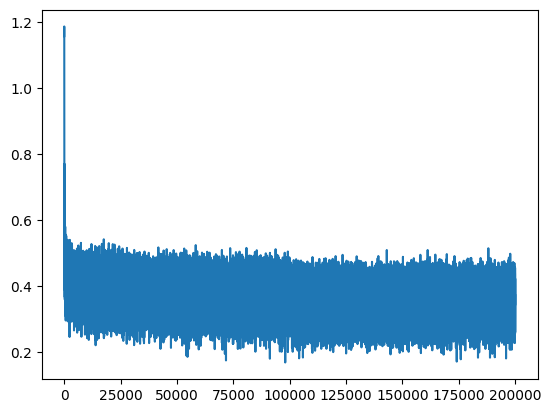

In [43]:
# plotting losses (y-axis) versus the steps i (x-axis)
plt.plot(stepi, lossi);

# Evaluate the model

In [44]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2563, grad_fn=<NllLossBackward0>)

In [52]:
# Validation :
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(f"Validation loss is : {loss}")

Validation loss is : 2.257234573364258


In [53]:
C.shape

torch.Size([27, 2])

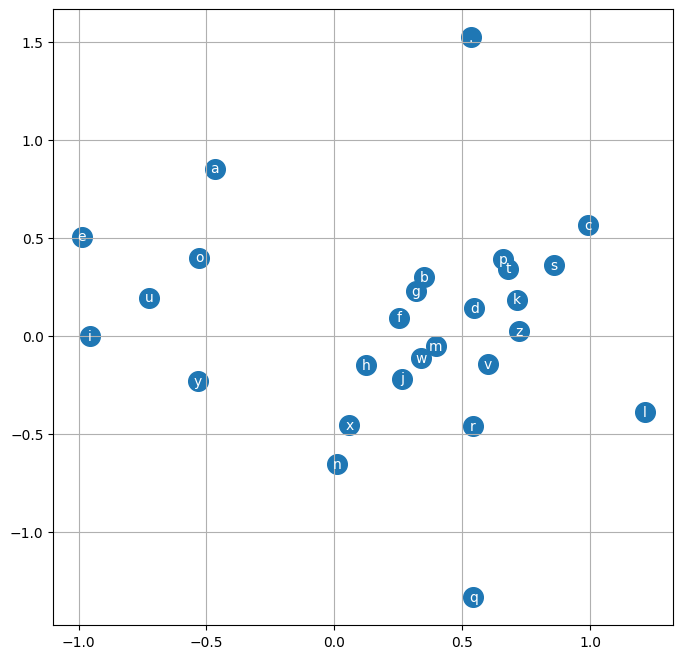

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [47]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [48]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 2])

# Generating names

In [50]:
# sample from the model
g = torch.Generator().manual_seed(25101989 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

abbroti.
aivia.
vavy.
miam.
ende.
lay.
nota.
candaratpter.
doedelyn.
treighamdi.
briya.
cheva.
ory.
kahira.
yasah.
fresmackalie.
kon.
zelco.
dagrene.
diskah.


[Younes Dahami](https://www.linkedin.com/in/dahami/)